In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca.learn.pytorch import Estimator
from bigdl.orca.learn.metrics import Accuracy
from bigdl.orca.learn.trigger import EveryEpoch

In [3]:
sc = init_orca_context(cluster_mode="local", cores=8, memory="4g")
# sc = init_orca_context(cluster_mode="yarn", cores=8, num_nodes=4, memory="4g")

Initializing orca context
Current pyspark location is : /root/anaconda3/envs/orca-demo/lib/python3.7/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /root/anaconda3/envs/orca-demo/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-2.0.0-jar-with-dependencies.jar:/root/anaconda3/envs/orca-demo/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-spark_3.1.2-2.0.0-jar-with-dependencies.jar pyspark-shell 
2022-05-06 11:01:09 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-05-06 11:01:11,124 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-05-06 11:01:11,126 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-05-06 11:01:11,126 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-05-06 11:01:11,127 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-05-06 11:01:11 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-05-06 11:01:11 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 8
22-05-06 11:01:11 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 27
2022-05-06 11:01:11 WARN  SparkContext:69 - Using an existing SparkContext; some configuration may not take effect.
22-05-06 11:01:11 [Thread-4] INFO  Engine$:446 - Find existing spark context. Checking the spark conf...
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registe


User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=224
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


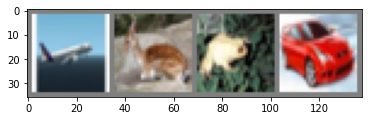

plane deer  frog  car  


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
estimator = Estimator.from_torch(model=net, optimizer=optimizer,
                                 loss=criterion, metrics=[Accuracy()])

estimator.fit(data=trainloader, epochs=2, validation_data=testloader,
              checkpoint_trigger=EveryEpoch())
print('Finished Training')

creating: createTorchLoss
creating: createTorchOptim
creating: createZooKerasAccuracy
creating: createEstimator
creating: createEveryEpoch
creating: createMaxEpoch


22-05-06 11:01:58 [Thread-4] INFO  InternalDistriOptimizer$:987 - TorchModel[25d93e56] isTorch is true
22-05-06 11:01:58 [Thread-4] INFO  InternalDistriOptimizer$:993 - torch model will use 1 OMP threads.
22-05-06 11:01:58 [Thread-4] INFO  DistriOptimizer$:826 - caching training rdd ...


22-05-06 11:02:21 [Thread-4] INFO  DistriOptimizer$:652 - Cache thread models...
22-05-06 11:02:22 [Executor task launch worker for task 0.0 in stage 5.0 (TID 5)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 80
22-05-06 11:02:22 [Executor task launch worker for task 0.0 in stage 5.0 (TID 5)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 80
22-05-06 11:02:22 [Executor task launch worker for task 0.0 in stage 5.0 (TID 5)] INFO  DistriOptimizer$:635 - model thread pool size is 1
2022-05-06 11:02:22 WARN  BlockManager:69 - Asked to remove block test_0weights0, which does not exist
2022-05-06 11:02:22 WARN  BlockManager:69 - Asked to remove block test_0gradients0, which does not exist
22-05-06 11:02:22 [Thread-4] INFO  DistriOptimizer$:654 - Cache thread models... done
22-05-06 11:02:22 [Thread-4] INFO  DistriOptimizer$:164 - Count dataset


22-05-06 11:02:34 [Thread-4] INFO  DistriOptimizer$:168 - Count dataset complete. Time elapsed: 12.397638598s


22-05-06 11:02:45 [Thread-4] WARN  DistriOptimizer$:172 - If the dataset is built directly from RDD[Minibatch], the data in each minibatch is fixed, and a single minibatch is randomly selected in each partition. If the dataset is transformed from RDD[Sample], each minibatch will be constructed on the fly from random samples, which is better for convergence.
22-05-06 11:02:45 [Thread-4] INFO  DistriOptimizer$:176 - config  {
	computeThresholdbatchSize: 100
	maxDropPercentage: 0.0
	warmupIterationNum: 200
	isLayerwiseScaled: false
	dropPercentage: 0.0
 }
22-05-06 11:02:45 [Thread-4] INFO  DistriOptimizer$:180 - Shuffle data
22-05-06 11:02:45 [Thread-4] INFO  DistriOptimizer$:183 - Shuffle data complete. Takes 3.54745E-4s
22-05-06 11:02:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4/50000][Iteration 1][Wall Clock 0.388189106s] Trained 4.0 records in 0.388189106 seconds. Throughput is 10.304256 records/second. Loss is 2.3179703. 
22-05-06 11:02:45 [Thread-4] INFO  DistriOptimizer$:4

22-05-06 11:02:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 152/50000][Iteration 38][Wall Clock 3.92013083s] Trained 4.0 records in 0.075860026 seconds. Throughput is 52.728695 records/second. Loss is 2.2692206. 
22-05-06 11:02:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 156/50000][Iteration 39][Wall Clock 3.999292162s] Trained 4.0 records in 0.079161332 seconds. Throughput is 50.52972 records/second. Loss is 2.3001642. 
22-05-06 11:02:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 160/50000][Iteration 40][Wall Clock 4.134954711s] Trained 4.0 records in 0.135662549 seconds. Throughput is 29.484922 records/second. Loss is 2.2790403. 
22-05-06 11:02:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 164/50000][Iteration 41][Wall Clock 4.211777967s] Trained 4.0 records in 0.076823256 seconds. Throughput is 52.067566 records/second. Loss is 2.302517. 
22-05-06 11:02:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 168/50000][Iteration 42][Wall Clock 4.288759502s] Tr

22-05-06 11:02:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 304/50000][Iteration 76][Wall Clock 6.71215979s] Trained 4.0 records in 0.068484461 seconds. Throughput is 58.40741 records/second. Loss is 2.3077648. 
22-05-06 11:02:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 308/50000][Iteration 77][Wall Clock 6.780963344s] Trained 4.0 records in 0.068803554 seconds. Throughput is 58.136528 records/second. Loss is 2.2974784. 
22-05-06 11:02:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 312/50000][Iteration 78][Wall Clock 6.852396208s] Trained 4.0 records in 0.071432864 seconds. Throughput is 55.99663 records/second. Loss is 2.2926006. 
22-05-06 11:02:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 316/50000][Iteration 79][Wall Clock 6.921583024s] Trained 4.0 records in 0.069186816 seconds. Throughput is 57.814484 records/second. Loss is 2.3468359. 
22-05-06 11:02:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 320/50000][Iteration 80][Wall Clock 6.990654486s] Tr

22-05-06 11:02:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 460/50000][Iteration 115][Wall Clock 9.402552751s] Trained 4.0 records in 0.066060178 seconds. Throughput is 60.55085 records/second. Loss is 2.2722387. 
22-05-06 11:02:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 464/50000][Iteration 116][Wall Clock 9.4717293s] Trained 4.0 records in 0.069176549 seconds. Throughput is 57.823067 records/second. Loss is 2.344306. 
22-05-06 11:02:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 468/50000][Iteration 117][Wall Clock 9.538309266s] Trained 4.0 records in 0.066579966 seconds. Throughput is 60.07813 records/second. Loss is 2.2803445. 
22-05-06 11:02:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 472/50000][Iteration 118][Wall Clock 9.604702468s] Trained 4.0 records in 0.066393202 seconds. Throughput is 60.24713 records/second. Loss is 2.2824795. 
22-05-06 11:02:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 476/50000][Iteration 119][Wall Clock 9.668540013s] 

22-05-06 11:02:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 608/50000][Iteration 152][Wall Clock 11.841702911s] Trained 4.0 records in 0.06725803 seconds. Throughput is 59.472454 records/second. Loss is 2.255118. 
22-05-06 11:02:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 612/50000][Iteration 153][Wall Clock 11.906965468s] Trained 4.0 records in 0.065262557 seconds. Throughput is 61.290886 records/second. Loss is 2.2878208. 
22-05-06 11:02:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 616/50000][Iteration 154][Wall Clock 11.970264635s] Trained 4.0 records in 0.063299167 seconds. Throughput is 63.191986 records/second. Loss is 2.2762465. 
22-05-06 11:02:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 620/50000][Iteration 155][Wall Clock 12.03576498s] Trained 4.0 records in 0.065500345 seconds. Throughput is 61.068382 records/second. Loss is 2.3170161. 
22-05-06 11:02:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 624/50000][Iteration 156][Wall Clock 12.1007

22-05-06 11:03:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 764/50000][Iteration 191][Wall Clock 14.40532508s] Trained 4.0 records in 0.06491068 seconds. Throughput is 61.623142 records/second. Loss is 2.3049285. 
22-05-06 11:03:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 768/50000][Iteration 192][Wall Clock 14.469932309s] Trained 4.0 records in 0.064607229 seconds. Throughput is 61.91258 records/second. Loss is 2.300867. 
22-05-06 11:03:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 772/50000][Iteration 193][Wall Clock 14.534836821s] Trained 4.0 records in 0.064904512 seconds. Throughput is 61.628998 records/second. Loss is 2.32009. 
22-05-06 11:03:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 776/50000][Iteration 194][Wall Clock 14.598873394s] Trained 4.0 records in 0.064036573 seconds. Throughput is 62.464306 records/second. Loss is 2.2884743. 
22-05-06 11:03:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 780/50000][Iteration 195][Wall Clock 14.6636784

22-05-06 11:03:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 920/50000][Iteration 230][Wall Clock 16.886358686s] Trained 4.0 records in 0.061312971 seconds. Throughput is 65.23905 records/second. Loss is 2.3033268. 
22-05-06 11:03:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 924/50000][Iteration 231][Wall Clock 16.947421476s] Trained 4.0 records in 0.06106279 seconds. Throughput is 65.50634 records/second. Loss is 2.3513443. 
22-05-06 11:03:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 928/50000][Iteration 232][Wall Clock 17.011366824s] Trained 4.0 records in 0.063945348 seconds. Throughput is 62.553417 records/second. Loss is 2.3215506. 
22-05-06 11:03:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 932/50000][Iteration 233][Wall Clock 17.073779871s] Trained 4.0 records in 0.062413047 seconds. Throughput is 64.089165 records/second. Loss is 2.3037574. 
22-05-06 11:03:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 936/50000][Iteration 234][Wall Clock 17.1394

22-05-06 11:03:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1072/50000][Iteration 268][Wall Clock 19.30871154s] Trained 4.0 records in 0.059943067 seconds. Throughput is 66.72998 records/second. Loss is 2.299736. 
22-05-06 11:03:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1076/50000][Iteration 269][Wall Clock 19.370057876s] Trained 4.0 records in 0.061346336 seconds. Throughput is 65.20357 records/second. Loss is 2.3198504. 
22-05-06 11:03:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1080/50000][Iteration 270][Wall Clock 19.431426264s] Trained 4.0 records in 0.061368388 seconds. Throughput is 65.18014 records/second. Loss is 2.3364177. 
22-05-06 11:03:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1084/50000][Iteration 271][Wall Clock 19.49286003s] Trained 4.0 records in 0.061433766 seconds. Throughput is 65.11077 records/second. Loss is 2.3041503. 
22-05-06 11:03:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1088/50000][Iteration 272][Wall Clock 19.557

22-05-06 11:03:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1228/50000][Iteration 307][Wall Clock 21.763172532s] Trained 4.0 records in 0.061589929 seconds. Throughput is 64.94568 records/second. Loss is 2.288015. 
22-05-06 11:03:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1232/50000][Iteration 308][Wall Clock 21.825796039s] Trained 4.0 records in 0.062623507 seconds. Throughput is 63.873775 records/second. Loss is 2.3281465. 
22-05-06 11:03:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1236/50000][Iteration 309][Wall Clock 21.887138558s] Trained 4.0 records in 0.061342519 seconds. Throughput is 65.20763 records/second. Loss is 2.303093. 
22-05-06 11:03:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1240/50000][Iteration 310][Wall Clock 21.951318981s] Trained 4.0 records in 0.064180423 seconds. Throughput is 62.3243 records/second. Loss is 2.270114. 
22-05-06 11:03:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1244/50000][Iteration 311][Wall Clock 22.014

22-05-06 11:03:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1388/50000][Iteration 347][Wall Clock 24.244395287s] Trained 4.0 records in 0.08024734 seconds. Throughput is 49.845886 records/second. Loss is 2.3029823. 
22-05-06 11:03:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1392/50000][Iteration 348][Wall Clock 24.30596445s] Trained 4.0 records in 0.061569163 seconds. Throughput is 64.96759 records/second. Loss is 2.3051047. 
22-05-06 11:03:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1396/50000][Iteration 349][Wall Clock 24.367624953s] Trained 4.0 records in 0.061660503 seconds. Throughput is 64.87135 records/second. Loss is 2.309349. 
22-05-06 11:03:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1400/50000][Iteration 350][Wall Clock 24.428313227s] Trained 4.0 records in 0.060688274 seconds. Throughput is 65.91059 records/second. Loss is 2.292804. 
22-05-06 11:03:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1404/50000][Iteration 351][Wall Clock 24.489

22-05-06 11:03:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1548/50000][Iteration 387][Wall Clock 26.693245652s] Trained 4.0 records in 0.061149642 seconds. Throughput is 65.4133 records/second. Loss is 2.3244336. 
22-05-06 11:03:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1552/50000][Iteration 388][Wall Clock 26.764674242s] Trained 4.0 records in 0.07142859 seconds. Throughput is 55.999985 records/second. Loss is 2.2840872. 
22-05-06 11:03:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1556/50000][Iteration 389][Wall Clock 26.827620853s] Trained 4.0 records in 0.062946611 seconds. Throughput is 63.545918 records/second. Loss is 2.302189. 
22-05-06 11:03:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1560/50000][Iteration 390][Wall Clock 26.888437532s] Trained 4.0 records in 0.060816679 seconds. Throughput is 65.77143 records/second. Loss is 2.3039043. 
22-05-06 11:03:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1564/50000][Iteration 391][Wall Clock 26.9

22-05-06 11:03:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1704/50000][Iteration 426][Wall Clock 29.076369312s] Trained 4.0 records in 0.059036052 seconds. Throughput is 67.7552 records/second. Loss is 2.2938647. 
22-05-06 11:03:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1708/50000][Iteration 427][Wall Clock 29.137055932s] Trained 4.0 records in 0.06068662 seconds. Throughput is 65.912384 records/second. Loss is 2.282712. 
22-05-06 11:03:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1712/50000][Iteration 428][Wall Clock 29.19647055s] Trained 4.0 records in 0.059414618 seconds. Throughput is 67.3235 records/second. Loss is 2.3136938. 
22-05-06 11:03:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1716/50000][Iteration 429][Wall Clock 29.257833625s] Trained 4.0 records in 0.061363075 seconds. Throughput is 65.18578 records/second. Loss is 2.3072803. 
22-05-06 11:03:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1720/50000][Iteration 430][Wall Clock 29.3187

22-05-06 11:03:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1860/50000][Iteration 465][Wall Clock 31.486492965s] Trained 4.0 records in 0.058847429 seconds. Throughput is 67.97238 records/second. Loss is 2.3166323. 
22-05-06 11:03:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1864/50000][Iteration 466][Wall Clock 31.542936655s] Trained 4.0 records in 0.05644369 seconds. Throughput is 70.86709 records/second. Loss is 2.3153813. 
22-05-06 11:03:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1868/50000][Iteration 467][Wall Clock 31.601570613s] Trained 4.0 records in 0.058633958 seconds. Throughput is 68.21986 records/second. Loss is 2.321669. 
22-05-06 11:03:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1872/50000][Iteration 468][Wall Clock 31.661447167s] Trained 4.0 records in 0.059876554 seconds. Throughput is 66.804115 records/second. Loss is 2.2884223. 
22-05-06 11:03:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 1876/50000][Iteration 469][Wall Clock 31.7

22-05-06 11:03:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2020/50000][Iteration 505][Wall Clock 33.881974442s] Trained 4.0 records in 0.062435719 seconds. Throughput is 64.06589 records/second. Loss is 2.300969. 
22-05-06 11:03:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2024/50000][Iteration 506][Wall Clock 33.940792205s] Trained 4.0 records in 0.058817763 seconds. Throughput is 68.00667 records/second. Loss is 2.3071065. 
22-05-06 11:03:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2028/50000][Iteration 507][Wall Clock 34.029110439s] Trained 4.0 records in 0.088318234 seconds. Throughput is 45.29076 records/second. Loss is 2.3094792. 
22-05-06 11:03:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2032/50000][Iteration 508][Wall Clock 34.088846002s] Trained 4.0 records in 0.059735563 seconds. Throughput is 66.961784 records/second. Loss is 2.2971754. 
22-05-06 11:03:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2036/50000][Iteration 509][Wall Clock 34.

22-05-06 11:03:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2176/50000][Iteration 544][Wall Clock 36.255558738s] Trained 4.0 records in 0.060040222 seconds. Throughput is 66.62201 records/second. Loss is 2.2910984. 
22-05-06 11:03:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2180/50000][Iteration 545][Wall Clock 36.314992774s] Trained 4.0 records in 0.059434036 seconds. Throughput is 67.3015 records/second. Loss is 2.2781098. 
22-05-06 11:03:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2184/50000][Iteration 546][Wall Clock 36.382368094s] Trained 4.0 records in 0.06737532 seconds. Throughput is 59.368923 records/second. Loss is 2.3196406. 
22-05-06 11:03:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2188/50000][Iteration 547][Wall Clock 36.441730787s] Trained 4.0 records in 0.059362693 seconds. Throughput is 67.382385 records/second. Loss is 2.3058333. 
22-05-06 11:03:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2192/50000][Iteration 548][Wall Clock 36.

22-05-06 11:03:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2336/50000][Iteration 584][Wall Clock 38.678964893s] Trained 4.0 records in 0.059484631 seconds. Throughput is 67.24426 records/second. Loss is 2.3255315. 
22-05-06 11:03:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2340/50000][Iteration 585][Wall Clock 38.73937292s] Trained 4.0 records in 0.060408027 seconds. Throughput is 66.21637 records/second. Loss is 2.3170269. 
22-05-06 11:03:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2344/50000][Iteration 586][Wall Clock 38.798008201s] Trained 4.0 records in 0.058635281 seconds. Throughput is 68.218315 records/second. Loss is 2.2976186. 
22-05-06 11:03:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2348/50000][Iteration 587][Wall Clock 38.85789534s] Trained 4.0 records in 0.059887139 seconds. Throughput is 66.792305 records/second. Loss is 2.3028553. 
22-05-06 11:03:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2352/50000][Iteration 588][Wall Clock 38.

22-05-06 11:03:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2496/50000][Iteration 624][Wall Clock 41.081752593s] Trained 4.0 records in 0.062038173 seconds. Throughput is 64.47643 records/second. Loss is 2.320672. 
22-05-06 11:03:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2500/50000][Iteration 625][Wall Clock 41.140458009s] Trained 4.0 records in 0.058705416 seconds. Throughput is 68.13682 records/second. Loss is 2.3161616. 
22-05-06 11:03:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2504/50000][Iteration 626][Wall Clock 41.200824454s] Trained 4.0 records in 0.060366445 seconds. Throughput is 66.26198 records/second. Loss is 2.2845905. 
22-05-06 11:03:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2508/50000][Iteration 627][Wall Clock 41.258852541s] Trained 4.0 records in 0.058028087 seconds. Throughput is 68.93214 records/second. Loss is 2.3025508. 
22-05-06 11:03:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2512/50000][Iteration 628][Wall Clock 41.3

22-05-06 11:03:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2656/50000][Iteration 664][Wall Clock 43.484803907s] Trained 4.0 records in 0.07742996 seconds. Throughput is 51.65959 records/second. Loss is 2.30965. 
22-05-06 11:03:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2660/50000][Iteration 665][Wall Clock 43.542019264s] Trained 4.0 records in 0.057215357 seconds. Throughput is 69.9113 records/second. Loss is 2.2549586. 
22-05-06 11:03:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2664/50000][Iteration 666][Wall Clock 43.600222858s] Trained 4.0 records in 0.058203594 seconds. Throughput is 68.72428 records/second. Loss is 2.298832. 
22-05-06 11:03:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2668/50000][Iteration 667][Wall Clock 43.657250271s] Trained 4.0 records in 0.057027413 seconds. Throughput is 70.1417 records/second. Loss is 2.2741246. 
22-05-06 11:03:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2672/50000][Iteration 668][Wall Clock 43.713429

22-05-06 11:03:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2816/50000][Iteration 704][Wall Clock 45.792888919s] Trained 4.0 records in 0.058429438 seconds. Throughput is 68.45864 records/second. Loss is 2.3061564. 
22-05-06 11:03:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2820/50000][Iteration 705][Wall Clock 45.849974819s] Trained 4.0 records in 0.0570859 seconds. Throughput is 70.06984 records/second. Loss is 2.2925754. 
22-05-06 11:03:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2824/50000][Iteration 706][Wall Clock 45.91086019s] Trained 4.0 records in 0.060885371 seconds. Throughput is 65.69723 records/second. Loss is 2.300641. 
22-05-06 11:03:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2828/50000][Iteration 707][Wall Clock 45.967511664s] Trained 4.0 records in 0.056651474 seconds. Throughput is 70.60717 records/second. Loss is 2.2936773. 
22-05-06 11:03:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2832/50000][Iteration 708][Wall Clock 46.0256

22-05-06 11:03:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2976/50000][Iteration 744][Wall Clock 48.153227097s] Trained 4.0 records in 0.057940483 seconds. Throughput is 69.03636 records/second. Loss is 2.2877572. 
22-05-06 11:03:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2980/50000][Iteration 745][Wall Clock 48.211280363s] Trained 4.0 records in 0.058053266 seconds. Throughput is 68.90224 records/second. Loss is 2.2860982. 
22-05-06 11:03:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2984/50000][Iteration 746][Wall Clock 48.268999456s] Trained 4.0 records in 0.057719093 seconds. Throughput is 69.301155 records/second. Loss is 2.2883892. 
22-05-06 11:03:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2988/50000][Iteration 747][Wall Clock 48.327395582s] Trained 4.0 records in 0.058396126 seconds. Throughput is 68.497696 records/second. Loss is 2.311504. 
22-05-06 11:03:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 2992/50000][Iteration 748][Wall Clock 48

22-05-06 11:03:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3136/50000][Iteration 784][Wall Clock 50.496577326s] Trained 4.0 records in 0.056311948 seconds. Throughput is 71.03288 records/second. Loss is 2.2993164. 
22-05-06 11:03:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3140/50000][Iteration 785][Wall Clock 50.554491875s] Trained 4.0 records in 0.057914549 seconds. Throughput is 69.067276 records/second. Loss is 2.2859805. 
22-05-06 11:03:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3144/50000][Iteration 786][Wall Clock 50.617269041s] Trained 4.0 records in 0.062777166 seconds. Throughput is 63.71743 records/second. Loss is 2.2959623. 
22-05-06 11:03:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3148/50000][Iteration 787][Wall Clock 50.675710729s] Trained 4.0 records in 0.058441688 seconds. Throughput is 68.44429 records/second. Loss is 2.3095365. 
22-05-06 11:03:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3152/50000][Iteration 788][Wall Clock 50

22-05-06 11:03:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3296/50000][Iteration 824][Wall Clock 52.8583306s] Trained 4.0 records in 0.05771959 seconds. Throughput is 69.30056 records/second. Loss is 2.3068342. 
22-05-06 11:03:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3300/50000][Iteration 825][Wall Clock 52.917526441s] Trained 4.0 records in 0.059195841 seconds. Throughput is 67.57231 records/second. Loss is 2.2924113. 
22-05-06 11:03:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3304/50000][Iteration 826][Wall Clock 52.974759601s] Trained 4.0 records in 0.05723316 seconds. Throughput is 69.88956 records/second. Loss is 2.29757. 
22-05-06 11:03:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3308/50000][Iteration 827][Wall Clock 53.03293128s] Trained 4.0 records in 0.058171679 seconds. Throughput is 68.761986 records/second. Loss is 2.2757697. 
22-05-06 11:03:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3312/50000][Iteration 828][Wall Clock 53.091903

22-05-06 11:03:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3456/50000][Iteration 864][Wall Clock 55.21189882s] Trained 4.0 records in 0.059361151 seconds. Throughput is 67.38414 records/second. Loss is 2.284633. 
22-05-06 11:03:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3460/50000][Iteration 865][Wall Clock 55.269003151s] Trained 4.0 records in 0.057104331 seconds. Throughput is 70.047226 records/second. Loss is 2.2899625. 
22-05-06 11:03:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3464/50000][Iteration 866][Wall Clock 55.327452515s] Trained 4.0 records in 0.058449364 seconds. Throughput is 68.4353 records/second. Loss is 2.2992046. 
22-05-06 11:03:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3468/50000][Iteration 867][Wall Clock 55.385546691s] Trained 4.0 records in 0.058094176 seconds. Throughput is 68.853714 records/second. Loss is 2.3248043. 
22-05-06 11:03:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3472/50000][Iteration 868][Wall Clock 55.4

22-05-06 11:03:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3616/50000][Iteration 904][Wall Clock 57.510411638s] Trained 4.0 records in 0.057458838 seconds. Throughput is 69.61505 records/second. Loss is 2.2898128. 
22-05-06 11:03:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3620/50000][Iteration 905][Wall Clock 57.567287392s] Trained 4.0 records in 0.056875754 seconds. Throughput is 70.328735 records/second. Loss is 2.2781024. 
22-05-06 11:03:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3624/50000][Iteration 906][Wall Clock 57.624689223s] Trained 4.0 records in 0.057401831 seconds. Throughput is 69.68419 records/second. Loss is 2.27352. 
22-05-06 11:03:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3628/50000][Iteration 907][Wall Clock 57.681775489s] Trained 4.0 records in 0.057086266 seconds. Throughput is 70.06939 records/second. Loss is 2.319517. 
22-05-06 11:03:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3632/50000][Iteration 908][Wall Clock 57.74

22-05-06 11:03:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3776/50000][Iteration 944][Wall Clock 59.875310345s] Trained 4.0 records in 0.059218792 seconds. Throughput is 67.54613 records/second. Loss is 2.272575. 
22-05-06 11:03:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3780/50000][Iteration 945][Wall Clock 59.9335343s] Trained 4.0 records in 0.058223955 seconds. Throughput is 68.70025 records/second. Loss is 2.2999265. 
22-05-06 11:03:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3784/50000][Iteration 946][Wall Clock 59.986810092s] Trained 4.0 records in 0.053275792 seconds. Throughput is 75.081 records/second. Loss is 2.3047776. 
22-05-06 11:03:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3788/50000][Iteration 947][Wall Clock 60.043325997s] Trained 4.0 records in 0.056515905 seconds. Throughput is 70.776535 records/second. Loss is 2.3090274. 
22-05-06 11:03:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3792/50000][Iteration 948][Wall Clock 60.0988

22-05-06 11:03:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3936/50000][Iteration 984][Wall Clock 62.177678733s] Trained 4.0 records in 0.057424517 seconds. Throughput is 69.65666 records/second. Loss is 2.3064225. 
22-05-06 11:03:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3940/50000][Iteration 985][Wall Clock 62.234709443s] Trained 4.0 records in 0.05703071 seconds. Throughput is 70.13765 records/second. Loss is 2.2915163. 
22-05-06 11:03:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3944/50000][Iteration 986][Wall Clock 62.291684982s] Trained 4.0 records in 0.056975539 seconds. Throughput is 70.20557 records/second. Loss is 2.3206866. 
22-05-06 11:03:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3948/50000][Iteration 987][Wall Clock 62.347991406s] Trained 4.0 records in 0.056306424 seconds. Throughput is 71.03985 records/second. Loss is 2.290034. 
22-05-06 11:03:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 3952/50000][Iteration 988][Wall Clock 62.40

22-05-06 11:03:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4096/50000][Iteration 1024][Wall Clock 64.43854936s] Trained 4.0 records in 0.056501099 seconds. Throughput is 70.79508 records/second. Loss is 2.26652. 
22-05-06 11:03:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4100/50000][Iteration 1025][Wall Clock 64.492974743s] Trained 4.0 records in 0.054425383 seconds. Throughput is 73.49512 records/second. Loss is 2.2565618. 
22-05-06 11:03:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4104/50000][Iteration 1026][Wall Clock 64.549847327s] Trained 4.0 records in 0.056872584 seconds. Throughput is 70.33266 records/second. Loss is 2.2302327. 
22-05-06 11:03:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4108/50000][Iteration 1027][Wall Clock 64.605118793s] Trained 4.0 records in 0.055271466 seconds. Throughput is 72.37007 records/second. Loss is 2.3031056. 
22-05-06 11:03:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4112/50000][Iteration 1028][Wall Clock 6

22-05-06 11:03:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4256/50000][Iteration 1064][Wall Clock 66.772271175s] Trained 4.0 records in 0.061016476 seconds. Throughput is 65.55606 records/second. Loss is 2.2986832. 
22-05-06 11:03:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4260/50000][Iteration 1065][Wall Clock 66.836267712s] Trained 4.0 records in 0.063996537 seconds. Throughput is 62.50338 records/second. Loss is 2.30594. 
22-05-06 11:03:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4264/50000][Iteration 1066][Wall Clock 66.895581494s] Trained 4.0 records in 0.059313782 seconds. Throughput is 67.43795 records/second. Loss is 2.289547. 
22-05-06 11:03:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4268/50000][Iteration 1067][Wall Clock 66.954447852s] Trained 4.0 records in 0.058866358 seconds. Throughput is 67.95052 records/second. Loss is 2.2604132. 
22-05-06 11:03:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4272/50000][Iteration 1068][Wall Clock 6

22-05-06 11:03:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4416/50000][Iteration 1104][Wall Clock 69.146576104s] Trained 4.0 records in 0.056577063 seconds. Throughput is 70.70003 records/second. Loss is 2.238. 
22-05-06 11:03:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4420/50000][Iteration 1105][Wall Clock 69.204899457s] Trained 4.0 records in 0.058323353 seconds. Throughput is 68.58316 records/second. Loss is 2.188172. 
22-05-06 11:03:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4424/50000][Iteration 1106][Wall Clock 69.263876228s] Trained 4.0 records in 0.058976771 seconds. Throughput is 67.82332 records/second. Loss is 2.3488615. 
22-05-06 11:03:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4428/50000][Iteration 1107][Wall Clock 69.321716477s] Trained 4.0 records in 0.057840249 seconds. Throughput is 69.15599 records/second. Loss is 2.2739372. 
22-05-06 11:03:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4432/50000][Iteration 1108][Wall Clock 69.

22-05-06 11:03:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4576/50000][Iteration 1144][Wall Clock 71.461205017s] Trained 4.0 records in 0.061073713 seconds. Throughput is 65.49463 records/second. Loss is 2.2952063. 
22-05-06 11:03:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4580/50000][Iteration 1145][Wall Clock 71.519677443s] Trained 4.0 records in 0.058472426 seconds. Throughput is 68.40832 records/second. Loss is 2.1799812. 
22-05-06 11:03:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4584/50000][Iteration 1146][Wall Clock 71.577466539s] Trained 4.0 records in 0.057789096 seconds. Throughput is 69.21721 records/second. Loss is 2.339748. 
22-05-06 11:03:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4588/50000][Iteration 1147][Wall Clock 71.634366643s] Trained 4.0 records in 0.056900104 seconds. Throughput is 70.298645 records/second. Loss is 2.166885. 
22-05-06 11:03:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4592/50000][Iteration 1148][Wall Clock

22-05-06 11:03:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4736/50000][Iteration 1184][Wall Clock 73.768320314s] Trained 4.0 records in 0.057823817 seconds. Throughput is 69.175644 records/second. Loss is 2.1338952. 
22-05-06 11:04:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4740/50000][Iteration 1185][Wall Clock 73.827588469s] Trained 4.0 records in 0.059268155 seconds. Throughput is 67.48987 records/second. Loss is 2.0604188. 
22-05-06 11:04:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4744/50000][Iteration 1186][Wall Clock 73.884791815s] Trained 4.0 records in 0.057203346 seconds. Throughput is 69.92598 records/second. Loss is 2.12738. 
22-05-06 11:04:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4748/50000][Iteration 1187][Wall Clock 73.942208155s] Trained 4.0 records in 0.05741634 seconds. Throughput is 69.66658 records/second. Loss is 2.2631521. 
22-05-06 11:04:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4752/50000][Iteration 1188][Wall Clock 

22-05-06 11:04:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4896/50000][Iteration 1224][Wall Clock 76.084704472s] Trained 4.0 records in 0.056265168 seconds. Throughput is 71.09194 records/second. Loss is 2.175764. 
22-05-06 11:04:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4900/50000][Iteration 1225][Wall Clock 76.141939386s] Trained 4.0 records in 0.057234914 seconds. Throughput is 69.88741 records/second. Loss is 2.0018482. 
22-05-06 11:04:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4904/50000][Iteration 1226][Wall Clock 76.198699191s] Trained 4.0 records in 0.056759805 seconds. Throughput is 70.472404 records/second. Loss is 2.2865195. 
22-05-06 11:04:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4908/50000][Iteration 1227][Wall Clock 76.255245866s] Trained 4.0 records in 0.056546675 seconds. Throughput is 70.73802 records/second. Loss is 1.9212577. 
22-05-06 11:04:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 4912/50000][Iteration 1228][Wall Cloc

22-05-06 11:04:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5056/50000][Iteration 1264][Wall Clock 78.399118947s] Trained 4.0 records in 0.055600252 seconds. Throughput is 71.94212 records/second. Loss is 2.2402468. 
22-05-06 11:04:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5060/50000][Iteration 1265][Wall Clock 78.455343264s] Trained 4.0 records in 0.056224317 seconds. Throughput is 71.14359 records/second. Loss is 2.2944138. 
22-05-06 11:04:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5064/50000][Iteration 1266][Wall Clock 78.512634173s] Trained 4.0 records in 0.057290909 seconds. Throughput is 69.81911 records/second. Loss is 1.9219987. 
22-05-06 11:04:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5068/50000][Iteration 1267][Wall Clock 78.566839949s] Trained 4.0 records in 0.054205776 seconds. Throughput is 73.79288 records/second. Loss is 2.1411843. 
22-05-06 11:04:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5072/50000][Iteration 1268][Wall Cloc

22-05-06 11:04:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5216/50000][Iteration 1304][Wall Clock 80.670959388s] Trained 4.0 records in 0.056143659 seconds. Throughput is 71.245804 records/second. Loss is 2.4089148. 
22-05-06 11:04:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5220/50000][Iteration 1305][Wall Clock 80.728228252s] Trained 4.0 records in 0.057268864 seconds. Throughput is 69.84598 records/second. Loss is 1.8813574. 
22-05-06 11:04:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5224/50000][Iteration 1306][Wall Clock 80.782523579s] Trained 4.0 records in 0.054295327 seconds. Throughput is 73.671165 records/second. Loss is 2.5733624. 
22-05-06 11:04:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5228/50000][Iteration 1307][Wall Clock 80.838860307s] Trained 4.0 records in 0.056336728 seconds. Throughput is 71.00164 records/second. Loss is 2.3468544. 
22-05-06 11:04:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5232/50000][Iteration 1308][Wall Cl

22-05-06 11:04:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5376/50000][Iteration 1344][Wall Clock 82.970553918s] Trained 4.0 records in 0.058484482 seconds. Throughput is 68.39421 records/second. Loss is 1.9985619. 
22-05-06 11:04:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5380/50000][Iteration 1345][Wall Clock 83.028588818s] Trained 4.0 records in 0.0580349 seconds. Throughput is 68.92404 records/second. Loss is 2.3188694. 
22-05-06 11:04:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5384/50000][Iteration 1346][Wall Clock 83.086419764s] Trained 4.0 records in 0.057830946 seconds. Throughput is 69.16712 records/second. Loss is 2.3875124. 
22-05-06 11:04:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5388/50000][Iteration 1347][Wall Clock 83.143241481s] Trained 4.0 records in 0.056821717 seconds. Throughput is 70.395615 records/second. Loss is 2.1746755. 
22-05-06 11:04:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5392/50000][Iteration 1348][Wall Clock

22-05-06 11:04:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5536/50000][Iteration 1384][Wall Clock 85.292981714s] Trained 4.0 records in 0.057216056 seconds. Throughput is 69.910446 records/second. Loss is 2.266072. 
22-05-06 11:04:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5540/50000][Iteration 1385][Wall Clock 85.347506096s] Trained 4.0 records in 0.054524382 seconds. Throughput is 73.36168 records/second. Loss is 2.163011. 
22-05-06 11:04:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5544/50000][Iteration 1386][Wall Clock 85.405095347s] Trained 4.0 records in 0.057589251 seconds. Throughput is 69.457405 records/second. Loss is 2.3167124. 
22-05-06 11:04:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5548/50000][Iteration 1387][Wall Clock 85.460804732s] Trained 4.0 records in 0.055709385 seconds. Throughput is 71.801186 records/second. Loss is 2.310409. 
22-05-06 11:04:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5552/50000][Iteration 1388][Wall Cloc

22-05-06 11:04:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5696/50000][Iteration 1424][Wall Clock 87.638963441s] Trained 4.0 records in 0.060044862 seconds. Throughput is 66.61686 records/second. Loss is 2.248806. 
22-05-06 11:04:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5700/50000][Iteration 1425][Wall Clock 87.696774009s] Trained 4.0 records in 0.057810568 seconds. Throughput is 69.191505 records/second. Loss is 2.0332384. 
22-05-06 11:04:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5704/50000][Iteration 1426][Wall Clock 87.753803924s] Trained 4.0 records in 0.057029915 seconds. Throughput is 70.138626 records/second. Loss is 2.208845. 
22-05-06 11:04:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5708/50000][Iteration 1427][Wall Clock 87.81591835s] Trained 4.0 records in 0.062114426 seconds. Throughput is 64.39728 records/second. Loss is 2.1766014. 
22-05-06 11:04:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5712/50000][Iteration 1428][Wall Clock

22-05-06 11:04:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5856/50000][Iteration 1464][Wall Clock 89.952220425s] Trained 4.0 records in 0.054834644 seconds. Throughput is 72.94659 records/second. Loss is 2.1719294. 
22-05-06 11:04:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5860/50000][Iteration 1465][Wall Clock 90.004719362s] Trained 4.0 records in 0.052498937 seconds. Throughput is 76.19202 records/second. Loss is 2.2542055. 
22-05-06 11:04:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5864/50000][Iteration 1466][Wall Clock 90.055681642s] Trained 4.0 records in 0.05096228 seconds. Throughput is 78.489426 records/second. Loss is 1.9881489. 
22-05-06 11:04:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5868/50000][Iteration 1467][Wall Clock 90.104638401s] Trained 4.0 records in 0.048956759 seconds. Throughput is 81.70476 records/second. Loss is 2.0119498. 
22-05-06 11:04:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 5872/50000][Iteration 1468][Wall Cloc

22-05-06 11:04:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6016/50000][Iteration 1504][Wall Clock 92.037384784s] Trained 4.0 records in 0.052718216 seconds. Throughput is 75.87511 records/second. Loss is 2.1654687. 
22-05-06 11:04:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6020/50000][Iteration 1505][Wall Clock 92.08670951s] Trained 4.0 records in 0.049324726 seconds. Throughput is 81.09523 records/second. Loss is 2.1503477. 
22-05-06 11:04:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6024/50000][Iteration 1506][Wall Clock 92.136775004s] Trained 4.0 records in 0.050065494 seconds. Throughput is 79.89535 records/second. Loss is 1.747992. 
22-05-06 11:04:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6028/50000][Iteration 1507][Wall Clock 92.186280319s] Trained 4.0 records in 0.049505315 seconds. Throughput is 80.7994 records/second. Loss is 2.5735447. 
22-05-06 11:04:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6032/50000][Iteration 1508][Wall Clock 9

22-05-06 11:04:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6176/50000][Iteration 1544][Wall Clock 94.269026386s] Trained 4.0 records in 0.055463818 seconds. Throughput is 72.11909 records/second. Loss is 2.428333. 
22-05-06 11:04:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6180/50000][Iteration 1545][Wall Clock 94.327554408s] Trained 4.0 records in 0.058528022 seconds. Throughput is 68.34333 records/second. Loss is 2.159196. 
22-05-06 11:04:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6184/50000][Iteration 1546][Wall Clock 94.385755884s] Trained 4.0 records in 0.058201476 seconds. Throughput is 68.726776 records/second. Loss is 2.683458. 
22-05-06 11:04:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6188/50000][Iteration 1547][Wall Clock 94.452447556s] Trained 4.0 records in 0.066691672 seconds. Throughput is 59.9775 records/second. Loss is 1.7329967. 
22-05-06 11:04:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6192/50000][Iteration 1548][Wall Clock 9

22-05-06 11:04:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6336/50000][Iteration 1584][Wall Clock 96.614955678s] Trained 4.0 records in 0.057888722 seconds. Throughput is 69.09809 records/second. Loss is 2.170678. 
22-05-06 11:04:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6340/50000][Iteration 1585][Wall Clock 96.671607202s] Trained 4.0 records in 0.056651524 seconds. Throughput is 70.6071 records/second. Loss is 2.3480096. 
22-05-06 11:04:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6344/50000][Iteration 1586][Wall Clock 96.727468328s] Trained 4.0 records in 0.055861126 seconds. Throughput is 71.60615 records/second. Loss is 2.0116756. 
22-05-06 11:04:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6348/50000][Iteration 1587][Wall Clock 96.782495099s] Trained 4.0 records in 0.055026771 seconds. Throughput is 72.691895 records/second. Loss is 1.867825. 
22-05-06 11:04:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6352/50000][Iteration 1588][Wall Clock 

22-05-06 11:04:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6496/50000][Iteration 1624][Wall Clock 98.937894523s] Trained 4.0 records in 0.057381778 seconds. Throughput is 69.70854 records/second. Loss is 1.8076364. 
22-05-06 11:04:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6500/50000][Iteration 1625][Wall Clock 98.995339934s] Trained 4.0 records in 0.057445411 seconds. Throughput is 69.631325 records/second. Loss is 2.2141423. 
22-05-06 11:04:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6504/50000][Iteration 1626][Wall Clock 99.052441971s] Trained 4.0 records in 0.057102037 seconds. Throughput is 70.05004 records/second. Loss is 2.2372546. 
22-05-06 11:04:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6508/50000][Iteration 1627][Wall Clock 99.111013683s] Trained 4.0 records in 0.058571712 seconds. Throughput is 68.29235 records/second. Loss is 2.0807614. 
22-05-06 11:04:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6512/50000][Iteration 1628][Wall Clo

22-05-06 11:04:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6656/50000][Iteration 1664][Wall Clock 101.300300452s] Trained 4.0 records in 0.063318506 seconds. Throughput is 63.172684 records/second. Loss is 1.7209303. 
22-05-06 11:04:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6660/50000][Iteration 1665][Wall Clock 101.359938658s] Trained 4.0 records in 0.059638206 seconds. Throughput is 67.0711 records/second. Loss is 2.3632307. 
22-05-06 11:04:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6664/50000][Iteration 1666][Wall Clock 101.427771696s] Trained 4.0 records in 0.067833038 seconds. Throughput is 58.96832 records/second. Loss is 1.9664836. 
22-05-06 11:04:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6668/50000][Iteration 1667][Wall Clock 101.487230471s] Trained 4.0 records in 0.059458775 seconds. Throughput is 67.273506 records/second. Loss is 1.7453132. 
22-05-06 11:04:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6672/50000][Iteration 1668][Wall

22-05-06 11:04:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6816/50000][Iteration 1704][Wall Clock 103.647873159s] Trained 4.0 records in 0.057079595 seconds. Throughput is 70.07758 records/second. Loss is 1.751895. 
22-05-06 11:04:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6820/50000][Iteration 1705][Wall Clock 103.707518943s] Trained 4.0 records in 0.059645784 seconds. Throughput is 67.06258 records/second. Loss is 2.0383723. 
22-05-06 11:04:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6824/50000][Iteration 1706][Wall Clock 103.764947034s] Trained 4.0 records in 0.057428091 seconds. Throughput is 69.65232 records/second. Loss is 2.1704926. 
22-05-06 11:04:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6828/50000][Iteration 1707][Wall Clock 103.82166226s] Trained 4.0 records in 0.056715226 seconds. Throughput is 70.527794 records/second. Loss is 2.580482. 
22-05-06 11:04:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6832/50000][Iteration 1708][Wall Cl

22-05-06 11:04:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6976/50000][Iteration 1744][Wall Clock 105.93861157s] Trained 4.0 records in 0.053878345 seconds. Throughput is 74.24133 records/second. Loss is 2.2631736. 
22-05-06 11:04:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6980/50000][Iteration 1745][Wall Clock 105.996430516s] Trained 4.0 records in 0.057818946 seconds. Throughput is 69.18147 records/second. Loss is 2.0250127. 
22-05-06 11:04:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6984/50000][Iteration 1746][Wall Clock 106.054765207s] Trained 4.0 records in 0.058334691 seconds. Throughput is 68.56983 records/second. Loss is 2.0778956. 
22-05-06 11:04:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6988/50000][Iteration 1747][Wall Clock 106.111094337s] Trained 4.0 records in 0.05632913 seconds. Throughput is 71.011215 records/second. Loss is 1.5337315. 
22-05-06 11:04:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 6992/50000][Iteration 1748][Wall C

22-05-06 11:04:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7136/50000][Iteration 1784][Wall Clock 108.294581666s] Trained 4.0 records in 0.059306549 seconds. Throughput is 67.446175 records/second. Loss is 1.964056. 
22-05-06 11:04:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7140/50000][Iteration 1785][Wall Clock 108.354850206s] Trained 4.0 records in 0.06026854 seconds. Throughput is 66.36962 records/second. Loss is 2.156327. 
22-05-06 11:04:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7144/50000][Iteration 1786][Wall Clock 108.415079317s] Trained 4.0 records in 0.060229111 seconds. Throughput is 66.41306 records/second. Loss is 1.9325154. 
22-05-06 11:04:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7148/50000][Iteration 1787][Wall Clock 108.475192144s] Trained 4.0 records in 0.060112827 seconds. Throughput is 66.54154 records/second. Loss is 1.8183916. 
22-05-06 11:04:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7152/50000][Iteration 1788][Wall Cl

22-05-06 11:04:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7296/50000][Iteration 1824][Wall Clock 110.59873161s] Trained 4.0 records in 0.055235186 seconds. Throughput is 72.41761 records/second. Loss is 2.9368849. 
22-05-06 11:04:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7300/50000][Iteration 1825][Wall Clock 110.654950655s] Trained 4.0 records in 0.056219045 seconds. Throughput is 71.15027 records/second. Loss is 1.6910889. 
22-05-06 11:04:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7304/50000][Iteration 1826][Wall Clock 110.715540175s] Trained 4.0 records in 0.06058952 seconds. Throughput is 66.01802 records/second. Loss is 2.3941345. 
22-05-06 11:04:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7308/50000][Iteration 1827][Wall Clock 110.772445215s] Trained 4.0 records in 0.05690504 seconds. Throughput is 70.29254 records/second. Loss is 2.5274234. 
22-05-06 11:04:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7312/50000][Iteration 1828][Wall Clo

22-05-06 11:04:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7456/50000][Iteration 1864][Wall Clock 112.918595855s] Trained 4.0 records in 0.058899383 seconds. Throughput is 67.91242 records/second. Loss is 1.4877858. 
22-05-06 11:04:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7460/50000][Iteration 1865][Wall Clock 112.976964s] Trained 4.0 records in 0.058368145 seconds. Throughput is 68.53053 records/second. Loss is 2.2537508. 
22-05-06 11:04:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7464/50000][Iteration 1866][Wall Clock 113.034367088s] Trained 4.0 records in 0.057403088 seconds. Throughput is 69.68266 records/second. Loss is 1.6207306. 
22-05-06 11:04:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7468/50000][Iteration 1867][Wall Clock 113.090824703s] Trained 4.0 records in 0.056457615 seconds. Throughput is 70.84961 records/second. Loss is 2.1165. 
22-05-06 11:04:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7472/50000][Iteration 1868][Wall Clock 

22-05-06 11:04:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7612/50000][Iteration 1903][Wall Clock 115.222772995s] Trained 4.0 records in 0.057155122 seconds. Throughput is 69.98498 records/second. Loss is 1.9785361. 
22-05-06 11:04:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7616/50000][Iteration 1904][Wall Clock 115.280537221s] Trained 4.0 records in 0.057764226 seconds. Throughput is 69.24701 records/second. Loss is 1.861941. 
22-05-06 11:04:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7620/50000][Iteration 1905][Wall Clock 115.336154753s] Trained 4.0 records in 0.055617532 seconds. Throughput is 71.91977 records/second. Loss is 1.9055943. 
22-05-06 11:04:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7624/50000][Iteration 1906][Wall Clock 115.392435708s] Trained 4.0 records in 0.056280955 seconds. Throughput is 71.072 records/second. Loss is 2.2514038. 
22-05-06 11:04:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7628/50000][Iteration 1907][Wall Clo

22-05-06 11:04:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7772/50000][Iteration 1943][Wall Clock 117.573960139s] Trained 4.0 records in 0.057317746 seconds. Throughput is 69.786415 records/second. Loss is 2.278935. 
22-05-06 11:04:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7776/50000][Iteration 1944][Wall Clock 117.628393412s] Trained 4.0 records in 0.054433273 seconds. Throughput is 73.48447 records/second. Loss is 1.7465378. 
22-05-06 11:04:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7780/50000][Iteration 1945][Wall Clock 117.685394029s] Trained 4.0 records in 0.057000617 seconds. Throughput is 70.174675 records/second. Loss is 1.9794161. 
22-05-06 11:04:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7784/50000][Iteration 1946][Wall Clock 117.741534542s] Trained 4.0 records in 0.056140513 seconds. Throughput is 71.249794 records/second. Loss is 2.0671315. 
22-05-06 11:04:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7788/50000][Iteration 1947][Wal

22-05-06 11:04:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7932/50000][Iteration 1983][Wall Clock 119.853516767s] Trained 4.0 records in 0.056717639 seconds. Throughput is 70.524796 records/second. Loss is 2.4305725. 
22-05-06 11:04:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7936/50000][Iteration 1984][Wall Clock 119.910668613s] Trained 4.0 records in 0.057151846 seconds. Throughput is 69.98899 records/second. Loss is 1.9685464. 
22-05-06 11:04:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7940/50000][Iteration 1985][Wall Clock 119.966857397s] Trained 4.0 records in 0.056188784 seconds. Throughput is 71.18858 records/second. Loss is 1.9970114. 
22-05-06 11:04:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7944/50000][Iteration 1986][Wall Clock 120.023288468s] Trained 4.0 records in 0.056431071 seconds. Throughput is 70.882935 records/second. Loss is 2.1837597. 
22-05-06 11:04:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 7948/50000][Iteration 1987][Wal

22-05-06 11:04:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8092/50000][Iteration 2023][Wall Clock 122.161287101s] Trained 4.0 records in 0.05825649 seconds. Throughput is 68.66188 records/second. Loss is 2.6212168. 
22-05-06 11:04:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8096/50000][Iteration 2024][Wall Clock 122.219078087s] Trained 4.0 records in 0.057790986 seconds. Throughput is 69.21494 records/second. Loss is 2.8677368. 
22-05-06 11:04:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8100/50000][Iteration 2025][Wall Clock 122.275603964s] Trained 4.0 records in 0.056525877 seconds. Throughput is 70.764046 records/second. Loss is 1.4361652. 
22-05-06 11:04:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8104/50000][Iteration 2026][Wall Clock 122.334157284s] Trained 4.0 records in 0.05855332 seconds. Throughput is 68.313805 records/second. Loss is 1.7046539. 
22-05-06 11:04:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8108/50000][Iteration 2027][Wall 

22-05-06 11:04:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8252/50000][Iteration 2063][Wall Clock 124.464709507s] Trained 4.0 records in 0.05615063 seconds. Throughput is 71.23695 records/second. Loss is 1.7490823. 
22-05-06 11:04:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8256/50000][Iteration 2064][Wall Clock 124.523108708s] Trained 4.0 records in 0.058399201 seconds. Throughput is 68.49409 records/second. Loss is 1.7305995. 
22-05-06 11:04:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8260/50000][Iteration 2065][Wall Clock 124.581632572s] Trained 4.0 records in 0.058523864 seconds. Throughput is 68.34819 records/second. Loss is 2.4123707. 
22-05-06 11:04:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8264/50000][Iteration 2066][Wall Clock 124.638044359s] Trained 4.0 records in 0.056411787 seconds. Throughput is 70.907166 records/second. Loss is 1.8369497. 
22-05-06 11:04:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8268/50000][Iteration 2067][Wall 

22-05-06 11:04:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8412/50000][Iteration 2103][Wall Clock 126.795423352s] Trained 4.0 records in 0.056995194 seconds. Throughput is 70.18136 records/second. Loss is 1.7067828. 
22-05-06 11:04:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8416/50000][Iteration 2104][Wall Clock 126.851841075s] Trained 4.0 records in 0.056417723 seconds. Throughput is 70.899704 records/second. Loss is 1.9451323. 
22-05-06 11:04:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8420/50000][Iteration 2105][Wall Clock 126.908930104s] Trained 4.0 records in 0.057089029 seconds. Throughput is 70.066 records/second. Loss is 2.399166. 
22-05-06 11:04:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8424/50000][Iteration 2106][Wall Clock 126.964502214s] Trained 4.0 records in 0.05557211 seconds. Throughput is 71.97855 records/second. Loss is 1.6921649. 
22-05-06 11:04:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8428/50000][Iteration 2107][Wall Clo

22-05-06 11:04:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8572/50000][Iteration 2143][Wall Clock 129.124423133s] Trained 4.0 records in 0.057754366 seconds. Throughput is 69.258835 records/second. Loss is 2.6703196. 
22-05-06 11:04:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8576/50000][Iteration 2144][Wall Clock 129.181564416s] Trained 4.0 records in 0.057141283 seconds. Throughput is 70.00193 records/second. Loss is 2.0890856. 
22-05-06 11:04:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8580/50000][Iteration 2145][Wall Clock 129.23952555s] Trained 4.0 records in 0.057961134 seconds. Throughput is 69.011765 records/second. Loss is 1.8143129. 
22-05-06 11:04:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8584/50000][Iteration 2146][Wall Clock 129.295657677s] Trained 4.0 records in 0.056132127 seconds. Throughput is 71.26044 records/second. Loss is 1.7908111. 
22-05-06 11:04:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8588/50000][Iteration 2147][Wall

22-05-06 11:04:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8732/50000][Iteration 2183][Wall Clock 131.410877107s] Trained 4.0 records in 0.056927418 seconds. Throughput is 70.264915 records/second. Loss is 2.087951. 
22-05-06 11:04:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8736/50000][Iteration 2184][Wall Clock 131.46802916s] Trained 4.0 records in 0.057152053 seconds. Throughput is 69.98874 records/second. Loss is 2.6504219. 
22-05-06 11:04:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8740/50000][Iteration 2185][Wall Clock 131.52790324s] Trained 4.0 records in 0.05987408 seconds. Throughput is 66.80687 records/second. Loss is 2.3687954. 
22-05-06 11:04:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8744/50000][Iteration 2186][Wall Clock 131.584124309s] Trained 4.0 records in 0.056221069 seconds. Throughput is 71.147705 records/second. Loss is 1.9587348. 
22-05-06 11:04:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8748/50000][Iteration 2187][Wall Cl

22-05-06 11:05:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8892/50000][Iteration 2223][Wall Clock 133.672681747s] Trained 4.0 records in 0.056695226 seconds. Throughput is 70.55267 records/second. Loss is 1.5080633. 
22-05-06 11:05:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8896/50000][Iteration 2224][Wall Clock 133.733734759s] Trained 4.0 records in 0.061053012 seconds. Throughput is 65.51683 records/second. Loss is 1.7905354. 
22-05-06 11:05:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8900/50000][Iteration 2225][Wall Clock 133.792638747s] Trained 4.0 records in 0.058903988 seconds. Throughput is 67.90712 records/second. Loss is 2.0007071. 
22-05-06 11:05:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8904/50000][Iteration 2226][Wall Clock 133.851533571s] Trained 4.0 records in 0.058894824 seconds. Throughput is 67.91769 records/second. Loss is 1.7384212. 
22-05-06 11:05:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 8908/50000][Iteration 2227][Wall 

22-05-06 11:05:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9052/50000][Iteration 2263][Wall Clock 136.073491517s] Trained 4.0 records in 0.058482342 seconds. Throughput is 68.39671 records/second. Loss is 1.9273192. 
22-05-06 11:05:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9056/50000][Iteration 2264][Wall Clock 136.131898304s] Trained 4.0 records in 0.058406787 seconds. Throughput is 68.48519 records/second. Loss is 1.9024949. 
22-05-06 11:05:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9060/50000][Iteration 2265][Wall Clock 136.190013494s] Trained 4.0 records in 0.05811519 seconds. Throughput is 68.82882 records/second. Loss is 1.6940671. 
22-05-06 11:05:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9064/50000][Iteration 2266][Wall Clock 136.248286196s] Trained 4.0 records in 0.058272702 seconds. Throughput is 68.64278 records/second. Loss is 1.8312423. 
22-05-06 11:05:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9068/50000][Iteration 2267][Wall C

22-05-06 11:05:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9208/50000][Iteration 2302][Wall Clock 138.39397148s] Trained 4.0 records in 0.059241048 seconds. Throughput is 67.52075 records/second. Loss is 1.5883454. 
22-05-06 11:05:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9212/50000][Iteration 2303][Wall Clock 138.45174416s] Trained 4.0 records in 0.05777268 seconds. Throughput is 69.23688 records/second. Loss is 2.401842. 
22-05-06 11:05:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9216/50000][Iteration 2304][Wall Clock 138.511427379s] Trained 4.0 records in 0.059683219 seconds. Throughput is 67.020515 records/second. Loss is 1.4930909. 
22-05-06 11:05:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9220/50000][Iteration 2305][Wall Clock 138.565716889s] Trained 4.0 records in 0.05428951 seconds. Throughput is 73.67906 records/second. Loss is 2.3296533. 
22-05-06 11:05:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9224/50000][Iteration 2306][Wall Cloc

22-05-06 11:05:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9368/50000][Iteration 2342][Wall Clock 140.710227066s] Trained 4.0 records in 0.058269432 seconds. Throughput is 68.64663 records/second. Loss is 2.3095896. 
22-05-06 11:05:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9372/50000][Iteration 2343][Wall Clock 140.768420368s] Trained 4.0 records in 0.058193302 seconds. Throughput is 68.73643 records/second. Loss is 1.9523444. 
22-05-06 11:05:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9376/50000][Iteration 2344][Wall Clock 140.829223661s] Trained 4.0 records in 0.060803293 seconds. Throughput is 65.78591 records/second. Loss is 2.0908725. 
22-05-06 11:05:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9380/50000][Iteration 2345][Wall Clock 140.889758236s] Trained 4.0 records in 0.060534575 seconds. Throughput is 66.07794 records/second. Loss is 2.7324615. 
22-05-06 11:05:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9384/50000][Iteration 2346][Wall 

22-05-06 11:05:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9528/50000][Iteration 2382][Wall Clock 143.049810429s] Trained 4.0 records in 0.054461853 seconds. Throughput is 73.44591 records/second. Loss is 2.0001845. 
22-05-06 11:05:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9532/50000][Iteration 2383][Wall Clock 143.106052779s] Trained 4.0 records in 0.05624235 seconds. Throughput is 71.12078 records/second. Loss is 2.6700974. 
22-05-06 11:05:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9536/50000][Iteration 2384][Wall Clock 143.172285095s] Trained 4.0 records in 0.066232316 seconds. Throughput is 60.39348 records/second. Loss is 3.1728942. 
22-05-06 11:05:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9540/50000][Iteration 2385][Wall Clock 143.228206252s] Trained 4.0 records in 0.055921157 seconds. Throughput is 71.52928 records/second. Loss is 1.8808181. 
22-05-06 11:05:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9544/50000][Iteration 2386][Wall C

22-05-06 11:05:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9688/50000][Iteration 2422][Wall Clock 145.335487519s] Trained 4.0 records in 0.056198035 seconds. Throughput is 71.176865 records/second. Loss is 1.9735986. 
22-05-06 11:05:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9692/50000][Iteration 2423][Wall Clock 145.394631011s] Trained 4.0 records in 0.059143492 seconds. Throughput is 67.632126 records/second. Loss is 2.0637832. 
22-05-06 11:05:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9696/50000][Iteration 2424][Wall Clock 145.454221896s] Trained 4.0 records in 0.059590885 seconds. Throughput is 67.12436 records/second. Loss is 2.305354. 
22-05-06 11:05:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9700/50000][Iteration 2425][Wall Clock 145.512041147s] Trained 4.0 records in 0.057819251 seconds. Throughput is 69.181114 records/second. Loss is 1.8810174. 
22-05-06 11:05:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9704/50000][Iteration 2426][Wal

22-05-06 11:05:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9848/50000][Iteration 2462][Wall Clock 147.655593342s] Trained 4.0 records in 0.057610667 seconds. Throughput is 69.43159 records/second. Loss is 1.8904629. 
22-05-06 11:05:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9852/50000][Iteration 2463][Wall Clock 147.710626542s] Trained 4.0 records in 0.0550332 seconds. Throughput is 72.683395 records/second. Loss is 1.4402524. 
22-05-06 11:05:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9856/50000][Iteration 2464][Wall Clock 147.768556258s] Trained 4.0 records in 0.057929716 seconds. Throughput is 69.04919 records/second. Loss is 2.2597113. 
22-05-06 11:05:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9860/50000][Iteration 2465][Wall Clock 147.82476076s] Trained 4.0 records in 0.056204502 seconds. Throughput is 71.16868 records/second. Loss is 2.3196433. 
22-05-06 11:05:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 9864/50000][Iteration 2466][Wall Cl

22-05-06 11:05:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10008/50000][Iteration 2502][Wall Clock 149.972834656s] Trained 4.0 records in 0.05820199 seconds. Throughput is 68.72617 records/second. Loss is 2.6791081. 
22-05-06 11:05:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10012/50000][Iteration 2503][Wall Clock 150.027691908s] Trained 4.0 records in 0.054857252 seconds. Throughput is 72.91653 records/second. Loss is 1.9238607. 
22-05-06 11:05:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10016/50000][Iteration 2504][Wall Clock 150.084790932s] Trained 4.0 records in 0.057099024 seconds. Throughput is 70.053734 records/second. Loss is 1.8928988. 
22-05-06 11:05:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10020/50000][Iteration 2505][Wall Clock 150.141623757s] Trained 4.0 records in 0.056832825 seconds. Throughput is 70.38186 records/second. Loss is 1.5620775. 
22-05-06 11:05:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10024/50000][Iteration 2506][

22-05-06 11:05:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10168/50000][Iteration 2542][Wall Clock 152.228608502s] Trained 4.0 records in 0.057332613 seconds. Throughput is 69.76832 records/second. Loss is 2.1510887. 
22-05-06 11:05:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10172/50000][Iteration 2543][Wall Clock 152.286675067s] Trained 4.0 records in 0.058066565 seconds. Throughput is 68.88646 records/second. Loss is 2.5063636. 
22-05-06 11:05:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10176/50000][Iteration 2544][Wall Clock 152.344550046s] Trained 4.0 records in 0.057874979 seconds. Throughput is 69.114494 records/second. Loss is 1.9066731. 
22-05-06 11:05:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10180/50000][Iteration 2545][Wall Clock 152.401696309s] Trained 4.0 records in 0.057146263 seconds. Throughput is 69.99583 records/second. Loss is 1.9720461. 
22-05-06 11:05:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10184/50000][Iteration 2546]

22-05-06 11:05:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10328/50000][Iteration 2582][Wall Clock 154.62413273s] Trained 4.0 records in 0.057908668 seconds. Throughput is 69.07429 records/second. Loss is 2.134128. 
22-05-06 11:05:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10332/50000][Iteration 2583][Wall Clock 154.680280647s] Trained 4.0 records in 0.056147917 seconds. Throughput is 71.240395 records/second. Loss is 1.6699581. 
22-05-06 11:05:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10336/50000][Iteration 2584][Wall Clock 154.736515063s] Trained 4.0 records in 0.056234416 seconds. Throughput is 71.13082 records/second. Loss is 1.9675237. 
22-05-06 11:05:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10340/50000][Iteration 2585][Wall Clock 154.806577587s] Trained 4.0 records in 0.070062524 seconds. Throughput is 57.09186 records/second. Loss is 1.8032793. 
22-05-06 11:05:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10344/50000][Iteration 2586][W

22-05-06 11:05:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10488/50000][Iteration 2622][Wall Clock 156.950296667s] Trained 4.0 records in 0.05690276 seconds. Throughput is 70.295364 records/second. Loss is 1.6873708. 
22-05-06 11:05:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10492/50000][Iteration 2623][Wall Clock 157.004504356s] Trained 4.0 records in 0.054207689 seconds. Throughput is 73.79027 records/second. Loss is 1.4605613. 
22-05-06 11:05:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10496/50000][Iteration 2624][Wall Clock 157.062643926s] Trained 4.0 records in 0.05813957 seconds. Throughput is 68.79996 records/second. Loss is 1.5705676. 
22-05-06 11:05:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10500/50000][Iteration 2625][Wall Clock 157.130461617s] Trained 4.0 records in 0.067817691 seconds. Throughput is 58.981663 records/second. Loss is 2.2980013. 
22-05-06 11:05:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10504/50000][Iteration 2626][

22-05-06 11:05:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10648/50000][Iteration 2662][Wall Clock 159.302514039s] Trained 4.0 records in 0.057246284 seconds. Throughput is 69.873535 records/second. Loss is 1.4902228. 
22-05-06 11:05:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10652/50000][Iteration 2663][Wall Clock 159.3579316s] Trained 4.0 records in 0.055417561 seconds. Throughput is 72.17929 records/second. Loss is 1.9520173. 
22-05-06 11:05:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10656/50000][Iteration 2664][Wall Clock 159.41498196s] Trained 4.0 records in 0.05705036 seconds. Throughput is 70.113495 records/second. Loss is 2.2116816. 
22-05-06 11:05:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10660/50000][Iteration 2665][Wall Clock 159.471859266s] Trained 4.0 records in 0.056877306 seconds. Throughput is 70.32682 records/second. Loss is 1.2451372. 
22-05-06 11:05:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10664/50000][Iteration 2666][Wa

22-05-06 11:05:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10808/50000][Iteration 2702][Wall Clock 161.596674149s] Trained 4.0 records in 0.061659664 seconds. Throughput is 64.87223 records/second. Loss is 2.1224837. 
22-05-06 11:05:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10812/50000][Iteration 2703][Wall Clock 161.653818314s] Trained 4.0 records in 0.057144165 seconds. Throughput is 69.9984 records/second. Loss is 1.3119762. 
22-05-06 11:05:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10816/50000][Iteration 2704][Wall Clock 161.711573167s] Trained 4.0 records in 0.057754853 seconds. Throughput is 69.25825 records/second. Loss is 2.0164871. 
22-05-06 11:05:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10820/50000][Iteration 2705][Wall Clock 161.768486631s] Trained 4.0 records in 0.056913464 seconds. Throughput is 70.282135 records/second. Loss is 2.249561. 
22-05-06 11:05:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10824/50000][Iteration 2706][W

22-05-06 11:05:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10968/50000][Iteration 2742][Wall Clock 163.97125606s] Trained 4.0 records in 0.059574929 seconds. Throughput is 67.14234 records/second. Loss is 1.8134502. 
22-05-06 11:05:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10972/50000][Iteration 2743][Wall Clock 164.029394244s] Trained 4.0 records in 0.058138184 seconds. Throughput is 68.8016 records/second. Loss is 1.9095341. 
22-05-06 11:05:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10976/50000][Iteration 2744][Wall Clock 164.091183525s] Trained 4.0 records in 0.061789281 seconds. Throughput is 64.736145 records/second. Loss is 1.6866927. 
22-05-06 11:05:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10980/50000][Iteration 2745][Wall Clock 164.149889096s] Trained 4.0 records in 0.058705571 seconds. Throughput is 68.136635 records/second. Loss is 2.2012331. 
22-05-06 11:05:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 10984/50000][Iteration 2746][

22-05-06 11:05:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11128/50000][Iteration 2782][Wall Clock 166.218276982s] Trained 4.0 records in 0.056128362 seconds. Throughput is 71.26522 records/second. Loss is 1.6477138. 
22-05-06 11:05:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11132/50000][Iteration 2783][Wall Clock 166.273273121s] Trained 4.0 records in 0.054996139 seconds. Throughput is 72.732376 records/second. Loss is 1.9487084. 
22-05-06 11:05:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11136/50000][Iteration 2784][Wall Clock 166.329044207s] Trained 4.0 records in 0.055771086 seconds. Throughput is 71.72175 records/second. Loss is 2.489749. 
22-05-06 11:05:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11140/50000][Iteration 2785][Wall Clock 166.385175708s] Trained 4.0 records in 0.056131501 seconds. Throughput is 71.26123 records/second. Loss is 1.4025083. 
22-05-06 11:05:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11144/50000][Iteration 2786][

22-05-06 11:05:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11288/50000][Iteration 2822][Wall Clock 168.477164944s] Trained 4.0 records in 0.055462577 seconds. Throughput is 72.120705 records/second. Loss is 1.9450836. 
22-05-06 11:05:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11292/50000][Iteration 2823][Wall Clock 168.53289612s] Trained 4.0 records in 0.055731176 seconds. Throughput is 71.77311 records/second. Loss is 1.9624195. 
22-05-06 11:05:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11296/50000][Iteration 2824][Wall Clock 168.590147603s] Trained 4.0 records in 0.057251483 seconds. Throughput is 69.86719 records/second. Loss is 1.6704117. 
22-05-06 11:05:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11300/50000][Iteration 2825][Wall Clock 168.644310367s] Trained 4.0 records in 0.054162764 seconds. Throughput is 73.85148 records/second. Loss is 1.7148844. 
22-05-06 11:05:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11304/50000][Iteration 2826][

22-05-06 11:05:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11448/50000][Iteration 2862][Wall Clock 170.771442214s] Trained 4.0 records in 0.056070386 seconds. Throughput is 71.338905 records/second. Loss is 1.9528725. 
22-05-06 11:05:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11452/50000][Iteration 2863][Wall Clock 170.827045167s] Trained 4.0 records in 0.055602953 seconds. Throughput is 71.93863 records/second. Loss is 1.7811553. 
22-05-06 11:05:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11456/50000][Iteration 2864][Wall Clock 170.887608607s] Trained 4.0 records in 0.06056344 seconds. Throughput is 66.04645 records/second. Loss is 1.7729311. 
22-05-06 11:05:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11460/50000][Iteration 2865][Wall Clock 170.943149849s] Trained 4.0 records in 0.055541242 seconds. Throughput is 72.018555 records/second. Loss is 1.5493106. 
22-05-06 11:05:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11464/50000][Iteration 2866]

22-05-06 11:05:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11608/50000][Iteration 2902][Wall Clock 173.047152133s] Trained 4.0 records in 0.053337533 seconds. Throughput is 74.994095 records/second. Loss is 2.523977. 
22-05-06 11:05:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11612/50000][Iteration 2903][Wall Clock 173.1015094s] Trained 4.0 records in 0.054357267 seconds. Throughput is 73.58722 records/second. Loss is 1.7812843. 
22-05-06 11:05:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11616/50000][Iteration 2904][Wall Clock 173.156569019s] Trained 4.0 records in 0.055059619 seconds. Throughput is 72.64852 records/second. Loss is 1.8954412. 
22-05-06 11:05:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11620/50000][Iteration 2905][Wall Clock 173.211183296s] Trained 4.0 records in 0.054614277 seconds. Throughput is 73.24092 records/second. Loss is 2.141803. 
22-05-06 11:05:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11624/50000][Iteration 2906][Wal

22-05-06 11:05:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11768/50000][Iteration 2942][Wall Clock 175.263339331s] Trained 4.0 records in 0.055270851 seconds. Throughput is 72.37088 records/second. Loss is 2.348396. 
22-05-06 11:05:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11772/50000][Iteration 2943][Wall Clock 175.319636431s] Trained 4.0 records in 0.0562971 seconds. Throughput is 71.05161 records/second. Loss is 1.9248503. 
22-05-06 11:05:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11776/50000][Iteration 2944][Wall Clock 175.374598611s] Trained 4.0 records in 0.05496218 seconds. Throughput is 72.77731 records/second. Loss is 2.117508. 
22-05-06 11:05:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11780/50000][Iteration 2945][Wall Clock 175.430038382s] Trained 4.0 records in 0.055439771 seconds. Throughput is 72.15037 records/second. Loss is 1.8221745. 
22-05-06 11:05:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11784/50000][Iteration 2946][Wall 

22-05-06 11:05:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11928/50000][Iteration 2982][Wall Clock 177.518815994s] Trained 4.0 records in 0.052909652 seconds. Throughput is 75.60057 records/second. Loss is 1.7343578. 
22-05-06 11:05:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11932/50000][Iteration 2983][Wall Clock 177.577417321s] Trained 4.0 records in 0.058601327 seconds. Throughput is 68.25784 records/second. Loss is 1.9618227. 
22-05-06 11:05:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11936/50000][Iteration 2984][Wall Clock 177.634037565s] Trained 4.0 records in 0.056620244 seconds. Throughput is 70.64611 records/second. Loss is 2.2734303. 
22-05-06 11:05:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11940/50000][Iteration 2985][Wall Clock 177.690153707s] Trained 4.0 records in 0.056116142 seconds. Throughput is 71.28074 records/second. Loss is 1.5958229. 
22-05-06 11:05:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 11944/50000][Iteration 2986][

22-05-06 11:05:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12088/50000][Iteration 3022][Wall Clock 179.785099783s] Trained 4.0 records in 0.06580987 seconds. Throughput is 60.78116 records/second. Loss is 2.492157. 
22-05-06 11:05:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12092/50000][Iteration 3023][Wall Clock 179.843440187s] Trained 4.0 records in 0.058340404 seconds. Throughput is 68.56312 records/second. Loss is 1.0739151. 
22-05-06 11:05:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12096/50000][Iteration 3024][Wall Clock 179.898862994s] Trained 4.0 records in 0.055422807 seconds. Throughput is 72.172455 records/second. Loss is 2.372393. 
22-05-06 11:05:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12100/50000][Iteration 3025][Wall Clock 179.955602654s] Trained 4.0 records in 0.05673966 seconds. Throughput is 70.49742 records/second. Loss is 1.9480517. 
22-05-06 11:05:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12104/50000][Iteration 3026][Wal

22-05-06 11:05:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12244/50000][Iteration 3061][Wall Clock 182.029526365s] Trained 4.0 records in 0.056169222 seconds. Throughput is 71.21338 records/second. Loss is 2.3134282. 
22-05-06 11:05:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12248/50000][Iteration 3062][Wall Clock 182.08631149s] Trained 4.0 records in 0.056785125 seconds. Throughput is 70.44098 records/second. Loss is 1.3977334. 
22-05-06 11:05:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12252/50000][Iteration 3063][Wall Clock 182.141300035s] Trained 4.0 records in 0.054988545 seconds. Throughput is 72.742424 records/second. Loss is 1.8984685. 
22-05-06 11:05:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12256/50000][Iteration 3064][Wall Clock 182.197381482s] Trained 4.0 records in 0.056081447 seconds. Throughput is 71.32484 records/second. Loss is 2.161739. 
22-05-06 11:05:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12260/50000][Iteration 3065][W

22-05-06 11:05:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12404/50000][Iteration 3101][Wall Clock 184.233390652s] Trained 4.0 records in 0.054578467 seconds. Throughput is 73.28898 records/second. Loss is 1.4660757. 
22-05-06 11:05:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12408/50000][Iteration 3102][Wall Clock 184.28939151s] Trained 4.0 records in 0.056000858 seconds. Throughput is 71.427475 records/second. Loss is 1.4816017. 
22-05-06 11:05:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12412/50000][Iteration 3103][Wall Clock 184.34419079s] Trained 4.0 records in 0.05479928 seconds. Throughput is 72.99366 records/second. Loss is 1.6235007. 
22-05-06 11:05:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12416/50000][Iteration 3104][Wall Clock 184.400978125s] Trained 4.0 records in 0.056787335 seconds. Throughput is 70.43824 records/second. Loss is 1.6949377. 
22-05-06 11:05:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12420/50000][Iteration 3105][Wa

22-05-06 11:05:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12564/50000][Iteration 3141][Wall Clock 186.503403853s] Trained 4.0 records in 0.056661191 seconds. Throughput is 70.595055 records/second. Loss is 1.6436733. 
22-05-06 11:05:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12568/50000][Iteration 3142][Wall Clock 186.557944003s] Trained 4.0 records in 0.05454015 seconds. Throughput is 73.34047 records/second. Loss is 2.2704248. 
22-05-06 11:05:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12572/50000][Iteration 3143][Wall Clock 186.613172274s] Trained 4.0 records in 0.055228271 seconds. Throughput is 72.426674 records/second. Loss is 1.9101319. 
22-05-06 11:05:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12576/50000][Iteration 3144][Wall Clock 186.669148618s] Trained 4.0 records in 0.055976344 seconds. Throughput is 71.45876 records/second. Loss is 1.702773. 
22-05-06 11:05:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12580/50000][Iteration 3145][

22-05-06 11:05:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12724/50000][Iteration 3181][Wall Clock 188.759448738s] Trained 4.0 records in 0.056473173 seconds. Throughput is 70.83009 records/second. Loss is 1.3355746. 
22-05-06 11:05:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12728/50000][Iteration 3182][Wall Clock 188.813643222s] Trained 4.0 records in 0.054194484 seconds. Throughput is 73.80825 records/second. Loss is 1.3896502. 
22-05-06 11:05:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12732/50000][Iteration 3183][Wall Clock 188.870461231s] Trained 4.0 records in 0.056818009 seconds. Throughput is 70.400215 records/second. Loss is 1.3156073. 
22-05-06 11:05:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12736/50000][Iteration 3184][Wall Clock 188.926256781s] Trained 4.0 records in 0.05579555 seconds. Throughput is 71.69031 records/second. Loss is 1.4056607. 
22-05-06 11:05:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12740/50000][Iteration 3185][

22-05-06 11:05:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12884/50000][Iteration 3221][Wall Clock 191.098638841s] Trained 4.0 records in 0.082139759 seconds. Throughput is 48.697487 records/second. Loss is 2.6354027. 
22-05-06 11:05:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12888/50000][Iteration 3222][Wall Clock 191.163985439s] Trained 4.0 records in 0.065346598 seconds. Throughput is 61.212063 records/second. Loss is 2.1014013. 
22-05-06 11:05:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12892/50000][Iteration 3223][Wall Clock 191.220094943s] Trained 4.0 records in 0.056109504 seconds. Throughput is 71.28917 records/second. Loss is 1.9226145. 
22-05-06 11:05:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12896/50000][Iteration 3224][Wall Clock 191.2772092s] Trained 4.0 records in 0.057114257 seconds. Throughput is 70.03505 records/second. Loss is 2.9117754. 
22-05-06 11:05:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12900/50000][Iteration 3225][

22-05-06 11:06:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13044/50000][Iteration 3261][Wall Clock 193.357589506s] Trained 4.0 records in 0.056956212 seconds. Throughput is 70.229385 records/second. Loss is 1.3827356. 
22-05-06 11:06:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13048/50000][Iteration 3262][Wall Clock 193.411764672s] Trained 4.0 records in 0.054175166 seconds. Throughput is 73.83457 records/second. Loss is 2.4725215. 
22-05-06 11:06:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13052/50000][Iteration 3263][Wall Clock 193.466999887s] Trained 4.0 records in 0.055235215 seconds. Throughput is 72.41757 records/second. Loss is 2.5069873. 
22-05-06 11:06:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13056/50000][Iteration 3264][Wall Clock 193.520583901s] Trained 4.0 records in 0.053584014 seconds. Throughput is 74.64913 records/second. Loss is 2.0284495. 
22-05-06 11:06:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13060/50000][Iteration 3265]

22-05-06 11:06:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13204/50000][Iteration 3301][Wall Clock 195.630071955s] Trained 4.0 records in 0.062629745 seconds. Throughput is 63.867416 records/second. Loss is 2.224624. 
22-05-06 11:06:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13208/50000][Iteration 3302][Wall Clock 195.689082478s] Trained 4.0 records in 0.059010523 seconds. Throughput is 67.784515 records/second. Loss is 2.397341. 
22-05-06 11:06:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13212/50000][Iteration 3303][Wall Clock 195.746952279s] Trained 4.0 records in 0.057869801 seconds. Throughput is 69.12068 records/second. Loss is 1.6054252. 
22-05-06 11:06:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13216/50000][Iteration 3304][Wall Clock 195.805003547s] Trained 4.0 records in 0.058051268 seconds. Throughput is 68.90461 records/second. Loss is 1.64063. 
22-05-06 11:06:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13220/50000][Iteration 3305][Wa

22-05-06 11:06:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13364/50000][Iteration 3341][Wall Clock 197.96144898s] Trained 4.0 records in 0.054025063 seconds. Throughput is 74.03971 records/second. Loss is 1.9116044. 
22-05-06 11:06:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13368/50000][Iteration 3342][Wall Clock 198.017852385s] Trained 4.0 records in 0.056403405 seconds. Throughput is 70.9177 records/second. Loss is 1.8488934. 
22-05-06 11:06:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13372/50000][Iteration 3343][Wall Clock 198.072939512s] Trained 4.0 records in 0.055087127 seconds. Throughput is 72.61224 records/second. Loss is 1.9227521. 
22-05-06 11:06:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13376/50000][Iteration 3344][Wall Clock 198.129926339s] Trained 4.0 records in 0.056986827 seconds. Throughput is 70.19166 records/second. Loss is 2.2477822. 
22-05-06 11:06:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13380/50000][Iteration 3345][Wa

22-05-06 11:06:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13524/50000][Iteration 3381][Wall Clock 200.184228395s] Trained 4.0 records in 0.055797221 seconds. Throughput is 71.68816 records/second. Loss is 1.5859199. 
22-05-06 11:06:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13528/50000][Iteration 3382][Wall Clock 200.239408078s] Trained 4.0 records in 0.055179683 seconds. Throughput is 72.49045 records/second. Loss is 1.9690002. 
22-05-06 11:06:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13532/50000][Iteration 3383][Wall Clock 200.313535576s] Trained 4.0 records in 0.074127498 seconds. Throughput is 53.961082 records/second. Loss is 1.634684. 
22-05-06 11:06:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13536/50000][Iteration 3384][Wall Clock 200.369054734s] Trained 4.0 records in 0.055519158 seconds. Throughput is 72.0472 records/second. Loss is 2.1876264. 
22-05-06 11:06:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13540/50000][Iteration 3385][W

22-05-06 11:06:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13684/50000][Iteration 3421][Wall Clock 202.426266309s] Trained 4.0 records in 0.055764908 seconds. Throughput is 71.7297 records/second. Loss is 1.9362301. 
22-05-06 11:06:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13688/50000][Iteration 3422][Wall Clock 202.479625549s] Trained 4.0 records in 0.05335924 seconds. Throughput is 74.963585 records/second. Loss is 1.930789. 
22-05-06 11:06:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13692/50000][Iteration 3423][Wall Clock 202.535517601s] Trained 4.0 records in 0.055892052 seconds. Throughput is 71.56653 records/second. Loss is 1.6960719. 
22-05-06 11:06:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13696/50000][Iteration 3424][Wall Clock 202.589948335s] Trained 4.0 records in 0.054430734 seconds. Throughput is 73.48789 records/second. Loss is 1.8571216. 
22-05-06 11:06:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13700/50000][Iteration 3425][Wa

22-05-06 11:06:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13844/50000][Iteration 3461][Wall Clock 204.655708865s] Trained 4.0 records in 0.05517536 seconds. Throughput is 72.49613 records/second. Loss is 1.2580439. 
22-05-06 11:06:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13848/50000][Iteration 3462][Wall Clock 204.71010248s] Trained 4.0 records in 0.054393615 seconds. Throughput is 73.53804 records/second. Loss is 1.7851975. 
22-05-06 11:06:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13852/50000][Iteration 3463][Wall Clock 204.76627004s] Trained 4.0 records in 0.05616756 seconds. Throughput is 71.215485 records/second. Loss is 1.4554877. 
22-05-06 11:06:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13856/50000][Iteration 3464][Wall Clock 204.821586858s] Trained 4.0 records in 0.055316818 seconds. Throughput is 72.31074 records/second. Loss is 1.6140172. 
22-05-06 11:06:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 13860/50000][Iteration 3465][Wal

22-05-06 11:06:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14004/50000][Iteration 3501][Wall Clock 206.894177647s] Trained 4.0 records in 0.055947031 seconds. Throughput is 71.4962 records/second. Loss is 1.3334682. 
22-05-06 11:06:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14008/50000][Iteration 3502][Wall Clock 206.949486584s] Trained 4.0 records in 0.055308937 seconds. Throughput is 72.321045 records/second. Loss is 1.7692957. 
22-05-06 11:06:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14012/50000][Iteration 3503][Wall Clock 207.003120004s] Trained 4.0 records in 0.05363342 seconds. Throughput is 74.58036 records/second. Loss is 2.069568. 
22-05-06 11:06:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14016/50000][Iteration 3504][Wall Clock 207.0603098s] Trained 4.0 records in 0.057189796 seconds. Throughput is 69.94255 records/second. Loss is 2.4184918. 
22-05-06 11:06:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14020/50000][Iteration 3505][Wall

22-05-06 11:06:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14164/50000][Iteration 3541][Wall Clock 209.151770246s] Trained 4.0 records in 0.059245958 seconds. Throughput is 67.51515 records/second. Loss is 1.5699097. 
22-05-06 11:06:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14168/50000][Iteration 3542][Wall Clock 209.231547298s] Trained 4.0 records in 0.079777052 seconds. Throughput is 50.13973 records/second. Loss is 2.1245706. 
22-05-06 11:06:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14172/50000][Iteration 3543][Wall Clock 209.287691411s] Trained 4.0 records in 0.056144113 seconds. Throughput is 71.245224 records/second. Loss is 1.843316. 
22-05-06 11:06:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14176/50000][Iteration 3544][Wall Clock 209.342700913s] Trained 4.0 records in 0.055009502 seconds. Throughput is 72.71471 records/second. Loss is 1.8314672. 
22-05-06 11:06:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14180/50000][Iteration 3545][

22-05-06 11:06:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14324/50000][Iteration 3581][Wall Clock 211.430153279s] Trained 4.0 records in 0.057205775 seconds. Throughput is 69.92301 records/second. Loss is 1.2496089. 
22-05-06 11:06:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14328/50000][Iteration 3582][Wall Clock 211.48569315s] Trained 4.0 records in 0.055539871 seconds. Throughput is 72.02033 records/second. Loss is 1.7443703. 
22-05-06 11:06:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14332/50000][Iteration 3583][Wall Clock 211.541516621s] Trained 4.0 records in 0.055823471 seconds. Throughput is 71.65445 records/second. Loss is 1.9116739. 
22-05-06 11:06:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14336/50000][Iteration 3584][Wall Clock 211.598478531s] Trained 4.0 records in 0.05696191 seconds. Throughput is 70.22237 records/second. Loss is 1.4174509. 
22-05-06 11:06:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14340/50000][Iteration 3585][Wa

22-05-06 11:06:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14484/50000][Iteration 3621][Wall Clock 213.703209656s] Trained 4.0 records in 0.057158468 seconds. Throughput is 69.98088 records/second. Loss is 1.5444684. 
22-05-06 11:06:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14488/50000][Iteration 3622][Wall Clock 213.759601873s] Trained 4.0 records in 0.056392217 seconds. Throughput is 70.93178 records/second. Loss is 1.7467396. 
22-05-06 11:06:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14492/50000][Iteration 3623][Wall Clock 213.816952086s] Trained 4.0 records in 0.057350213 seconds. Throughput is 69.7469 records/second. Loss is 2.0151212. 
22-05-06 11:06:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14496/50000][Iteration 3624][Wall Clock 213.876518836s] Trained 4.0 records in 0.05956675 seconds. Throughput is 67.15156 records/second. Loss is 1.9641693. 
22-05-06 11:06:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14500/50000][Iteration 3625][Wa

22-05-06 11:06:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14644/50000][Iteration 3661][Wall Clock 216.021748039s] Trained 4.0 records in 0.05473039 seconds. Throughput is 73.08554 records/second. Loss is 1.5540204. 
22-05-06 11:06:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14648/50000][Iteration 3662][Wall Clock 216.076254256s] Trained 4.0 records in 0.054506217 seconds. Throughput is 73.38612 records/second. Loss is 2.071057. 
22-05-06 11:06:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14652/50000][Iteration 3663][Wall Clock 216.129504244s] Trained 4.0 records in 0.053249988 seconds. Throughput is 75.117386 records/second. Loss is 3.1559498. 
22-05-06 11:06:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14656/50000][Iteration 3664][Wall Clock 216.184955666s] Trained 4.0 records in 0.055451422 seconds. Throughput is 72.13521 records/second. Loss is 1.9629289. 
22-05-06 11:06:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14660/50000][Iteration 3665][W

22-05-06 11:06:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14804/50000][Iteration 3701][Wall Clock 218.280814984s] Trained 4.0 records in 0.056392792 seconds. Throughput is 70.93105 records/second. Loss is 2.0127573. 
22-05-06 11:06:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14808/50000][Iteration 3702][Wall Clock 218.335904383s] Trained 4.0 records in 0.055089399 seconds. Throughput is 72.60925 records/second. Loss is 1.8920767. 
22-05-06 11:06:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14812/50000][Iteration 3703][Wall Clock 218.392537473s] Trained 4.0 records in 0.05663309 seconds. Throughput is 70.63009 records/second. Loss is 1.3900523. 
22-05-06 11:06:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14816/50000][Iteration 3704][Wall Clock 218.447691824s] Trained 4.0 records in 0.055154351 seconds. Throughput is 72.52374 records/second. Loss is 1.5948536. 
22-05-06 11:06:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14820/50000][Iteration 3705][W

22-05-06 11:06:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14964/50000][Iteration 3741][Wall Clock 220.521220059s] Trained 4.0 records in 0.056743274 seconds. Throughput is 70.492935 records/second. Loss is 2.3987284. 
22-05-06 11:06:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14968/50000][Iteration 3742][Wall Clock 220.577985575s] Trained 4.0 records in 0.056765516 seconds. Throughput is 70.46532 records/second. Loss is 1.8661995. 
22-05-06 11:06:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14972/50000][Iteration 3743][Wall Clock 220.63319471s] Trained 4.0 records in 0.055209135 seconds. Throughput is 72.45178 records/second. Loss is 2.2141936. 
22-05-06 11:06:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14976/50000][Iteration 3744][Wall Clock 220.691859264s] Trained 4.0 records in 0.058664554 seconds. Throughput is 68.18427 records/second. Loss is 1.4094207. 
22-05-06 11:06:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 14980/50000][Iteration 3745][

22-05-06 11:06:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15124/50000][Iteration 3781][Wall Clock 222.800872469s] Trained 4.0 records in 0.056787305 seconds. Throughput is 70.43828 records/second. Loss is 1.4113171. 
22-05-06 11:06:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15128/50000][Iteration 3782][Wall Clock 222.856302367s] Trained 4.0 records in 0.055429898 seconds. Throughput is 72.16322 records/second. Loss is 2.0204096. 
22-05-06 11:06:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15132/50000][Iteration 3783][Wall Clock 222.914104157s] Trained 4.0 records in 0.05780179 seconds. Throughput is 69.20201 records/second. Loss is 1.8182037. 
22-05-06 11:06:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15136/50000][Iteration 3784][Wall Clock 222.967855702s] Trained 4.0 records in 0.053751545 seconds. Throughput is 74.416466 records/second. Loss is 1.7090156. 
22-05-06 11:06:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15140/50000][Iteration 3785][

22-05-06 11:06:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15284/50000][Iteration 3821][Wall Clock 225.081461171s] Trained 4.0 records in 0.058318005 seconds. Throughput is 68.589455 records/second. Loss is 2.108088. 
22-05-06 11:06:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15288/50000][Iteration 3822][Wall Clock 225.138986348s] Trained 4.0 records in 0.057525177 seconds. Throughput is 69.534775 records/second. Loss is 2.142035. 
22-05-06 11:06:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15292/50000][Iteration 3823][Wall Clock 225.19462548s] Trained 4.0 records in 0.055639132 seconds. Throughput is 71.891846 records/second. Loss is 1.3016049. 
22-05-06 11:06:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15296/50000][Iteration 3824][Wall Clock 225.250645475s] Trained 4.0 records in 0.056019995 seconds. Throughput is 71.403076 records/second. Loss is 2.0648606. 
22-05-06 11:06:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15300/50000][Iteration 3825]

22-05-06 11:06:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15444/50000][Iteration 3861][Wall Clock 227.319763616s] Trained 4.0 records in 0.055217828 seconds. Throughput is 72.44037 records/second. Loss is 1.7276194. 
22-05-06 11:06:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15448/50000][Iteration 3862][Wall Clock 227.375112698s] Trained 4.0 records in 0.055349082 seconds. Throughput is 72.268585 records/second. Loss is 1.9150997. 
22-05-06 11:06:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15452/50000][Iteration 3863][Wall Clock 227.431346823s] Trained 4.0 records in 0.056234125 seconds. Throughput is 71.13119 records/second. Loss is 1.7802758. 
22-05-06 11:06:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15456/50000][Iteration 3864][Wall Clock 227.486446082s] Trained 4.0 records in 0.055099259 seconds. Throughput is 72.59625 records/second. Loss is 2.0830343. 
22-05-06 11:06:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15460/50000][Iteration 3865]

22-05-06 11:06:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15604/50000][Iteration 3901][Wall Clock 229.5506892s] Trained 4.0 records in 0.055432827 seconds. Throughput is 72.15941 records/second. Loss is 1.5672917. 
22-05-06 11:06:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15608/50000][Iteration 3902][Wall Clock 229.605542406s] Trained 4.0 records in 0.054853206 seconds. Throughput is 72.921906 records/second. Loss is 2.347942. 
22-05-06 11:06:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15612/50000][Iteration 3903][Wall Clock 229.662004414s] Trained 4.0 records in 0.056462008 seconds. Throughput is 70.84409 records/second. Loss is 1.3400702. 
22-05-06 11:06:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15616/50000][Iteration 3904][Wall Clock 229.71735289s] Trained 4.0 records in 0.055348476 seconds. Throughput is 72.26938 records/second. Loss is 1.5613103. 
22-05-06 11:06:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15620/50000][Iteration 3905][Wal

22-05-06 11:06:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15764/50000][Iteration 3941][Wall Clock 231.76750391s] Trained 4.0 records in 0.054589825 seconds. Throughput is 73.27373 records/second. Loss is 1.9474779. 
22-05-06 11:06:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15768/50000][Iteration 3942][Wall Clock 231.823081669s] Trained 4.0 records in 0.055577759 seconds. Throughput is 71.97124 records/second. Loss is 2.1150577. 
22-05-06 11:06:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15772/50000][Iteration 3943][Wall Clock 231.878014337s] Trained 4.0 records in 0.054932668 seconds. Throughput is 72.816414 records/second. Loss is 3.023155. 
22-05-06 11:06:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15776/50000][Iteration 3944][Wall Clock 231.932983541s] Trained 4.0 records in 0.054969204 seconds. Throughput is 72.76802 records/second. Loss is 1.4496794. 
22-05-06 11:06:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15780/50000][Iteration 3945][W

22-05-06 11:06:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15924/50000][Iteration 3981][Wall Clock 233.985359176s] Trained 4.0 records in 0.054118436 seconds. Throughput is 73.911964 records/second. Loss is 1.5294976. 
22-05-06 11:06:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15928/50000][Iteration 3982][Wall Clock 234.039326922s] Trained 4.0 records in 0.053967746 seconds. Throughput is 74.11834 records/second. Loss is 1.8527567. 
22-05-06 11:06:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15932/50000][Iteration 3983][Wall Clock 234.094072495s] Trained 4.0 records in 0.054745573 seconds. Throughput is 73.06527 records/second. Loss is 1.9126399. 
22-05-06 11:06:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15936/50000][Iteration 3984][Wall Clock 234.147639054s] Trained 4.0 records in 0.053566559 seconds. Throughput is 74.673454 records/second. Loss is 1.561497. 
22-05-06 11:06:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 15940/50000][Iteration 3985]

22-05-06 11:06:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16084/50000][Iteration 4021][Wall Clock 236.207937719s] Trained 4.0 records in 0.056329005 seconds. Throughput is 71.011375 records/second. Loss is 2.1250067. 
22-05-06 11:06:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16088/50000][Iteration 4022][Wall Clock 236.264044133s] Trained 4.0 records in 0.056106414 seconds. Throughput is 71.2931 records/second. Loss is 1.2274745. 
22-05-06 11:06:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16092/50000][Iteration 4023][Wall Clock 236.320856403s] Trained 4.0 records in 0.05681227 seconds. Throughput is 70.407326 records/second. Loss is 1.2400994. 
22-05-06 11:06:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16096/50000][Iteration 4024][Wall Clock 236.375815311s] Trained 4.0 records in 0.054958908 seconds. Throughput is 72.78165 records/second. Loss is 2.1538472. 
22-05-06 11:06:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16100/50000][Iteration 4025][

22-05-06 11:06:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16244/50000][Iteration 4061][Wall Clock 238.482293186s] Trained 4.0 records in 0.062189806 seconds. Throughput is 64.31922 records/second. Loss is 1.7002226. 
22-05-06 11:06:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16248/50000][Iteration 4062][Wall Clock 238.539155698s] Trained 4.0 records in 0.056862512 seconds. Throughput is 70.345116 records/second. Loss is 1.4474735. 
22-05-06 11:06:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16252/50000][Iteration 4063][Wall Clock 238.593917437s] Trained 4.0 records in 0.054761739 seconds. Throughput is 73.0437 records/second. Loss is 1.4943887. 
22-05-06 11:06:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16256/50000][Iteration 4064][Wall Clock 238.650527839s] Trained 4.0 records in 0.056610402 seconds. Throughput is 70.658394 records/second. Loss is 1.7625937. 
22-05-06 11:06:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16260/50000][Iteration 4065]

22-05-06 11:06:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16404/50000][Iteration 4101][Wall Clock 240.730650603s] Trained 4.0 records in 0.056158649 seconds. Throughput is 71.22678 records/second. Loss is 2.3294706. 
22-05-06 11:06:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16408/50000][Iteration 4102][Wall Clock 240.786771568s] Trained 4.0 records in 0.056120965 seconds. Throughput is 71.27461 records/second. Loss is 2.3569722. 
22-05-06 11:06:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16412/50000][Iteration 4103][Wall Clock 240.846311575s] Trained 4.0 records in 0.059540007 seconds. Throughput is 67.18172 records/second. Loss is 1.5626702. 
22-05-06 11:06:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16416/50000][Iteration 4104][Wall Clock 240.903395237s] Trained 4.0 records in 0.057083662 seconds. Throughput is 70.072586 records/second. Loss is 1.5353168. 
22-05-06 11:06:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16420/50000][Iteration 4105]

22-05-06 11:06:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16564/50000][Iteration 4141][Wall Clock 242.966151323s] Trained 4.0 records in 0.056184141 seconds. Throughput is 71.194466 records/second. Loss is 1.4311012. 
22-05-06 11:06:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16568/50000][Iteration 4142][Wall Clock 243.021509674s] Trained 4.0 records in 0.055358351 seconds. Throughput is 72.256485 records/second. Loss is 1.306372. 
22-05-06 11:06:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16572/50000][Iteration 4143][Wall Clock 243.078392507s] Trained 4.0 records in 0.056882833 seconds. Throughput is 70.319984 records/second. Loss is 1.7612925. 
22-05-06 11:06:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16576/50000][Iteration 4144][Wall Clock 243.132603375s] Trained 4.0 records in 0.054210868 seconds. Throughput is 73.78594 records/second. Loss is 1.7923543. 
22-05-06 11:06:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16580/50000][Iteration 4145

22-05-06 11:06:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16724/50000][Iteration 4181][Wall Clock 245.282712145s] Trained 4.0 records in 0.056845535 seconds. Throughput is 70.36613 records/second. Loss is 1.2031152. 
22-05-06 11:06:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16728/50000][Iteration 4182][Wall Clock 245.338283391s] Trained 4.0 records in 0.055571246 seconds. Throughput is 71.97967 records/second. Loss is 1.0399258. 
22-05-06 11:06:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16732/50000][Iteration 4183][Wall Clock 245.394386026s] Trained 4.0 records in 0.056102635 seconds. Throughput is 71.2979 records/second. Loss is 2.222955. 
22-05-06 11:06:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16736/50000][Iteration 4184][Wall Clock 245.44941513s] Trained 4.0 records in 0.055029104 seconds. Throughput is 72.688805 records/second. Loss is 1.0255848. 
22-05-06 11:06:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16740/50000][Iteration 4185][Wa

22-05-06 11:06:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16884/50000][Iteration 4221][Wall Clock 247.553128167s] Trained 4.0 records in 0.054891547 seconds. Throughput is 72.870964 records/second. Loss is 1.2165177. 
22-05-06 11:06:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16888/50000][Iteration 4222][Wall Clock 247.609470432s] Trained 4.0 records in 0.056342265 seconds. Throughput is 70.99466 records/second. Loss is 2.850504. 
22-05-06 11:06:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16892/50000][Iteration 4223][Wall Clock 247.664816829s] Trained 4.0 records in 0.055346397 seconds. Throughput is 72.272095 records/second. Loss is 1.2290041. 
22-05-06 11:06:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16896/50000][Iteration 4224][Wall Clock 247.722248167s] Trained 4.0 records in 0.057431338 seconds. Throughput is 69.648384 records/second. Loss is 2.5834355. 
22-05-06 11:06:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 16900/50000][Iteration 4225

22-05-06 11:06:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17044/50000][Iteration 4261][Wall Clock 249.783949472s] Trained 4.0 records in 0.055261882 seconds. Throughput is 72.38263 records/second. Loss is 1.2415175. 
22-05-06 11:06:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17048/50000][Iteration 4262][Wall Clock 249.839992703s] Trained 4.0 records in 0.056043231 seconds. Throughput is 71.373474 records/second. Loss is 1.6020656. 
22-05-06 11:06:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17052/50000][Iteration 4263][Wall Clock 249.91310231s] Trained 4.0 records in 0.073109607 seconds. Throughput is 54.71237 records/second. Loss is 1.5280334. 
22-05-06 11:06:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17056/50000][Iteration 4264][Wall Clock 249.9665217s] Trained 4.0 records in 0.05341939 seconds. Throughput is 74.87918 records/second. Loss is 1.6103973. 
22-05-06 11:06:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17060/50000][Iteration 4265][Wal

22-05-06 11:06:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17204/50000][Iteration 4301][Wall Clock 252.026512602s] Trained 4.0 records in 0.055845138 seconds. Throughput is 71.62665 records/second. Loss is 1.4780159. 
22-05-06 11:06:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17208/50000][Iteration 4302][Wall Clock 252.081509322s] Trained 4.0 records in 0.05499672 seconds. Throughput is 72.731606 records/second. Loss is 0.97850597. 
22-05-06 11:06:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17212/50000][Iteration 4303][Wall Clock 252.138105777s] Trained 4.0 records in 0.056596455 seconds. Throughput is 70.675804 records/second. Loss is 2.380764. 
22-05-06 11:07:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17216/50000][Iteration 4304][Wall Clock 252.193327966s] Trained 4.0 records in 0.055222189 seconds. Throughput is 72.434654 records/second. Loss is 1.7211617. 
22-05-06 11:07:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17220/50000][Iteration 4305

22-05-06 11:07:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17360/50000][Iteration 4340][Wall Clock 254.220460624s] Trained 4.0 records in 0.053450392 seconds. Throughput is 74.83575 records/second. Loss is 1.6502. 
22-05-06 11:07:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17364/50000][Iteration 4341][Wall Clock 254.276726435s] Trained 4.0 records in 0.056265811 seconds. Throughput is 71.091125 records/second. Loss is 1.6483455. 
22-05-06 11:07:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17368/50000][Iteration 4342][Wall Clock 254.329791895s] Trained 4.0 records in 0.05306546 seconds. Throughput is 75.3786 records/second. Loss is 1.4934162. 
22-05-06 11:07:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17372/50000][Iteration 4343][Wall Clock 254.385414989s] Trained 4.0 records in 0.055623094 seconds. Throughput is 71.912575 records/second. Loss is 1.8391864. 
22-05-06 11:07:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17376/50000][Iteration 4344][Wal

22-05-06 11:07:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17520/50000][Iteration 4380][Wall Clock 256.429807124s] Trained 4.0 records in 0.057130008 seconds. Throughput is 70.01574 records/second. Loss is 1.8968537. 
22-05-06 11:07:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17524/50000][Iteration 4381][Wall Clock 256.490827272s] Trained 4.0 records in 0.061020148 seconds. Throughput is 65.55212 records/second. Loss is 2.5039525. 
22-05-06 11:07:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17528/50000][Iteration 4382][Wall Clock 256.545509869s] Trained 4.0 records in 0.054682597 seconds. Throughput is 73.149414 records/second. Loss is 1.1903735. 
22-05-06 11:07:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17532/50000][Iteration 4383][Wall Clock 256.600691488s] Trained 4.0 records in 0.055181619 seconds. Throughput is 72.48791 records/second. Loss is 1.2561483. 
22-05-06 11:07:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17536/50000][Iteration 4384]

22-05-06 11:07:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17680/50000][Iteration 4420][Wall Clock 258.712391106s] Trained 4.0 records in 0.055171608 seconds. Throughput is 72.50106 records/second. Loss is 2.8586698. 
22-05-06 11:07:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17684/50000][Iteration 4421][Wall Clock 258.76517249s] Trained 4.0 records in 0.052781384 seconds. Throughput is 75.784294 records/second. Loss is 2.291309. 
22-05-06 11:07:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17688/50000][Iteration 4422][Wall Clock 258.82122956s] Trained 4.0 records in 0.05605707 seconds. Throughput is 71.35585 records/second. Loss is 1.8370838. 
22-05-06 11:07:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17692/50000][Iteration 4423][Wall Clock 258.87558717s] Trained 4.0 records in 0.05435761 seconds. Throughput is 73.586754 records/second. Loss is 1.9528751. 
22-05-06 11:07:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17696/50000][Iteration 4424][Wall

22-05-06 11:07:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17840/50000][Iteration 4460][Wall Clock 260.933993623s] Trained 4.0 records in 0.056018964 seconds. Throughput is 71.40439 records/second. Loss is 1.9450295. 
22-05-06 11:07:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17844/50000][Iteration 4461][Wall Clock 260.988817682s] Trained 4.0 records in 0.054824059 seconds. Throughput is 72.96067 records/second. Loss is 1.8690906. 
22-05-06 11:07:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17848/50000][Iteration 4462][Wall Clock 261.045093468s] Trained 4.0 records in 0.056275786 seconds. Throughput is 71.07853 records/second. Loss is 1.8097734. 
22-05-06 11:07:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17852/50000][Iteration 4463][Wall Clock 261.099883013s] Trained 4.0 records in 0.054789545 seconds. Throughput is 73.00663 records/second. Loss is 1.8370504. 
22-05-06 11:07:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 17856/50000][Iteration 4464][

22-05-06 11:07:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18000/50000][Iteration 4500][Wall Clock 263.174554797s] Trained 4.0 records in 0.057340842 seconds. Throughput is 69.75831 records/second. Loss is 1.5485346. 
22-05-06 11:07:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18004/50000][Iteration 4501][Wall Clock 263.228677652s] Trained 4.0 records in 0.054122855 seconds. Throughput is 73.90593 records/second. Loss is 1.4857897. 
22-05-06 11:07:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18008/50000][Iteration 4502][Wall Clock 263.285297427s] Trained 4.0 records in 0.056619775 seconds. Throughput is 70.6467 records/second. Loss is 1.0932287. 
22-05-06 11:07:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18012/50000][Iteration 4503][Wall Clock 263.3393323s] Trained 4.0 records in 0.054034873 seconds. Throughput is 74.02627 records/second. Loss is 1.8171422. 
22-05-06 11:07:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18016/50000][Iteration 4504][Wal

22-05-06 11:07:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18160/50000][Iteration 4540][Wall Clock 265.406000914s] Trained 4.0 records in 0.055304736 seconds. Throughput is 72.32654 records/second. Loss is 2.299687. 
22-05-06 11:07:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18164/50000][Iteration 4541][Wall Clock 265.459590486s] Trained 4.0 records in 0.053589572 seconds. Throughput is 74.64139 records/second. Loss is 1.5875921. 
22-05-06 11:07:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18168/50000][Iteration 4542][Wall Clock 265.516097749s] Trained 4.0 records in 0.056507263 seconds. Throughput is 70.78736 records/second. Loss is 0.9085853. 
22-05-06 11:07:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18172/50000][Iteration 4543][Wall Clock 265.57132359s] Trained 4.0 records in 0.055225841 seconds. Throughput is 72.42986 records/second. Loss is 1.7500908. 
22-05-06 11:07:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18176/50000][Iteration 4544][Wa

22-05-06 11:07:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18316/50000][Iteration 4579][Wall Clock 267.67081598s] Trained 4.0 records in 0.056679132 seconds. Throughput is 70.57271 records/second. Loss is 2.2133532. 
22-05-06 11:07:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18320/50000][Iteration 4580][Wall Clock 267.726729526s] Trained 4.0 records in 0.055913546 seconds. Throughput is 71.53902 records/second. Loss is 1.1801338. 
22-05-06 11:07:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18324/50000][Iteration 4581][Wall Clock 267.782237558s] Trained 4.0 records in 0.055508032 seconds. Throughput is 72.061646 records/second. Loss is 1.2425569. 
22-05-06 11:07:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18328/50000][Iteration 4582][Wall Clock 267.836752058s] Trained 4.0 records in 0.0545145 seconds. Throughput is 73.37497 records/second. Loss is 1.1888486. 
22-05-06 11:07:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18332/50000][Iteration 4583][Wa

22-05-06 11:07:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18476/50000][Iteration 4619][Wall Clock 269.958928581s] Trained 4.0 records in 0.056586434 seconds. Throughput is 70.688324 records/second. Loss is 1.1377928. 
22-05-06 11:07:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18480/50000][Iteration 4620][Wall Clock 270.012098503s] Trained 4.0 records in 0.053169922 seconds. Throughput is 75.23051 records/second. Loss is 1.8975798. 
22-05-06 11:07:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18484/50000][Iteration 4621][Wall Clock 270.071713552s] Trained 4.0 records in 0.059615049 seconds. Throughput is 67.09715 records/second. Loss is 1.4985347. 
22-05-06 11:07:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18488/50000][Iteration 4622][Wall Clock 270.12881929s] Trained 4.0 records in 0.057105738 seconds. Throughput is 70.0455 records/second. Loss is 1.5996568. 
22-05-06 11:07:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18492/50000][Iteration 4623][W

22-05-06 11:07:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18636/50000][Iteration 4659][Wall Clock 272.235677999s] Trained 4.0 records in 0.059459825 seconds. Throughput is 67.272316 records/second. Loss is 1.5154508. 
22-05-06 11:07:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18640/50000][Iteration 4660][Wall Clock 272.293838624s] Trained 4.0 records in 0.058160625 seconds. Throughput is 68.775055 records/second. Loss is 2.1201496. 
22-05-06 11:07:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18644/50000][Iteration 4661][Wall Clock 272.350832407s] Trained 4.0 records in 0.056993783 seconds. Throughput is 70.1831 records/second. Loss is 1.3766713. 
22-05-06 11:07:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18648/50000][Iteration 4662][Wall Clock 272.407942039s] Trained 4.0 records in 0.057109632 seconds. Throughput is 70.040726 records/second. Loss is 1.8872274. 
22-05-06 11:07:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18652/50000][Iteration 4663

22-05-06 11:07:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18796/50000][Iteration 4699][Wall Clock 274.519888437s] Trained 4.0 records in 0.05664812 seconds. Throughput is 70.61134 records/second. Loss is 1.8929954. 
22-05-06 11:07:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18800/50000][Iteration 4700][Wall Clock 274.576061932s] Trained 4.0 records in 0.056173495 seconds. Throughput is 71.20796 records/second. Loss is 1.7948314. 
22-05-06 11:07:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18804/50000][Iteration 4701][Wall Clock 274.631957275s] Trained 4.0 records in 0.055895343 seconds. Throughput is 71.56231 records/second. Loss is 1.6955442. 
22-05-06 11:07:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18808/50000][Iteration 4702][Wall Clock 274.687339098s] Trained 4.0 records in 0.055381823 seconds. Throughput is 72.22586 records/second. Loss is 1.2278486. 
22-05-06 11:07:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18812/50000][Iteration 4703][W

22-05-06 11:07:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18956/50000][Iteration 4739][Wall Clock 276.7510126s] Trained 4.0 records in 0.056705382 seconds. Throughput is 70.54004 records/second. Loss is 1.5498589. 
22-05-06 11:07:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18960/50000][Iteration 4740][Wall Clock 276.810441993s] Trained 4.0 records in 0.059429393 seconds. Throughput is 67.30676 records/second. Loss is 1.0555372. 
22-05-06 11:07:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18964/50000][Iteration 4741][Wall Clock 276.86564332s] Trained 4.0 records in 0.055201327 seconds. Throughput is 72.46203 records/second. Loss is 1.8258257. 
22-05-06 11:07:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18968/50000][Iteration 4742][Wall Clock 276.921999036s] Trained 4.0 records in 0.056355716 seconds. Throughput is 70.977715 records/second. Loss is 1.5573785. 
22-05-06 11:07:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 18972/50000][Iteration 4743][Wa

22-05-06 11:07:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19112/50000][Iteration 4778][Wall Clock 278.993651937s] Trained 4.0 records in 0.057834528 seconds. Throughput is 69.162834 records/second. Loss is 2.0190706. 
22-05-06 11:07:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19116/50000][Iteration 4779][Wall Clock 279.049473465s] Trained 4.0 records in 0.055821528 seconds. Throughput is 71.656944 records/second. Loss is 2.2913113. 
22-05-06 11:07:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19120/50000][Iteration 4780][Wall Clock 279.107058163s] Trained 4.0 records in 0.057584698 seconds. Throughput is 69.4629 records/second. Loss is 1.6364334. 
22-05-06 11:07:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19124/50000][Iteration 4781][Wall Clock 279.166021513s] Trained 4.0 records in 0.05896335 seconds. Throughput is 67.83875 records/second. Loss is 2.107982. 
22-05-06 11:07:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19128/50000][Iteration 4782][W

22-05-06 11:07:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19272/50000][Iteration 4818][Wall Clock 281.245791079s] Trained 4.0 records in 0.071959716 seconds. Throughput is 55.586655 records/second. Loss is 1.8323369. 
22-05-06 11:07:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19276/50000][Iteration 4819][Wall Clock 281.304180536s] Trained 4.0 records in 0.058389457 seconds. Throughput is 68.505516 records/second. Loss is 1.3706179. 
22-05-06 11:07:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19280/50000][Iteration 4820][Wall Clock 281.358425132s] Trained 4.0 records in 0.054244596 seconds. Throughput is 73.74007 records/second. Loss is 2.3108957. 
22-05-06 11:07:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19284/50000][Iteration 4821][Wall Clock 281.414853837s] Trained 4.0 records in 0.056428705 seconds. Throughput is 70.88591 records/second. Loss is 1.1468331. 
22-05-06 11:07:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19288/50000][Iteration 4822

22-05-06 11:07:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19432/50000][Iteration 4858][Wall Clock 283.486678597s] Trained 4.0 records in 0.059496378 seconds. Throughput is 67.23099 records/second. Loss is 1.1343604. 
22-05-06 11:07:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19436/50000][Iteration 4859][Wall Clock 283.575704161s] Trained 4.0 records in 0.089025564 seconds. Throughput is 44.930916 records/second. Loss is 2.084046. 
22-05-06 11:07:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19440/50000][Iteration 4860][Wall Clock 283.632569199s] Trained 4.0 records in 0.056865038 seconds. Throughput is 70.341995 records/second. Loss is 1.2699025. 
22-05-06 11:07:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19444/50000][Iteration 4861][Wall Clock 283.688440108s] Trained 4.0 records in 0.055870909 seconds. Throughput is 71.593605 records/second. Loss is 1.4231122. 
22-05-06 11:07:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19448/50000][Iteration 4862

22-05-06 11:07:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19588/50000][Iteration 4897][Wall Clock 285.716624234s] Trained 4.0 records in 0.058404099 seconds. Throughput is 68.48834 records/second. Loss is 1.7687396. 
22-05-06 11:07:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19592/50000][Iteration 4898][Wall Clock 285.773120662s] Trained 4.0 records in 0.056496428 seconds. Throughput is 70.80094 records/second. Loss is 2.332051. 
22-05-06 11:07:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19596/50000][Iteration 4899][Wall Clock 285.826764676s] Trained 4.0 records in 0.053644014 seconds. Throughput is 74.565636 records/second. Loss is 2.2967784. 
22-05-06 11:07:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19600/50000][Iteration 4900][Wall Clock 285.904365396s] Trained 4.0 records in 0.07760072 seconds. Throughput is 51.545914 records/second. Loss is 1.7888601. 
22-05-06 11:07:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19604/50000][Iteration 4901][

22-05-06 11:07:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19748/50000][Iteration 4937][Wall Clock 287.973247666s] Trained 4.0 records in 0.053863768 seconds. Throughput is 74.26142 records/second. Loss is 1.7477593. 
22-05-06 11:07:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19752/50000][Iteration 4938][Wall Clock 288.029435407s] Trained 4.0 records in 0.056187741 seconds. Throughput is 71.1899 records/second. Loss is 1.7582904. 
22-05-06 11:07:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19756/50000][Iteration 4939][Wall Clock 288.084373636s] Trained 4.0 records in 0.054938229 seconds. Throughput is 72.809044 records/second. Loss is 1.40709. 
22-05-06 11:07:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19760/50000][Iteration 4940][Wall Clock 288.141327443s] Trained 4.0 records in 0.056953807 seconds. Throughput is 70.23235 records/second. Loss is 1.6473333. 
22-05-06 11:07:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19764/50000][Iteration 4941][Wa

22-05-06 11:07:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19908/50000][Iteration 4977][Wall Clock 290.216267727s] Trained 4.0 records in 0.055525653 seconds. Throughput is 72.03877 records/second. Loss is 1.5072815. 
22-05-06 11:07:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19912/50000][Iteration 4978][Wall Clock 290.272312414s] Trained 4.0 records in 0.056044687 seconds. Throughput is 71.37162 records/second. Loss is 2.0740077. 
22-05-06 11:07:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19916/50000][Iteration 4979][Wall Clock 290.328370708s] Trained 4.0 records in 0.056058294 seconds. Throughput is 71.354294 records/second. Loss is 1.9318666. 
22-05-06 11:07:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19920/50000][Iteration 4980][Wall Clock 290.382760932s] Trained 4.0 records in 0.054390224 seconds. Throughput is 73.542625 records/second. Loss is 2.5443788. 
22-05-06 11:07:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 19924/50000][Iteration 4981

22-05-06 11:07:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20068/50000][Iteration 5017][Wall Clock 292.497642985s] Trained 4.0 records in 0.055433731 seconds. Throughput is 72.15823 records/second. Loss is 1.5241824. 
22-05-06 11:07:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20072/50000][Iteration 5018][Wall Clock 292.554177544s] Trained 4.0 records in 0.056534559 seconds. Throughput is 70.75318 records/second. Loss is 2.3001754. 
22-05-06 11:07:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20076/50000][Iteration 5019][Wall Clock 292.608475568s] Trained 4.0 records in 0.054298024 seconds. Throughput is 73.6675 records/second. Loss is 1.5261992. 
22-05-06 11:07:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20080/50000][Iteration 5020][Wall Clock 292.665067029s] Trained 4.0 records in 0.056591461 seconds. Throughput is 70.68204 records/second. Loss is 1.2223243. 
22-05-06 11:07:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20084/50000][Iteration 5021][W

22-05-06 11:07:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20228/50000][Iteration 5057][Wall Clock 294.732289619s] Trained 4.0 records in 0.058723022 seconds. Throughput is 68.11639 records/second. Loss is 1.7069727. 
22-05-06 11:07:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20232/50000][Iteration 5058][Wall Clock 294.788003209s] Trained 4.0 records in 0.05571359 seconds. Throughput is 71.79577 records/second. Loss is 1.2526268. 
22-05-06 11:07:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20236/50000][Iteration 5059][Wall Clock 294.843119455s] Trained 4.0 records in 0.055116246 seconds. Throughput is 72.57388 records/second. Loss is 1.131694. 
22-05-06 11:07:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20240/50000][Iteration 5060][Wall Clock 294.897711813s] Trained 4.0 records in 0.054592358 seconds. Throughput is 73.270325 records/second. Loss is 1.5703424. 
22-05-06 11:07:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20244/50000][Iteration 5061][W

22-05-06 11:07:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20388/50000][Iteration 5097][Wall Clock 296.966791492s] Trained 4.0 records in 0.056672206 seconds. Throughput is 70.58134 records/second. Loss is 0.96465963. 
22-05-06 11:07:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20392/50000][Iteration 5098][Wall Clock 297.022621281s] Trained 4.0 records in 0.055829789 seconds. Throughput is 71.64634 records/second. Loss is 1.383533. 
22-05-06 11:07:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20396/50000][Iteration 5099][Wall Clock 297.07632241s] Trained 4.0 records in 0.053701129 seconds. Throughput is 74.48633 records/second. Loss is 1.2261767. 
22-05-06 11:07:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20400/50000][Iteration 5100][Wall Clock 297.131960669s] Trained 4.0 records in 0.055638259 seconds. Throughput is 71.892975 records/second. Loss is 1.6536763. 
22-05-06 11:07:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20404/50000][Iteration 5101][

22-05-06 11:07:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20548/50000][Iteration 5137][Wall Clock 299.282456489s] Trained 4.0 records in 0.063547059 seconds. Throughput is 62.945477 records/second. Loss is 2.25288. 
22-05-06 11:07:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20552/50000][Iteration 5138][Wall Clock 299.339351827s] Trained 4.0 records in 0.056895338 seconds. Throughput is 70.30453 records/second. Loss is 1.20992. 
22-05-06 11:07:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20556/50000][Iteration 5139][Wall Clock 299.395077624s] Trained 4.0 records in 0.055725797 seconds. Throughput is 71.78004 records/second. Loss is 1.628663. 
22-05-06 11:07:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20560/50000][Iteration 5140][Wall Clock 299.450455079s] Trained 4.0 records in 0.055377455 seconds. Throughput is 72.23156 records/second. Loss is 1.3890073. 
22-05-06 11:07:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20564/50000][Iteration 5141][Wall

22-05-06 11:07:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20708/50000][Iteration 5177][Wall Clock 301.532934918s] Trained 4.0 records in 0.055708585 seconds. Throughput is 71.80222 records/second. Loss is 1.2522804. 
22-05-06 11:07:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20712/50000][Iteration 5178][Wall Clock 301.588801884s] Trained 4.0 records in 0.055866966 seconds. Throughput is 71.59866 records/second. Loss is 1.4773395. 
22-05-06 11:07:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20716/50000][Iteration 5179][Wall Clock 301.642753601s] Trained 4.0 records in 0.053951717 seconds. Throughput is 74.140366 records/second. Loss is 1.0726782. 
22-05-06 11:07:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20720/50000][Iteration 5180][Wall Clock 301.695809365s] Trained 4.0 records in 0.053055764 seconds. Throughput is 75.39237 records/second. Loss is 1.5007153. 
22-05-06 11:07:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20724/50000][Iteration 5181]

22-05-06 11:07:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20868/50000][Iteration 5217][Wall Clock 303.746728505s] Trained 4.0 records in 0.054535505 seconds. Throughput is 73.34671 records/second. Loss is 1.2037605. 
22-05-06 11:07:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20872/50000][Iteration 5218][Wall Clock 303.803478688s] Trained 4.0 records in 0.056750183 seconds. Throughput is 70.48435 records/second. Loss is 1.7529526. 
22-05-06 11:07:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20876/50000][Iteration 5219][Wall Clock 303.857643551s] Trained 4.0 records in 0.054164863 seconds. Throughput is 73.84861 records/second. Loss is 1.7607664. 
22-05-06 11:07:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20880/50000][Iteration 5220][Wall Clock 303.914228075s] Trained 4.0 records in 0.056584524 seconds. Throughput is 70.690704 records/second. Loss is 1.938751. 
22-05-06 11:07:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 20884/50000][Iteration 5221][

22-05-06 11:07:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21028/50000][Iteration 5257][Wall Clock 306.000603204s] Trained 4.0 records in 0.056409202 seconds. Throughput is 70.910416 records/second. Loss is 1.7987094. 
22-05-06 11:07:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21032/50000][Iteration 5258][Wall Clock 306.057192047s] Trained 4.0 records in 0.056588843 seconds. Throughput is 70.68531 records/second. Loss is 1.4689316. 
22-05-06 11:07:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21036/50000][Iteration 5259][Wall Clock 306.111192827s] Trained 4.0 records in 0.05400078 seconds. Throughput is 74.073006 records/second. Loss is 1.4530317. 
22-05-06 11:07:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21040/50000][Iteration 5260][Wall Clock 306.166229386s] Trained 4.0 records in 0.055036559 seconds. Throughput is 72.67896 records/second. Loss is 2.0145705. 
22-05-06 11:07:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21044/50000][Iteration 5261]

22-05-06 11:07:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21188/50000][Iteration 5297][Wall Clock 308.228529931s] Trained 4.0 records in 0.056003805 seconds. Throughput is 71.42372 records/second. Loss is 1.8989289. 
22-05-06 11:07:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21192/50000][Iteration 5298][Wall Clock 308.284099624s] Trained 4.0 records in 0.055569693 seconds. Throughput is 71.98168 records/second. Loss is 1.5821974. 
22-05-06 11:07:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21196/50000][Iteration 5299][Wall Clock 308.339675574s] Trained 4.0 records in 0.05557595 seconds. Throughput is 71.97358 records/second. Loss is 1.3231072. 
22-05-06 11:07:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21200/50000][Iteration 5300][Wall Clock 308.39475923s] Trained 4.0 records in 0.055083656 seconds. Throughput is 72.61682 records/second. Loss is 1.8499532. 
22-05-06 11:07:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21204/50000][Iteration 5301][Wa

22-05-06 11:07:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21348/50000][Iteration 5337][Wall Clock 310.511610913s] Trained 4.0 records in 0.056972376 seconds. Throughput is 70.209465 records/second. Loss is 1.3846977. 
22-05-06 11:07:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21352/50000][Iteration 5338][Wall Clock 310.568980746s] Trained 4.0 records in 0.057369833 seconds. Throughput is 69.72305 records/second. Loss is 1.9951636. 
22-05-06 11:07:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21356/50000][Iteration 5339][Wall Clock 310.625108857s] Trained 4.0 records in 0.056128111 seconds. Throughput is 71.26554 records/second. Loss is 0.93025464. 
22-05-06 11:07:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21360/50000][Iteration 5340][Wall Clock 310.682360521s] Trained 4.0 records in 0.057251664 seconds. Throughput is 69.86697 records/second. Loss is 1.8537261. 
22-05-06 11:07:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21364/50000][Iteration 5341

22-05-06 11:08:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21508/50000][Iteration 5377][Wall Clock 312.788662678s] Trained 4.0 records in 0.054022066 seconds. Throughput is 74.043816 records/second. Loss is 1.6747336. 
22-05-06 11:08:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21512/50000][Iteration 5378][Wall Clock 312.844964543s] Trained 4.0 records in 0.056301865 seconds. Throughput is 71.0456 records/second. Loss is 1.3329381. 
22-05-06 11:08:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21516/50000][Iteration 5379][Wall Clock 312.901440521s] Trained 4.0 records in 0.056475978 seconds. Throughput is 70.82658 records/second. Loss is 1.0481957. 
22-05-06 11:08:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21520/50000][Iteration 5380][Wall Clock 312.955786527s] Trained 4.0 records in 0.054346006 seconds. Throughput is 73.60246 records/second. Loss is 1.2853935. 
22-05-06 11:08:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21524/50000][Iteration 5381][

22-05-06 11:08:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21668/50000][Iteration 5417][Wall Clock 315.081424901s] Trained 4.0 records in 0.061911165 seconds. Throughput is 64.6087 records/second. Loss is 2.0103912. 
22-05-06 11:08:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21672/50000][Iteration 5418][Wall Clock 315.136839086s] Trained 4.0 records in 0.055414185 seconds. Throughput is 72.183685 records/second. Loss is 1.2179459. 
22-05-06 11:08:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21676/50000][Iteration 5419][Wall Clock 315.19002092s] Trained 4.0 records in 0.053181834 seconds. Throughput is 75.21365 records/second. Loss is 1.4985085. 
22-05-06 11:08:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21680/50000][Iteration 5420][Wall Clock 315.245328674s] Trained 4.0 records in 0.055307754 seconds. Throughput is 72.32259 records/second. Loss is 1.2704828. 
22-05-06 11:08:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21684/50000][Iteration 5421][W

22-05-06 11:08:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21828/50000][Iteration 5457][Wall Clock 317.339335735s] Trained 4.0 records in 0.054712414 seconds. Throughput is 73.10955 records/second. Loss is 1.6215577. 
22-05-06 11:08:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21832/50000][Iteration 5458][Wall Clock 317.396337395s] Trained 4.0 records in 0.05700166 seconds. Throughput is 70.17339 records/second. Loss is 2.2917. 
22-05-06 11:08:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21836/50000][Iteration 5459][Wall Clock 317.452442264s] Trained 4.0 records in 0.056104869 seconds. Throughput is 71.29506 records/second. Loss is 1.9046693. 
22-05-06 11:08:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21840/50000][Iteration 5460][Wall Clock 317.509027096s] Trained 4.0 records in 0.056584832 seconds. Throughput is 70.69032 records/second. Loss is 1.4727527. 
22-05-06 11:08:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21844/50000][Iteration 5461][Wall

22-05-06 11:08:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21988/50000][Iteration 5497][Wall Clock 319.600060674s] Trained 4.0 records in 0.052590907 seconds. Throughput is 76.05878 records/second. Loss is 1.3086727. 
22-05-06 11:08:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21992/50000][Iteration 5498][Wall Clock 319.654754831s] Trained 4.0 records in 0.054694157 seconds. Throughput is 73.13396 records/second. Loss is 1.435277. 
22-05-06 11:08:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 21996/50000][Iteration 5499][Wall Clock 319.714067198s] Trained 4.0 records in 0.059312367 seconds. Throughput is 67.43956 records/second. Loss is 2.1636078. 
22-05-06 11:08:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22000/50000][Iteration 5500][Wall Clock 319.771344603s] Trained 4.0 records in 0.057277405 seconds. Throughput is 69.83557 records/second. Loss is 1.5590034. 
22-05-06 11:08:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22004/50000][Iteration 5501][W

22-05-06 11:08:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22148/50000][Iteration 5537][Wall Clock 321.850098538s] Trained 4.0 records in 0.05476452 seconds. Throughput is 73.03999 records/second. Loss is 1.9739599. 
22-05-06 11:08:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22152/50000][Iteration 5538][Wall Clock 321.90671805s] Trained 4.0 records in 0.056619512 seconds. Throughput is 70.64702 records/second. Loss is 1.210695. 
22-05-06 11:08:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22156/50000][Iteration 5539][Wall Clock 321.962044626s] Trained 4.0 records in 0.055326576 seconds. Throughput is 72.29798 records/second. Loss is 1.3750013. 
22-05-06 11:08:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22160/50000][Iteration 5540][Wall Clock 322.017322563s] Trained 4.0 records in 0.055277937 seconds. Throughput is 72.3616 records/second. Loss is 1.4246819. 
22-05-06 11:08:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22164/50000][Iteration 5541][Wall

22-05-06 11:08:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22308/50000][Iteration 5577][Wall Clock 324.097703424s] Trained 4.0 records in 0.05938083 seconds. Throughput is 67.36181 records/second. Loss is 2.6003973. 
22-05-06 11:08:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22312/50000][Iteration 5578][Wall Clock 324.153517186s] Trained 4.0 records in 0.055813762 seconds. Throughput is 71.66691 records/second. Loss is 1.2073209. 
22-05-06 11:08:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22316/50000][Iteration 5579][Wall Clock 324.20927242s] Trained 4.0 records in 0.055755234 seconds. Throughput is 71.74214 records/second. Loss is 1.011473. 
22-05-06 11:08:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22320/50000][Iteration 5580][Wall Clock 324.26630514s] Trained 4.0 records in 0.05703272 seconds. Throughput is 70.13518 records/second. Loss is 1.4535844. 
22-05-06 11:08:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22324/50000][Iteration 5581][Wall 

22-05-06 11:08:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22468/50000][Iteration 5617][Wall Clock 326.365781917s] Trained 4.0 records in 0.054604858 seconds. Throughput is 73.253555 records/second. Loss is 1.9274967. 
22-05-06 11:08:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22472/50000][Iteration 5618][Wall Clock 326.425369917s] Trained 4.0 records in 0.059588 seconds. Throughput is 67.12761 records/second. Loss is 1.562826. 
22-05-06 11:08:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22476/50000][Iteration 5619][Wall Clock 326.480405623s] Trained 4.0 records in 0.055035706 seconds. Throughput is 72.680084 records/second. Loss is 1.1791146. 
22-05-06 11:08:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22480/50000][Iteration 5620][Wall Clock 326.535731074s] Trained 4.0 records in 0.055325451 seconds. Throughput is 72.29945 records/second. Loss is 1.7045872. 
22-05-06 11:08:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22484/50000][Iteration 5621][Wa

22-05-06 11:08:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22628/50000][Iteration 5657][Wall Clock 328.596814094s] Trained 4.0 records in 0.055404512 seconds. Throughput is 72.19629 records/second. Loss is 2.3031707. 
22-05-06 11:08:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22632/50000][Iteration 5658][Wall Clock 328.651879049s] Trained 4.0 records in 0.055064955 seconds. Throughput is 72.64149 records/second. Loss is 1.449054. 
22-05-06 11:08:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22636/50000][Iteration 5659][Wall Clock 328.707251368s] Trained 4.0 records in 0.055372319 seconds. Throughput is 72.23826 records/second. Loss is 2.7129347. 
22-05-06 11:08:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22640/50000][Iteration 5660][Wall Clock 328.761243795s] Trained 4.0 records in 0.053992427 seconds. Throughput is 74.084465 records/second. Loss is 1.510881. 
22-05-06 11:08:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22644/50000][Iteration 5661][W

22-05-06 11:08:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22788/50000][Iteration 5697][Wall Clock 330.83115942s] Trained 4.0 records in 0.055475615 seconds. Throughput is 72.10375 records/second. Loss is 2.2388015. 
22-05-06 11:08:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22792/50000][Iteration 5698][Wall Clock 330.884006853s] Trained 4.0 records in 0.052847433 seconds. Throughput is 75.689575 records/second. Loss is 1.570686. 
22-05-06 11:08:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22796/50000][Iteration 5699][Wall Clock 330.93948354s] Trained 4.0 records in 0.055476687 seconds. Throughput is 72.102356 records/second. Loss is 3.1160836. 
22-05-06 11:08:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22800/50000][Iteration 5700][Wall Clock 330.994954194s] Trained 4.0 records in 0.055470654 seconds. Throughput is 72.1102 records/second. Loss is 1.3757074. 
22-05-06 11:08:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22804/50000][Iteration 5701][Wa

22-05-06 11:08:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22948/50000][Iteration 5737][Wall Clock 333.102653265s] Trained 4.0 records in 0.056140354 seconds. Throughput is 71.24999 records/second. Loss is 1.78089. 
22-05-06 11:08:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22952/50000][Iteration 5738][Wall Clock 333.162319459s] Trained 4.0 records in 0.059666194 seconds. Throughput is 67.039635 records/second. Loss is 1.937034. 
22-05-06 11:08:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22956/50000][Iteration 5739][Wall Clock 333.223077406s] Trained 4.0 records in 0.060757947 seconds. Throughput is 65.83501 records/second. Loss is 1.4062572. 
22-05-06 11:08:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22960/50000][Iteration 5740][Wall Clock 333.278908379s] Trained 4.0 records in 0.055830973 seconds. Throughput is 71.64482 records/second. Loss is 1.2502284. 
22-05-06 11:08:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 22964/50000][Iteration 5741][Wa

22-05-06 11:08:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23108/50000][Iteration 5777][Wall Clock 335.350811272s] Trained 4.0 records in 0.054459241 seconds. Throughput is 73.449425 records/second. Loss is 1.8963454. 
22-05-06 11:08:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23112/50000][Iteration 5778][Wall Clock 335.407600415s] Trained 4.0 records in 0.056789143 seconds. Throughput is 70.436005 records/second. Loss is 1.4330325. 
22-05-06 11:08:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23116/50000][Iteration 5779][Wall Clock 335.460407333s] Trained 4.0 records in 0.052806918 seconds. Throughput is 75.74765 records/second. Loss is 1.234143. 
22-05-06 11:08:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23120/50000][Iteration 5780][Wall Clock 335.516391502s] Trained 4.0 records in 0.055984169 seconds. Throughput is 71.44877 records/second. Loss is 1.2741048. 
22-05-06 11:08:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23124/50000][Iteration 5781]

22-05-06 11:08:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23268/50000][Iteration 5817][Wall Clock 337.570246763s] Trained 4.0 records in 0.055113651 seconds. Throughput is 72.5773 records/second. Loss is 1.4586728. 
22-05-06 11:08:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23272/50000][Iteration 5818][Wall Clock 337.626906946s] Trained 4.0 records in 0.056660183 seconds. Throughput is 70.59631 records/second. Loss is 1.5809262. 
22-05-06 11:08:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23276/50000][Iteration 5819][Wall Clock 337.681117254s] Trained 4.0 records in 0.054210308 seconds. Throughput is 73.786705 records/second. Loss is 3.039694. 
22-05-06 11:08:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23280/50000][Iteration 5820][Wall Clock 337.737999322s] Trained 4.0 records in 0.056882068 seconds. Throughput is 70.32093 records/second. Loss is 1.6320928. 
22-05-06 11:08:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23284/50000][Iteration 5821][W

22-05-06 11:08:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23428/50000][Iteration 5857][Wall Clock 339.818317043s] Trained 4.0 records in 0.057077287 seconds. Throughput is 70.080414 records/second. Loss is 2.4065156. 
22-05-06 11:08:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23432/50000][Iteration 5858][Wall Clock 339.873978565s] Trained 4.0 records in 0.055661522 seconds. Throughput is 71.86293 records/second. Loss is 1.4190499. 
22-05-06 11:08:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23436/50000][Iteration 5859][Wall Clock 339.931460184s] Trained 4.0 records in 0.057481619 seconds. Throughput is 69.58746 records/second. Loss is 1.7764764. 
22-05-06 11:08:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23440/50000][Iteration 5860][Wall Clock 339.986614966s] Trained 4.0 records in 0.055154782 seconds. Throughput is 72.52318 records/second. Loss is 1.6915051. 
22-05-06 11:08:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23444/50000][Iteration 5861]

22-05-06 11:08:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23588/50000][Iteration 5897][Wall Clock 342.093750977s] Trained 4.0 records in 0.055230586 seconds. Throughput is 72.42364 records/second. Loss is 2.230853. 
22-05-06 11:08:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23592/50000][Iteration 5898][Wall Clock 342.147704675s] Trained 4.0 records in 0.053953698 seconds. Throughput is 74.13764 records/second. Loss is 1.9936558. 
22-05-06 11:08:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23596/50000][Iteration 5899][Wall Clock 342.200269207s] Trained 4.0 records in 0.052564532 seconds. Throughput is 76.09694 records/second. Loss is 1.4143682. 
22-05-06 11:08:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23600/50000][Iteration 5900][Wall Clock 342.254753368s] Trained 4.0 records in 0.054484161 seconds. Throughput is 73.41583 records/second. Loss is 1.8685496. 
22-05-06 11:08:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23604/50000][Iteration 5901][W

22-05-06 11:08:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23748/50000][Iteration 5937][Wall Clock 344.305848959s] Trained 4.0 records in 0.054716162 seconds. Throughput is 73.104546 records/second. Loss is 1.0156668. 
22-05-06 11:08:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23752/50000][Iteration 5938][Wall Clock 344.357983763s] Trained 4.0 records in 0.052134804 seconds. Throughput is 76.724174 records/second. Loss is 1.1506689. 
22-05-06 11:08:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23756/50000][Iteration 5939][Wall Clock 344.413734769s] Trained 4.0 records in 0.055751006 seconds. Throughput is 71.74758 records/second. Loss is 2.0006216. 
22-05-06 11:08:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23760/50000][Iteration 5940][Wall Clock 344.46911189s] Trained 4.0 records in 0.055377121 seconds. Throughput is 72.231995 records/second. Loss is 1.3780633. 
22-05-06 11:08:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23764/50000][Iteration 5941

22-05-06 11:08:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23908/50000][Iteration 5977][Wall Clock 346.550597532s] Trained 4.0 records in 0.053989545 seconds. Throughput is 74.08842 records/second. Loss is 1.1371255. 
22-05-06 11:08:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23912/50000][Iteration 5978][Wall Clock 346.605201585s] Trained 4.0 records in 0.054604053 seconds. Throughput is 73.25463 records/second. Loss is 1.1575078. 
22-05-06 11:08:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23916/50000][Iteration 5979][Wall Clock 346.659681537s] Trained 4.0 records in 0.054479952 seconds. Throughput is 73.4215 records/second. Loss is 2.6777897. 
22-05-06 11:08:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23920/50000][Iteration 5980][Wall Clock 346.716613573s] Trained 4.0 records in 0.056932036 seconds. Throughput is 70.25921 records/second. Loss is 0.9190412. 
22-05-06 11:08:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 23924/50000][Iteration 5981][W

22-05-06 11:08:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24068/50000][Iteration 6017][Wall Clock 348.82189601s] Trained 4.0 records in 0.055349373 seconds. Throughput is 72.26821 records/second. Loss is 2.2582304. 
22-05-06 11:08:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24072/50000][Iteration 6018][Wall Clock 348.876252457s] Trained 4.0 records in 0.054356447 seconds. Throughput is 73.588326 records/second. Loss is 1.4717017. 
22-05-06 11:08:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24076/50000][Iteration 6019][Wall Clock 348.928216506s] Trained 4.0 records in 0.051964049 seconds. Throughput is 76.976295 records/second. Loss is 1.3920941. 
22-05-06 11:08:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24080/50000][Iteration 6020][Wall Clock 348.97960298s] Trained 4.0 records in 0.051386474 seconds. Throughput is 77.84149 records/second. Loss is 0.9468435. 
22-05-06 11:08:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24084/50000][Iteration 6021][

22-05-06 11:08:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24228/50000][Iteration 6057][Wall Clock 351.057705176s] Trained 4.0 records in 0.05293149 seconds. Throughput is 75.56938 records/second. Loss is 0.9595178. 
22-05-06 11:08:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24232/50000][Iteration 6058][Wall Clock 351.112584629s] Trained 4.0 records in 0.054879453 seconds. Throughput is 72.887024 records/second. Loss is 1.385196. 
22-05-06 11:08:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24236/50000][Iteration 6059][Wall Clock 351.16671032s] Trained 4.0 records in 0.054125691 seconds. Throughput is 73.902054 records/second. Loss is 1.4549074. 
22-05-06 11:08:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24240/50000][Iteration 6060][Wall Clock 351.221903843s] Trained 4.0 records in 0.055193523 seconds. Throughput is 72.47227 records/second. Loss is 1.3018556. 
22-05-06 11:08:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24244/50000][Iteration 6061][W

22-05-06 11:08:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24388/50000][Iteration 6097][Wall Clock 353.297407018s] Trained 4.0 records in 0.056556702 seconds. Throughput is 70.72548 records/second. Loss is 1.7931128. 
22-05-06 11:08:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24392/50000][Iteration 6098][Wall Clock 353.3534063s] Trained 4.0 records in 0.055999282 seconds. Throughput is 71.42949 records/second. Loss is 1.9293646. 
22-05-06 11:08:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24396/50000][Iteration 6099][Wall Clock 353.407859802s] Trained 4.0 records in 0.054453502 seconds. Throughput is 73.45717 records/second. Loss is 1.7909219. 
22-05-06 11:08:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24400/50000][Iteration 6100][Wall Clock 353.463590169s] Trained 4.0 records in 0.055730367 seconds. Throughput is 71.774155 records/second. Loss is 2.0308013. 
22-05-06 11:08:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24404/50000][Iteration 6101][W

22-05-06 11:08:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24548/50000][Iteration 6137][Wall Clock 355.589522538s] Trained 4.0 records in 0.059223193 seconds. Throughput is 67.54111 records/second. Loss is 1.209273. 
22-05-06 11:08:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24552/50000][Iteration 6138][Wall Clock 355.648094368s] Trained 4.0 records in 0.05857183 seconds. Throughput is 68.29221 records/second. Loss is 1.7620993. 
22-05-06 11:08:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24556/50000][Iteration 6139][Wall Clock 355.708543885s] Trained 4.0 records in 0.060449517 seconds. Throughput is 66.17091 records/second. Loss is 1.367779. 
22-05-06 11:08:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24560/50000][Iteration 6140][Wall Clock 355.766927819s] Trained 4.0 records in 0.058383934 seconds. Throughput is 68.512 records/second. Loss is 1.7274805. 
22-05-06 11:08:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24564/50000][Iteration 6141][Wall 

22-05-06 11:08:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24708/50000][Iteration 6177][Wall Clock 357.875817592s] Trained 4.0 records in 0.055328201 seconds. Throughput is 72.29586 records/second. Loss is 2.26399. 
22-05-06 11:08:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24712/50000][Iteration 6178][Wall Clock 357.933084878s] Trained 4.0 records in 0.057267286 seconds. Throughput is 69.84791 records/second. Loss is 2.1769567. 
22-05-06 11:08:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24716/50000][Iteration 6179][Wall Clock 358.00484935s] Trained 4.0 records in 0.071764472 seconds. Throughput is 55.73789 records/second. Loss is 1.8473089. 
22-05-06 11:08:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24720/50000][Iteration 6180][Wall Clock 358.059878209s] Trained 4.0 records in 0.055028859 seconds. Throughput is 72.68913 records/second. Loss is 1.4613084. 
22-05-06 11:08:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24724/50000][Iteration 6181][Wal

22-05-06 11:08:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24868/50000][Iteration 6217][Wall Clock 360.124960701s] Trained 4.0 records in 0.052698132 seconds. Throughput is 75.90402 records/second. Loss is 1.2936844. 
22-05-06 11:08:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24872/50000][Iteration 6218][Wall Clock 360.179886751s] Trained 4.0 records in 0.05492605 seconds. Throughput is 72.82519 records/second. Loss is 1.7246947. 
22-05-06 11:08:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24876/50000][Iteration 6219][Wall Clock 360.2348045s] Trained 4.0 records in 0.054917749 seconds. Throughput is 72.8362 records/second. Loss is 1.9141897. 
22-05-06 11:08:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24880/50000][Iteration 6220][Wall Clock 360.290204017s] Trained 4.0 records in 0.055399517 seconds. Throughput is 72.2028 records/second. Loss is 1.9782066. 
22-05-06 11:08:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 24884/50000][Iteration 6221][Wall 

22-05-06 11:08:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25028/50000][Iteration 6257][Wall Clock 362.335412342s] Trained 4.0 records in 0.055867805 seconds. Throughput is 71.59759 records/second. Loss is 1.3581284. 
22-05-06 11:08:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25032/50000][Iteration 6258][Wall Clock 362.391988875s] Trained 4.0 records in 0.056576533 seconds. Throughput is 70.70069 records/second. Loss is 1.904162. 
22-05-06 11:08:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25036/50000][Iteration 6259][Wall Clock 362.459536925s] Trained 4.0 records in 0.06754805 seconds. Throughput is 59.217106 records/second. Loss is 1.2074627. 
22-05-06 11:08:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25040/50000][Iteration 6260][Wall Clock 362.516636771s] Trained 4.0 records in 0.057099846 seconds. Throughput is 70.05273 records/second. Loss is 1.5941341. 
22-05-06 11:08:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25044/50000][Iteration 6261][W

22-05-06 11:08:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25188/50000][Iteration 6297][Wall Clock 364.599087304s] Trained 4.0 records in 0.054855703 seconds. Throughput is 72.91858 records/second. Loss is 1.9901631. 
22-05-06 11:08:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25192/50000][Iteration 6298][Wall Clock 364.653787375s] Trained 4.0 records in 0.054700071 seconds. Throughput is 73.126045 records/second. Loss is 1.68992. 
22-05-06 11:08:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25196/50000][Iteration 6299][Wall Clock 364.709324494s] Trained 4.0 records in 0.055537119 seconds. Throughput is 72.0239 records/second. Loss is 0.71611327. 
22-05-06 11:08:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25200/50000][Iteration 6300][Wall Clock 364.765134802s] Trained 4.0 records in 0.055810308 seconds. Throughput is 71.67135 records/second. Loss is 1.681658. 
22-05-06 11:08:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25204/50000][Iteration 6301][Wa

22-05-06 11:08:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25348/50000][Iteration 6337][Wall Clock 366.848082915s] Trained 4.0 records in 0.055460753 seconds. Throughput is 72.12307 records/second. Loss is 1.2595315. 
22-05-06 11:08:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25352/50000][Iteration 6338][Wall Clock 366.90341863s] Trained 4.0 records in 0.055335715 seconds. Throughput is 72.28604 records/second. Loss is 1.7815355. 
22-05-06 11:08:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25356/50000][Iteration 6339][Wall Clock 366.959205536s] Trained 4.0 records in 0.055786906 seconds. Throughput is 71.70141 records/second. Loss is 2.2481894. 
22-05-06 11:08:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25360/50000][Iteration 6340][Wall Clock 367.012787928s] Trained 4.0 records in 0.053582392 seconds. Throughput is 74.65139 records/second. Loss is 1.447626. 
22-05-06 11:08:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25364/50000][Iteration 6341][Wa

22-05-06 11:08:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25508/50000][Iteration 6377][Wall Clock 369.084366056s] Trained 4.0 records in 0.055585924 seconds. Throughput is 71.96066 records/second. Loss is 2.0588953. 
22-05-06 11:08:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25512/50000][Iteration 6378][Wall Clock 369.139613693s] Trained 4.0 records in 0.055247637 seconds. Throughput is 72.40128 records/second. Loss is 0.95018065. 
22-05-06 11:08:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25516/50000][Iteration 6379][Wall Clock 369.194755653s] Trained 4.0 records in 0.05514196 seconds. Throughput is 72.54004 records/second. Loss is 1.1680028. 
22-05-06 11:08:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25520/50000][Iteration 6380][Wall Clock 369.249834824s] Trained 4.0 records in 0.055079171 seconds. Throughput is 72.622734 records/second. Loss is 1.5383583. 
22-05-06 11:08:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25524/50000][Iteration 6381]

22-05-06 11:09:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25668/50000][Iteration 6417][Wall Clock 371.318613808s] Trained 4.0 records in 0.055987217 seconds. Throughput is 71.44488 records/second. Loss is 1.0670426. 
22-05-06 11:09:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25672/50000][Iteration 6418][Wall Clock 371.381505654s] Trained 4.0 records in 0.062891846 seconds. Throughput is 63.601246 records/second. Loss is 1.935684. 
22-05-06 11:09:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25676/50000][Iteration 6419][Wall Clock 371.439801156s] Trained 4.0 records in 0.058295502 seconds. Throughput is 68.61593 records/second. Loss is 1.4481188. 
22-05-06 11:09:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25680/50000][Iteration 6420][Wall Clock 371.501392646s] Trained 4.0 records in 0.06159149 seconds. Throughput is 64.94404 records/second. Loss is 1.2631282. 
22-05-06 11:09:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25684/50000][Iteration 6421][W

22-05-06 11:09:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25828/50000][Iteration 6457][Wall Clock 373.601579572s] Trained 4.0 records in 0.055401388 seconds. Throughput is 72.200356 records/second. Loss is 1.5533339. 
22-05-06 11:09:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25832/50000][Iteration 6458][Wall Clock 373.658653563s] Trained 4.0 records in 0.057073991 seconds. Throughput is 70.084465 records/second. Loss is 2.1622596. 
22-05-06 11:09:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25836/50000][Iteration 6459][Wall Clock 373.712526427s] Trained 4.0 records in 0.053872864 seconds. Throughput is 74.248886 records/second. Loss is 1.6330826. 
22-05-06 11:09:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25840/50000][Iteration 6460][Wall Clock 373.769340558s] Trained 4.0 records in 0.056814131 seconds. Throughput is 70.40502 records/second. Loss is 1.5727668. 
22-05-06 11:09:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25844/50000][Iteration 646

22-05-06 11:09:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25988/50000][Iteration 6497][Wall Clock 375.843808464s] Trained 4.0 records in 0.073018876 seconds. Throughput is 54.780354 records/second. Loss is 1.9232807. 
22-05-06 11:09:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25992/50000][Iteration 6498][Wall Clock 375.900382835s] Trained 4.0 records in 0.056574371 seconds. Throughput is 70.70339 records/second. Loss is 1.1105438. 
22-05-06 11:09:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 25996/50000][Iteration 6499][Wall Clock 375.955663116s] Trained 4.0 records in 0.055280281 seconds. Throughput is 72.358536 records/second. Loss is 1.5419381. 
22-05-06 11:09:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26000/50000][Iteration 6500][Wall Clock 376.011251368s] Trained 4.0 records in 0.055588252 seconds. Throughput is 71.95765 records/second. Loss is 2.1139593. 
22-05-06 11:09:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26004/50000][Iteration 6501

22-05-06 11:09:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26148/50000][Iteration 6537][Wall Clock 378.058155255s] Trained 4.0 records in 0.056295259 seconds. Throughput is 71.05394 records/second. Loss is 1.1142668. 
22-05-06 11:09:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26152/50000][Iteration 6538][Wall Clock 378.113392966s] Trained 4.0 records in 0.055237711 seconds. Throughput is 72.4143 records/second. Loss is 1.1988329. 
22-05-06 11:09:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26156/50000][Iteration 6539][Wall Clock 378.169447257s] Trained 4.0 records in 0.056054291 seconds. Throughput is 71.35939 records/second. Loss is 2.0427818. 
22-05-06 11:09:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26160/50000][Iteration 6540][Wall Clock 378.224911212s] Trained 4.0 records in 0.055463955 seconds. Throughput is 72.11891 records/second. Loss is 1.3118774. 
22-05-06 11:09:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26164/50000][Iteration 6541][W

22-05-06 11:09:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26308/50000][Iteration 6577][Wall Clock 380.284517646s] Trained 4.0 records in 0.054314223 seconds. Throughput is 73.64554 records/second. Loss is 1.3659563. 
22-05-06 11:09:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26312/50000][Iteration 6578][Wall Clock 380.341441883s] Trained 4.0 records in 0.056924237 seconds. Throughput is 70.26884 records/second. Loss is 1.4898138. 
22-05-06 11:09:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26316/50000][Iteration 6579][Wall Clock 380.395918088s] Trained 4.0 records in 0.054476205 seconds. Throughput is 73.42655 records/second. Loss is 1.1749774. 
22-05-06 11:09:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26320/50000][Iteration 6580][Wall Clock 380.451727162s] Trained 4.0 records in 0.055809074 seconds. Throughput is 71.672935 records/second. Loss is 0.8648002. 
22-05-06 11:09:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26324/50000][Iteration 6581]

22-05-06 11:09:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26468/50000][Iteration 6617][Wall Clock 382.513313053s] Trained 4.0 records in 0.055391829 seconds. Throughput is 72.212814 records/second. Loss is 2.3455663. 
22-05-06 11:09:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26472/50000][Iteration 6618][Wall Clock 382.56830268s] Trained 4.0 records in 0.054989627 seconds. Throughput is 72.74099 records/second. Loss is 1.8201218. 
22-05-06 11:09:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26476/50000][Iteration 6619][Wall Clock 382.624180408s] Trained 4.0 records in 0.055877728 seconds. Throughput is 71.58488 records/second. Loss is 1.463393. 
22-05-06 11:09:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26480/50000][Iteration 6620][Wall Clock 382.678675867s] Trained 4.0 records in 0.054495459 seconds. Throughput is 73.40061 records/second. Loss is 1.1473899. 
22-05-06 11:09:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26484/50000][Iteration 6621][W

22-05-06 11:09:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26628/50000][Iteration 6657][Wall Clock 384.815279486s] Trained 4.0 records in 0.056772299 seconds. Throughput is 70.456894 records/second. Loss is 0.8856133. 
22-05-06 11:09:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26632/50000][Iteration 6658][Wall Clock 384.870392519s] Trained 4.0 records in 0.055113033 seconds. Throughput is 72.57812 records/second. Loss is 2.4583254. 
22-05-06 11:09:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26636/50000][Iteration 6659][Wall Clock 384.925343395s] Trained 4.0 records in 0.054950876 seconds. Throughput is 72.79229 records/second. Loss is 0.8144678. 
22-05-06 11:09:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26640/50000][Iteration 6660][Wall Clock 384.979347943s] Trained 4.0 records in 0.054004548 seconds. Throughput is 74.06784 records/second. Loss is 1.3109455. 
22-05-06 11:09:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26644/50000][Iteration 6661]

22-05-06 11:09:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26788/50000][Iteration 6697][Wall Clock 387.019606443s] Trained 4.0 records in 0.052932958 seconds. Throughput is 75.56728 records/second. Loss is 1.8543792. 
22-05-06 11:09:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26792/50000][Iteration 6698][Wall Clock 387.073037225s] Trained 4.0 records in 0.053430782 seconds. Throughput is 74.86321 records/second. Loss is 1.5425196. 
22-05-06 11:09:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26796/50000][Iteration 6699][Wall Clock 387.127201191s] Trained 4.0 records in 0.054163966 seconds. Throughput is 73.84984 records/second. Loss is 2.6479678. 
22-05-06 11:09:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26800/50000][Iteration 6700][Wall Clock 387.182422913s] Trained 4.0 records in 0.055221722 seconds. Throughput is 72.435265 records/second. Loss is 1.7218233. 
22-05-06 11:09:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26804/50000][Iteration 6701]

22-05-06 11:09:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26948/50000][Iteration 6737][Wall Clock 389.242648578s] Trained 4.0 records in 0.054005256 seconds. Throughput is 74.066864 records/second. Loss is 2.1929324. 
22-05-06 11:09:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26952/50000][Iteration 6738][Wall Clock 389.298968598s] Trained 4.0 records in 0.05632002 seconds. Throughput is 71.022705 records/second. Loss is 1.733263. 
22-05-06 11:09:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26956/50000][Iteration 6739][Wall Clock 389.357137477s] Trained 4.0 records in 0.058168879 seconds. Throughput is 68.76529 records/second. Loss is 1.1911786. 
22-05-06 11:09:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26960/50000][Iteration 6740][Wall Clock 389.414624571s] Trained 4.0 records in 0.057487094 seconds. Throughput is 69.58083 records/second. Loss is 2.0439382. 
22-05-06 11:09:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 26964/50000][Iteration 6741][

22-05-06 11:09:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27108/50000][Iteration 6777][Wall Clock 391.506647974s] Trained 4.0 records in 0.053613069 seconds. Throughput is 74.60867 records/second. Loss is 1.3103231. 
22-05-06 11:09:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27112/50000][Iteration 6778][Wall Clock 391.562629485s] Trained 4.0 records in 0.055981511 seconds. Throughput is 71.45216 records/second. Loss is 1.4741124. 
22-05-06 11:09:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27116/50000][Iteration 6779][Wall Clock 391.617077698s] Trained 4.0 records in 0.054448213 seconds. Throughput is 73.4643 records/second. Loss is 1.550744. 
22-05-06 11:09:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27120/50000][Iteration 6780][Wall Clock 391.673459672s] Trained 4.0 records in 0.056381974 seconds. Throughput is 70.94466 records/second. Loss is 1.833454. 
22-05-06 11:09:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27124/50000][Iteration 6781][Wal

22-05-06 11:09:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27268/50000][Iteration 6817][Wall Clock 393.752845768s] Trained 4.0 records in 0.05432009 seconds. Throughput is 73.63758 records/second. Loss is 2.1147768. 
22-05-06 11:09:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27272/50000][Iteration 6818][Wall Clock 393.809002669s] Trained 4.0 records in 0.056156901 seconds. Throughput is 71.229004 records/second. Loss is 0.7579558. 
22-05-06 11:09:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27276/50000][Iteration 6819][Wall Clock 393.863597943s] Trained 4.0 records in 0.054595274 seconds. Throughput is 73.26642 records/second. Loss is 1.075561. 
22-05-06 11:09:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27280/50000][Iteration 6820][Wall Clock 393.920201774s] Trained 4.0 records in 0.056603831 seconds. Throughput is 70.666595 records/second. Loss is 1.4834656. 
22-05-06 11:09:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27284/50000][Iteration 6821][

22-05-06 11:09:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27428/50000][Iteration 6857][Wall Clock 395.963610071s] Trained 4.0 records in 0.055239528 seconds. Throughput is 72.41191 records/second. Loss is 0.97227454. 
22-05-06 11:09:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27432/50000][Iteration 6858][Wall Clock 396.023779627s] Trained 4.0 records in 0.060169556 seconds. Throughput is 66.478806 records/second. Loss is 1.4820429. 
22-05-06 11:09:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27436/50000][Iteration 6859][Wall Clock 396.078853562s] Trained 4.0 records in 0.055073935 seconds. Throughput is 72.62964 records/second. Loss is 1.4194784. 
22-05-06 11:09:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27440/50000][Iteration 6860][Wall Clock 396.133374243s] Trained 4.0 records in 0.054520681 seconds. Throughput is 73.36665 records/second. Loss is 1.5374602. 
22-05-06 11:09:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27444/50000][Iteration 6861

22-05-06 11:09:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27588/50000][Iteration 6897][Wall Clock 398.257374693s] Trained 4.0 records in 0.057562008 seconds. Throughput is 69.49028 records/second. Loss is 1.5856879. 
22-05-06 11:09:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27592/50000][Iteration 6898][Wall Clock 398.32213234s] Trained 4.0 records in 0.064757647 seconds. Throughput is 61.76877 records/second. Loss is 1.7471234. 
22-05-06 11:09:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27596/50000][Iteration 6899][Wall Clock 398.384180452s] Trained 4.0 records in 0.062048112 seconds. Throughput is 64.4661 records/second. Loss is 1.73989. 
22-05-06 11:09:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27600/50000][Iteration 6900][Wall Clock 398.440065202s] Trained 4.0 records in 0.05588475 seconds. Throughput is 71.57588 records/second. Loss is 1.5073403. 
22-05-06 11:09:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27604/50000][Iteration 6901][Wall 

22-05-06 11:09:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27748/50000][Iteration 6937][Wall Clock 400.518797603s] Trained 4.0 records in 0.05411934 seconds. Throughput is 73.91073 records/second. Loss is 1.5009404. 
22-05-06 11:09:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27752/50000][Iteration 6938][Wall Clock 400.575902266s] Trained 4.0 records in 0.057104663 seconds. Throughput is 70.04682 records/second. Loss is 2.2582126. 
22-05-06 11:09:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27756/50000][Iteration 6939][Wall Clock 400.631284908s] Trained 4.0 records in 0.055382642 seconds. Throughput is 72.22479 records/second. Loss is 1.5982385. 
22-05-06 11:09:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27760/50000][Iteration 6940][Wall Clock 400.687595645s] Trained 4.0 records in 0.056310737 seconds. Throughput is 71.03441 records/second. Loss is 1.5218043. 
22-05-06 11:09:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27764/50000][Iteration 6941][W

22-05-06 11:09:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27908/50000][Iteration 6977][Wall Clock 402.766205016s] Trained 4.0 records in 0.053371514 seconds. Throughput is 74.94634 records/second. Loss is 1.659753. 
22-05-06 11:09:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27912/50000][Iteration 6978][Wall Clock 402.82220807s] Trained 4.0 records in 0.056003054 seconds. Throughput is 71.424675 records/second. Loss is 1.2214512. 
22-05-06 11:09:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27916/50000][Iteration 6979][Wall Clock 402.874246669s] Trained 4.0 records in 0.052038599 seconds. Throughput is 76.86602 records/second. Loss is 1.1989005. 
22-05-06 11:09:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27920/50000][Iteration 6980][Wall Clock 402.928406807s] Trained 4.0 records in 0.054160138 seconds. Throughput is 73.85506 records/second. Loss is 1.3874722. 
22-05-06 11:09:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 27924/50000][Iteration 6981][W

22-05-06 11:09:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28068/50000][Iteration 7017][Wall Clock 405.012968035s] Trained 4.0 records in 0.055872303 seconds. Throughput is 71.59182 records/second. Loss is 1.7151847. 
22-05-06 11:09:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28072/50000][Iteration 7018][Wall Clock 405.069961537s] Trained 4.0 records in 0.056993502 seconds. Throughput is 70.18344 records/second. Loss is 1.0881445. 
22-05-06 11:09:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28076/50000][Iteration 7019][Wall Clock 405.126662516s] Trained 4.0 records in 0.056700979 seconds. Throughput is 70.54552 records/second. Loss is 1.2759826. 
22-05-06 11:09:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28080/50000][Iteration 7020][Wall Clock 405.1835198s] Trained 4.0 records in 0.056857284 seconds. Throughput is 70.351585 records/second. Loss is 2.5466142. 
22-05-06 11:09:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28084/50000][Iteration 7021][W

22-05-06 11:09:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28228/50000][Iteration 7057][Wall Clock 407.276202894s] Trained 4.0 records in 0.055418777 seconds. Throughput is 72.177704 records/second. Loss is 1.9989426. 
22-05-06 11:09:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28232/50000][Iteration 7058][Wall Clock 407.332671182s] Trained 4.0 records in 0.056468288 seconds. Throughput is 70.83622 records/second. Loss is 1.8540223. 
22-05-06 11:09:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28236/50000][Iteration 7059][Wall Clock 407.388217617s] Trained 4.0 records in 0.055546435 seconds. Throughput is 72.01182 records/second. Loss is 1.5278873. 
22-05-06 11:09:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28240/50000][Iteration 7060][Wall Clock 407.445248618s] Trained 4.0 records in 0.057031001 seconds. Throughput is 70.13729 records/second. Loss is 2.0580194. 
22-05-06 11:09:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28244/50000][Iteration 7061]

22-05-06 11:09:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28388/50000][Iteration 7097][Wall Clock 409.586869822s] Trained 4.0 records in 0.069074986 seconds. Throughput is 57.90808 records/second. Loss is 1.1417099. 
22-05-06 11:09:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28392/50000][Iteration 7098][Wall Clock 409.645052204s] Trained 4.0 records in 0.058182382 seconds. Throughput is 68.74934 records/second. Loss is 1.0328383. 
22-05-06 11:09:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28396/50000][Iteration 7099][Wall Clock 409.700923415s] Trained 4.0 records in 0.055871211 seconds. Throughput is 71.59322 records/second. Loss is 2.1006198. 
22-05-06 11:09:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28400/50000][Iteration 7100][Wall Clock 409.757082191s] Trained 4.0 records in 0.056158776 seconds. Throughput is 71.22662 records/second. Loss is 1.9015538. 
22-05-06 11:09:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28404/50000][Iteration 7101][

22-05-06 11:09:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28548/50000][Iteration 7137][Wall Clock 411.857301409s] Trained 4.0 records in 0.054800219 seconds. Throughput is 72.99241 records/second. Loss is 1.8851488. 
22-05-06 11:09:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28552/50000][Iteration 7138][Wall Clock 411.9123538s] Trained 4.0 records in 0.055052391 seconds. Throughput is 72.65806 records/second. Loss is 2.3932157. 
22-05-06 11:09:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28556/50000][Iteration 7139][Wall Clock 411.968027436s] Trained 4.0 records in 0.055673636 seconds. Throughput is 71.84729 records/second. Loss is 2.0223165. 
22-05-06 11:09:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28560/50000][Iteration 7140][Wall Clock 412.028631s] Trained 4.0 records in 0.060603564 seconds. Throughput is 66.00272 records/second. Loss is 2.484575. 
22-05-06 11:09:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28564/50000][Iteration 7141][Wall C

22-05-06 11:09:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28708/50000][Iteration 7177][Wall Clock 414.107540745s] Trained 4.0 records in 0.05576877 seconds. Throughput is 71.72473 records/second. Loss is 1.500983. 
22-05-06 11:09:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28712/50000][Iteration 7178][Wall Clock 414.162845431s] Trained 4.0 records in 0.055304686 seconds. Throughput is 72.3266 records/second. Loss is 0.75575376. 
22-05-06 11:09:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28716/50000][Iteration 7179][Wall Clock 414.218651854s] Trained 4.0 records in 0.055806423 seconds. Throughput is 71.67634 records/second. Loss is 1.5434297. 
22-05-06 11:09:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28720/50000][Iteration 7180][Wall Clock 414.273073607s] Trained 4.0 records in 0.054421753 seconds. Throughput is 73.50002 records/second. Loss is 1.7193501. 
22-05-06 11:09:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28724/50000][Iteration 7181][Wa

22-05-06 11:09:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28868/50000][Iteration 7217][Wall Clock 416.347989199s] Trained 4.0 records in 0.055051299 seconds. Throughput is 72.6595 records/second. Loss is 1.8551147. 
22-05-06 11:09:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28872/50000][Iteration 7218][Wall Clock 416.404125275s] Trained 4.0 records in 0.056136076 seconds. Throughput is 71.255424 records/second. Loss is 0.96246827. 
22-05-06 11:09:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28876/50000][Iteration 7219][Wall Clock 416.459137037s] Trained 4.0 records in 0.055011762 seconds. Throughput is 72.71172 records/second. Loss is 2.140244. 
22-05-06 11:09:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28880/50000][Iteration 7220][Wall Clock 416.514890898s] Trained 4.0 records in 0.055753861 seconds. Throughput is 71.74391 records/second. Loss is 1.3755927. 
22-05-06 11:09:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 28884/50000][Iteration 7221][

22-05-06 11:09:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29028/50000][Iteration 7257][Wall Clock 418.616554916s] Trained 4.0 records in 0.054966191 seconds. Throughput is 72.772 records/second. Loss is 1.6004343. 
22-05-06 11:09:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29032/50000][Iteration 7258][Wall Clock 418.671942723s] Trained 4.0 records in 0.055387807 seconds. Throughput is 72.21806 records/second. Loss is 1.2764289. 
22-05-06 11:09:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29036/50000][Iteration 7259][Wall Clock 418.72779273s] Trained 4.0 records in 0.055850007 seconds. Throughput is 71.62041 records/second. Loss is 1.2086649. 
22-05-06 11:09:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29040/50000][Iteration 7260][Wall Clock 418.792042406s] Trained 4.0 records in 0.064249676 seconds. Throughput is 62.25712 records/second. Loss is 1.2154766. 
22-05-06 11:09:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29044/50000][Iteration 7261][Wal

22-05-06 11:09:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29188/50000][Iteration 7297][Wall Clock 420.862014577s] Trained 4.0 records in 0.052154911 seconds. Throughput is 76.6946 records/second. Loss is 2.669138. 
22-05-06 11:09:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29192/50000][Iteration 7298][Wall Clock 420.931882693s] Trained 4.0 records in 0.069868116 seconds. Throughput is 57.25072 records/second. Loss is 1.6844921. 
22-05-06 11:09:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29196/50000][Iteration 7299][Wall Clock 420.985022871s] Trained 4.0 records in 0.053140178 seconds. Throughput is 75.27261 records/second. Loss is 2.5098922. 
22-05-06 11:09:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29200/50000][Iteration 7300][Wall Clock 421.040695628s] Trained 4.0 records in 0.055672757 seconds. Throughput is 71.84843 records/second. Loss is 2.6181688. 
22-05-06 11:09:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29204/50000][Iteration 7301][Wa

22-05-06 11:09:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29348/50000][Iteration 7337][Wall Clock 423.095185778s] Trained 4.0 records in 0.05403338 seconds. Throughput is 74.02831 records/second. Loss is 1.390362. 
22-05-06 11:09:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29352/50000][Iteration 7338][Wall Clock 423.151460868s] Trained 4.0 records in 0.05627509 seconds. Throughput is 71.07941 records/second. Loss is 1.2398226. 
22-05-06 11:09:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29356/50000][Iteration 7339][Wall Clock 423.205998141s] Trained 4.0 records in 0.054537273 seconds. Throughput is 73.34433 records/second. Loss is 1.9061422. 
22-05-06 11:09:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29360/50000][Iteration 7340][Wall Clock 423.263101843s] Trained 4.0 records in 0.057103702 seconds. Throughput is 70.048 records/second. Loss is 1.4724169. 
22-05-06 11:09:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29364/50000][Iteration 7341][Wall 

22-05-06 11:09:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29508/50000][Iteration 7377][Wall Clock 425.467661174s] Trained 4.0 records in 0.072889364 seconds. Throughput is 54.87769 records/second. Loss is 1.3115627. 
22-05-06 11:09:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29512/50000][Iteration 7378][Wall Clock 425.52591197s] Trained 4.0 records in 0.058250796 seconds. Throughput is 68.66859 records/second. Loss is 1.0310179. 
22-05-06 11:09:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29516/50000][Iteration 7379][Wall Clock 425.58814714s] Trained 4.0 records in 0.06223517 seconds. Throughput is 64.27234 records/second. Loss is 0.93109953. 
22-05-06 11:09:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29520/50000][Iteration 7380][Wall Clock 425.644223725s] Trained 4.0 records in 0.056076585 seconds. Throughput is 71.33102 records/second. Loss is 2.2280717. 
22-05-06 11:09:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29524/50000][Iteration 7381][Wa

22-05-06 11:09:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29668/50000][Iteration 7417][Wall Clock 427.740757899s] Trained 4.0 records in 0.053888784 seconds. Throughput is 74.22695 records/second. Loss is 1.8270514. 
22-05-06 11:09:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29672/50000][Iteration 7418][Wall Clock 427.796342996s] Trained 4.0 records in 0.055585097 seconds. Throughput is 71.96173 records/second. Loss is 1.6760256. 
22-05-06 11:09:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29676/50000][Iteration 7419][Wall Clock 427.850531823s] Trained 4.0 records in 0.054188827 seconds. Throughput is 73.815956 records/second. Loss is 1.8645065. 
22-05-06 11:09:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29680/50000][Iteration 7420][Wall Clock 427.907508923s] Trained 4.0 records in 0.0569771 seconds. Throughput is 70.20364 records/second. Loss is 1.9900259. 
22-05-06 11:09:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29684/50000][Iteration 7421][W

22-05-06 11:09:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29828/50000][Iteration 7457][Wall Clock 430.021297166s] Trained 4.0 records in 0.055270551 seconds. Throughput is 72.37127 records/second. Loss is 2.0656786. 
22-05-06 11:09:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29832/50000][Iteration 7458][Wall Clock 430.078125055s] Trained 4.0 records in 0.056827889 seconds. Throughput is 70.38798 records/second. Loss is 1.7072444. 
22-05-06 11:09:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29836/50000][Iteration 7459][Wall Clock 430.133820877s] Trained 4.0 records in 0.055695822 seconds. Throughput is 71.81867 records/second. Loss is 1.5981206. 
22-05-06 11:09:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29840/50000][Iteration 7460][Wall Clock 430.190127989s] Trained 4.0 records in 0.056307112 seconds. Throughput is 71.03899 records/second. Loss is 1.2917676. 
22-05-06 11:09:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29844/50000][Iteration 7461][

22-05-06 11:10:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29988/50000][Iteration 7497][Wall Clock 432.32031094s] Trained 4.0 records in 0.056104812 seconds. Throughput is 71.29513 records/second. Loss is 1.6099321. 
22-05-06 11:10:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29992/50000][Iteration 7498][Wall Clock 432.377525772s] Trained 4.0 records in 0.057214832 seconds. Throughput is 69.91194 records/second. Loss is 1.8307099. 
22-05-06 11:10:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 29996/50000][Iteration 7499][Wall Clock 432.435412145s] Trained 4.0 records in 0.057886373 seconds. Throughput is 69.10089 records/second. Loss is 1.5589786. 
22-05-06 11:10:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30000/50000][Iteration 7500][Wall Clock 432.491880466s] Trained 4.0 records in 0.056468321 seconds. Throughput is 70.83618 records/second. Loss is 0.8316763. 
22-05-06 11:10:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30004/50000][Iteration 7501][W

22-05-06 11:10:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30148/50000][Iteration 7537][Wall Clock 434.590766792s] Trained 4.0 records in 0.05666707 seconds. Throughput is 70.58773 records/second. Loss is 1.5528505. 
22-05-06 11:10:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30152/50000][Iteration 7538][Wall Clock 434.647759831s] Trained 4.0 records in 0.056993039 seconds. Throughput is 70.18401 records/second. Loss is 1.637799. 
22-05-06 11:10:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30156/50000][Iteration 7539][Wall Clock 434.703830468s] Trained 4.0 records in 0.056070637 seconds. Throughput is 71.338585 records/second. Loss is 1.7147348. 
22-05-06 11:10:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30160/50000][Iteration 7540][Wall Clock 434.758287299s] Trained 4.0 records in 0.054456831 seconds. Throughput is 73.452675 records/second. Loss is 1.422751. 
22-05-06 11:10:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30164/50000][Iteration 7541][W

22-05-06 11:10:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30308/50000][Iteration 7577][Wall Clock 436.850881049s] Trained 4.0 records in 0.055852556 seconds. Throughput is 71.617134 records/second. Loss is 1.4336661. 
22-05-06 11:10:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30312/50000][Iteration 7578][Wall Clock 436.905328532s] Trained 4.0 records in 0.054447483 seconds. Throughput is 73.46529 records/second. Loss is 1.5992827. 
22-05-06 11:10:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30316/50000][Iteration 7579][Wall Clock 436.962054887s] Trained 4.0 records in 0.056726355 seconds. Throughput is 70.51396 records/second. Loss is 0.602486. 
22-05-06 11:10:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30320/50000][Iteration 7580][Wall Clock 437.016937271s] Trained 4.0 records in 0.054882384 seconds. Throughput is 72.88313 records/second. Loss is 1.5857917. 
22-05-06 11:10:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30324/50000][Iteration 7581][

22-05-06 11:10:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30468/50000][Iteration 7617][Wall Clock 439.104594712s] Trained 4.0 records in 0.055542972 seconds. Throughput is 72.01631 records/second. Loss is 1.4029722. 
22-05-06 11:10:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30472/50000][Iteration 7618][Wall Clock 439.160696265s] Trained 4.0 records in 0.056101553 seconds. Throughput is 71.29927 records/second. Loss is 2.0403786. 
22-05-06 11:10:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30476/50000][Iteration 7619][Wall Clock 439.213276882s] Trained 4.0 records in 0.052580617 seconds. Throughput is 76.07366 records/second. Loss is 1.1143734. 
22-05-06 11:10:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30480/50000][Iteration 7620][Wall Clock 439.267499008s] Trained 4.0 records in 0.054222126 seconds. Throughput is 73.77062 records/second. Loss is 2.4642577. 
22-05-06 11:10:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30484/50000][Iteration 7621][

22-05-06 11:10:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30628/50000][Iteration 7657][Wall Clock 441.37305178s] Trained 4.0 records in 0.055167917 seconds. Throughput is 72.50591 records/second. Loss is 2.7807274. 
22-05-06 11:10:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30632/50000][Iteration 7658][Wall Clock 441.429754205s] Trained 4.0 records in 0.056702425 seconds. Throughput is 70.543724 records/second. Loss is 1.2094262. 
22-05-06 11:10:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30636/50000][Iteration 7659][Wall Clock 441.487234009s] Trained 4.0 records in 0.057479804 seconds. Throughput is 69.58966 records/second. Loss is 1.4322517. 
22-05-06 11:10:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30640/50000][Iteration 7660][Wall Clock 441.54203238s] Trained 4.0 records in 0.054798371 seconds. Throughput is 72.994865 records/second. Loss is 1.4789119. 
22-05-06 11:10:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30644/50000][Iteration 7661][

22-05-06 11:10:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30788/50000][Iteration 7697][Wall Clock 443.647938416s] Trained 4.0 records in 0.054510998 seconds. Throughput is 73.379684 records/second. Loss is 2.3371067. 
22-05-06 11:10:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30792/50000][Iteration 7698][Wall Clock 443.704877065s] Trained 4.0 records in 0.056938649 seconds. Throughput is 70.25105 records/second. Loss is 1.8024421. 
22-05-06 11:10:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30796/50000][Iteration 7699][Wall Clock 443.759165661s] Trained 4.0 records in 0.054288596 seconds. Throughput is 73.6803 records/second. Loss is 1.6809297. 
22-05-06 11:10:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30800/50000][Iteration 7700][Wall Clock 443.813489576s] Trained 4.0 records in 0.054323915 seconds. Throughput is 73.63239 records/second. Loss is 1.257013. 
22-05-06 11:10:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30804/50000][Iteration 7701][W

22-05-06 11:10:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30948/50000][Iteration 7737][Wall Clock 445.912507656s] Trained 4.0 records in 0.057243759 seconds. Throughput is 69.87661 records/second. Loss is 1.8396423. 
22-05-06 11:10:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30952/50000][Iteration 7738][Wall Clock 445.967271262s] Trained 4.0 records in 0.054763606 seconds. Throughput is 73.04121 records/second. Loss is 2.2792947. 
22-05-06 11:10:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30956/50000][Iteration 7739][Wall Clock 446.023783182s] Trained 4.0 records in 0.05651192 seconds. Throughput is 70.781525 records/second. Loss is 1.5708785. 
22-05-06 11:10:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30960/50000][Iteration 7740][Wall Clock 446.07867902s] Trained 4.0 records in 0.054895838 seconds. Throughput is 72.86527 records/second. Loss is 1.387563. 
22-05-06 11:10:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 30964/50000][Iteration 7741][Wa

22-05-06 11:10:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31108/50000][Iteration 7777][Wall Clock 448.135024651s] Trained 4.0 records in 0.056829084 seconds. Throughput is 70.3865 records/second. Loss is 1.9018297. 
22-05-06 11:10:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31112/50000][Iteration 7778][Wall Clock 448.191046201s] Trained 4.0 records in 0.05602155 seconds. Throughput is 71.40109 records/second. Loss is 2.5332785. 
22-05-06 11:10:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31116/50000][Iteration 7779][Wall Clock 448.245661754s] Trained 4.0 records in 0.054615553 seconds. Throughput is 73.23921 records/second. Loss is 2.0522256. 
22-05-06 11:10:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31120/50000][Iteration 7780][Wall Clock 448.300048673s] Trained 4.0 records in 0.054386919 seconds. Throughput is 73.5471 records/second. Loss is 1.9596024. 
22-05-06 11:10:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31124/50000][Iteration 7781][Wal

22-05-06 11:10:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31268/50000][Iteration 7817][Wall Clock 450.344892676s] Trained 4.0 records in 0.052884034 seconds. Throughput is 75.63719 records/second. Loss is 0.6594685. 
22-05-06 11:10:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31272/50000][Iteration 7818][Wall Clock 450.400798079s] Trained 4.0 records in 0.055905403 seconds. Throughput is 71.54944 records/second. Loss is 1.505423. 
22-05-06 11:10:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31276/50000][Iteration 7819][Wall Clock 450.454629986s] Trained 4.0 records in 0.053831907 seconds. Throughput is 74.305374 records/second. Loss is 1.8857781. 
22-05-06 11:10:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31280/50000][Iteration 7820][Wall Clock 450.511028681s] Trained 4.0 records in 0.056398695 seconds. Throughput is 70.92363 records/second. Loss is 1.353206. 
22-05-06 11:10:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31284/50000][Iteration 7821][W

22-05-06 11:10:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31428/50000][Iteration 7857][Wall Clock 452.588866994s] Trained 4.0 records in 0.057869169 seconds. Throughput is 69.12144 records/second. Loss is 1.623832. 
22-05-06 11:10:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31432/50000][Iteration 7858][Wall Clock 452.646312985s] Trained 4.0 records in 0.057445991 seconds. Throughput is 69.63062 records/second. Loss is 1.4178333. 
22-05-06 11:10:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31436/50000][Iteration 7859][Wall Clock 452.703402219s] Trained 4.0 records in 0.057089234 seconds. Throughput is 70.06575 records/second. Loss is 2.2094548. 
22-05-06 11:10:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31440/50000][Iteration 7860][Wall Clock 452.765530613s] Trained 4.0 records in 0.062128394 seconds. Throughput is 64.3828 records/second. Loss is 1.1828341. 
22-05-06 11:10:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31444/50000][Iteration 7861][Wa

22-05-06 11:10:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31588/50000][Iteration 7897][Wall Clock 454.848731406s] Trained 4.0 records in 0.057279321 seconds. Throughput is 69.83323 records/second. Loss is 1.9064972. 
22-05-06 11:10:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31592/50000][Iteration 7898][Wall Clock 454.902384214s] Trained 4.0 records in 0.053652808 seconds. Throughput is 74.55341 records/second. Loss is 1.9069246. 
22-05-06 11:10:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31596/50000][Iteration 7899][Wall Clock 454.956533392s] Trained 4.0 records in 0.054149178 seconds. Throughput is 73.87 records/second. Loss is 0.9189019. 
22-05-06 11:10:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31600/50000][Iteration 7900][Wall Clock 455.011376733s] Trained 4.0 records in 0.054843341 seconds. Throughput is 72.93502 records/second. Loss is 1.1500026. 
22-05-06 11:10:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31604/50000][Iteration 7901][Wal

22-05-06 11:10:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31744/50000][Iteration 7936][Wall Clock 457.061563188s] Trained 4.0 records in 0.056313499 seconds. Throughput is 71.03092 records/second. Loss is 1.0901133. 
22-05-06 11:10:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31748/50000][Iteration 7937][Wall Clock 457.119849325s] Trained 4.0 records in 0.058286137 seconds. Throughput is 68.62695 records/second. Loss is 1.7608602. 
22-05-06 11:10:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31752/50000][Iteration 7938][Wall Clock 457.176175286s] Trained 4.0 records in 0.056325961 seconds. Throughput is 71.01521 records/second. Loss is 1.4601533. 
22-05-06 11:10:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31756/50000][Iteration 7939][Wall Clock 457.23552718s] Trained 4.0 records in 0.059351894 seconds. Throughput is 67.394646 records/second. Loss is 1.6264806. 
22-05-06 11:10:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31760/50000][Iteration 7940][

22-05-06 11:10:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31904/50000][Iteration 7976][Wall Clock 459.338350363s] Trained 4.0 records in 0.055297704 seconds. Throughput is 72.33574 records/second. Loss is 1.9411148. 
22-05-06 11:10:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31908/50000][Iteration 7977][Wall Clock 459.392804313s] Trained 4.0 records in 0.05445395 seconds. Throughput is 73.456566 records/second. Loss is 1.025027. 
22-05-06 11:10:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31912/50000][Iteration 7978][Wall Clock 459.44930191s] Trained 4.0 records in 0.056497597 seconds. Throughput is 70.79947 records/second. Loss is 1.5637437. 
22-05-06 11:10:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31916/50000][Iteration 7979][Wall Clock 459.503856995s] Trained 4.0 records in 0.054555085 seconds. Throughput is 73.32039 records/second. Loss is 1.6076934. 
22-05-06 11:10:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 31920/50000][Iteration 7980][Wa

22-05-06 11:10:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32064/50000][Iteration 8016][Wall Clock 461.608054231s] Trained 4.0 records in 0.055629446 seconds. Throughput is 71.904366 records/second. Loss is 1.0606189. 
22-05-06 11:10:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32068/50000][Iteration 8017][Wall Clock 461.665127141s] Trained 4.0 records in 0.05707291 seconds. Throughput is 70.085785 records/second. Loss is 1.8218672. 
22-05-06 11:10:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32072/50000][Iteration 8018][Wall Clock 461.722027602s] Trained 4.0 records in 0.056900461 seconds. Throughput is 70.2982 records/second. Loss is 0.9090228. 
22-05-06 11:10:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32076/50000][Iteration 8019][Wall Clock 461.77623041s] Trained 4.0 records in 0.054202808 seconds. Throughput is 73.79692 records/second. Loss is 1.4571682. 
22-05-06 11:10:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32080/50000][Iteration 8020][W

22-05-06 11:10:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32224/50000][Iteration 8056][Wall Clock 463.88268273s] Trained 4.0 records in 0.055251224 seconds. Throughput is 72.39658 records/second. Loss is 1.5181986. 
22-05-06 11:10:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32228/50000][Iteration 8057][Wall Clock 463.937286141s] Trained 4.0 records in 0.054603411 seconds. Throughput is 73.25549 records/second. Loss is 1.6602883. 
22-05-06 11:10:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32232/50000][Iteration 8058][Wall Clock 463.994079226s] Trained 4.0 records in 0.056793085 seconds. Throughput is 70.43111 records/second. Loss is 1.0660102. 
22-05-06 11:10:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32236/50000][Iteration 8059][Wall Clock 464.050313352s] Trained 4.0 records in 0.056234126 seconds. Throughput is 71.13119 records/second. Loss is 1.4133866. 
22-05-06 11:10:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32240/50000][Iteration 8060][W

22-05-06 11:10:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32384/50000][Iteration 8096][Wall Clock 466.160171099s] Trained 4.0 records in 0.057542671 seconds. Throughput is 69.51363 records/second. Loss is 0.8104696. 
22-05-06 11:10:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32388/50000][Iteration 8097][Wall Clock 466.223244622s] Trained 4.0 records in 0.063073523 seconds. Throughput is 63.418053 records/second. Loss is 2.6550007. 
22-05-06 11:10:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32392/50000][Iteration 8098][Wall Clock 466.281956904s] Trained 4.0 records in 0.058712282 seconds. Throughput is 68.128845 records/second. Loss is 1.3135443. 
22-05-06 11:10:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32396/50000][Iteration 8099][Wall Clock 466.338336052s] Trained 4.0 records in 0.056379148 seconds. Throughput is 70.94822 records/second. Loss is 1.6794959. 
22-05-06 11:10:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32400/50000][Iteration 8100

22-05-06 11:10:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32544/50000][Iteration 8136][Wall Clock 468.477648663s] Trained 4.0 records in 0.052907465 seconds. Throughput is 75.6037 records/second. Loss is 1.6805148. 
22-05-06 11:10:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32548/50000][Iteration 8137][Wall Clock 468.532085612s] Trained 4.0 records in 0.054436949 seconds. Throughput is 73.47951 records/second. Loss is 1.3538201. 
22-05-06 11:10:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32552/50000][Iteration 8138][Wall Clock 468.588943999s] Trained 4.0 records in 0.056858387 seconds. Throughput is 70.35022 records/second. Loss is 1.040224. 
22-05-06 11:10:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32556/50000][Iteration 8139][Wall Clock 468.645341516s] Trained 4.0 records in 0.056397517 seconds. Throughput is 70.92511 records/second. Loss is 0.92879707. 
22-05-06 11:10:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32560/50000][Iteration 8140][W

22-05-06 11:10:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32704/50000][Iteration 8176][Wall Clock 470.75295831s] Trained 4.0 records in 0.05778386 seconds. Throughput is 69.22348 records/second. Loss is 0.8054776. 
22-05-06 11:10:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32708/50000][Iteration 8177][Wall Clock 470.809868698s] Trained 4.0 records in 0.056910388 seconds. Throughput is 70.285934 records/second. Loss is 1.2250173. 
22-05-06 11:10:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32712/50000][Iteration 8178][Wall Clock 470.865558383s] Trained 4.0 records in 0.055689685 seconds. Throughput is 71.826584 records/second. Loss is 2.3891473. 
22-05-06 11:10:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32716/50000][Iteration 8179][Wall Clock 470.92043189s] Trained 4.0 records in 0.054873507 seconds. Throughput is 72.89492 records/second. Loss is 2.8542757. 
22-05-06 11:10:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32720/50000][Iteration 8180][W

22-05-06 11:10:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32864/50000][Iteration 8216][Wall Clock 473.025450246s] Trained 4.0 records in 0.056068047 seconds. Throughput is 71.34188 records/second. Loss is 1.4425219. 
22-05-06 11:10:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32868/50000][Iteration 8217][Wall Clock 473.079577282s] Trained 4.0 records in 0.054127036 seconds. Throughput is 73.90022 records/second. Loss is 1.3983753. 
22-05-06 11:10:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32872/50000][Iteration 8218][Wall Clock 473.135953418s] Trained 4.0 records in 0.056376136 seconds. Throughput is 70.952 records/second. Loss is 2.4082344. 
22-05-06 11:10:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32876/50000][Iteration 8219][Wall Clock 473.19071621s] Trained 4.0 records in 0.054762792 seconds. Throughput is 73.0423 records/second. Loss is 1.2303526. 
22-05-06 11:10:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 32880/50000][Iteration 8220][Wall

22-05-06 11:10:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33024/50000][Iteration 8256][Wall Clock 475.295496595s] Trained 4.0 records in 0.062012292 seconds. Throughput is 64.50334 records/second. Loss is 2.183632. 
22-05-06 11:10:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33028/50000][Iteration 8257][Wall Clock 475.349347248s] Trained 4.0 records in 0.053850653 seconds. Throughput is 74.2795 records/second. Loss is 1.6676991. 
22-05-06 11:10:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33032/50000][Iteration 8258][Wall Clock 475.406267716s] Trained 4.0 records in 0.056920468 seconds. Throughput is 70.27349 records/second. Loss is 1.1699111. 
22-05-06 11:10:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33036/50000][Iteration 8259][Wall Clock 475.459597669s] Trained 4.0 records in 0.053329953 seconds. Throughput is 75.00475 records/second. Loss is 1.4933257. 
22-05-06 11:10:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33040/50000][Iteration 8260][Wa

22-05-06 11:10:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33184/50000][Iteration 8296][Wall Clock 477.511992863s] Trained 4.0 records in 0.054616756 seconds. Throughput is 73.237595 records/second. Loss is 1.2321968. 
22-05-06 11:10:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33188/50000][Iteration 8297][Wall Clock 477.567391977s] Trained 4.0 records in 0.055399114 seconds. Throughput is 72.20332 records/second. Loss is 1.1109942. 
22-05-06 11:10:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33192/50000][Iteration 8298][Wall Clock 477.62252945s] Trained 4.0 records in 0.055137473 seconds. Throughput is 72.545944 records/second. Loss is 1.5890186. 
22-05-06 11:10:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33196/50000][Iteration 8299][Wall Clock 477.676558675s] Trained 4.0 records in 0.054029225 seconds. Throughput is 74.034004 records/second. Loss is 1.9459128. 
22-05-06 11:10:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33200/50000][Iteration 8300

22-05-06 11:10:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33340/50000][Iteration 8335][Wall Clock 479.718122223s] Trained 4.0 records in 0.098813221 seconds. Throughput is 40.48041 records/second. Loss is 0.9940356. 
22-05-06 11:10:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33344/50000][Iteration 8336][Wall Clock 479.771100945s] Trained 4.0 records in 0.052978722 seconds. Throughput is 75.502014 records/second. Loss is 1.2530091. 
22-05-06 11:10:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33348/50000][Iteration 8337][Wall Clock 479.830343355s] Trained 4.0 records in 0.05924241 seconds. Throughput is 67.519196 records/second. Loss is 2.1980891. 
22-05-06 11:10:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33352/50000][Iteration 8338][Wall Clock 479.890168627s] Trained 4.0 records in 0.059825272 seconds. Throughput is 66.861374 records/second. Loss is 1.5500109. 
22-05-06 11:10:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33356/50000][Iteration 8339

22-05-06 11:10:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33500/50000][Iteration 8375][Wall Clock 481.937012564s] Trained 4.0 records in 0.056784814 seconds. Throughput is 70.44137 records/second. Loss is 1.5902612. 
22-05-06 11:10:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33504/50000][Iteration 8376][Wall Clock 481.991811491s] Trained 4.0 records in 0.054798927 seconds. Throughput is 72.99413 records/second. Loss is 1.5808444. 
22-05-06 11:10:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33508/50000][Iteration 8377][Wall Clock 482.050394803s] Trained 4.0 records in 0.058583312 seconds. Throughput is 68.27883 records/second. Loss is 1.9862579. 
22-05-06 11:10:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33512/50000][Iteration 8378][Wall Clock 482.10693424s] Trained 4.0 records in 0.056539437 seconds. Throughput is 70.74708 records/second. Loss is 1.8939686. 
22-05-06 11:10:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33516/50000][Iteration 8379][W

22-05-06 11:10:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33660/50000][Iteration 8415][Wall Clock 484.214304733s] Trained 4.0 records in 0.055820274 seconds. Throughput is 71.658554 records/second. Loss is 1.8242371. 
22-05-06 11:10:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33664/50000][Iteration 8416][Wall Clock 484.268865349s] Trained 4.0 records in 0.054560616 seconds. Throughput is 73.31296 records/second. Loss is 1.2032347. 
22-05-06 11:10:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33668/50000][Iteration 8417][Wall Clock 484.324464168s] Trained 4.0 records in 0.055598819 seconds. Throughput is 71.94398 records/second. Loss is 1.2190666. 
22-05-06 11:10:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33672/50000][Iteration 8418][Wall Clock 484.379680799s] Trained 4.0 records in 0.055216631 seconds. Throughput is 72.44194 records/second. Loss is 0.94892794. 
22-05-06 11:10:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33676/50000][Iteration 8419

22-05-06 11:10:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33820/50000][Iteration 8455][Wall Clock 486.458312047s] Trained 4.0 records in 0.05573639 seconds. Throughput is 71.7664 records/second. Loss is 1.4351567. 
22-05-06 11:10:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33824/50000][Iteration 8456][Wall Clock 486.512862428s] Trained 4.0 records in 0.054550381 seconds. Throughput is 73.32671 records/second. Loss is 1.6975996. 
22-05-06 11:10:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33828/50000][Iteration 8457][Wall Clock 486.568628734s] Trained 4.0 records in 0.055766306 seconds. Throughput is 71.7279 records/second. Loss is 1.6501788. 
22-05-06 11:10:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33832/50000][Iteration 8458][Wall Clock 486.622118695s] Trained 4.0 records in 0.053489961 seconds. Throughput is 74.78039 records/second. Loss is 1.7254543. 
22-05-06 11:10:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33836/50000][Iteration 8459][Wal

22-05-06 11:10:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33980/50000][Iteration 8495][Wall Clock 488.715360532s] Trained 4.0 records in 0.053782871 seconds. Throughput is 74.373116 records/second. Loss is 1.0324845. 
22-05-06 11:10:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33984/50000][Iteration 8496][Wall Clock 488.769136813s] Trained 4.0 records in 0.053776281 seconds. Throughput is 74.38223 records/second. Loss is 1.8598919. 
22-05-06 11:10:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33988/50000][Iteration 8497][Wall Clock 488.822625235s] Trained 4.0 records in 0.053488422 seconds. Throughput is 74.78254 records/second. Loss is 1.66235. 
22-05-06 11:10:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33992/50000][Iteration 8498][Wall Clock 488.879701005s] Trained 4.0 records in 0.05707577 seconds. Throughput is 70.08228 records/second. Loss is 1.3799345. 
22-05-06 11:10:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 33996/50000][Iteration 8499][Wa

22-05-06 11:11:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34140/50000][Iteration 8535][Wall Clock 490.970563545s] Trained 4.0 records in 0.05445533 seconds. Throughput is 73.454704 records/second. Loss is 1.4985685. 
22-05-06 11:11:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34144/50000][Iteration 8536][Wall Clock 491.027911972s] Trained 4.0 records in 0.057348427 seconds. Throughput is 69.74908 records/second. Loss is 1.5818295. 
22-05-06 11:11:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34148/50000][Iteration 8537][Wall Clock 491.081881599s] Trained 4.0 records in 0.053969627 seconds. Throughput is 74.11576 records/second. Loss is 2.0429926. 
22-05-06 11:11:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34152/50000][Iteration 8538][Wall Clock 491.137470899s] Trained 4.0 records in 0.0555893 seconds. Throughput is 71.95629 records/second. Loss is 1.2902522. 
22-05-06 11:11:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34156/50000][Iteration 8539][Wa

22-05-06 11:11:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34300/50000][Iteration 8575][Wall Clock 493.217988652s] Trained 4.0 records in 0.056469161 seconds. Throughput is 70.83512 records/second. Loss is 1.4227053. 
22-05-06 11:11:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34304/50000][Iteration 8576][Wall Clock 493.272276857s] Trained 4.0 records in 0.054288205 seconds. Throughput is 73.68083 records/second. Loss is 1.107706. 
22-05-06 11:11:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34308/50000][Iteration 8577][Wall Clock 493.328343903s] Trained 4.0 records in 0.056067046 seconds. Throughput is 71.343155 records/second. Loss is 1.7398334. 
22-05-06 11:11:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34312/50000][Iteration 8578][Wall Clock 493.393537828s] Trained 4.0 records in 0.065193925 seconds. Throughput is 61.355415 records/second. Loss is 1.2655213. 
22-05-06 11:11:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34316/50000][Iteration 8579]

22-05-06 11:11:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34460/50000][Iteration 8615][Wall Clock 495.454534563s] Trained 4.0 records in 0.056622953 seconds. Throughput is 70.64273 records/second. Loss is 1.704154. 
22-05-06 11:11:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34464/50000][Iteration 8616][Wall Clock 495.51003231s] Trained 4.0 records in 0.055497747 seconds. Throughput is 72.075 records/second. Loss is 1.4238396. 
22-05-06 11:11:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34468/50000][Iteration 8617][Wall Clock 495.566326006s] Trained 4.0 records in 0.056293696 seconds. Throughput is 71.055916 records/second. Loss is 1.4898958. 
22-05-06 11:11:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34472/50000][Iteration 8618][Wall Clock 495.622032401s] Trained 4.0 records in 0.055706395 seconds. Throughput is 71.80504 records/second. Loss is 1.0805656. 
22-05-06 11:11:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34476/50000][Iteration 8619][Wal

22-05-06 11:11:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34620/50000][Iteration 8655][Wall Clock 497.66752159s] Trained 4.0 records in 0.055512609 seconds. Throughput is 72.0557 records/second. Loss is 0.6410046. 
22-05-06 11:11:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34624/50000][Iteration 8656][Wall Clock 497.739255145s] Trained 4.0 records in 0.071733555 seconds. Throughput is 55.76191 records/second. Loss is 0.9675861. 
22-05-06 11:11:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34628/50000][Iteration 8657][Wall Clock 497.792276636s] Trained 4.0 records in 0.053021491 seconds. Throughput is 75.44111 records/second. Loss is 1.3920237. 
22-05-06 11:11:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34632/50000][Iteration 8658][Wall Clock 497.848247678s] Trained 4.0 records in 0.055971042 seconds. Throughput is 71.46553 records/second. Loss is 2.0842907. 
22-05-06 11:11:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34636/50000][Iteration 8659][Wa

22-05-06 11:11:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34780/50000][Iteration 8695][Wall Clock 499.889521282s] Trained 4.0 records in 0.054879654 seconds. Throughput is 72.88676 records/second. Loss is 1.3145244. 
22-05-06 11:11:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34784/50000][Iteration 8696][Wall Clock 499.945168427s] Trained 4.0 records in 0.055647145 seconds. Throughput is 71.88149 records/second. Loss is 1.151452. 
22-05-06 11:11:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34788/50000][Iteration 8697][Wall Clock 499.999529555s] Trained 4.0 records in 0.054361128 seconds. Throughput is 73.58199 records/second. Loss is 1.941851. 
22-05-06 11:11:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34792/50000][Iteration 8698][Wall Clock 500.052110309s] Trained 4.0 records in 0.052580754 seconds. Throughput is 76.07346 records/second. Loss is 1.3844031. 
22-05-06 11:11:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34796/50000][Iteration 8699][Wa

22-05-06 11:11:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34940/50000][Iteration 8735][Wall Clock 502.11479671s] Trained 4.0 records in 0.054738813 seconds. Throughput is 73.074295 records/second. Loss is 1.4955314. 
22-05-06 11:11:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34944/50000][Iteration 8736][Wall Clock 502.170967695s] Trained 4.0 records in 0.056170985 seconds. Throughput is 71.21114 records/second. Loss is 1.2750309. 
22-05-06 11:11:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34948/50000][Iteration 8737][Wall Clock 502.225552149s] Trained 4.0 records in 0.054584454 seconds. Throughput is 73.28094 records/second. Loss is 1.1847459. 
22-05-06 11:11:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34952/50000][Iteration 8738][Wall Clock 502.282193318s] Trained 4.0 records in 0.056641169 seconds. Throughput is 70.62001 records/second. Loss is 2.20576. 
22-05-06 11:11:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 34956/50000][Iteration 8739][Wa

22-05-06 11:11:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35100/50000][Iteration 8775][Wall Clock 504.345962444s] Trained 4.0 records in 0.055143979 seconds. Throughput is 72.537384 records/second. Loss is 1.0690589. 
22-05-06 11:11:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35104/50000][Iteration 8776][Wall Clock 504.405196363s] Trained 4.0 records in 0.059233919 seconds. Throughput is 67.52888 records/second. Loss is 1.1718194. 
22-05-06 11:11:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35108/50000][Iteration 8777][Wall Clock 504.459685562s] Trained 4.0 records in 0.054489199 seconds. Throughput is 73.40904 records/second. Loss is 0.6945211. 
22-05-06 11:11:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35112/50000][Iteration 8778][Wall Clock 504.514368217s] Trained 4.0 records in 0.054682655 seconds. Throughput is 73.14934 records/second. Loss is 1.5083374. 
22-05-06 11:11:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35116/50000][Iteration 8779]

22-05-06 11:11:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35260/50000][Iteration 8815][Wall Clock 506.566206979s] Trained 4.0 records in 0.052213446 seconds. Throughput is 76.60862 records/second. Loss is 2.0393364. 
22-05-06 11:11:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35264/50000][Iteration 8816][Wall Clock 506.623167207s] Trained 4.0 records in 0.056960228 seconds. Throughput is 70.224434 records/second. Loss is 1.7579181. 
22-05-06 11:11:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35268/50000][Iteration 8817][Wall Clock 506.677159867s] Trained 4.0 records in 0.05399266 seconds. Throughput is 74.084145 records/second. Loss is 1.5057216. 
22-05-06 11:11:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35272/50000][Iteration 8818][Wall Clock 506.733214974s] Trained 4.0 records in 0.056055107 seconds. Throughput is 71.35835 records/second. Loss is 2.2167084. 
22-05-06 11:11:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35276/50000][Iteration 8819]

22-05-06 11:11:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35420/50000][Iteration 8855][Wall Clock 508.790729323s] Trained 4.0 records in 0.053668587 seconds. Throughput is 74.531494 records/second. Loss is 1.1386305. 
22-05-06 11:11:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35424/50000][Iteration 8856][Wall Clock 508.852424123s] Trained 4.0 records in 0.0616948 seconds. Throughput is 64.83528 records/second. Loss is 1.6256895. 
22-05-06 11:11:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35428/50000][Iteration 8857][Wall Clock 508.908536611s] Trained 4.0 records in 0.056112488 seconds. Throughput is 71.28538 records/second. Loss is 1.2998424. 
22-05-06 11:11:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35432/50000][Iteration 8858][Wall Clock 508.962611143s] Trained 4.0 records in 0.054074532 seconds. Throughput is 73.97198 records/second. Loss is 2.0781534. 
22-05-06 11:11:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35436/50000][Iteration 8859][W

22-05-06 11:11:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35580/50000][Iteration 8895][Wall Clock 511.008116022s] Trained 4.0 records in 0.054116121 seconds. Throughput is 73.91512 records/second. Loss is 1.3341062. 
22-05-06 11:11:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35584/50000][Iteration 8896][Wall Clock 511.063830506s] Trained 4.0 records in 0.055714484 seconds. Throughput is 71.79462 records/second. Loss is 1.7922337. 
22-05-06 11:11:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35588/50000][Iteration 8897][Wall Clock 511.124313919s] Trained 4.0 records in 0.060483413 seconds. Throughput is 66.133835 records/second. Loss is 1.334146. 
22-05-06 11:11:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35592/50000][Iteration 8898][Wall Clock 511.180833341s] Trained 4.0 records in 0.056519422 seconds. Throughput is 70.77213 records/second. Loss is 1.7881314. 
22-05-06 11:11:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35596/50000][Iteration 8899][

22-05-06 11:11:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35740/50000][Iteration 8935][Wall Clock 513.267128326s] Trained 4.0 records in 0.055796933 seconds. Throughput is 71.68853 records/second. Loss is 1.1694945. 
22-05-06 11:11:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35744/50000][Iteration 8936][Wall Clock 513.322007901s] Trained 4.0 records in 0.054879575 seconds. Throughput is 72.88686 records/second. Loss is 1.2064234. 
22-05-06 11:11:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35748/50000][Iteration 8937][Wall Clock 513.377458295s] Trained 4.0 records in 0.055450394 seconds. Throughput is 72.13654 records/second. Loss is 1.9286945. 
22-05-06 11:11:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35752/50000][Iteration 8938][Wall Clock 513.432429714s] Trained 4.0 records in 0.054971419 seconds. Throughput is 72.76508 records/second. Loss is 1.6100509. 
22-05-06 11:11:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35756/50000][Iteration 8939][

22-05-06 11:11:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35900/50000][Iteration 8975][Wall Clock 515.499646643s] Trained 4.0 records in 0.055684934 seconds. Throughput is 71.83271 records/second. Loss is 2.2923875. 
22-05-06 11:11:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35904/50000][Iteration 8976][Wall Clock 515.554588965s] Trained 4.0 records in 0.054942322 seconds. Throughput is 72.80362 records/second. Loss is 1.3156595. 
22-05-06 11:11:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35908/50000][Iteration 8977][Wall Clock 515.611027675s] Trained 4.0 records in 0.05643871 seconds. Throughput is 70.873344 records/second. Loss is 1.4671696. 
22-05-06 11:11:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35912/50000][Iteration 8978][Wall Clock 515.668041398s] Trained 4.0 records in 0.057013723 seconds. Throughput is 70.15855 records/second. Loss is 2.0982275. 
22-05-06 11:11:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 35916/50000][Iteration 8979][

22-05-06 11:11:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36060/50000][Iteration 9015][Wall Clock 517.755350587s] Trained 4.0 records in 0.054509559 seconds. Throughput is 73.38163 records/second. Loss is 1.6000166. 
22-05-06 11:11:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36064/50000][Iteration 9016][Wall Clock 517.811097649s] Trained 4.0 records in 0.055747062 seconds. Throughput is 71.75266 records/second. Loss is 0.89329344. 
22-05-06 11:11:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36068/50000][Iteration 9017][Wall Clock 517.865356427s] Trained 4.0 records in 0.054258778 seconds. Throughput is 73.72079 records/second. Loss is 1.2803837. 
22-05-06 11:11:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36072/50000][Iteration 9018][Wall Clock 517.921240468s] Trained 4.0 records in 0.055884041 seconds. Throughput is 71.57678 records/second. Loss is 1.0491288. 
22-05-06 11:11:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36076/50000][Iteration 9019]

22-05-06 11:11:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36220/50000][Iteration 9055][Wall Clock 520.001066867s] Trained 4.0 records in 0.054524379 seconds. Throughput is 73.36168 records/second. Loss is 1.4685117. 
22-05-06 11:11:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36224/50000][Iteration 9056][Wall Clock 520.057765342s] Trained 4.0 records in 0.056698475 seconds. Throughput is 70.54864 records/second. Loss is 1.296619. 
22-05-06 11:11:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36228/50000][Iteration 9057][Wall Clock 520.113588318s] Trained 4.0 records in 0.055822976 seconds. Throughput is 71.65508 records/second. Loss is 1.7567406. 
22-05-06 11:11:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36232/50000][Iteration 9058][Wall Clock 520.169312068s] Trained 4.0 records in 0.05572375 seconds. Throughput is 71.78268 records/second. Loss is 1.4987068. 
22-05-06 11:11:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36236/50000][Iteration 9059][Wa

22-05-06 11:11:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36380/50000][Iteration 9095][Wall Clock 522.244673306s] Trained 4.0 records in 0.057060924 seconds. Throughput is 70.10051 records/second. Loss is 1.6366029. 
22-05-06 11:11:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36384/50000][Iteration 9096][Wall Clock 522.298895622s] Trained 4.0 records in 0.054222316 seconds. Throughput is 73.77036 records/second. Loss is 1.3862572. 
22-05-06 11:11:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36388/50000][Iteration 9097][Wall Clock 522.356055228s] Trained 4.0 records in 0.057159606 seconds. Throughput is 69.979485 records/second. Loss is 1.3699461. 
22-05-06 11:11:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36392/50000][Iteration 9098][Wall Clock 522.412785521s] Trained 4.0 records in 0.056730293 seconds. Throughput is 70.50906 records/second. Loss is 1.9319576. 
22-05-06 11:11:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36396/50000][Iteration 9099]

22-05-06 11:11:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36540/50000][Iteration 9135][Wall Clock 524.509614328s] Trained 4.0 records in 0.056266892 seconds. Throughput is 71.08976 records/second. Loss is 1.3026364. 
22-05-06 11:11:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36544/50000][Iteration 9136][Wall Clock 524.564634725s] Trained 4.0 records in 0.055020397 seconds. Throughput is 72.70031 records/second. Loss is 1.187494. 
22-05-06 11:11:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36548/50000][Iteration 9137][Wall Clock 524.620560109s] Trained 4.0 records in 0.055925384 seconds. Throughput is 71.52387 records/second. Loss is 1.2888869. 
22-05-06 11:11:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36552/50000][Iteration 9138][Wall Clock 524.675313566s] Trained 4.0 records in 0.054753457 seconds. Throughput is 73.05475 records/second. Loss is 1.4780605. 
22-05-06 11:11:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36556/50000][Iteration 9139][W

22-05-06 11:11:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36700/50000][Iteration 9175][Wall Clock 526.759072666s] Trained 4.0 records in 0.058658402 seconds. Throughput is 68.19142 records/second. Loss is 1.0960068. 
22-05-06 11:11:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36704/50000][Iteration 9176][Wall Clock 526.815755321s] Trained 4.0 records in 0.056682655 seconds. Throughput is 70.56833 records/second. Loss is 1.4701469. 
22-05-06 11:11:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36708/50000][Iteration 9177][Wall Clock 526.871026405s] Trained 4.0 records in 0.055271084 seconds. Throughput is 72.37057 records/second. Loss is 1.4449439. 
22-05-06 11:11:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36712/50000][Iteration 9178][Wall Clock 526.928121717s] Trained 4.0 records in 0.057095312 seconds. Throughput is 70.05829 records/second. Loss is 2.0526109. 
22-05-06 11:11:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36716/50000][Iteration 9179][

22-05-06 11:11:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36860/50000][Iteration 9215][Wall Clock 529.052005373s] Trained 4.0 records in 0.055928913 seconds. Throughput is 71.51936 records/second. Loss is 0.99333197. 
22-05-06 11:11:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36864/50000][Iteration 9216][Wall Clock 529.104129415s] Trained 4.0 records in 0.052124042 seconds. Throughput is 76.74002 records/second. Loss is 1.3752909. 
22-05-06 11:11:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36868/50000][Iteration 9217][Wall Clock 529.159284795s] Trained 4.0 records in 0.05515538 seconds. Throughput is 72.522385 records/second. Loss is 1.2688417. 
22-05-06 11:11:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36872/50000][Iteration 9218][Wall Clock 529.214029129s] Trained 4.0 records in 0.054744334 seconds. Throughput is 73.066925 records/second. Loss is 1.0260186. 
22-05-06 11:11:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 36876/50000][Iteration 9219

22-05-06 11:11:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37020/50000][Iteration 9255][Wall Clock 531.297226017s] Trained 4.0 records in 0.05916497 seconds. Throughput is 67.607574 records/second. Loss is 1.2751386. 
22-05-06 11:11:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37024/50000][Iteration 9256][Wall Clock 531.355236585s] Trained 4.0 records in 0.058010568 seconds. Throughput is 68.95296 records/second. Loss is 1.3102152. 
22-05-06 11:11:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37028/50000][Iteration 9257][Wall Clock 531.410700492s] Trained 4.0 records in 0.055463907 seconds. Throughput is 72.11897 records/second. Loss is 1.3138835. 
22-05-06 11:11:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37032/50000][Iteration 9258][Wall Clock 531.468277265s] Trained 4.0 records in 0.057576773 seconds. Throughput is 69.47246 records/second. Loss is 1.4539858. 
22-05-06 11:11:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37036/50000][Iteration 9259][

22-05-06 11:11:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37180/50000][Iteration 9295][Wall Clock 533.573837131s] Trained 4.0 records in 0.055075085 seconds. Throughput is 72.62812 records/second. Loss is 1.6247492. 
22-05-06 11:11:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37184/50000][Iteration 9296][Wall Clock 533.628602347s] Trained 4.0 records in 0.054765216 seconds. Throughput is 73.03906 records/second. Loss is 2.392445. 
22-05-06 11:11:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37188/50000][Iteration 9297][Wall Clock 533.685738192s] Trained 4.0 records in 0.057135845 seconds. Throughput is 70.00859 records/second. Loss is 1.6716297. 
22-05-06 11:11:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37192/50000][Iteration 9298][Wall Clock 533.739971886s] Trained 4.0 records in 0.054233694 seconds. Throughput is 73.75489 records/second. Loss is 1.3961188. 
22-05-06 11:11:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37196/50000][Iteration 9299][W

22-05-06 11:11:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37340/50000][Iteration 9335][Wall Clock 535.844673083s] Trained 4.0 records in 0.056569793 seconds. Throughput is 70.709114 records/second. Loss is 2.6149628. 
22-05-06 11:11:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37344/50000][Iteration 9336][Wall Clock 535.89983292s] Trained 4.0 records in 0.055159837 seconds. Throughput is 72.51653 records/second. Loss is 0.9770973. 
22-05-06 11:11:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37348/50000][Iteration 9337][Wall Clock 535.955225336s] Trained 4.0 records in 0.055392416 seconds. Throughput is 72.21205 records/second. Loss is 1.7500349. 
22-05-06 11:11:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37352/50000][Iteration 9338][Wall Clock 536.013914888s] Trained 4.0 records in 0.058689552 seconds. Throughput is 68.15523 records/second. Loss is 1.4050121. 
22-05-06 11:11:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37356/50000][Iteration 9339][

22-05-06 11:11:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37500/50000][Iteration 9375][Wall Clock 538.037616232s] Trained 4.0 records in 0.055444877 seconds. Throughput is 72.14372 records/second. Loss is 2.3007312. 
22-05-06 11:11:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37504/50000][Iteration 9376][Wall Clock 538.107723814s] Trained 4.0 records in 0.070107582 seconds. Throughput is 57.055172 records/second. Loss is 1.0406566. 
22-05-06 11:11:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37508/50000][Iteration 9377][Wall Clock 538.164421304s] Trained 4.0 records in 0.05669749 seconds. Throughput is 70.54986 records/second. Loss is 1.6831526. 
22-05-06 11:11:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37512/50000][Iteration 9378][Wall Clock 538.221491114s] Trained 4.0 records in 0.05706981 seconds. Throughput is 70.0896 records/second. Loss is 1.8688636. 
22-05-06 11:11:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37516/50000][Iteration 9379][Wa

22-05-06 11:11:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37660/50000][Iteration 9415][Wall Clock 540.307016276s] Trained 4.0 records in 0.057931417 seconds. Throughput is 69.047165 records/second. Loss is 1.7800337. 
22-05-06 11:11:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37664/50000][Iteration 9416][Wall Clock 540.364779551s] Trained 4.0 records in 0.057763275 seconds. Throughput is 69.24815 records/second. Loss is 0.66719836. 
22-05-06 11:11:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37668/50000][Iteration 9417][Wall Clock 540.419232427s] Trained 4.0 records in 0.054452876 seconds. Throughput is 73.45801 records/second. Loss is 2.4692822. 
22-05-06 11:11:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37672/50000][Iteration 9418][Wall Clock 540.474590883s] Trained 4.0 records in 0.055358456 seconds. Throughput is 72.256355 records/second. Loss is 1.4077765. 
22-05-06 11:11:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37676/50000][Iteration 941

22-05-06 11:11:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37816/50000][Iteration 9454][Wall Clock 542.585481581s] Trained 4.0 records in 0.063191841 seconds. Throughput is 63.299313 records/second. Loss is 1.3285732. 
22-05-06 11:11:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37820/50000][Iteration 9455][Wall Clock 542.64171102s] Trained 4.0 records in 0.056229439 seconds. Throughput is 71.137115 records/second. Loss is 0.95180005. 
22-05-06 11:11:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37824/50000][Iteration 9456][Wall Clock 542.697096843s] Trained 4.0 records in 0.055385823 seconds. Throughput is 72.22064 records/second. Loss is 1.0958269. 
22-05-06 11:11:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37828/50000][Iteration 9457][Wall Clock 542.750850258s] Trained 4.0 records in 0.053753415 seconds. Throughput is 74.41388 records/second. Loss is 1.0073109. 
22-05-06 11:11:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37832/50000][Iteration 9458

22-05-06 11:11:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37976/50000][Iteration 9494][Wall Clock 544.831997755s] Trained 4.0 records in 0.053035065 seconds. Throughput is 75.4218 records/second. Loss is 1.0849693. 
22-05-06 11:11:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37980/50000][Iteration 9495][Wall Clock 544.88757534s] Trained 4.0 records in 0.055577585 seconds. Throughput is 71.971466 records/second. Loss is 1.2071037. 
22-05-06 11:11:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37984/50000][Iteration 9496][Wall Clock 544.944086709s] Trained 4.0 records in 0.056511369 seconds. Throughput is 70.78222 records/second. Loss is 1.4673505. 
22-05-06 11:11:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37988/50000][Iteration 9497][Wall Clock 544.999858969s] Trained 4.0 records in 0.05577226 seconds. Throughput is 71.720245 records/second. Loss is 1.5486771. 
22-05-06 11:11:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 37992/50000][Iteration 9498][W

22-05-06 11:11:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38136/50000][Iteration 9534][Wall Clock 547.064664048s] Trained 4.0 records in 0.054552076 seconds. Throughput is 73.32443 records/second. Loss is 2.6568568. 
22-05-06 11:11:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38140/50000][Iteration 9535][Wall Clock 547.119259153s] Trained 4.0 records in 0.054595105 seconds. Throughput is 73.26664 records/second. Loss is 1.53722. 
22-05-06 11:11:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38144/50000][Iteration 9536][Wall Clock 547.175306007s] Trained 4.0 records in 0.056046854 seconds. Throughput is 71.36886 records/second. Loss is 1.5102153. 
22-05-06 11:11:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38148/50000][Iteration 9537][Wall Clock 547.230967522s] Trained 4.0 records in 0.055661515 seconds. Throughput is 71.86294 records/second. Loss is 1.3360165. 
22-05-06 11:11:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38152/50000][Iteration 9538][Wa

22-05-06 11:11:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38296/50000][Iteration 9574][Wall Clock 549.31060345s] Trained 4.0 records in 0.053656058 seconds. Throughput is 74.5489 records/second. Loss is 1.6538718. 
22-05-06 11:11:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38300/50000][Iteration 9575][Wall Clock 549.365234861s] Trained 4.0 records in 0.054631411 seconds. Throughput is 73.21795 records/second. Loss is 1.4007603. 
22-05-06 11:11:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38304/50000][Iteration 9576][Wall Clock 549.420050017s] Trained 4.0 records in 0.054815156 seconds. Throughput is 72.97252 records/second. Loss is 0.9447928. 
22-05-06 11:11:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38308/50000][Iteration 9577][Wall Clock 549.492353659s] Trained 4.0 records in 0.072303642 seconds. Throughput is 55.322247 records/second. Loss is 2.5061789. 
22-05-06 11:11:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38312/50000][Iteration 9578][W

22-05-06 11:12:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38452/50000][Iteration 9613][Wall Clock 551.526293677s] Trained 4.0 records in 0.05434914 seconds. Throughput is 73.59822 records/second. Loss is 1.2553109. 
22-05-06 11:12:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38456/50000][Iteration 9614][Wall Clock 551.582039337s] Trained 4.0 records in 0.05574566 seconds. Throughput is 71.75446 records/second. Loss is 1.2937696. 
22-05-06 11:12:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38460/50000][Iteration 9615][Wall Clock 551.636237751s] Trained 4.0 records in 0.054198414 seconds. Throughput is 73.802895 records/second. Loss is 1.9556843. 
22-05-06 11:12:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38464/50000][Iteration 9616][Wall Clock 551.694615022s] Trained 4.0 records in 0.058377271 seconds. Throughput is 68.51982 records/second. Loss is 1.2350808. 
22-05-06 11:12:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38468/50000][Iteration 9617][W

22-05-06 11:12:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38612/50000][Iteration 9653][Wall Clock 553.776341114s] Trained 4.0 records in 0.055824708 seconds. Throughput is 71.65286 records/second. Loss is 2.1269667. 
22-05-06 11:12:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38616/50000][Iteration 9654][Wall Clock 553.831862705s] Trained 4.0 records in 0.055521591 seconds. Throughput is 72.044044 records/second. Loss is 1.7425345. 
22-05-06 11:12:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38620/50000][Iteration 9655][Wall Clock 553.887321143s] Trained 4.0 records in 0.055458438 seconds. Throughput is 72.12608 records/second. Loss is 3.032771. 
22-05-06 11:12:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38624/50000][Iteration 9656][Wall Clock 553.940601433s] Trained 4.0 records in 0.05328029 seconds. Throughput is 75.07467 records/second. Loss is 1.0544819. 
22-05-06 11:12:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38628/50000][Iteration 9657][W

22-05-06 11:12:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38772/50000][Iteration 9693][Wall Clock 556.01694371s] Trained 4.0 records in 0.055656573 seconds. Throughput is 71.869316 records/second. Loss is 1.3326707. 
22-05-06 11:12:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38776/50000][Iteration 9694][Wall Clock 556.072260804s] Trained 4.0 records in 0.055317094 seconds. Throughput is 72.31038 records/second. Loss is 0.5195743. 
22-05-06 11:12:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38780/50000][Iteration 9695][Wall Clock 556.128643541s] Trained 4.0 records in 0.056382737 seconds. Throughput is 70.9437 records/second. Loss is 1.8151069. 
22-05-06 11:12:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38784/50000][Iteration 9696][Wall Clock 556.183181161s] Trained 4.0 records in 0.05453762 seconds. Throughput is 73.343864 records/second. Loss is 0.58996844. 
22-05-06 11:12:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38788/50000][Iteration 9697][

22-05-06 11:12:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38932/50000][Iteration 9733][Wall Clock 558.293200366s] Trained 4.0 records in 0.057118256 seconds. Throughput is 70.03015 records/second. Loss is 1.1300292. 
22-05-06 11:12:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38936/50000][Iteration 9734][Wall Clock 558.351525763s] Trained 4.0 records in 0.058325397 seconds. Throughput is 68.58076 records/second. Loss is 1.5253155. 
22-05-06 11:12:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38940/50000][Iteration 9735][Wall Clock 558.406412708s] Trained 4.0 records in 0.054886945 seconds. Throughput is 72.877075 records/second. Loss is 1.8868854. 
22-05-06 11:12:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38944/50000][Iteration 9736][Wall Clock 558.46221797s] Trained 4.0 records in 0.055805262 seconds. Throughput is 71.677826 records/second. Loss is 1.6440971. 
22-05-06 11:12:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 38948/50000][Iteration 9737]

22-05-06 11:12:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39092/50000][Iteration 9773][Wall Clock 560.516269167s] Trained 4.0 records in 0.054575484 seconds. Throughput is 73.292984 records/second. Loss is 0.90965426. 
22-05-06 11:12:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39096/50000][Iteration 9774][Wall Clock 560.570597785s] Trained 4.0 records in 0.054328618 seconds. Throughput is 73.62602 records/second. Loss is 1.2762542. 
22-05-06 11:12:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39100/50000][Iteration 9775][Wall Clock 560.62425097s] Trained 4.0 records in 0.053653185 seconds. Throughput is 74.552895 records/second. Loss is 2.009727. 
22-05-06 11:12:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39104/50000][Iteration 9776][Wall Clock 560.679828354s] Trained 4.0 records in 0.055577384 seconds. Throughput is 71.971725 records/second. Loss is 1.3938794. 
22-05-06 11:12:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39108/50000][Iteration 9777

22-05-06 11:12:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39252/50000][Iteration 9813][Wall Clock 562.763479451s] Trained 4.0 records in 0.055462903 seconds. Throughput is 72.12028 records/second. Loss is 0.76868826. 
22-05-06 11:12:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39256/50000][Iteration 9814][Wall Clock 562.818372445s] Trained 4.0 records in 0.054892994 seconds. Throughput is 72.86904 records/second. Loss is 1.8284004. 
22-05-06 11:12:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39260/50000][Iteration 9815][Wall Clock 562.873778632s] Trained 4.0 records in 0.055406187 seconds. Throughput is 72.19411 records/second. Loss is 1.0466554. 
22-05-06 11:12:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39264/50000][Iteration 9816][Wall Clock 562.928421656s] Trained 4.0 records in 0.054643024 seconds. Throughput is 73.20239 records/second. Loss is 2.1349597. 
22-05-06 11:12:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39268/50000][Iteration 9817]

22-05-06 11:12:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39412/50000][Iteration 9853][Wall Clock 564.981197347s] Trained 4.0 records in 0.05413527 seconds. Throughput is 73.888985 records/second. Loss is 2.222114. 
22-05-06 11:12:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39416/50000][Iteration 9854][Wall Clock 565.03642813s] Trained 4.0 records in 0.055230783 seconds. Throughput is 72.423386 records/second. Loss is 1.1705034. 
22-05-06 11:12:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39420/50000][Iteration 9855][Wall Clock 565.091263333s] Trained 4.0 records in 0.054835203 seconds. Throughput is 72.94584 records/second. Loss is 1.359652. 
22-05-06 11:12:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39424/50000][Iteration 9856][Wall Clock 565.143125831s] Trained 4.0 records in 0.051862498 seconds. Throughput is 77.12702 records/second. Loss is 1.5505494. 
22-05-06 11:12:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39428/50000][Iteration 9857][Wa

22-05-06 11:12:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39572/50000][Iteration 9893][Wall Clock 567.166809582s] Trained 4.0 records in 0.052666144 seconds. Throughput is 75.95013 records/second. Loss is 1.7938842. 
22-05-06 11:12:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39576/50000][Iteration 9894][Wall Clock 567.223539821s] Trained 4.0 records in 0.056730239 seconds. Throughput is 70.50913 records/second. Loss is 1.5394337. 
22-05-06 11:12:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39580/50000][Iteration 9895][Wall Clock 567.278220651s] Trained 4.0 records in 0.05468083 seconds. Throughput is 73.15178 records/second. Loss is 1.1408296. 
22-05-06 11:12:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39584/50000][Iteration 9896][Wall Clock 567.334360534s] Trained 4.0 records in 0.056139883 seconds. Throughput is 71.250595 records/second. Loss is 1.4494636. 
22-05-06 11:12:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39588/50000][Iteration 9897][

22-05-06 11:12:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39732/50000][Iteration 9933][Wall Clock 569.37273493s] Trained 4.0 records in 0.053969084 seconds. Throughput is 74.11651 records/second. Loss is 2.1915755. 
22-05-06 11:12:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39736/50000][Iteration 9934][Wall Clock 569.428902758s] Trained 4.0 records in 0.056167828 seconds. Throughput is 71.21514 records/second. Loss is 1.6195184. 
22-05-06 11:12:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39740/50000][Iteration 9935][Wall Clock 569.484043428s] Trained 4.0 records in 0.05514067 seconds. Throughput is 72.54174 records/second. Loss is 1.2108804. 
22-05-06 11:12:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39744/50000][Iteration 9936][Wall Clock 569.539647693s] Trained 4.0 records in 0.055604265 seconds. Throughput is 71.93693 records/second. Loss is 1.3703567. 
22-05-06 11:12:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39748/50000][Iteration 9937][Wa

22-05-06 11:12:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39892/50000][Iteration 9973][Wall Clock 571.605856738s] Trained 4.0 records in 0.069442166 seconds. Throughput is 57.601887 records/second. Loss is 1.7044259. 
22-05-06 11:12:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39896/50000][Iteration 9974][Wall Clock 571.659903215s] Trained 4.0 records in 0.054046477 seconds. Throughput is 74.010376 records/second. Loss is 1.794885. 
22-05-06 11:12:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39900/50000][Iteration 9975][Wall Clock 571.71452208s] Trained 4.0 records in 0.054618865 seconds. Throughput is 73.23477 records/second. Loss is 0.40947282. 
22-05-06 11:12:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39904/50000][Iteration 9976][Wall Clock 571.769194908s] Trained 4.0 records in 0.054672828 seconds. Throughput is 73.16248 records/second. Loss is 0.7138655. 
22-05-06 11:12:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 39908/50000][Iteration 9977]

22-05-06 11:12:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40052/50000][Iteration 10013][Wall Clock 573.828567842s] Trained 4.0 records in 0.055770882 seconds. Throughput is 71.722015 records/second. Loss is 1.2625006. 
22-05-06 11:12:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40056/50000][Iteration 10014][Wall Clock 573.88384482s] Trained 4.0 records in 0.055276978 seconds. Throughput is 72.362854 records/second. Loss is 0.9160562. 
22-05-06 11:12:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40060/50000][Iteration 10015][Wall Clock 573.939903252s] Trained 4.0 records in 0.056058432 seconds. Throughput is 71.35412 records/second. Loss is 1.2502998. 
22-05-06 11:12:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40064/50000][Iteration 10016][Wall Clock 573.994667148s] Trained 4.0 records in 0.054763896 seconds. Throughput is 73.040825 records/second. Loss is 1.7778698. 
22-05-06 11:12:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40068/50000][Iteration 

22-05-06 11:12:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40212/50000][Iteration 10053][Wall Clock 576.084771731s] Trained 4.0 records in 0.060866299 seconds. Throughput is 65.71781 records/second. Loss is 1.865346. 
22-05-06 11:12:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40216/50000][Iteration 10054][Wall Clock 576.13758548s] Trained 4.0 records in 0.052813749 seconds. Throughput is 75.737854 records/second. Loss is 1.3726176. 
22-05-06 11:12:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40220/50000][Iteration 10055][Wall Clock 576.189554811s] Trained 4.0 records in 0.051969331 seconds. Throughput is 76.968475 records/second. Loss is 1.2543634. 
22-05-06 11:12:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40224/50000][Iteration 10056][Wall Clock 576.245825368s] Trained 4.0 records in 0.056270557 seconds. Throughput is 71.08513 records/second. Loss is 1.7366046. 
22-05-06 11:12:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40228/50000][Iteration 10

22-05-06 11:12:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40372/50000][Iteration 10093][Wall Clock 578.327276749s] Trained 4.0 records in 0.058717882 seconds. Throughput is 68.12235 records/second. Loss is 0.7282022. 
22-05-06 11:12:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40376/50000][Iteration 10094][Wall Clock 578.384183612s] Trained 4.0 records in 0.056906863 seconds. Throughput is 70.29029 records/second. Loss is 1.7257888. 
22-05-06 11:12:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40380/50000][Iteration 10095][Wall Clock 578.443519013s] Trained 4.0 records in 0.059335401 seconds. Throughput is 67.41338 records/second. Loss is 1.2736742. 
22-05-06 11:12:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40384/50000][Iteration 10096][Wall Clock 578.501108789s] Trained 4.0 records in 0.057589776 seconds. Throughput is 69.45677 records/second. Loss is 1.4936252. 
22-05-06 11:12:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40388/50000][Iteration 10

22-05-06 11:12:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40532/50000][Iteration 10133][Wall Clock 580.612217099s] Trained 4.0 records in 0.055811451 seconds. Throughput is 71.66988 records/second. Loss is 0.7699811. 
22-05-06 11:12:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40536/50000][Iteration 10134][Wall Clock 580.669224015s] Trained 4.0 records in 0.057006916 seconds. Throughput is 70.16692 records/second. Loss is 0.6701621. 
22-05-06 11:12:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40540/50000][Iteration 10135][Wall Clock 580.725158334s] Trained 4.0 records in 0.055934319 seconds. Throughput is 71.51245 records/second. Loss is 1.4143513. 
22-05-06 11:12:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40544/50000][Iteration 10136][Wall Clock 580.781669523s] Trained 4.0 records in 0.056511189 seconds. Throughput is 70.78244 records/second. Loss is 1.1828036. 
22-05-06 11:12:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40548/50000][Iteration 10

22-05-06 11:12:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40692/50000][Iteration 10173][Wall Clock 582.86277151s] Trained 4.0 records in 0.071202641 seconds. Throughput is 56.17769 records/second. Loss is 2.9043841. 
22-05-06 11:12:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40696/50000][Iteration 10174][Wall Clock 582.917773274s] Trained 4.0 records in 0.055001764 seconds. Throughput is 72.72494 records/second. Loss is 0.9747949. 
22-05-06 11:12:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40700/50000][Iteration 10175][Wall Clock 582.973989239s] Trained 4.0 records in 0.056215965 seconds. Throughput is 71.15417 records/second. Loss is 2.0949194. 
22-05-06 11:12:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40704/50000][Iteration 10176][Wall Clock 583.028507403s] Trained 4.0 records in 0.054518164 seconds. Throughput is 73.37004 records/second. Loss is 1.635629. 
22-05-06 11:12:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40708/50000][Iteration 1017

22-05-06 11:12:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40852/50000][Iteration 10213][Wall Clock 585.109849593s] Trained 4.0 records in 0.053908088 seconds. Throughput is 74.20037 records/second. Loss is 1.500808. 
22-05-06 11:12:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40856/50000][Iteration 10214][Wall Clock 585.165860046s] Trained 4.0 records in 0.056010453 seconds. Throughput is 71.415245 records/second. Loss is 1.4790456. 
22-05-06 11:12:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40860/50000][Iteration 10215][Wall Clock 585.221125308s] Trained 4.0 records in 0.055265262 seconds. Throughput is 72.3782 records/second. Loss is 1.7786778. 
22-05-06 11:12:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40864/50000][Iteration 10216][Wall Clock 585.277660343s] Trained 4.0 records in 0.056535035 seconds. Throughput is 70.75259 records/second. Loss is 2.1801536. 
22-05-06 11:12:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 40868/50000][Iteration 102

22-05-06 11:12:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41012/50000][Iteration 10253][Wall Clock 587.372514967s] Trained 4.0 records in 0.0564831 seconds. Throughput is 70.81764 records/second. Loss is 1.2197859. 
22-05-06 11:12:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41016/50000][Iteration 10254][Wall Clock 587.42701381s] Trained 4.0 records in 0.054498843 seconds. Throughput is 73.39605 records/second. Loss is 1.452029. 
22-05-06 11:12:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41020/50000][Iteration 10255][Wall Clock 587.485375113s] Trained 4.0 records in 0.058361303 seconds. Throughput is 68.53857 records/second. Loss is 1.7384511. 
22-05-06 11:12:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41024/50000][Iteration 10256][Wall Clock 587.540005778s] Trained 4.0 records in 0.054630665 seconds. Throughput is 73.218956 records/second. Loss is 2.1576278. 
22-05-06 11:12:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41028/50000][Iteration 10257

22-05-06 11:12:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41172/50000][Iteration 10293][Wall Clock 589.607881516s] Trained 4.0 records in 0.055460966 seconds. Throughput is 72.122795 records/second. Loss is 0.82315934. 
22-05-06 11:12:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41176/50000][Iteration 10294][Wall Clock 589.662289365s] Trained 4.0 records in 0.054407849 seconds. Throughput is 73.51881 records/second. Loss is 1.4425987. 
22-05-06 11:12:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41180/50000][Iteration 10295][Wall Clock 589.717506252s] Trained 4.0 records in 0.055216887 seconds. Throughput is 72.441605 records/second. Loss is 0.50395334. 
22-05-06 11:12:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41184/50000][Iteration 10296][Wall Clock 589.772087511s] Trained 4.0 records in 0.054581259 seconds. Throughput is 73.285225 records/second. Loss is 1.7147394. 
22-05-06 11:12:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41188/50000][Iterati

22-05-06 11:12:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41332/50000][Iteration 10333][Wall Clock 591.85638121s] Trained 4.0 records in 0.05767667 seconds. Throughput is 69.352135 records/second. Loss is 1.3377788. 
22-05-06 11:12:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41336/50000][Iteration 10334][Wall Clock 591.912225998s] Trained 4.0 records in 0.055844788 seconds. Throughput is 71.6271 records/second. Loss is 2.0533175. 
22-05-06 11:12:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41340/50000][Iteration 10335][Wall Clock 591.967543194s] Trained 4.0 records in 0.055317196 seconds. Throughput is 72.31024 records/second. Loss is 1.7410667. 
22-05-06 11:12:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41344/50000][Iteration 10336][Wall Clock 592.02259232s] Trained 4.0 records in 0.055049126 seconds. Throughput is 72.66237 records/second. Loss is 0.9861769. 
22-05-06 11:12:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41348/50000][Iteration 10337

22-05-06 11:12:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41492/50000][Iteration 10373][Wall Clock 594.06487816s] Trained 4.0 records in 0.056418359 seconds. Throughput is 70.89891 records/second. Loss is 2.829165. 
22-05-06 11:12:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41496/50000][Iteration 10374][Wall Clock 594.119491201s] Trained 4.0 records in 0.054613041 seconds. Throughput is 73.24258 records/second. Loss is 1.8545003. 
22-05-06 11:12:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41500/50000][Iteration 10375][Wall Clock 594.174853842s] Trained 4.0 records in 0.055362641 seconds. Throughput is 72.250885 records/second. Loss is 1.3070387. 
22-05-06 11:12:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41504/50000][Iteration 10376][Wall Clock 594.229923034s] Trained 4.0 records in 0.055069192 seconds. Throughput is 72.635895 records/second. Loss is 1.1413738. 
22-05-06 11:12:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41508/50000][Iteration 10

22-05-06 11:12:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41652/50000][Iteration 10413][Wall Clock 596.307106381s] Trained 4.0 records in 0.055140005 seconds. Throughput is 72.54262 records/second. Loss is 1.838153. 
22-05-06 11:12:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41656/50000][Iteration 10414][Wall Clock 596.364362719s] Trained 4.0 records in 0.057256338 seconds. Throughput is 69.86126 records/second. Loss is 2.0295262. 
22-05-06 11:12:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41660/50000][Iteration 10415][Wall Clock 596.420244601s] Trained 4.0 records in 0.055881882 seconds. Throughput is 71.57955 records/second. Loss is 2.0848973. 
22-05-06 11:12:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41664/50000][Iteration 10416][Wall Clock 596.497775905s] Trained 4.0 records in 0.077531304 seconds. Throughput is 51.592068 records/second. Loss is 0.75593346. 
22-05-06 11:12:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41668/50000][Iteration 1

22-05-06 11:12:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41812/50000][Iteration 10453][Wall Clock 598.588567335s] Trained 4.0 records in 0.057324801 seconds. Throughput is 69.777824 records/second. Loss is 1.4881217. 
22-05-06 11:12:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41816/50000][Iteration 10454][Wall Clock 598.643536774s] Trained 4.0 records in 0.054969439 seconds. Throughput is 72.76771 records/second. Loss is 2.019248. 
22-05-06 11:12:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41820/50000][Iteration 10455][Wall Clock 598.698954546s] Trained 4.0 records in 0.055417772 seconds. Throughput is 72.17901 records/second. Loss is 1.8080955. 
22-05-06 11:12:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41824/50000][Iteration 10456][Wall Clock 598.753854799s] Trained 4.0 records in 0.054900253 seconds. Throughput is 72.85941 records/second. Loss is 1.7215632. 
22-05-06 11:12:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41828/50000][Iteration 10

22-05-06 11:12:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41972/50000][Iteration 10493][Wall Clock 600.813461223s] Trained 4.0 records in 0.056254799 seconds. Throughput is 71.10504 records/second. Loss is 1.6170353. 
22-05-06 11:12:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41976/50000][Iteration 10494][Wall Clock 600.869686048s] Trained 4.0 records in 0.056224825 seconds. Throughput is 71.14295 records/second. Loss is 1.4050715. 
22-05-06 11:12:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41980/50000][Iteration 10495][Wall Clock 600.927986123s] Trained 4.0 records in 0.058300075 seconds. Throughput is 68.61055 records/second. Loss is 1.1509953. 
22-05-06 11:12:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41984/50000][Iteration 10496][Wall Clock 600.98409753s] Trained 4.0 records in 0.056111407 seconds. Throughput is 71.28675 records/second. Loss is 1.1362739. 
22-05-06 11:12:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 41988/50000][Iteration 104

22-05-06 11:12:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42132/50000][Iteration 10533][Wall Clock 603.086115302s] Trained 4.0 records in 0.055504265 seconds. Throughput is 72.066536 records/second. Loss is 1.0522902. 
22-05-06 11:12:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42136/50000][Iteration 10534][Wall Clock 603.142364724s] Trained 4.0 records in 0.056249422 seconds. Throughput is 71.11184 records/second. Loss is 1.5522323. 
22-05-06 11:12:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42140/50000][Iteration 10535][Wall Clock 603.197076573s] Trained 4.0 records in 0.054711849 seconds. Throughput is 73.110306 records/second. Loss is 1.2866056. 
22-05-06 11:12:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42144/50000][Iteration 10536][Wall Clock 603.253060576s] Trained 4.0 records in 0.055984003 seconds. Throughput is 71.44898 records/second. Loss is 1.6530536. 
22-05-06 11:12:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42148/50000][Iteration 

22-05-06 11:12:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42292/50000][Iteration 10573][Wall Clock 605.338418362s] Trained 4.0 records in 0.055553829 seconds. Throughput is 72.00224 records/second. Loss is 2.3985355. 
22-05-06 11:12:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42296/50000][Iteration 10574][Wall Clock 605.39352826s] Trained 4.0 records in 0.055109898 seconds. Throughput is 72.58224 records/second. Loss is 0.5963318. 
22-05-06 11:12:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42300/50000][Iteration 10575][Wall Clock 605.449103333s] Trained 4.0 records in 0.055575073 seconds. Throughput is 71.97472 records/second. Loss is 2.2648213. 
22-05-06 11:12:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42304/50000][Iteration 10576][Wall Clock 605.505072118s] Trained 4.0 records in 0.055968785 seconds. Throughput is 71.46841 records/second. Loss is 0.8206831. 
22-05-06 11:12:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42308/50000][Iteration 105

22-05-06 11:12:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42452/50000][Iteration 10613][Wall Clock 607.555994024s] Trained 4.0 records in 0.054253054 seconds. Throughput is 73.72857 records/second. Loss is 1.5498168. 
22-05-06 11:12:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42456/50000][Iteration 10614][Wall Clock 607.612467266s] Trained 4.0 records in 0.056473242 seconds. Throughput is 70.83001 records/second. Loss is 1.1514355. 
22-05-06 11:12:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42460/50000][Iteration 10615][Wall Clock 607.667244381s] Trained 4.0 records in 0.054777115 seconds. Throughput is 73.02319 records/second. Loss is 1.4218881. 
22-05-06 11:12:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42464/50000][Iteration 10616][Wall Clock 607.72338542s] Trained 4.0 records in 0.056141039 seconds. Throughput is 71.24913 records/second. Loss is 1.9132214. 
22-05-06 11:12:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42468/50000][Iteration 106

22-05-06 11:13:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42612/50000][Iteration 10653][Wall Clock 609.805682741s] Trained 4.0 records in 0.053250347 seconds. Throughput is 75.11688 records/second. Loss is 1.398912. 
22-05-06 11:13:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42616/50000][Iteration 10654][Wall Clock 609.862323546s] Trained 4.0 records in 0.056640805 seconds. Throughput is 70.62047 records/second. Loss is 0.83944696. 
22-05-06 11:13:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42620/50000][Iteration 10655][Wall Clock 609.916739058s] Trained 4.0 records in 0.054415512 seconds. Throughput is 73.50845 records/second. Loss is 2.2594285. 
22-05-06 11:13:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42624/50000][Iteration 10656][Wall Clock 609.973341661s] Trained 4.0 records in 0.056602603 seconds. Throughput is 70.66813 records/second. Loss is 1.2105205. 
22-05-06 11:13:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42628/50000][Iteration 10

22-05-06 11:13:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42772/50000][Iteration 10693][Wall Clock 612.039212895s] Trained 4.0 records in 0.058434677 seconds. Throughput is 68.45251 records/second. Loss is 1.1921782. 
22-05-06 11:13:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42776/50000][Iteration 10694][Wall Clock 612.094987153s] Trained 4.0 records in 0.055774258 seconds. Throughput is 71.717674 records/second. Loss is 2.209094. 
22-05-06 11:13:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42780/50000][Iteration 10695][Wall Clock 612.152924963s] Trained 4.0 records in 0.05793781 seconds. Throughput is 69.03954 records/second. Loss is 1.0153395. 
22-05-06 11:13:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42784/50000][Iteration 10696][Wall Clock 612.210999835s] Trained 4.0 records in 0.058074872 seconds. Throughput is 68.8766 records/second. Loss is 1.4770522. 
22-05-06 11:13:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42788/50000][Iteration 1069

22-05-06 11:13:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42932/50000][Iteration 10733][Wall Clock 614.320917369s] Trained 4.0 records in 0.054611506 seconds. Throughput is 73.24464 records/second. Loss is 0.8812685. 
22-05-06 11:13:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42936/50000][Iteration 10734][Wall Clock 614.374946689s] Trained 4.0 records in 0.05402932 seconds. Throughput is 74.033875 records/second. Loss is 1.4989519. 
22-05-06 11:13:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42940/50000][Iteration 10735][Wall Clock 614.431325304s] Trained 4.0 records in 0.056378615 seconds. Throughput is 70.94889 records/second. Loss is 1.2582412. 
22-05-06 11:13:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42944/50000][Iteration 10736][Wall Clock 614.485516885s] Trained 4.0 records in 0.054191581 seconds. Throughput is 73.8122 records/second. Loss is 2.0354476. 
22-05-06 11:13:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 42948/50000][Iteration 107

22-05-06 11:13:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43092/50000][Iteration 10773][Wall Clock 616.534710723s] Trained 4.0 records in 0.055541253 seconds. Throughput is 72.01854 records/second. Loss is 1.5671452. 
22-05-06 11:13:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43096/50000][Iteration 10774][Wall Clock 616.58979614s] Trained 4.0 records in 0.055085417 seconds. Throughput is 72.6145 records/second. Loss is 1.7786899. 
22-05-06 11:13:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43100/50000][Iteration 10775][Wall Clock 616.645193837s] Trained 4.0 records in 0.055397697 seconds. Throughput is 72.20517 records/second. Loss is 0.965482. 
22-05-06 11:13:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43104/50000][Iteration 10776][Wall Clock 616.698279081s] Trained 4.0 records in 0.053085244 seconds. Throughput is 75.3505 records/second. Loss is 1.4663529. 
22-05-06 11:13:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43108/50000][Iteration 10777]

22-05-06 11:13:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43252/50000][Iteration 10813][Wall Clock 618.760841835s] Trained 4.0 records in 0.053927705 seconds. Throughput is 74.17338 records/second. Loss is 0.72084165. 
22-05-06 11:13:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43256/50000][Iteration 10814][Wall Clock 618.817480319s] Trained 4.0 records in 0.056638484 seconds. Throughput is 70.62336 records/second. Loss is 1.239996. 
22-05-06 11:13:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43260/50000][Iteration 10815][Wall Clock 618.872909833s] Trained 4.0 records in 0.055429514 seconds. Throughput is 72.16372 records/second. Loss is 0.9823835. 
22-05-06 11:13:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43264/50000][Iteration 10816][Wall Clock 618.928301791s] Trained 4.0 records in 0.055391958 seconds. Throughput is 72.21265 records/second. Loss is 1.0635813. 
22-05-06 11:13:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43268/50000][Iteration 10

22-05-06 11:13:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43412/50000][Iteration 10853][Wall Clock 620.982552463s] Trained 4.0 records in 0.054848631 seconds. Throughput is 72.927986 records/second. Loss is 1.3237708. 
22-05-06 11:13:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43416/50000][Iteration 10854][Wall Clock 621.041685023s] Trained 4.0 records in 0.05913256 seconds. Throughput is 67.64462 records/second. Loss is 1.5962329. 
22-05-06 11:13:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43420/50000][Iteration 10855][Wall Clock 621.097236314s] Trained 4.0 records in 0.055551291 seconds. Throughput is 72.00553 records/second. Loss is 1.9136674. 
22-05-06 11:13:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43424/50000][Iteration 10856][Wall Clock 621.151092868s] Trained 4.0 records in 0.053856554 seconds. Throughput is 74.27137 records/second. Loss is 0.75114226. 
22-05-06 11:13:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43428/50000][Iteration 1

22-05-06 11:13:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43572/50000][Iteration 10893][Wall Clock 623.209474772s] Trained 4.0 records in 0.052734199 seconds. Throughput is 75.852104 records/second. Loss is 1.530979. 
22-05-06 11:13:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43576/50000][Iteration 10894][Wall Clock 623.264432707s] Trained 4.0 records in 0.054957935 seconds. Throughput is 72.78294 records/second. Loss is 1.3756061. 
22-05-06 11:13:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43580/50000][Iteration 10895][Wall Clock 623.318165493s] Trained 4.0 records in 0.053732786 seconds. Throughput is 74.442444 records/second. Loss is 1.4551945. 
22-05-06 11:13:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43584/50000][Iteration 10896][Wall Clock 623.372743009s] Trained 4.0 records in 0.054577516 seconds. Throughput is 73.29025 records/second. Loss is 2.4805202. 
22-05-06 11:13:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43588/50000][Iteration 1

22-05-06 11:13:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43732/50000][Iteration 10933][Wall Clock 625.439217904s] Trained 4.0 records in 0.055214379 seconds. Throughput is 72.4449 records/second. Loss is 1.0227243. 
22-05-06 11:13:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43736/50000][Iteration 10934][Wall Clock 625.493334354s] Trained 4.0 records in 0.05411645 seconds. Throughput is 73.91468 records/second. Loss is 1.1822622. 
22-05-06 11:13:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43740/50000][Iteration 10935][Wall Clock 625.546784118s] Trained 4.0 records in 0.053449764 seconds. Throughput is 74.836624 records/second. Loss is 1.67352. 
22-05-06 11:13:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43744/50000][Iteration 10936][Wall Clock 625.60128541s] Trained 4.0 records in 0.054501292 seconds. Throughput is 73.39275 records/second. Loss is 1.8377935. 
22-05-06 11:13:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43748/50000][Iteration 10937]

22-05-06 11:13:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43892/50000][Iteration 10973][Wall Clock 627.688448978s] Trained 4.0 records in 0.054925042 seconds. Throughput is 72.82652 records/second. Loss is 2.14375. 
22-05-06 11:13:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43896/50000][Iteration 10974][Wall Clock 627.742591805s] Trained 4.0 records in 0.054142827 seconds. Throughput is 73.87867 records/second. Loss is 2.2623668. 
22-05-06 11:13:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43900/50000][Iteration 10975][Wall Clock 627.798282558s] Trained 4.0 records in 0.055690753 seconds. Throughput is 71.82521 records/second. Loss is 1.9708927. 
22-05-06 11:13:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43904/50000][Iteration 10976][Wall Clock 627.853699936s] Trained 4.0 records in 0.055417378 seconds. Throughput is 72.17953 records/second. Loss is 2.418151. 
22-05-06 11:13:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 43908/50000][Iteration 10977

22-05-06 11:13:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44052/50000][Iteration 11013][Wall Clock 629.913636204s] Trained 4.0 records in 0.055140591 seconds. Throughput is 72.54184 records/second. Loss is 2.1848598. 
22-05-06 11:13:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44056/50000][Iteration 11014][Wall Clock 629.968687775s] Trained 4.0 records in 0.055051571 seconds. Throughput is 72.65914 records/second. Loss is 0.86488676. 
22-05-06 11:13:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44060/50000][Iteration 11015][Wall Clock 630.021279017s] Trained 4.0 records in 0.052591242 seconds. Throughput is 76.05829 records/second. Loss is 1.1474729. 
22-05-06 11:13:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44064/50000][Iteration 11016][Wall Clock 630.074431583s] Trained 4.0 records in 0.053152566 seconds. Throughput is 75.25507 records/second. Loss is 2.604092. 
22-05-06 11:13:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44068/50000][Iteration 11

22-05-06 11:13:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44212/50000][Iteration 11053][Wall Clock 632.108766978s] Trained 4.0 records in 0.05528627 seconds. Throughput is 72.35069 records/second. Loss is 1.8687379. 
22-05-06 11:13:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44216/50000][Iteration 11054][Wall Clock 632.162828891s] Trained 4.0 records in 0.054061913 seconds. Throughput is 73.98924 records/second. Loss is 1.9989449. 
22-05-06 11:13:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44220/50000][Iteration 11055][Wall Clock 632.218908572s] Trained 4.0 records in 0.056079681 seconds. Throughput is 71.32708 records/second. Loss is 1.0985124. 
22-05-06 11:13:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44224/50000][Iteration 11056][Wall Clock 632.293713365s] Trained 4.0 records in 0.074804793 seconds. Throughput is 53.47251 records/second. Loss is 2.3124332. 
22-05-06 11:13:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44228/50000][Iteration 110

22-05-06 11:13:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44372/50000][Iteration 11093][Wall Clock 634.318295576s] Trained 4.0 records in 0.054059621 seconds. Throughput is 73.99238 records/second. Loss is 1.0883625. 
22-05-06 11:13:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44376/50000][Iteration 11094][Wall Clock 634.371805265s] Trained 4.0 records in 0.053509689 seconds. Throughput is 74.752815 records/second. Loss is 0.7688382. 
22-05-06 11:13:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44380/50000][Iteration 11095][Wall Clock 634.428670663s] Trained 4.0 records in 0.056865398 seconds. Throughput is 70.341545 records/second. Loss is 1.7234027. 
22-05-06 11:13:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44384/50000][Iteration 11096][Wall Clock 634.483843586s] Trained 4.0 records in 0.055172923 seconds. Throughput is 72.49933 records/second. Loss is 1.673206. 
22-05-06 11:13:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44388/50000][Iteration 1

22-05-06 11:13:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44532/50000][Iteration 11133][Wall Clock 636.550480791s] Trained 4.0 records in 0.055721141 seconds. Throughput is 71.78604 records/second. Loss is 0.41813612. 
22-05-06 11:13:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44536/50000][Iteration 11134][Wall Clock 636.607250035s] Trained 4.0 records in 0.056769244 seconds. Throughput is 70.460686 records/second. Loss is 1.3938067. 
22-05-06 11:13:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44540/50000][Iteration 11135][Wall Clock 636.662440625s] Trained 4.0 records in 0.05519059 seconds. Throughput is 72.47613 records/second. Loss is 1.3536452. 
22-05-06 11:13:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44544/50000][Iteration 11136][Wall Clock 636.718523044s] Trained 4.0 records in 0.056082419 seconds. Throughput is 71.3236 records/second. Loss is 1.7162837. 
22-05-06 11:13:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44548/50000][Iteration 11

22-05-06 11:13:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44692/50000][Iteration 11173][Wall Clock 638.779204707s] Trained 4.0 records in 0.053627613 seconds. Throughput is 74.58844 records/second. Loss is 2.621339. 
22-05-06 11:13:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44696/50000][Iteration 11174][Wall Clock 638.834098489s] Trained 4.0 records in 0.054893782 seconds. Throughput is 72.868004 records/second. Loss is 2.4988616. 
22-05-06 11:13:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44700/50000][Iteration 11175][Wall Clock 638.909339239s] Trained 4.0 records in 0.07524075 seconds. Throughput is 53.162678 records/second. Loss is 1.3239067. 
22-05-06 11:13:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44704/50000][Iteration 11176][Wall Clock 638.966154601s] Trained 4.0 records in 0.056815362 seconds. Throughput is 70.403496 records/second. Loss is 0.99200404. 
22-05-06 11:13:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44708/50000][Iteration 

22-05-06 11:13:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44852/50000][Iteration 11213][Wall Clock 641.007851747s] Trained 4.0 records in 0.054438056 seconds. Throughput is 73.47801 records/second. Loss is 1.7003611. 
22-05-06 11:13:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44856/50000][Iteration 11214][Wall Clock 641.062729929s] Trained 4.0 records in 0.054878182 seconds. Throughput is 72.88871 records/second. Loss is 1.459626. 
22-05-06 11:13:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44860/50000][Iteration 11215][Wall Clock 641.117402266s] Trained 4.0 records in 0.054672337 seconds. Throughput is 73.16314 records/second. Loss is 2.192248. 
22-05-06 11:13:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44864/50000][Iteration 11216][Wall Clock 641.174014399s] Trained 4.0 records in 0.056612133 seconds. Throughput is 70.65623 records/second. Loss is 1.5005516. 
22-05-06 11:13:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 44868/50000][Iteration 1121

22-05-06 11:13:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45012/50000][Iteration 11253][Wall Clock 643.231659734s] Trained 4.0 records in 0.054301575 seconds. Throughput is 73.66269 records/second. Loss is 1.8682308. 
22-05-06 11:13:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45016/50000][Iteration 11254][Wall Clock 643.288033308s] Trained 4.0 records in 0.056373574 seconds. Throughput is 70.95523 records/second. Loss is 2.0937734. 
22-05-06 11:13:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45020/50000][Iteration 11255][Wall Clock 643.343789452s] Trained 4.0 records in 0.055756144 seconds. Throughput is 71.740974 records/second. Loss is 2.3932204. 
22-05-06 11:13:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45024/50000][Iteration 11256][Wall Clock 643.39814058s] Trained 4.0 records in 0.054351128 seconds. Throughput is 73.59553 records/second. Loss is 1.516511. 
22-05-06 11:13:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45028/50000][Iteration 112

22-05-06 11:13:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45172/50000][Iteration 11293][Wall Clock 645.450889595s] Trained 4.0 records in 0.05418592 seconds. Throughput is 73.819916 records/second. Loss is 1.0463225. 
22-05-06 11:13:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45176/50000][Iteration 11294][Wall Clock 645.505301559s] Trained 4.0 records in 0.054411964 seconds. Throughput is 73.513245 records/second. Loss is 1.4364705. 
22-05-06 11:13:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45180/50000][Iteration 11295][Wall Clock 645.559913794s] Trained 4.0 records in 0.054612235 seconds. Throughput is 73.24366 records/second. Loss is 1.5502214. 
22-05-06 11:13:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45184/50000][Iteration 11296][Wall Clock 645.614196965s] Trained 4.0 records in 0.054283171 seconds. Throughput is 73.68766 records/second. Loss is 1.9211068. 
22-05-06 11:13:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45188/50000][Iteration 1

22-05-06 11:13:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45332/50000][Iteration 11333][Wall Clock 647.711493988s] Trained 4.0 records in 0.060089523 seconds. Throughput is 66.567345 records/second. Loss is 0.3643926. 
22-05-06 11:13:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45336/50000][Iteration 11334][Wall Clock 647.768073746s] Trained 4.0 records in 0.056579758 seconds. Throughput is 70.69666 records/second. Loss is 1.8679053. 
22-05-06 11:13:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45340/50000][Iteration 11335][Wall Clock 647.823130146s] Trained 4.0 records in 0.0550564 seconds. Throughput is 72.65277 records/second. Loss is 1.1342711. 
22-05-06 11:13:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45344/50000][Iteration 11336][Wall Clock 647.879149714s] Trained 4.0 records in 0.056019568 seconds. Throughput is 71.403625 records/second. Loss is 1.6157534. 
22-05-06 11:13:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45348/50000][Iteration 11

22-05-06 11:13:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45492/50000][Iteration 11373][Wall Clock 649.93599044s] Trained 4.0 records in 0.05463629 seconds. Throughput is 73.21142 records/second. Loss is 1.7727922. 
22-05-06 11:13:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45496/50000][Iteration 11374][Wall Clock 649.989615856s] Trained 4.0 records in 0.053625416 seconds. Throughput is 74.5915 records/second. Loss is 2.4997115. 
22-05-06 11:13:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45500/50000][Iteration 11375][Wall Clock 650.04563183s] Trained 4.0 records in 0.056015974 seconds. Throughput is 71.4082 records/second. Loss is 1.19261. 
22-05-06 11:13:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45504/50000][Iteration 11376][Wall Clock 650.099744401s] Trained 4.0 records in 0.054112571 seconds. Throughput is 73.919975 records/second. Loss is 2.3037918. 
22-05-06 11:13:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45508/50000][Iteration 11377][W

22-05-06 11:13:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45652/50000][Iteration 11413][Wall Clock 652.153668544s] Trained 4.0 records in 0.054909293 seconds. Throughput is 72.84741 records/second. Loss is 1.208966. 
22-05-06 11:13:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45656/50000][Iteration 11414][Wall Clock 652.207581603s] Trained 4.0 records in 0.053913059 seconds. Throughput is 74.19353 records/second. Loss is 1.6084392. 
22-05-06 11:13:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45660/50000][Iteration 11415][Wall Clock 652.261729822s] Trained 4.0 records in 0.054148219 seconds. Throughput is 73.871315 records/second. Loss is 1.5946392. 
22-05-06 11:13:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45664/50000][Iteration 11416][Wall Clock 652.31662158s] Trained 4.0 records in 0.054891758 seconds. Throughput is 72.87068 records/second. Loss is 0.91508836. 
22-05-06 11:13:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45668/50000][Iteration 11

22-05-06 11:13:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45812/50000][Iteration 11453][Wall Clock 654.397943549s] Trained 4.0 records in 0.064598684 seconds. Throughput is 61.920765 records/second. Loss is 2.2480798. 
22-05-06 11:13:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45816/50000][Iteration 11454][Wall Clock 654.454071616s] Trained 4.0 records in 0.056128067 seconds. Throughput is 71.265594 records/second. Loss is 1.9720366. 
22-05-06 11:13:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45820/50000][Iteration 11455][Wall Clock 654.511155658s] Trained 4.0 records in 0.057084042 seconds. Throughput is 70.07212 records/second. Loss is 1.5437887. 
22-05-06 11:13:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45824/50000][Iteration 11456][Wall Clock 654.566281151s] Trained 4.0 records in 0.055125493 seconds. Throughput is 72.56171 records/second. Loss is 1.0377667. 
22-05-06 11:13:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45828/50000][Iteration 

22-05-06 11:13:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45968/50000][Iteration 11492][Wall Clock 656.639104648s] Trained 4.0 records in 0.056531622 seconds. Throughput is 70.75686 records/second. Loss is 1.804364. 
22-05-06 11:13:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45972/50000][Iteration 11493][Wall Clock 656.694214744s] Trained 4.0 records in 0.055110096 seconds. Throughput is 72.58198 records/second. Loss is 2.399155. 
22-05-06 11:13:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45976/50000][Iteration 11494][Wall Clock 656.750470469s] Trained 4.0 records in 0.056255725 seconds. Throughput is 71.103874 records/second. Loss is 1.5277958. 
22-05-06 11:13:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45980/50000][Iteration 11495][Wall Clock 656.804586269s] Trained 4.0 records in 0.0541158 seconds. Throughput is 73.915565 records/second. Loss is 1.5780758. 
22-05-06 11:13:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 45984/50000][Iteration 1149

22-05-06 11:13:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46128/50000][Iteration 11532][Wall Clock 658.861399709s] Trained 4.0 records in 0.05261871 seconds. Throughput is 76.01859 records/second. Loss is 1.7787899. 
22-05-06 11:13:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46132/50000][Iteration 11533][Wall Clock 658.914067833s] Trained 4.0 records in 0.052668124 seconds. Throughput is 75.947266 records/second. Loss is 1.3504834. 
22-05-06 11:13:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46136/50000][Iteration 11534][Wall Clock 658.965972503s] Trained 4.0 records in 0.05190467 seconds. Throughput is 77.064354 records/second. Loss is 2.4837523. 
22-05-06 11:13:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46140/50000][Iteration 11535][Wall Clock 659.018217061s] Trained 4.0 records in 0.052244558 seconds. Throughput is 76.562996 records/second. Loss is 1.1191022. 
22-05-06 11:13:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46144/50000][Iteration 1

22-05-06 11:13:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46288/50000][Iteration 11572][Wall Clock 661.100768476s] Trained 4.0 records in 0.073681253 seconds. Throughput is 54.287895 records/second. Loss is 1.2879733. 
22-05-06 11:13:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46292/50000][Iteration 11573][Wall Clock 661.154531692s] Trained 4.0 records in 0.053763216 seconds. Throughput is 74.400314 records/second. Loss is 1.2996557. 
22-05-06 11:13:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46296/50000][Iteration 11574][Wall Clock 661.209388667s] Trained 4.0 records in 0.054856975 seconds. Throughput is 72.91689 records/second. Loss is 1.6080788. 
22-05-06 11:13:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46300/50000][Iteration 11575][Wall Clock 661.264182298s] Trained 4.0 records in 0.054793631 seconds. Throughput is 73.00119 records/second. Loss is 2.152749. 
22-05-06 11:13:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46304/50000][Iteration 1

22-05-06 11:13:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46448/50000][Iteration 11612][Wall Clock 663.319454907s] Trained 4.0 records in 0.062734857 seconds. Throughput is 63.760406 records/second. Loss is 1.981483. 
22-05-06 11:13:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46452/50000][Iteration 11613][Wall Clock 663.378765426s] Trained 4.0 records in 0.059310519 seconds. Throughput is 67.441666 records/second. Loss is 1.6578232. 
22-05-06 11:13:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46456/50000][Iteration 11614][Wall Clock 663.434011512s] Trained 4.0 records in 0.055246086 seconds. Throughput is 72.40332 records/second. Loss is 1.5527833. 
22-05-06 11:13:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46460/50000][Iteration 11615][Wall Clock 663.49011566s] Trained 4.0 records in 0.056104148 seconds. Throughput is 71.295975 records/second. Loss is 0.8826108. 
22-05-06 11:13:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46464/50000][Iteration 1

22-05-06 11:13:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46608/50000][Iteration 11652][Wall Clock 665.582108513s] Trained 4.0 records in 0.055956217 seconds. Throughput is 71.48446 records/second. Loss is 1.782836. 
22-05-06 11:13:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46612/50000][Iteration 11653][Wall Clock 665.636464314s] Trained 4.0 records in 0.054355801 seconds. Throughput is 73.5892 records/second. Loss is 1.08976. 
22-05-06 11:13:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46616/50000][Iteration 11654][Wall Clock 665.690025881s] Trained 4.0 records in 0.053561567 seconds. Throughput is 74.68041 records/second. Loss is 1.194044. 
22-05-06 11:13:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46620/50000][Iteration 11655][Wall Clock 665.744771324s] Trained 4.0 records in 0.054745443 seconds. Throughput is 73.065445 records/second. Loss is 0.9026201. 
22-05-06 11:13:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46624/50000][Iteration 11656]

22-05-06 11:13:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46768/50000][Iteration 11692][Wall Clock 667.786228568s] Trained 4.0 records in 0.05454865 seconds. Throughput is 73.32903 records/second. Loss is 1.9636631. 
22-05-06 11:13:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46772/50000][Iteration 11693][Wall Clock 667.841410882s] Trained 4.0 records in 0.055182314 seconds. Throughput is 72.48699 records/second. Loss is 0.98397803. 
22-05-06 11:13:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46776/50000][Iteration 11694][Wall Clock 667.894783774s] Trained 4.0 records in 0.053372892 seconds. Throughput is 74.94441 records/second. Loss is 0.8427399. 
22-05-06 11:13:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46780/50000][Iteration 11695][Wall Clock 667.948839573s] Trained 4.0 records in 0.054055799 seconds. Throughput is 73.99761 records/second. Loss is 2.1722364. 
22-05-06 11:13:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46784/50000][Iteration 11

22-05-06 11:14:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46928/50000][Iteration 11732][Wall Clock 670.007218618s] Trained 4.0 records in 0.055363301 seconds. Throughput is 72.25003 records/second. Loss is 1.1546725. 
22-05-06 11:14:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46932/50000][Iteration 11733][Wall Clock 670.061778683s] Trained 4.0 records in 0.054560065 seconds. Throughput is 73.3137 records/second. Loss is 1.393517. 
22-05-06 11:14:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46936/50000][Iteration 11734][Wall Clock 670.116537563s] Trained 4.0 records in 0.05475888 seconds. Throughput is 73.047516 records/second. Loss is 1.4092401. 
22-05-06 11:14:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46940/50000][Iteration 11735][Wall Clock 670.171560871s] Trained 4.0 records in 0.055023308 seconds. Throughput is 72.696465 records/second. Loss is 1.8706145. 
22-05-06 11:14:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 46944/50000][Iteration 117

22-05-06 11:14:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47088/50000][Iteration 11772][Wall Clock 672.243948303s] Trained 4.0 records in 0.054887959 seconds. Throughput is 72.87573 records/second. Loss is 1.4584534. 
22-05-06 11:14:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47092/50000][Iteration 11773][Wall Clock 672.298718322s] Trained 4.0 records in 0.054770019 seconds. Throughput is 73.03265 records/second. Loss is 1.1596231. 
22-05-06 11:14:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47096/50000][Iteration 11774][Wall Clock 672.354091421s] Trained 4.0 records in 0.055373099 seconds. Throughput is 72.23724 records/second. Loss is 2.23333. 
22-05-06 11:14:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47100/50000][Iteration 11775][Wall Clock 672.409347974s] Trained 4.0 records in 0.055256553 seconds. Throughput is 72.3896 records/second. Loss is 0.56483525. 
22-05-06 11:14:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47104/50000][Iteration 1177

22-05-06 11:14:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47248/50000][Iteration 11812][Wall Clock 674.518054517s] Trained 4.0 records in 0.056482577 seconds. Throughput is 70.8183 records/second. Loss is 1.298979. 
22-05-06 11:14:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47252/50000][Iteration 11813][Wall Clock 674.576672797s] Trained 4.0 records in 0.05861828 seconds. Throughput is 68.2381 records/second. Loss is 1.5807276. 
22-05-06 11:14:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47256/50000][Iteration 11814][Wall Clock 674.639367536s] Trained 4.0 records in 0.062694739 seconds. Throughput is 63.80121 records/second. Loss is 1.6622057. 
22-05-06 11:14:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47260/50000][Iteration 11815][Wall Clock 674.694900898s] Trained 4.0 records in 0.055533362 seconds. Throughput is 72.02878 records/second. Loss is 0.93008554. 
22-05-06 11:14:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47264/50000][Iteration 11816

22-05-06 11:14:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47408/50000][Iteration 11852][Wall Clock 676.758531628s] Trained 4.0 records in 0.05555582 seconds. Throughput is 71.99966 records/second. Loss is 1.7060236. 
22-05-06 11:14:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47412/50000][Iteration 11853][Wall Clock 676.814090105s] Trained 4.0 records in 0.055558477 seconds. Throughput is 71.996216 records/second. Loss is 1.848959. 
22-05-06 11:14:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47416/50000][Iteration 11854][Wall Clock 676.86914293s] Trained 4.0 records in 0.055052825 seconds. Throughput is 72.657486 records/second. Loss is 2.1487026. 
22-05-06 11:14:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47420/50000][Iteration 11855][Wall Clock 676.925749638s] Trained 4.0 records in 0.056606708 seconds. Throughput is 70.663 records/second. Loss is 2.7210374. 
22-05-06 11:14:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47424/50000][Iteration 11856

22-05-06 11:14:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47568/50000][Iteration 11892][Wall Clock 678.98227405s] Trained 4.0 records in 0.054385538 seconds. Throughput is 73.548965 records/second. Loss is 2.1457992. 
22-05-06 11:14:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47572/50000][Iteration 11893][Wall Clock 679.036109511s] Trained 4.0 records in 0.053835461 seconds. Throughput is 74.30047 records/second. Loss is 0.7230157. 
22-05-06 11:14:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47576/50000][Iteration 11894][Wall Clock 679.090768863s] Trained 4.0 records in 0.054659352 seconds. Throughput is 73.18053 records/second. Loss is 1.9538846. 
22-05-06 11:14:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47580/50000][Iteration 11895][Wall Clock 679.144870633s] Trained 4.0 records in 0.05410177 seconds. Throughput is 73.93474 records/second. Loss is 1.2980889. 
22-05-06 11:14:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47584/50000][Iteration 118

22-05-06 11:14:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47728/50000][Iteration 11932][Wall Clock 681.203074941s] Trained 4.0 records in 0.070345942 seconds. Throughput is 56.861843 records/second. Loss is 1.5792959. 
22-05-06 11:14:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47732/50000][Iteration 11933][Wall Clock 681.256503473s] Trained 4.0 records in 0.053428532 seconds. Throughput is 74.86636 records/second. Loss is 2.3143175. 
22-05-06 11:14:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47736/50000][Iteration 11934][Wall Clock 681.311549077s] Trained 4.0 records in 0.055045604 seconds. Throughput is 72.66702 records/second. Loss is 1.360557. 
22-05-06 11:14:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47740/50000][Iteration 11935][Wall Clock 681.36649348s] Trained 4.0 records in 0.054944403 seconds. Throughput is 72.800865 records/second. Loss is 1.9741591. 
22-05-06 11:14:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47744/50000][Iteration 11

22-05-06 11:14:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47888/50000][Iteration 11972][Wall Clock 683.434099887s] Trained 4.0 records in 0.055127909 seconds. Throughput is 72.55853 records/second. Loss is 1.6164889. 
22-05-06 11:14:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47892/50000][Iteration 11973][Wall Clock 683.490361266s] Trained 4.0 records in 0.056261379 seconds. Throughput is 71.096725 records/second. Loss is 2.0614152. 
22-05-06 11:14:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47896/50000][Iteration 11974][Wall Clock 683.544330241s] Trained 4.0 records in 0.053968975 seconds. Throughput is 74.11666 records/second. Loss is 1.9816927. 
22-05-06 11:14:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47900/50000][Iteration 11975][Wall Clock 683.600299124s] Trained 4.0 records in 0.055968883 seconds. Throughput is 71.468285 records/second. Loss is 0.7219461. 
22-05-06 11:14:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 47904/50000][Iteration 

22-05-06 11:14:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48048/50000][Iteration 12012][Wall Clock 685.635210587s] Trained 4.0 records in 0.052269062 seconds. Throughput is 76.52711 records/second. Loss is 1.2401824. 
22-05-06 11:14:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48052/50000][Iteration 12013][Wall Clock 685.689921998s] Trained 4.0 records in 0.054711411 seconds. Throughput is 73.110886 records/second. Loss is 2.0732312. 
22-05-06 11:14:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48056/50000][Iteration 12014][Wall Clock 685.744553092s] Trained 4.0 records in 0.054631094 seconds. Throughput is 73.218376 records/second. Loss is 1.7576035. 
22-05-06 11:14:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48060/50000][Iteration 12015][Wall Clock 685.798005718s] Trained 4.0 records in 0.053452626 seconds. Throughput is 74.83262 records/second. Loss is 0.7224685. 
22-05-06 11:14:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48064/50000][Iteration 

22-05-06 11:14:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48208/50000][Iteration 12052][Wall Clock 687.862272831s] Trained 4.0 records in 0.056707615 seconds. Throughput is 70.53727 records/second. Loss is 1.3923864. 
22-05-06 11:14:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48212/50000][Iteration 12053][Wall Clock 687.918596213s] Trained 4.0 records in 0.056323382 seconds. Throughput is 71.01846 records/second. Loss is 1.4160054. 
22-05-06 11:14:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48216/50000][Iteration 12054][Wall Clock 687.998133353s] Trained 4.0 records in 0.07953714 seconds. Throughput is 50.290974 records/second. Loss is 1.164765. 
22-05-06 11:14:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48220/50000][Iteration 12055][Wall Clock 688.053314161s] Trained 4.0 records in 0.055180808 seconds. Throughput is 72.488976 records/second. Loss is 2.0403247. 
22-05-06 11:14:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48224/50000][Iteration 12

22-05-06 11:14:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48368/50000][Iteration 12092][Wall Clock 690.127854383s] Trained 4.0 records in 0.05587117 seconds. Throughput is 71.59328 records/second. Loss is 1.9288063. 
22-05-06 11:14:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48372/50000][Iteration 12093][Wall Clock 690.184237474s] Trained 4.0 records in 0.056383091 seconds. Throughput is 70.94325 records/second. Loss is 1.1274906. 
22-05-06 11:14:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48376/50000][Iteration 12094][Wall Clock 690.240228937s] Trained 4.0 records in 0.055991463 seconds. Throughput is 71.43946 records/second. Loss is 1.6381317. 
22-05-06 11:14:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48380/50000][Iteration 12095][Wall Clock 690.29660603s] Trained 4.0 records in 0.056377093 seconds. Throughput is 70.9508 records/second. Loss is 2.0158806. 
22-05-06 11:14:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48384/50000][Iteration 12096

22-05-06 11:14:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48528/50000][Iteration 12132][Wall Clock 692.3741772s] Trained 4.0 records in 0.053424076 seconds. Throughput is 74.87261 records/second. Loss is 1.5689875. 
22-05-06 11:14:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48532/50000][Iteration 12133][Wall Clock 692.429761638s] Trained 4.0 records in 0.055584438 seconds. Throughput is 71.962585 records/second. Loss is 1.3095496. 
22-05-06 11:14:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48536/50000][Iteration 12134][Wall Clock 692.485015304s] Trained 4.0 records in 0.055253666 seconds. Throughput is 72.39339 records/second. Loss is 2.824657. 
22-05-06 11:14:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48540/50000][Iteration 12135][Wall Clock 692.543265705s] Trained 4.0 records in 0.058250401 seconds. Throughput is 68.66905 records/second. Loss is 0.84600914. 
22-05-06 11:14:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48544/50000][Iteration 121

22-05-06 11:14:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48688/50000][Iteration 12172][Wall Clock 694.641643087s] Trained 4.0 records in 0.073263734 seconds. Throughput is 54.59727 records/second. Loss is 1.6660187. 
22-05-06 11:14:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48692/50000][Iteration 12173][Wall Clock 694.696401624s] Trained 4.0 records in 0.054758537 seconds. Throughput is 73.04797 records/second. Loss is 0.3322433. 
22-05-06 11:14:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48696/50000][Iteration 12174][Wall Clock 694.74877806s] Trained 4.0 records in 0.052376436 seconds. Throughput is 76.370224 records/second. Loss is 2.0303457. 
22-05-06 11:14:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48700/50000][Iteration 12175][Wall Clock 694.802474505s] Trained 4.0 records in 0.053696445 seconds. Throughput is 74.49283 records/second. Loss is 0.70035464. 
22-05-06 11:14:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48704/50000][Iteration 1

22-05-06 11:14:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48844/50000][Iteration 12211][Wall Clock 696.935480566s] Trained 4.0 records in 0.056353322 seconds. Throughput is 70.98073 records/second. Loss is 1.9504647. 
22-05-06 11:14:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48848/50000][Iteration 12212][Wall Clock 696.990419358s] Trained 4.0 records in 0.054938792 seconds. Throughput is 72.8083 records/second. Loss is 1.5348898. 
22-05-06 11:14:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48852/50000][Iteration 12213][Wall Clock 697.045952736s] Trained 4.0 records in 0.055533378 seconds. Throughput is 72.028755 records/second. Loss is 1.0271461. 
22-05-06 11:14:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48856/50000][Iteration 12214][Wall Clock 697.101811524s] Trained 4.0 records in 0.055858788 seconds. Throughput is 71.609146 records/second. Loss is 1.1413069. 
22-05-06 11:14:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 48860/50000][Iteration 1

22-05-06 11:14:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49004/50000][Iteration 12251][Wall Clock 699.201494707s] Trained 4.0 records in 0.056943217 seconds. Throughput is 70.245415 records/second. Loss is 2.1917236. 
22-05-06 11:14:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49008/50000][Iteration 12252][Wall Clock 699.26106302s] Trained 4.0 records in 0.059568313 seconds. Throughput is 67.149796 records/second. Loss is 1.2425994. 
22-05-06 11:14:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49012/50000][Iteration 12253][Wall Clock 699.321124246s] Trained 4.0 records in 0.060061226 seconds. Throughput is 66.59871 records/second. Loss is 1.4624372. 
22-05-06 11:14:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49016/50000][Iteration 12254][Wall Clock 699.377585579s] Trained 4.0 records in 0.056461333 seconds. Throughput is 70.84494 records/second. Loss is 1.1036512. 
22-05-06 11:14:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49020/50000][Iteration 1

22-05-06 11:14:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49164/50000][Iteration 12291][Wall Clock 701.476572971s] Trained 4.0 records in 0.055542913 seconds. Throughput is 72.01639 records/second. Loss is 1.8311981. 
22-05-06 11:14:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49168/50000][Iteration 12292][Wall Clock 701.532245483s] Trained 4.0 records in 0.055672512 seconds. Throughput is 71.84875 records/second. Loss is 1.7504084. 
22-05-06 11:14:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49172/50000][Iteration 12293][Wall Clock 701.588138117s] Trained 4.0 records in 0.055892634 seconds. Throughput is 71.56578 records/second. Loss is 2.179987. 
22-05-06 11:14:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49176/50000][Iteration 12294][Wall Clock 701.642313162s] Trained 4.0 records in 0.054175045 seconds. Throughput is 73.83473 records/second. Loss is 1.7517645. 
22-05-06 11:14:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49180/50000][Iteration 122

22-05-06 11:14:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49324/50000][Iteration 12331][Wall Clock 703.748197082s] Trained 4.0 records in 0.054841284 seconds. Throughput is 72.93775 records/second. Loss is 1.1192762. 
22-05-06 11:14:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49328/50000][Iteration 12332][Wall Clock 703.805170519s] Trained 4.0 records in 0.056973437 seconds. Throughput is 70.20815 records/second. Loss is 1.8788625. 
22-05-06 11:14:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49332/50000][Iteration 12333][Wall Clock 703.867073842s] Trained 4.0 records in 0.061903323 seconds. Throughput is 64.61688 records/second. Loss is 2.7534401. 
22-05-06 11:14:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49336/50000][Iteration 12334][Wall Clock 703.928948196s] Trained 4.0 records in 0.061874354 seconds. Throughput is 64.64714 records/second. Loss is 1.8671165. 
22-05-06 11:14:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49340/50000][Iteration 12

22-05-06 11:14:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49484/50000][Iteration 12371][Wall Clock 706.012431107s] Trained 4.0 records in 0.054612901 seconds. Throughput is 73.24277 records/second. Loss is 1.4115112. 
22-05-06 11:14:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49488/50000][Iteration 12372][Wall Clock 706.067990248s] Trained 4.0 records in 0.055559141 seconds. Throughput is 71.99535 records/second. Loss is 1.6735377. 
22-05-06 11:14:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49492/50000][Iteration 12373][Wall Clock 706.122808377s] Trained 4.0 records in 0.054818129 seconds. Throughput is 72.96857 records/second. Loss is 1.6262066. 
22-05-06 11:14:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49496/50000][Iteration 12374][Wall Clock 706.175961806s] Trained 4.0 records in 0.053153429 seconds. Throughput is 75.253845 records/second. Loss is 2.1457806. 
22-05-06 11:14:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49500/50000][Iteration 1

22-05-06 11:14:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49644/50000][Iteration 12411][Wall Clock 708.264138123s] Trained 4.0 records in 0.055994041 seconds. Throughput is 71.43617 records/second. Loss is 2.5726922. 
22-05-06 11:14:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49648/50000][Iteration 12412][Wall Clock 708.320106462s] Trained 4.0 records in 0.055968339 seconds. Throughput is 71.46898 records/second. Loss is 1.3047602. 
22-05-06 11:14:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49652/50000][Iteration 12413][Wall Clock 708.377672737s] Trained 4.0 records in 0.057566275 seconds. Throughput is 69.48513 records/second. Loss is 1.3881664. 
22-05-06 11:14:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49656/50000][Iteration 12414][Wall Clock 708.433016034s] Trained 4.0 records in 0.055343297 seconds. Throughput is 72.276146 records/second. Loss is 2.1559975. 
22-05-06 11:14:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49660/50000][Iteration 1

22-05-06 11:14:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49804/50000][Iteration 12451][Wall Clock 710.529842061s] Trained 4.0 records in 0.054772233 seconds. Throughput is 73.02971 records/second. Loss is 0.9457359. 
22-05-06 11:14:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49808/50000][Iteration 12452][Wall Clock 710.586149744s] Trained 4.0 records in 0.056307683 seconds. Throughput is 71.03826 records/second. Loss is 1.2791147. 
22-05-06 11:14:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49812/50000][Iteration 12453][Wall Clock 710.641396405s] Trained 4.0 records in 0.055246661 seconds. Throughput is 72.402565 records/second. Loss is 1.2635992. 
22-05-06 11:14:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49816/50000][Iteration 12454][Wall Clock 710.6969465s] Trained 4.0 records in 0.055550095 seconds. Throughput is 72.00708 records/second. Loss is 1.4524875. 
22-05-06 11:14:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49820/50000][Iteration 124

22-05-06 11:14:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49964/50000][Iteration 12491][Wall Clock 712.735190294s] Trained 4.0 records in 0.054671197 seconds. Throughput is 73.164665 records/second. Loss is 1.4282582. 
22-05-06 11:14:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49968/50000][Iteration 12492][Wall Clock 712.788830173s] Trained 4.0 records in 0.053639879 seconds. Throughput is 74.57139 records/second. Loss is 2.0361881. 
22-05-06 11:14:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49972/50000][Iteration 12493][Wall Clock 712.843908285s] Trained 4.0 records in 0.055078112 seconds. Throughput is 72.62413 records/second. Loss is 1.1323822. 
22-05-06 11:14:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49976/50000][Iteration 12494][Wall Clock 712.897618289s] Trained 4.0 records in 0.053710004 seconds. Throughput is 74.47402 records/second. Loss is 1.0736526. 
22-05-06 11:14:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 49980/50000][Iteration 1

22-05-06 11:14:50 [Thread-4] INFO  DistriOptimizer$:178 - [Epoch 1 50000/50000][Iteration 12500][Wall Clock 713.249096139s] validate model throughput is 1880.523 records/second
22-05-06 11:14:50 [Thread-4] INFO  DistriOptimizer$:181 - [Epoch 1 50000/50000][Iteration 12500][Wall Clock 713.249096139s] Top1Accuracy is Accuracy(correct: 4890, count: 10000, accuracy: 0.489)
22-05-06 11:14:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4/50000][Iteration 12501][Wall Clock 719.548823296s] Trained 4.0 records in 0.070974272 seconds. Throughput is 56.358448 records/second. Loss is 1.9055376. 
22-05-06 11:14:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8/50000][Iteration 12502][Wall Clock 719.604137676s] Trained 4.0 records in 0.05531438 seconds. Throughput is 72.31393 records/second. Loss is 1.0074984. 
22-05-06 11:14:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12/50000][Iteration 12503][Wall Clock 719.664668697s] Trained 4.0 records in 0.060531021 seconds. Throughput is 66.

22-05-06 11:14:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 144/50000][Iteration 12536][Wall Clock 721.560318476s] Trained 4.0 records in 0.055624844 seconds. Throughput is 71.91032 records/second. Loss is 2.0866256. 
22-05-06 11:14:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 148/50000][Iteration 12537][Wall Clock 721.617887521s] Trained 4.0 records in 0.057569045 seconds. Throughput is 69.48178 records/second. Loss is 0.8488209. 
22-05-06 11:14:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 152/50000][Iteration 12538][Wall Clock 721.674577427s] Trained 4.0 records in 0.056689906 seconds. Throughput is 70.559296 records/second. Loss is 1.3194252. 
22-05-06 11:14:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 156/50000][Iteration 12539][Wall Clock 721.731986129s] Trained 4.0 records in 0.057408702 seconds. Throughput is 69.67585 records/second. Loss is 1.1468322. 
22-05-06 11:14:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 160/50000][Iteration 12540][Wall

22-05-06 11:14:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 304/50000][Iteration 12576][Wall Clock 723.823360657s] Trained 4.0 records in 0.055975649 seconds. Throughput is 71.45964 records/second. Loss is 1.5027988. 
22-05-06 11:14:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 308/50000][Iteration 12577][Wall Clock 723.877161001s] Trained 4.0 records in 0.053800344 seconds. Throughput is 74.34897 records/second. Loss is 1.64993. 
22-05-06 11:14:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 312/50000][Iteration 12578][Wall Clock 723.933058381s] Trained 4.0 records in 0.05589738 seconds. Throughput is 71.5597 records/second. Loss is 1.8578695. 
22-05-06 11:14:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 316/50000][Iteration 12579][Wall Clock 723.986195897s] Trained 4.0 records in 0.053137516 seconds. Throughput is 75.27638 records/second. Loss is 1.832065. 
22-05-06 11:14:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 320/50000][Iteration 12580][Wall Clock

22-05-06 11:14:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 464/50000][Iteration 12616][Wall Clock 726.045438163s] Trained 4.0 records in 0.054932377 seconds. Throughput is 72.8168 records/second. Loss is 2.669435. 
22-05-06 11:14:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 468/50000][Iteration 12617][Wall Clock 726.100353978s] Trained 4.0 records in 0.054915815 seconds. Throughput is 72.83876 records/second. Loss is 1.6005229. 
22-05-06 11:14:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 472/50000][Iteration 12618][Wall Clock 726.156208506s] Trained 4.0 records in 0.055854528 seconds. Throughput is 71.6146 records/second. Loss is 1.6260983. 
22-05-06 11:14:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 476/50000][Iteration 12619][Wall Clock 726.210830227s] Trained 4.0 records in 0.054621721 seconds. Throughput is 73.23094 records/second. Loss is 1.8829952. 
22-05-06 11:14:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 480/50000][Iteration 12620][Wall Clo

22-05-06 11:14:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 620/50000][Iteration 12655][Wall Clock 728.298075747s] Trained 4.0 records in 0.060949343 seconds. Throughput is 65.62827 records/second. Loss is 1.8002181. 
22-05-06 11:14:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 624/50000][Iteration 12656][Wall Clock 728.353841212s] Trained 4.0 records in 0.055765465 seconds. Throughput is 71.72898 records/second. Loss is 1.8155869. 
22-05-06 11:14:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 628/50000][Iteration 12657][Wall Clock 728.420490907s] Trained 4.0 records in 0.066649695 seconds. Throughput is 60.015274 records/second. Loss is 1.8853338. 
22-05-06 11:14:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 632/50000][Iteration 12658][Wall Clock 728.47948904s] Trained 4.0 records in 0.058998133 seconds. Throughput is 67.79875 records/second. Loss is 1.291348. 
22-05-06 11:14:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 636/50000][Iteration 12659][Wall C

22-05-06 11:15:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 780/50000][Iteration 12695][Wall Clock 730.536654764s] Trained 4.0 records in 0.054487416 seconds. Throughput is 73.411446 records/second. Loss is 0.8636618. 
22-05-06 11:15:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 784/50000][Iteration 12696][Wall Clock 730.592169317s] Trained 4.0 records in 0.055514553 seconds. Throughput is 72.05318 records/second. Loss is 1.3875241. 
22-05-06 11:15:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 788/50000][Iteration 12697][Wall Clock 730.645392184s] Trained 4.0 records in 0.053222867 seconds. Throughput is 75.15566 records/second. Loss is 1.2920319. 
22-05-06 11:15:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 792/50000][Iteration 12698][Wall Clock 730.699419518s] Trained 4.0 records in 0.054027334 seconds. Throughput is 74.0366 records/second. Loss is 1.7154472. 
22-05-06 11:15:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 796/50000][Iteration 12699][Wall 

22-05-06 11:15:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 940/50000][Iteration 12735][Wall Clock 732.779987508s] Trained 4.0 records in 0.057925884 seconds. Throughput is 69.05376 records/second. Loss is 0.5353557. 
22-05-06 11:15:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 944/50000][Iteration 12736][Wall Clock 732.833574923s] Trained 4.0 records in 0.053587415 seconds. Throughput is 74.644394 records/second. Loss is 1.4674728. 
22-05-06 11:15:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 948/50000][Iteration 12737][Wall Clock 732.890012915s] Trained 4.0 records in 0.056437992 seconds. Throughput is 70.874245 records/second. Loss is 1.0292354. 
22-05-06 11:15:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 952/50000][Iteration 12738][Wall Clock 732.948872564s] Trained 4.0 records in 0.058859649 seconds. Throughput is 67.95827 records/second. Loss is 0.88383496. 
22-05-06 11:15:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 956/50000][Iteration 12739][Wa

22-05-06 11:15:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1100/50000][Iteration 12775][Wall Clock 735.055733176s] Trained 4.0 records in 0.053139063 seconds. Throughput is 75.27419 records/second. Loss is 1.9225502. 
22-05-06 11:15:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1104/50000][Iteration 12776][Wall Clock 735.111551129s] Trained 4.0 records in 0.055817953 seconds. Throughput is 71.66153 records/second. Loss is 2.2571788. 
22-05-06 11:15:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1108/50000][Iteration 12777][Wall Clock 735.165058192s] Trained 4.0 records in 0.053507063 seconds. Throughput is 74.756485 records/second. Loss is 0.95360446. 
22-05-06 11:15:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1112/50000][Iteration 12778][Wall Clock 735.223682447s] Trained 4.0 records in 0.058624255 seconds. Throughput is 68.23114 records/second. Loss is 1.0736485. 
22-05-06 11:15:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1116/50000][Iteration 12779

22-05-06 11:15:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1260/50000][Iteration 12815][Wall Clock 737.317967088s] Trained 4.0 records in 0.055833337 seconds. Throughput is 71.641785 records/second. Loss is 1.1434546. 
22-05-06 11:15:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1264/50000][Iteration 12816][Wall Clock 737.371814046s] Trained 4.0 records in 0.053846958 seconds. Throughput is 74.28461 records/second. Loss is 1.5819075. 
22-05-06 11:15:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1268/50000][Iteration 12817][Wall Clock 737.429964901s] Trained 4.0 records in 0.058150855 seconds. Throughput is 68.786606 records/second. Loss is 0.5446412. 
22-05-06 11:15:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1272/50000][Iteration 12818][Wall Clock 737.485452473s] Trained 4.0 records in 0.055487572 seconds. Throughput is 72.08821 records/second. Loss is 1.5336189. 
22-05-06 11:15:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1276/50000][Iteration 12819

22-05-06 11:15:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1420/50000][Iteration 12855][Wall Clock 739.57114561s] Trained 4.0 records in 0.053766547 seconds. Throughput is 74.3957 records/second. Loss is 0.5439472. 
22-05-06 11:15:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1424/50000][Iteration 12856][Wall Clock 739.627228664s] Trained 4.0 records in 0.056083054 seconds. Throughput is 71.32279 records/second. Loss is 1.5585914. 
22-05-06 11:15:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1428/50000][Iteration 12857][Wall Clock 739.681813609s] Trained 4.0 records in 0.054584945 seconds. Throughput is 73.28027 records/second. Loss is 2.1996012. 
22-05-06 11:15:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1432/50000][Iteration 12858][Wall Clock 739.73646377s] Trained 4.0 records in 0.054650161 seconds. Throughput is 73.19283 records/second. Loss is 1.1163284. 
22-05-06 11:15:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1436/50000][Iteration 12859][Wal

22-05-06 11:15:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1580/50000][Iteration 12895][Wall Clock 741.794416157s] Trained 4.0 records in 0.054630239 seconds. Throughput is 73.21952 records/second. Loss is 2.7161093. 
22-05-06 11:15:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1584/50000][Iteration 12896][Wall Clock 741.849723447s] Trained 4.0 records in 0.05530729 seconds. Throughput is 72.3232 records/second. Loss is 1.7659376. 
22-05-06 11:15:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1588/50000][Iteration 12897][Wall Clock 741.90385471s] Trained 4.0 records in 0.054131263 seconds. Throughput is 73.894455 records/second. Loss is 0.9125415. 
22-05-06 11:15:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1592/50000][Iteration 12898][Wall Clock 741.959596782s] Trained 4.0 records in 0.055742072 seconds. Throughput is 71.75908 records/second. Loss is 0.8618076. 
22-05-06 11:15:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1596/50000][Iteration 12899][Wa

22-05-06 11:15:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1740/50000][Iteration 12935][Wall Clock 744.043045152s] Trained 4.0 records in 0.054904854 seconds. Throughput is 72.8533 records/second. Loss is 1.9960855. 
22-05-06 11:15:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1744/50000][Iteration 12936][Wall Clock 744.099621812s] Trained 4.0 records in 0.05657666 seconds. Throughput is 70.70053 records/second. Loss is 1.2139161. 
22-05-06 11:15:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1748/50000][Iteration 12937][Wall Clock 744.152830224s] Trained 4.0 records in 0.053208412 seconds. Throughput is 75.17609 records/second. Loss is 1.1600955. 
22-05-06 11:15:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1752/50000][Iteration 12938][Wall Clock 744.213060195s] Trained 4.0 records in 0.060229971 seconds. Throughput is 66.41212 records/second. Loss is 1.038653. 
22-05-06 11:15:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1756/50000][Iteration 12939][Wal

22-05-06 11:15:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1900/50000][Iteration 12975][Wall Clock 746.295299221s] Trained 4.0 records in 0.057104676 seconds. Throughput is 70.0468 records/second. Loss is 1.991314. 
22-05-06 11:15:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1904/50000][Iteration 12976][Wall Clock 746.348517725s] Trained 4.0 records in 0.053218504 seconds. Throughput is 75.16183 records/second. Loss is 1.4723779. 
22-05-06 11:15:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1908/50000][Iteration 12977][Wall Clock 746.401229549s] Trained 4.0 records in 0.052711824 seconds. Throughput is 75.8843 records/second. Loss is 1.4881153. 
22-05-06 11:15:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1912/50000][Iteration 12978][Wall Clock 746.45772393s] Trained 4.0 records in 0.056494381 seconds. Throughput is 70.803505 records/second. Loss is 1.4460459. 
22-05-06 11:15:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 1916/50000][Iteration 12979][Wal

22-05-06 11:15:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2060/50000][Iteration 13015][Wall Clock 748.57193943s] Trained 4.0 records in 0.05651054 seconds. Throughput is 70.78326 records/second. Loss is 1.6148908. 
22-05-06 11:15:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2064/50000][Iteration 13016][Wall Clock 748.631397582s] Trained 4.0 records in 0.059458152 seconds. Throughput is 67.27421 records/second. Loss is 1.7419175. 
22-05-06 11:15:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2068/50000][Iteration 13017][Wall Clock 748.687539089s] Trained 4.0 records in 0.056141507 seconds. Throughput is 71.248535 records/second. Loss is 0.89816. 
22-05-06 11:15:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2072/50000][Iteration 13018][Wall Clock 748.741335143s] Trained 4.0 records in 0.053796054 seconds. Throughput is 74.3549 records/second. Loss is 1.3719709. 
22-05-06 11:15:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2076/50000][Iteration 13019][Wall

22-05-06 11:15:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2220/50000][Iteration 13055][Wall Clock 750.739286416s] Trained 4.0 records in 0.048569571 seconds. Throughput is 82.35609 records/second. Loss is 1.4970031. 
22-05-06 11:15:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2224/50000][Iteration 13056][Wall Clock 750.788713346s] Trained 4.0 records in 0.04942693 seconds. Throughput is 80.92754 records/second. Loss is 1.0362209. 
22-05-06 11:15:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2228/50000][Iteration 13057][Wall Clock 750.838314733s] Trained 4.0 records in 0.049601387 seconds. Throughput is 80.64291 records/second. Loss is 2.187204. 
22-05-06 11:15:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2232/50000][Iteration 13058][Wall Clock 750.888602117s] Trained 4.0 records in 0.050287384 seconds. Throughput is 79.542816 records/second. Loss is 1.491081. 
22-05-06 11:15:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2236/50000][Iteration 13059][Wa

22-05-06 11:15:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2380/50000][Iteration 13095][Wall Clock 752.896754355s] Trained 4.0 records in 0.054960709 seconds. Throughput is 72.77927 records/second. Loss is 1.213428. 
22-05-06 11:15:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2384/50000][Iteration 13096][Wall Clock 752.950713084s] Trained 4.0 records in 0.053958729 seconds. Throughput is 74.13073 records/second. Loss is 1.9506568. 
22-05-06 11:15:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2388/50000][Iteration 13097][Wall Clock 753.005307669s] Trained 4.0 records in 0.054594585 seconds. Throughput is 73.26734 records/second. Loss is 1.8255478. 
22-05-06 11:15:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2392/50000][Iteration 13098][Wall Clock 753.060336986s] Trained 4.0 records in 0.055029317 seconds. Throughput is 72.68852 records/second. Loss is 1.0708154. 
22-05-06 11:15:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2396/50000][Iteration 13099][W

22-05-06 11:15:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2540/50000][Iteration 13135][Wall Clock 755.111371467s] Trained 4.0 records in 0.055101606 seconds. Throughput is 72.59316 records/second. Loss is 2.229116. 
22-05-06 11:15:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2544/50000][Iteration 13136][Wall Clock 755.166339369s] Trained 4.0 records in 0.054967902 seconds. Throughput is 72.76974 records/second. Loss is 1.7006454. 
22-05-06 11:15:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2548/50000][Iteration 13137][Wall Clock 755.222835255s] Trained 4.0 records in 0.056495886 seconds. Throughput is 70.80161 records/second. Loss is 1.3526869. 
22-05-06 11:15:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2552/50000][Iteration 13138][Wall Clock 755.293253281s] Trained 4.0 records in 0.070418026 seconds. Throughput is 56.80364 records/second. Loss is 2.2798715. 
22-05-06 11:15:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2556/50000][Iteration 13139][W

22-05-06 11:15:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2700/50000][Iteration 13175][Wall Clock 757.39187614s] Trained 4.0 records in 0.055867451 seconds. Throughput is 71.59804 records/second. Loss is 1.0680147. 
22-05-06 11:15:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2704/50000][Iteration 13176][Wall Clock 757.446331985s] Trained 4.0 records in 0.054455845 seconds. Throughput is 73.454 records/second. Loss is 2.3250792. 
22-05-06 11:15:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2708/50000][Iteration 13177][Wall Clock 757.501834288s] Trained 4.0 records in 0.055502303 seconds. Throughput is 72.069084 records/second. Loss is 1.052351. 
22-05-06 11:15:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2712/50000][Iteration 13178][Wall Clock 757.556390459s] Trained 4.0 records in 0.054556171 seconds. Throughput is 73.318924 records/second. Loss is 1.0273545. 
22-05-06 11:15:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2716/50000][Iteration 13179][Wa

22-05-06 11:15:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2860/50000][Iteration 13215][Wall Clock 759.64521605s] Trained 4.0 records in 0.053486938 seconds. Throughput is 74.784615 records/second. Loss is 1.9447596. 
22-05-06 11:15:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2864/50000][Iteration 13216][Wall Clock 759.70138797s] Trained 4.0 records in 0.05617192 seconds. Throughput is 71.20995 records/second. Loss is 1.8073653. 
22-05-06 11:15:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2868/50000][Iteration 13217][Wall Clock 759.755796514s] Trained 4.0 records in 0.054408544 seconds. Throughput is 73.51787 records/second. Loss is 1.1808841. 
22-05-06 11:15:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2872/50000][Iteration 13218][Wall Clock 759.811759253s] Trained 4.0 records in 0.055962739 seconds. Throughput is 71.476135 records/second. Loss is 1.8475902. 
22-05-06 11:15:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 2876/50000][Iteration 13219][W

22-05-06 11:15:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3020/50000][Iteration 13255][Wall Clock 761.852464282s] Trained 4.0 records in 0.054593559 seconds. Throughput is 73.268715 records/second. Loss is 1.4586242. 
22-05-06 11:15:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3024/50000][Iteration 13256][Wall Clock 761.906596048s] Trained 4.0 records in 0.054131766 seconds. Throughput is 73.89377 records/second. Loss is 0.80891967. 
22-05-06 11:15:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3028/50000][Iteration 13257][Wall Clock 761.962476838s] Trained 4.0 records in 0.05588079 seconds. Throughput is 71.58095 records/second. Loss is 0.93511117. 
22-05-06 11:15:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3032/50000][Iteration 13258][Wall Clock 762.017901715s] Trained 4.0 records in 0.055424877 seconds. Throughput is 72.16976 records/second. Loss is 1.4594038. 
22-05-06 11:15:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3036/50000][Iteration 13259

22-05-06 11:15:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3180/50000][Iteration 13295][Wall Clock 764.092815781s] Trained 4.0 records in 0.055364298 seconds. Throughput is 72.248726 records/second. Loss is 1.0220177. 
22-05-06 11:15:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3184/50000][Iteration 13296][Wall Clock 764.148159459s] Trained 4.0 records in 0.055343678 seconds. Throughput is 72.27565 records/second. Loss is 1.1636534. 
22-05-06 11:15:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3188/50000][Iteration 13297][Wall Clock 764.225927602s] Trained 4.0 records in 0.077768143 seconds. Throughput is 51.434944 records/second. Loss is 0.3661309. 
22-05-06 11:15:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3192/50000][Iteration 13298][Wall Clock 764.28000901s] Trained 4.0 records in 0.054081408 seconds. Throughput is 73.96257 records/second. Loss is 1.7387257. 
22-05-06 11:15:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3196/50000][Iteration 13299]

22-05-06 11:15:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3340/50000][Iteration 13335][Wall Clock 766.350310269s] Trained 4.0 records in 0.055291552 seconds. Throughput is 72.34378 records/second. Loss is 1.2621427. 
22-05-06 11:15:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3344/50000][Iteration 13336][Wall Clock 766.405118838s] Trained 4.0 records in 0.054808569 seconds. Throughput is 72.98129 records/second. Loss is 1.4538406. 
22-05-06 11:15:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3348/50000][Iteration 13337][Wall Clock 766.460343922s] Trained 4.0 records in 0.055225084 seconds. Throughput is 72.430855 records/second. Loss is 0.86247945. 
22-05-06 11:15:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3352/50000][Iteration 13338][Wall Clock 766.515201623s] Trained 4.0 records in 0.054857701 seconds. Throughput is 72.915924 records/second. Loss is 1.194996. 
22-05-06 11:15:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3356/50000][Iteration 13339

22-05-06 11:15:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3500/50000][Iteration 13375][Wall Clock 768.567742931s] Trained 4.0 records in 0.054423005 seconds. Throughput is 73.49833 records/second. Loss is 0.8067111. 
22-05-06 11:15:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3504/50000][Iteration 13376][Wall Clock 768.622210644s] Trained 4.0 records in 0.054467713 seconds. Throughput is 73.438 records/second. Loss is 1.9605695. 
22-05-06 11:15:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3508/50000][Iteration 13377][Wall Clock 768.677710503s] Trained 4.0 records in 0.055499859 seconds. Throughput is 72.07226 records/second. Loss is 1.8493319. 
22-05-06 11:15:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3512/50000][Iteration 13378][Wall Clock 768.732872748s] Trained 4.0 records in 0.055162245 seconds. Throughput is 72.51337 records/second. Loss is 1.5406344. 
22-05-06 11:15:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3516/50000][Iteration 13379][Wa

22-05-06 11:15:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3660/50000][Iteration 13415][Wall Clock 770.78129095s] Trained 4.0 records in 0.055315508 seconds. Throughput is 72.31245 records/second. Loss is 1.3562135. 
22-05-06 11:15:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3664/50000][Iteration 13416][Wall Clock 770.835786071s] Trained 4.0 records in 0.054495121 seconds. Throughput is 73.40106 records/second. Loss is 0.8735814. 
22-05-06 11:15:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3668/50000][Iteration 13417][Wall Clock 770.907365666s] Trained 4.0 records in 0.071579595 seconds. Throughput is 55.881844 records/second. Loss is 1.6229515. 
22-05-06 11:15:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3672/50000][Iteration 13418][Wall Clock 770.964322019s] Trained 4.0 records in 0.056956353 seconds. Throughput is 70.22922 records/second. Loss is 2.0740333. 
22-05-06 11:15:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3676/50000][Iteration 13419][

22-05-06 11:15:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3820/50000][Iteration 13455][Wall Clock 773.035173409s] Trained 4.0 records in 0.054596396 seconds. Throughput is 73.26491 records/second. Loss is 1.3603989. 
22-05-06 11:15:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3824/50000][Iteration 13456][Wall Clock 773.089751263s] Trained 4.0 records in 0.054577854 seconds. Throughput is 73.2898 records/second. Loss is 1.0113991. 
22-05-06 11:15:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3828/50000][Iteration 13457][Wall Clock 773.146408753s] Trained 4.0 records in 0.05665749 seconds. Throughput is 70.59967 records/second. Loss is 0.48562855. 
22-05-06 11:15:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3832/50000][Iteration 13458][Wall Clock 773.201765831s] Trained 4.0 records in 0.055357078 seconds. Throughput is 72.25815 records/second. Loss is 1.0048196. 
22-05-06 11:15:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3836/50000][Iteration 13459][W

22-05-06 11:15:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3980/50000][Iteration 13495][Wall Clock 775.245078703s] Trained 4.0 records in 0.054560387 seconds. Throughput is 73.31326 records/second. Loss is 0.8413584. 
22-05-06 11:15:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3984/50000][Iteration 13496][Wall Clock 775.301609723s] Trained 4.0 records in 0.05653102 seconds. Throughput is 70.757614 records/second. Loss is 1.7899935. 
22-05-06 11:15:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3988/50000][Iteration 13497][Wall Clock 775.355070105s] Trained 4.0 records in 0.053460382 seconds. Throughput is 74.82176 records/second. Loss is 2.038185. 
22-05-06 11:15:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3992/50000][Iteration 13498][Wall Clock 775.408900982s] Trained 4.0 records in 0.053830877 seconds. Throughput is 74.30679 records/second. Loss is 1.2215452. 
22-05-06 11:15:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 3996/50000][Iteration 13499][W

22-05-06 11:15:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4136/50000][Iteration 13534][Wall Clock 777.464207147s] Trained 4.0 records in 0.086956094 seconds. Throughput is 46.00023 records/second. Loss is 1.3000786. 
22-05-06 11:15:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4140/50000][Iteration 13535][Wall Clock 777.522447187s] Trained 4.0 records in 0.05824004 seconds. Throughput is 68.68127 records/second. Loss is 1.312877. 
22-05-06 11:15:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4144/50000][Iteration 13536][Wall Clock 777.576848672s] Trained 4.0 records in 0.054401485 seconds. Throughput is 73.527405 records/second. Loss is 1.0568494. 
22-05-06 11:15:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4148/50000][Iteration 13537][Wall Clock 777.632857827s] Trained 4.0 records in 0.056009155 seconds. Throughput is 71.41689 records/second. Loss is 1.29217. 
22-05-06 11:15:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4152/50000][Iteration 13538][Wal

22-05-06 11:15:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4296/50000][Iteration 13574][Wall Clock 779.678388606s] Trained 4.0 records in 0.054176138 seconds. Throughput is 73.833244 records/second. Loss is 0.5267509. 
22-05-06 11:15:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4300/50000][Iteration 13575][Wall Clock 779.734110915s] Trained 4.0 records in 0.055722309 seconds. Throughput is 71.78454 records/second. Loss is 1.8846005. 
22-05-06 11:15:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4304/50000][Iteration 13576][Wall Clock 779.789303171s] Trained 4.0 records in 0.055192256 seconds. Throughput is 72.47394 records/second. Loss is 1.4048833. 
22-05-06 11:15:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4308/50000][Iteration 13577][Wall Clock 779.844167895s] Trained 4.0 records in 0.054864724 seconds. Throughput is 72.90659 records/second. Loss is 1.727269. 
22-05-06 11:15:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4312/50000][Iteration 13578][

22-05-06 11:15:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4456/50000][Iteration 13614][Wall Clock 781.914534502s] Trained 4.0 records in 0.055645022 seconds. Throughput is 71.88424 records/second. Loss is 0.9337182. 
22-05-06 11:15:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4460/50000][Iteration 13615][Wall Clock 781.969804055s] Trained 4.0 records in 0.055269553 seconds. Throughput is 72.372574 records/second. Loss is 2.531333. 
22-05-06 11:15:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4464/50000][Iteration 13616][Wall Clock 782.023572097s] Trained 4.0 records in 0.053768042 seconds. Throughput is 74.39363 records/second. Loss is 2.3840766. 
22-05-06 11:15:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4468/50000][Iteration 13617][Wall Clock 782.077894891s] Trained 4.0 records in 0.054322794 seconds. Throughput is 73.63392 records/second. Loss is 1.5637995. 
22-05-06 11:15:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4472/50000][Iteration 13618][

22-05-06 11:15:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4616/50000][Iteration 13654][Wall Clock 784.151596358s] Trained 4.0 records in 0.055833126 seconds. Throughput is 71.64205 records/second. Loss is 1.0397519. 
22-05-06 11:15:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4620/50000][Iteration 13655][Wall Clock 784.2060407s] Trained 4.0 records in 0.054444342 seconds. Throughput is 73.46953 records/second. Loss is 1.3523011. 
22-05-06 11:15:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4624/50000][Iteration 13656][Wall Clock 784.260548943s] Trained 4.0 records in 0.054508243 seconds. Throughput is 73.3834 records/second. Loss is 1.9214976. 
22-05-06 11:15:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4628/50000][Iteration 13657][Wall Clock 784.314505659s] Trained 4.0 records in 0.053956716 seconds. Throughput is 74.13349 records/second. Loss is 1.1575397. 
22-05-06 11:15:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4632/50000][Iteration 13658][Wal

22-05-06 11:15:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4776/50000][Iteration 13694][Wall Clock 786.37486538s] Trained 4.0 records in 0.054342824 seconds. Throughput is 73.60677 records/second. Loss is 1.7211702. 
22-05-06 11:15:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4780/50000][Iteration 13695][Wall Clock 786.427252344s] Trained 4.0 records in 0.052386964 seconds. Throughput is 76.35487 records/second. Loss is 1.3731133. 
22-05-06 11:15:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4784/50000][Iteration 13696][Wall Clock 786.486844504s] Trained 4.0 records in 0.05959216 seconds. Throughput is 67.122925 records/second. Loss is 0.8547891. 
22-05-06 11:15:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4788/50000][Iteration 13697][Wall Clock 786.544890729s] Trained 4.0 records in 0.058046225 seconds. Throughput is 68.9106 records/second. Loss is 2.3813984. 
22-05-06 11:15:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4792/50000][Iteration 13698][Wa

22-05-06 11:15:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4936/50000][Iteration 13734][Wall Clock 788.584737315s] Trained 4.0 records in 0.054696759 seconds. Throughput is 73.13048 records/second. Loss is 1.2984442. 
22-05-06 11:15:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4940/50000][Iteration 13735][Wall Clock 788.639361879s] Trained 4.0 records in 0.054624564 seconds. Throughput is 73.22713 records/second. Loss is 0.74620175. 
22-05-06 11:15:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4944/50000][Iteration 13736][Wall Clock 788.694097905s] Trained 4.0 records in 0.054736026 seconds. Throughput is 73.07801 records/second. Loss is 1.3342085. 
22-05-06 11:15:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4948/50000][Iteration 13737][Wall Clock 788.748784845s] Trained 4.0 records in 0.05468694 seconds. Throughput is 73.14361 records/second. Loss is 1.112018. 
22-05-06 11:16:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 4952/50000][Iteration 13738][W

22-05-06 11:16:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5096/50000][Iteration 13774][Wall Clock 790.801958934s] Trained 4.0 records in 0.056039141 seconds. Throughput is 71.378685 records/second. Loss is 1.0837541. 
22-05-06 11:16:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5100/50000][Iteration 13775][Wall Clock 790.857051007s] Trained 4.0 records in 0.055092073 seconds. Throughput is 72.60573 records/second. Loss is 1.1835513. 
22-05-06 11:16:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5104/50000][Iteration 13776][Wall Clock 790.911618372s] Trained 4.0 records in 0.054567365 seconds. Throughput is 73.30389 records/second. Loss is 2.2782717. 
22-05-06 11:16:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5108/50000][Iteration 13777][Wall Clock 790.967842948s] Trained 4.0 records in 0.056224576 seconds. Throughput is 71.143265 records/second. Loss is 1.9736915. 
22-05-06 11:16:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5112/50000][Iteration 13778

22-05-06 11:16:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5256/50000][Iteration 13814][Wall Clock 793.017311217s] Trained 4.0 records in 0.054702326 seconds. Throughput is 73.12303 records/second. Loss is 2.0175612. 
22-05-06 11:16:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5260/50000][Iteration 13815][Wall Clock 793.072520389s] Trained 4.0 records in 0.055209172 seconds. Throughput is 72.45173 records/second. Loss is 1.8631167. 
22-05-06 11:16:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5264/50000][Iteration 13816][Wall Clock 793.126534663s] Trained 4.0 records in 0.054014274 seconds. Throughput is 74.0545 records/second. Loss is 2.0244412. 
22-05-06 11:16:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5268/50000][Iteration 13817][Wall Clock 793.180724292s] Trained 4.0 records in 0.054189629 seconds. Throughput is 73.81486 records/second. Loss is 1.5554056. 
22-05-06 11:16:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5272/50000][Iteration 13818][W

22-05-06 11:16:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5416/50000][Iteration 13854][Wall Clock 795.254557121s] Trained 4.0 records in 0.053446013 seconds. Throughput is 74.84188 records/second. Loss is 1.1790566. 
22-05-06 11:16:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5420/50000][Iteration 13855][Wall Clock 795.309621955s] Trained 4.0 records in 0.055064834 seconds. Throughput is 72.64164 records/second. Loss is 1.49687. 
22-05-06 11:16:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5424/50000][Iteration 13856][Wall Clock 795.364675651s] Trained 4.0 records in 0.055053696 seconds. Throughput is 72.65634 records/second. Loss is 1.0560086. 
22-05-06 11:16:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5428/50000][Iteration 13857][Wall Clock 795.421392919s] Trained 4.0 records in 0.056717268 seconds. Throughput is 70.52526 records/second. Loss is 1.7343497. 
22-05-06 11:16:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5432/50000][Iteration 13858][Wa

22-05-06 11:16:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5576/50000][Iteration 13894][Wall Clock 797.523420707s] Trained 4.0 records in 0.057330332 seconds. Throughput is 69.771095 records/second. Loss is 2.1396956. 
22-05-06 11:16:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5580/50000][Iteration 13895][Wall Clock 797.579122961s] Trained 4.0 records in 0.055702254 seconds. Throughput is 71.81038 records/second. Loss is 1.2246623. 
22-05-06 11:16:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5584/50000][Iteration 13896][Wall Clock 797.632711136s] Trained 4.0 records in 0.053588175 seconds. Throughput is 74.64333 records/second. Loss is 1.2213575. 
22-05-06 11:16:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5588/50000][Iteration 13897][Wall Clock 797.687107711s] Trained 4.0 records in 0.054396575 seconds. Throughput is 73.53404 records/second. Loss is 1.3842967. 
22-05-06 11:16:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5592/50000][Iteration 13898]

22-05-06 11:16:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5736/50000][Iteration 13934][Wall Clock 799.734269545s] Trained 4.0 records in 0.053610463 seconds. Throughput is 74.612305 records/second. Loss is 0.8124842. 
22-05-06 11:16:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5740/50000][Iteration 13935][Wall Clock 799.785688387s] Trained 4.0 records in 0.051418842 seconds. Throughput is 77.792496 records/second. Loss is 0.79961157. 
22-05-06 11:16:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5744/50000][Iteration 13936][Wall Clock 799.838697997s] Trained 4.0 records in 0.05300961 seconds. Throughput is 75.458015 records/second. Loss is 1.0592177. 
22-05-06 11:16:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5748/50000][Iteration 13937][Wall Clock 799.891096129s] Trained 4.0 records in 0.052398132 seconds. Throughput is 76.3386 records/second. Loss is 1.5516253. 
22-05-06 11:16:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5752/50000][Iteration 13938

22-05-06 11:16:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5896/50000][Iteration 13974][Wall Clock 801.904660659s] Trained 4.0 records in 0.05318625 seconds. Throughput is 75.20741 records/second. Loss is 1.664723. 
22-05-06 11:16:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5900/50000][Iteration 13975][Wall Clock 801.957846843s] Trained 4.0 records in 0.053186184 seconds. Throughput is 75.2075 records/second. Loss is 1.3991808. 
22-05-06 11:16:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5904/50000][Iteration 13976][Wall Clock 802.012721516s] Trained 4.0 records in 0.054874673 seconds. Throughput is 72.89337 records/second. Loss is 2.572222. 
22-05-06 11:16:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5908/50000][Iteration 13977][Wall Clock 802.082163311s] Trained 4.0 records in 0.069441795 seconds. Throughput is 57.602196 records/second. Loss is 0.9962971. 
22-05-06 11:16:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 5912/50000][Iteration 13978][Wal

22-05-06 11:16:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6056/50000][Iteration 14014][Wall Clock 804.135586386s] Trained 4.0 records in 0.05550573 seconds. Throughput is 72.06463 records/second. Loss is 0.7326278. 
22-05-06 11:16:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6060/50000][Iteration 14015][Wall Clock 804.190324081s] Trained 4.0 records in 0.054737695 seconds. Throughput is 73.07578 records/second. Loss is 1.9179404. 
22-05-06 11:16:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6064/50000][Iteration 14016][Wall Clock 804.246348007s] Trained 4.0 records in 0.056023926 seconds. Throughput is 71.39806 records/second. Loss is 0.95764387. 
22-05-06 11:16:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6068/50000][Iteration 14017][Wall Clock 804.30066613s] Trained 4.0 records in 0.054318123 seconds. Throughput is 73.64025 records/second. Loss is 2.2943592. 
22-05-06 11:16:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6072/50000][Iteration 14018][W

22-05-06 11:16:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6216/50000][Iteration 14054][Wall Clock 806.417510892s] Trained 4.0 records in 0.056017368 seconds. Throughput is 71.406425 records/second. Loss is 1.1401949. 
22-05-06 11:16:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6220/50000][Iteration 14055][Wall Clock 806.47299226s] Trained 4.0 records in 0.055481368 seconds. Throughput is 72.096275 records/second. Loss is 1.0211291. 
22-05-06 11:16:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6224/50000][Iteration 14056][Wall Clock 806.532001416s] Trained 4.0 records in 0.059009156 seconds. Throughput is 67.78609 records/second. Loss is 2.6077359. 
22-05-06 11:16:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6228/50000][Iteration 14057][Wall Clock 806.588752275s] Trained 4.0 records in 0.056750859 seconds. Throughput is 70.48351 records/second. Loss is 2.2527943. 
22-05-06 11:16:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6232/50000][Iteration 14058]

22-05-06 11:16:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6376/50000][Iteration 14094][Wall Clock 808.674527022s] Trained 4.0 records in 0.072055951 seconds. Throughput is 55.512417 records/second. Loss is 1.5399237. 
22-05-06 11:16:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6380/50000][Iteration 14095][Wall Clock 808.729429402s] Trained 4.0 records in 0.05490238 seconds. Throughput is 72.85659 records/second. Loss is 1.120663. 
22-05-06 11:16:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6384/50000][Iteration 14096][Wall Clock 808.783868959s] Trained 4.0 records in 0.054439557 seconds. Throughput is 73.47598 records/second. Loss is 3.404116. 
22-05-06 11:16:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6388/50000][Iteration 14097][Wall Clock 808.838978028s] Trained 4.0 records in 0.055109069 seconds. Throughput is 72.583336 records/second. Loss is 1.8252666. 
22-05-06 11:16:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6392/50000][Iteration 14098][W

22-05-06 11:16:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6536/50000][Iteration 14134][Wall Clock 810.95610223s] Trained 4.0 records in 0.066760714 seconds. Throughput is 59.915478 records/second. Loss is 0.81270236. 
22-05-06 11:16:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6540/50000][Iteration 14135][Wall Clock 811.013496685s] Trained 4.0 records in 0.057394455 seconds. Throughput is 69.693146 records/second. Loss is 0.85602015. 
22-05-06 11:16:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6544/50000][Iteration 14136][Wall Clock 811.069132409s] Trained 4.0 records in 0.055635724 seconds. Throughput is 71.89625 records/second. Loss is 1.3512542. 
22-05-06 11:16:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6548/50000][Iteration 14137][Wall Clock 811.132356552s] Trained 4.0 records in 0.063224143 seconds. Throughput is 63.266968 records/second. Loss is 0.94301. 
22-05-06 11:16:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6552/50000][Iteration 14138

22-05-06 11:16:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6696/50000][Iteration 14174][Wall Clock 813.191223094s] Trained 4.0 records in 0.054968496 seconds. Throughput is 72.76896 records/second. Loss is 1.2148975. 
22-05-06 11:16:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6700/50000][Iteration 14175][Wall Clock 813.246654985s] Trained 4.0 records in 0.055431891 seconds. Throughput is 72.16063 records/second. Loss is 0.7060629. 
22-05-06 11:16:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6704/50000][Iteration 14176][Wall Clock 813.300756018s] Trained 4.0 records in 0.054101033 seconds. Throughput is 73.935745 records/second. Loss is 1.1897682. 
22-05-06 11:16:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6708/50000][Iteration 14177][Wall Clock 813.357427672s] Trained 4.0 records in 0.056671654 seconds. Throughput is 70.58202 records/second. Loss is 1.413024. 
22-05-06 11:16:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6712/50000][Iteration 14178][

22-05-06 11:16:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6856/50000][Iteration 14214][Wall Clock 815.458995161s] Trained 4.0 records in 0.054606687 seconds. Throughput is 73.2511 records/second. Loss is 1.1626557. 
22-05-06 11:16:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6860/50000][Iteration 14215][Wall Clock 815.513774979s] Trained 4.0 records in 0.054779818 seconds. Throughput is 73.01959 records/second. Loss is 0.396507. 
22-05-06 11:16:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6864/50000][Iteration 14216][Wall Clock 815.57056024s] Trained 4.0 records in 0.056785261 seconds. Throughput is 70.44082 records/second. Loss is 1.7307456. 
22-05-06 11:16:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6868/50000][Iteration 14217][Wall Clock 815.626530254s] Trained 4.0 records in 0.055970014 seconds. Throughput is 71.46684 records/second. Loss is 0.8442997. 
22-05-06 11:16:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 6872/50000][Iteration 14218][Wal

22-05-06 11:16:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7016/50000][Iteration 14254][Wall Clock 817.690538984s] Trained 4.0 records in 0.056703271 seconds. Throughput is 70.54267 records/second. Loss is 0.52883524. 
22-05-06 11:16:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7020/50000][Iteration 14255][Wall Clock 817.744712815s] Trained 4.0 records in 0.054173831 seconds. Throughput is 73.83639 records/second. Loss is 1.1157058. 
22-05-06 11:16:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7024/50000][Iteration 14256][Wall Clock 817.79928599s] Trained 4.0 records in 0.054573175 seconds. Throughput is 73.29608 records/second. Loss is 0.7222236. 
22-05-06 11:16:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7028/50000][Iteration 14257][Wall Clock 817.855024977s] Trained 4.0 records in 0.055738987 seconds. Throughput is 71.763054 records/second. Loss is 1.5129145. 
22-05-06 11:16:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7032/50000][Iteration 14258]

22-05-06 11:16:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7176/50000][Iteration 14294][Wall Clock 819.940405275s] Trained 4.0 records in 0.054473635 seconds. Throughput is 73.430016 records/second. Loss is 1.0601392. 
22-05-06 11:16:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7180/50000][Iteration 14295][Wall Clock 820.009756197s] Trained 4.0 records in 0.069350922 seconds. Throughput is 57.677677 records/second. Loss is 1.4084167. 
22-05-06 11:16:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7184/50000][Iteration 14296][Wall Clock 820.06561796s] Trained 4.0 records in 0.055861763 seconds. Throughput is 71.60533 records/second. Loss is 1.3680527. 
22-05-06 11:16:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7188/50000][Iteration 14297][Wall Clock 820.140306911s] Trained 4.0 records in 0.074688951 seconds. Throughput is 53.555447 records/second. Loss is 1.175911. 
22-05-06 11:16:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7192/50000][Iteration 14298]

22-05-06 11:16:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7332/50000][Iteration 14333][Wall Clock 822.135495209s] Trained 4.0 records in 0.054332735 seconds. Throughput is 73.620445 records/second. Loss is 1.5045129. 
22-05-06 11:16:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7336/50000][Iteration 14334][Wall Clock 822.188186912s] Trained 4.0 records in 0.052691703 seconds. Throughput is 75.913284 records/second. Loss is 1.5124624. 
22-05-06 11:16:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7340/50000][Iteration 14335][Wall Clock 822.242216443s] Trained 4.0 records in 0.054029531 seconds. Throughput is 74.033585 records/second. Loss is 1.6325113. 
22-05-06 11:16:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7344/50000][Iteration 14336][Wall Clock 822.297055535s] Trained 4.0 records in 0.054839092 seconds. Throughput is 72.94067 records/second. Loss is 1.3509922. 
22-05-06 11:16:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7348/50000][Iteration 1433

22-05-06 11:16:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7488/50000][Iteration 14372][Wall Clock 824.32939024s] Trained 4.0 records in 0.054111378 seconds. Throughput is 73.92161 records/second. Loss is 1.7243459. 
22-05-06 11:16:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7492/50000][Iteration 14373][Wall Clock 824.384591161s] Trained 4.0 records in 0.055200921 seconds. Throughput is 72.46256 records/second. Loss is 0.6350595. 
22-05-06 11:16:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7496/50000][Iteration 14374][Wall Clock 824.442950005s] Trained 4.0 records in 0.058358844 seconds. Throughput is 68.54145 records/second. Loss is 1.5716909. 
22-05-06 11:16:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7500/50000][Iteration 14375][Wall Clock 824.499156539s] Trained 4.0 records in 0.056206534 seconds. Throughput is 71.1661 records/second. Loss is 0.9518896. 
22-05-06 11:16:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7504/50000][Iteration 14376][Wa

22-05-06 11:16:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7648/50000][Iteration 14412][Wall Clock 826.589710106s] Trained 4.0 records in 0.055274049 seconds. Throughput is 72.36669 records/second. Loss is 0.6406581. 
22-05-06 11:16:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7652/50000][Iteration 14413][Wall Clock 826.662052198s] Trained 4.0 records in 0.072342092 seconds. Throughput is 55.292847 records/second. Loss is 2.0605762. 
22-05-06 11:16:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7656/50000][Iteration 14414][Wall Clock 826.719015304s] Trained 4.0 records in 0.056963106 seconds. Throughput is 70.220894 records/second. Loss is 1.5946996. 
22-05-06 11:16:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7660/50000][Iteration 14415][Wall Clock 826.773172951s] Trained 4.0 records in 0.054157647 seconds. Throughput is 73.85845 records/second. Loss is 2.0068574. 
22-05-06 11:16:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7664/50000][Iteration 14416

22-05-06 11:16:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7808/50000][Iteration 14452][Wall Clock 828.855568997s] Trained 4.0 records in 0.057739768 seconds. Throughput is 69.276344 records/second. Loss is 1.2368127. 
22-05-06 11:16:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7812/50000][Iteration 14453][Wall Clock 828.909417311s] Trained 4.0 records in 0.053848314 seconds. Throughput is 74.28273 records/second. Loss is 1.3914937. 
22-05-06 11:16:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7816/50000][Iteration 14454][Wall Clock 828.971585764s] Trained 4.0 records in 0.062168453 seconds. Throughput is 64.34132 records/second. Loss is 1.2558713. 
22-05-06 11:16:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7820/50000][Iteration 14455][Wall Clock 829.029516325s] Trained 4.0 records in 0.057930561 seconds. Throughput is 69.04818 records/second. Loss is 1.4667971. 
22-05-06 11:16:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7824/50000][Iteration 14456]

22-05-06 11:16:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7968/50000][Iteration 14492][Wall Clock 831.116836592s] Trained 4.0 records in 0.058320705 seconds. Throughput is 68.58627 records/second. Loss is 2.9179318. 
22-05-06 11:16:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7972/50000][Iteration 14493][Wall Clock 831.173466253s] Trained 4.0 records in 0.056629661 seconds. Throughput is 70.63436 records/second. Loss is 0.8170278. 
22-05-06 11:16:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7976/50000][Iteration 14494][Wall Clock 831.229587409s] Trained 4.0 records in 0.056121156 seconds. Throughput is 71.27437 records/second. Loss is 0.9985284. 
22-05-06 11:16:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7980/50000][Iteration 14495][Wall Clock 831.286153708s] Trained 4.0 records in 0.056566299 seconds. Throughput is 70.713486 records/second. Loss is 0.9761458. 
22-05-06 11:16:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 7984/50000][Iteration 14496]

22-05-06 11:16:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8128/50000][Iteration 14532][Wall Clock 833.326431318s] Trained 4.0 records in 0.053206335 seconds. Throughput is 75.179016 records/second. Loss is 0.9951576. 
22-05-06 11:16:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8132/50000][Iteration 14533][Wall Clock 833.381434749s] Trained 4.0 records in 0.055003431 seconds. Throughput is 72.72274 records/second. Loss is 1.0540755. 
22-05-06 11:16:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8136/50000][Iteration 14534][Wall Clock 833.454479853s] Trained 4.0 records in 0.073045104 seconds. Throughput is 54.760685 records/second. Loss is 1.8429692. 
22-05-06 11:16:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8140/50000][Iteration 14535][Wall Clock 833.507328133s] Trained 4.0 records in 0.05284828 seconds. Throughput is 75.68837 records/second. Loss is 0.84324944. 
22-05-06 11:16:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8144/50000][Iteration 14536

22-05-06 11:16:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8288/50000][Iteration 14572][Wall Clock 835.550083222s] Trained 4.0 records in 0.057271372 seconds. Throughput is 69.84292 records/second. Loss is 1.4036031. 
22-05-06 11:16:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8292/50000][Iteration 14573][Wall Clock 835.60424688s] Trained 4.0 records in 0.054163658 seconds. Throughput is 73.85026 records/second. Loss is 1.6248082. 
22-05-06 11:16:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8296/50000][Iteration 14574][Wall Clock 835.660733337s] Trained 4.0 records in 0.056486457 seconds. Throughput is 70.81343 records/second. Loss is 2.1099234. 
22-05-06 11:16:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8300/50000][Iteration 14575][Wall Clock 835.714711825s] Trained 4.0 records in 0.053978488 seconds. Throughput is 74.10359 records/second. Loss is 1.4949307. 
22-05-06 11:16:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8304/50000][Iteration 14576][W

22-05-06 11:16:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8448/50000][Iteration 14612][Wall Clock 837.754143765s] Trained 4.0 records in 0.05424096 seconds. Throughput is 73.74501 records/second. Loss is 2.0140061. 
22-05-06 11:16:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8452/50000][Iteration 14613][Wall Clock 837.808654748s] Trained 4.0 records in 0.054510983 seconds. Throughput is 73.37971 records/second. Loss is 0.6114392. 
22-05-06 11:16:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8456/50000][Iteration 14614][Wall Clock 837.862643237s] Trained 4.0 records in 0.053988489 seconds. Throughput is 74.08987 records/second. Loss is 1.3460413. 
22-05-06 11:16:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8460/50000][Iteration 14615][Wall Clock 837.917797082s] Trained 4.0 records in 0.055153845 seconds. Throughput is 72.52441 records/second. Loss is 2.3757195. 
22-05-06 11:16:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8464/50000][Iteration 14616][W

22-05-06 11:16:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8608/50000][Iteration 14652][Wall Clock 839.992937888s] Trained 4.0 records in 0.055319293 seconds. Throughput is 72.3075 records/second. Loss is 0.93708676. 
22-05-06 11:16:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8612/50000][Iteration 14653][Wall Clock 840.057889773s] Trained 4.0 records in 0.064951885 seconds. Throughput is 61.58405 records/second. Loss is 2.0045762. 
22-05-06 11:16:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8616/50000][Iteration 14654][Wall Clock 840.138944062s] Trained 4.0 records in 0.081054289 seconds. Throughput is 49.34964 records/second. Loss is 0.91353834. 
22-05-06 11:16:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8620/50000][Iteration 14655][Wall Clock 840.195662354s] Trained 4.0 records in 0.056718292 seconds. Throughput is 70.52399 records/second. Loss is 0.56310225. 
22-05-06 11:16:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8624/50000][Iteration 14656

22-05-06 11:16:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8764/50000][Iteration 14691][Wall Clock 842.215038831s] Trained 4.0 records in 0.053408354 seconds. Throughput is 74.89465 records/second. Loss is 1.2924688. 
22-05-06 11:16:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8768/50000][Iteration 14692][Wall Clock 842.269929748s] Trained 4.0 records in 0.054890917 seconds. Throughput is 72.8718 records/second. Loss is 1.2931006. 
22-05-06 11:16:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8772/50000][Iteration 14693][Wall Clock 842.325367318s] Trained 4.0 records in 0.05543757 seconds. Throughput is 72.15324 records/second. Loss is 3.0709174. 
22-05-06 11:16:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8776/50000][Iteration 14694][Wall Clock 842.379522734s] Trained 4.0 records in 0.054155416 seconds. Throughput is 73.861496 records/second. Loss is 1.1423254. 
22-05-06 11:16:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8780/50000][Iteration 14695][W

22-05-06 11:16:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8924/50000][Iteration 14731][Wall Clock 844.443685551s] Trained 4.0 records in 0.055183806 seconds. Throughput is 72.48503 records/second. Loss is 0.70627695. 
22-05-06 11:16:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8928/50000][Iteration 14732][Wall Clock 844.501560299s] Trained 4.0 records in 0.057874748 seconds. Throughput is 69.11478 records/second. Loss is 0.7039125. 
22-05-06 11:16:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8932/50000][Iteration 14733][Wall Clock 844.556241022s] Trained 4.0 records in 0.054680723 seconds. Throughput is 73.151924 records/second. Loss is 1.3503094. 
22-05-06 11:16:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8936/50000][Iteration 14734][Wall Clock 844.610877221s] Trained 4.0 records in 0.054636199 seconds. Throughput is 73.21153 records/second. Loss is 2.0607631. 
22-05-06 11:16:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 8940/50000][Iteration 14735

22-05-06 11:16:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9084/50000][Iteration 14771][Wall Clock 846.674713499s] Trained 4.0 records in 0.054180895 seconds. Throughput is 73.82676 records/second. Loss is 1.0838767. 
22-05-06 11:16:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9088/50000][Iteration 14772][Wall Clock 846.730263152s] Trained 4.0 records in 0.055549653 seconds. Throughput is 72.00765 records/second. Loss is 0.8541379. 
22-05-06 11:16:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9092/50000][Iteration 14773][Wall Clock 846.783603399s] Trained 4.0 records in 0.053340247 seconds. Throughput is 74.99028 records/second. Loss is 2.0833051. 
22-05-06 11:16:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9096/50000][Iteration 14774][Wall Clock 846.839181289s] Trained 4.0 records in 0.05557789 seconds. Throughput is 71.97107 records/second. Loss is 1.2471471. 
22-05-06 11:16:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9100/50000][Iteration 14775][W

22-05-06 11:17:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9244/50000][Iteration 14811][Wall Clock 848.89781786s] Trained 4.0 records in 0.05393802 seconds. Throughput is 74.159195 records/second. Loss is 0.85366976. 
22-05-06 11:17:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9248/50000][Iteration 14812][Wall Clock 848.9535535s] Trained 4.0 records in 0.05573564 seconds. Throughput is 71.767365 records/second. Loss is 1.3137686. 
22-05-06 11:17:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9252/50000][Iteration 14813][Wall Clock 849.00783797s] Trained 4.0 records in 0.05428447 seconds. Throughput is 73.685905 records/second. Loss is 0.969825. 
22-05-06 11:17:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9256/50000][Iteration 14814][Wall Clock 849.063135701s] Trained 4.0 records in 0.055297731 seconds. Throughput is 72.33569 records/second. Loss is 1.2192708. 
22-05-06 11:17:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9260/50000][Iteration 14815][Wall

22-05-06 11:17:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9404/50000][Iteration 14851][Wall Clock 851.108438778s] Trained 4.0 records in 0.054378964 seconds. Throughput is 73.55785 records/second. Loss is 1.7913644. 
22-05-06 11:17:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9408/50000][Iteration 14852][Wall Clock 851.164918544s] Trained 4.0 records in 0.056479766 seconds. Throughput is 70.82182 records/second. Loss is 1.8397781. 
22-05-06 11:17:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9412/50000][Iteration 14853][Wall Clock 851.224550064s] Trained 4.0 records in 0.05963152 seconds. Throughput is 67.07862 records/second. Loss is 0.6959639. 
22-05-06 11:17:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9416/50000][Iteration 14854][Wall Clock 851.281614282s] Trained 4.0 records in 0.057064218 seconds. Throughput is 70.096466 records/second. Loss is 1.8332632. 
22-05-06 11:17:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9420/50000][Iteration 14855][

22-05-06 11:17:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9564/50000][Iteration 14891][Wall Clock 853.361584633s] Trained 4.0 records in 0.060075881 seconds. Throughput is 66.58246 records/second. Loss is 2.0521047. 
22-05-06 11:17:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9568/50000][Iteration 14892][Wall Clock 853.419559698s] Trained 4.0 records in 0.057975065 seconds. Throughput is 68.99518 records/second. Loss is 1.5716432. 
22-05-06 11:17:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9572/50000][Iteration 14893][Wall Clock 853.472540183s] Trained 4.0 records in 0.052980485 seconds. Throughput is 75.4995 records/second. Loss is 0.84343135. 
22-05-06 11:17:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9576/50000][Iteration 14894][Wall Clock 853.527173188s] Trained 4.0 records in 0.054633005 seconds. Throughput is 73.21581 records/second. Loss is 1.5686607. 
22-05-06 11:17:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9580/50000][Iteration 14895][

22-05-06 11:17:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9724/50000][Iteration 14931][Wall Clock 855.594871781s] Trained 4.0 records in 0.055136119 seconds. Throughput is 72.54773 records/second. Loss is 0.52900016. 
22-05-06 11:17:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9728/50000][Iteration 14932][Wall Clock 855.649058151s] Trained 4.0 records in 0.05418637 seconds. Throughput is 73.8193 records/second. Loss is 1.1372907. 
22-05-06 11:17:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9732/50000][Iteration 14933][Wall Clock 855.705198254s] Trained 4.0 records in 0.056140103 seconds. Throughput is 71.25031 records/second. Loss is 2.1315072. 
22-05-06 11:17:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9736/50000][Iteration 14934][Wall Clock 855.758961324s] Trained 4.0 records in 0.05376307 seconds. Throughput is 74.40051 records/second. Loss is 1.9228251. 
22-05-06 11:17:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9740/50000][Iteration 14935][Wa

22-05-06 11:17:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9884/50000][Iteration 14971][Wall Clock 857.783783824s] Trained 4.0 records in 0.054014391 seconds. Throughput is 74.05434 records/second. Loss is 1.711187. 
22-05-06 11:17:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9888/50000][Iteration 14972][Wall Clock 857.836939792s] Trained 4.0 records in 0.053155968 seconds. Throughput is 75.25025 records/second. Loss is 0.79598606. 
22-05-06 11:17:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9892/50000][Iteration 14973][Wall Clock 857.89231459s] Trained 4.0 records in 0.055374798 seconds. Throughput is 72.23502 records/second. Loss is 0.91142637. 
22-05-06 11:17:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9896/50000][Iteration 14974][Wall Clock 857.946718884s] Trained 4.0 records in 0.054404294 seconds. Throughput is 73.52361 records/second. Loss is 1.8140044. 
22-05-06 11:17:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 9900/50000][Iteration 14975][

22-05-06 11:17:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10044/50000][Iteration 15011][Wall Clock 859.997333176s] Trained 4.0 records in 0.055668676 seconds. Throughput is 71.8537 records/second. Loss is 1.5485277. 
22-05-06 11:17:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10048/50000][Iteration 15012][Wall Clock 860.053461067s] Trained 4.0 records in 0.056127891 seconds. Throughput is 71.265816 records/second. Loss is 0.9776752. 
22-05-06 11:17:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10052/50000][Iteration 15013][Wall Clock 860.111833265s] Trained 4.0 records in 0.058372198 seconds. Throughput is 68.52577 records/second. Loss is 0.5509624. 
22-05-06 11:17:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10056/50000][Iteration 15014][Wall Clock 860.167620175s] Trained 4.0 records in 0.05578691 seconds. Throughput is 71.70141 records/second. Loss is 1.4418592. 
22-05-06 11:17:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10060/50000][Iteration 150

22-05-06 11:17:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10204/50000][Iteration 15051][Wall Clock 862.230850373s] Trained 4.0 records in 0.055167751 seconds. Throughput is 72.50613 records/second. Loss is 1.5056078. 
22-05-06 11:17:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10208/50000][Iteration 15052][Wall Clock 862.287619695s] Trained 4.0 records in 0.056769322 seconds. Throughput is 70.460594 records/second. Loss is 0.5113971. 
22-05-06 11:17:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10212/50000][Iteration 15053][Wall Clock 862.341849127s] Trained 4.0 records in 0.054229432 seconds. Throughput is 73.76069 records/second. Loss is 1.6682439. 
22-05-06 11:17:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10216/50000][Iteration 15054][Wall Clock 862.397288435s] Trained 4.0 records in 0.055439308 seconds. Throughput is 72.15097 records/second. Loss is 0.5915358. 
22-05-06 11:17:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10220/50000][Iteration 1

22-05-06 11:17:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10364/50000][Iteration 15091][Wall Clock 864.44999736s] Trained 4.0 records in 0.054936088 seconds. Throughput is 72.81188 records/second. Loss is 1.4244099. 
22-05-06 11:17:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10368/50000][Iteration 15092][Wall Clock 864.504931557s] Trained 4.0 records in 0.054934197 seconds. Throughput is 72.81439 records/second. Loss is 1.0913388. 
22-05-06 11:17:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10372/50000][Iteration 15093][Wall Clock 864.561885651s] Trained 4.0 records in 0.056954094 seconds. Throughput is 70.232 records/second. Loss is 1.4902813. 
22-05-06 11:17:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10376/50000][Iteration 15094][Wall Clock 864.617565122s] Trained 4.0 records in 0.055679471 seconds. Throughput is 71.83977 records/second. Loss is 1.3083255. 
22-05-06 11:17:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10380/50000][Iteration 15095

22-05-06 11:17:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10524/50000][Iteration 15131][Wall Clock 866.652697244s] Trained 4.0 records in 0.054837028 seconds. Throughput is 72.94341 records/second. Loss is 1.6139784. 
22-05-06 11:17:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10528/50000][Iteration 15132][Wall Clock 866.707834671s] Trained 4.0 records in 0.055137427 seconds. Throughput is 72.546005 records/second. Loss is 0.9207582. 
22-05-06 11:17:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10532/50000][Iteration 15133][Wall Clock 866.762151047s] Trained 4.0 records in 0.054316376 seconds. Throughput is 73.64262 records/second. Loss is 1.037445. 
22-05-06 11:17:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10536/50000][Iteration 15134][Wall Clock 866.817082483s] Trained 4.0 records in 0.054931436 seconds. Throughput is 72.81805 records/second. Loss is 1.2426071. 
22-05-06 11:17:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10540/50000][Iteration 15

22-05-06 11:17:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10684/50000][Iteration 15171][Wall Clock 868.894683696s] Trained 4.0 records in 0.054415322 seconds. Throughput is 73.508705 records/second. Loss is 0.8586759. 
22-05-06 11:17:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10688/50000][Iteration 15172][Wall Clock 868.95017197s] Trained 4.0 records in 0.055488274 seconds. Throughput is 72.0873 records/second. Loss is 1.1344141. 
22-05-06 11:17:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10692/50000][Iteration 15173][Wall Clock 869.006730743s] Trained 4.0 records in 0.056558773 seconds. Throughput is 70.72289 records/second. Loss is 1.5820419. 
22-05-06 11:17:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10696/50000][Iteration 15174][Wall Clock 869.066762675s] Trained 4.0 records in 0.060031932 seconds. Throughput is 66.6312 records/second. Loss is 1.7667612. 
22-05-06 11:17:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10700/50000][Iteration 1517

22-05-06 11:17:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10844/50000][Iteration 15211][Wall Clock 871.148833683s] Trained 4.0 records in 0.055843909 seconds. Throughput is 71.62823 records/second. Loss is 0.5902364. 
22-05-06 11:17:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10848/50000][Iteration 15212][Wall Clock 871.205752914s] Trained 4.0 records in 0.056919231 seconds. Throughput is 70.27502 records/second. Loss is 0.7477117. 
22-05-06 11:17:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10852/50000][Iteration 15213][Wall Clock 871.259967299s] Trained 4.0 records in 0.054214385 seconds. Throughput is 73.78116 records/second. Loss is 0.8824659. 
22-05-06 11:17:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10856/50000][Iteration 15214][Wall Clock 871.314721518s] Trained 4.0 records in 0.054754219 seconds. Throughput is 73.05373 records/second. Loss is 0.4864533. 
22-05-06 11:17:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 10860/50000][Iteration 15

22-05-06 11:17:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11004/50000][Iteration 15251][Wall Clock 873.359561183s] Trained 4.0 records in 0.054110735 seconds. Throughput is 73.922485 records/second. Loss is 0.92119867. 
22-05-06 11:17:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11008/50000][Iteration 15252][Wall Clock 873.414866698s] Trained 4.0 records in 0.055305515 seconds. Throughput is 72.325516 records/second. Loss is 1.0281317. 
22-05-06 11:17:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11012/50000][Iteration 15253][Wall Clock 873.468382922s] Trained 4.0 records in 0.053516224 seconds. Throughput is 74.74369 records/second. Loss is 1.6648377. 
22-05-06 11:17:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11016/50000][Iteration 15254][Wall Clock 873.522577644s] Trained 4.0 records in 0.054194722 seconds. Throughput is 73.80792 records/second. Loss is 1.5467122. 
22-05-06 11:17:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11020/50000][Iteration

22-05-06 11:17:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11164/50000][Iteration 15291][Wall Clock 875.598750838s] Trained 4.0 records in 0.053332939 seconds. Throughput is 75.00056 records/second. Loss is 1.6078305. 
22-05-06 11:17:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11168/50000][Iteration 15292][Wall Clock 875.653677336s] Trained 4.0 records in 0.054926498 seconds. Throughput is 72.82459 records/second. Loss is 1.5305314. 
22-05-06 11:17:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11172/50000][Iteration 15293][Wall Clock 875.70857111s] Trained 4.0 records in 0.054893774 seconds. Throughput is 72.86801 records/second. Loss is 1.2543931. 
22-05-06 11:17:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11176/50000][Iteration 15294][Wall Clock 875.763266095s] Trained 4.0 records in 0.054694985 seconds. Throughput is 73.13285 records/second. Loss is 1.4746492. 
22-05-06 11:17:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11180/50000][Iteration 152

22-05-06 11:17:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11324/50000][Iteration 15331][Wall Clock 877.844644861s] Trained 4.0 records in 0.055502302 seconds. Throughput is 72.069084 records/second. Loss is 1.1339849. 
22-05-06 11:17:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11328/50000][Iteration 15332][Wall Clock 877.900626158s] Trained 4.0 records in 0.055981297 seconds. Throughput is 71.45244 records/second. Loss is 1.8460218. 
22-05-06 11:17:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11332/50000][Iteration 15333][Wall Clock 877.955219907s] Trained 4.0 records in 0.054593749 seconds. Throughput is 73.26846 records/second. Loss is 1.2622305. 
22-05-06 11:17:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11336/50000][Iteration 15334][Wall Clock 878.010999104s] Trained 4.0 records in 0.055779197 seconds. Throughput is 71.71133 records/second. Loss is 0.2774152. 
22-05-06 11:17:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11340/50000][Iteration 1

22-05-06 11:17:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11484/50000][Iteration 15371][Wall Clock 880.036400501s] Trained 4.0 records in 0.055940882 seconds. Throughput is 71.50406 records/second. Loss is 1.2616596. 
22-05-06 11:17:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11488/50000][Iteration 15372][Wall Clock 880.091516529s] Trained 4.0 records in 0.055116028 seconds. Throughput is 72.57417 records/second. Loss is 1.3308216. 
22-05-06 11:17:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11492/50000][Iteration 15373][Wall Clock 880.146663073s] Trained 4.0 records in 0.055146544 seconds. Throughput is 72.53401 records/second. Loss is 2.2650273. 
22-05-06 11:17:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11496/50000][Iteration 15374][Wall Clock 880.201078167s] Trained 4.0 records in 0.054415094 seconds. Throughput is 73.50901 records/second. Loss is 1.9660466. 
22-05-06 11:17:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11500/50000][Iteration 15

22-05-06 11:17:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11644/50000][Iteration 15411][Wall Clock 882.254687313s] Trained 4.0 records in 0.054813964 seconds. Throughput is 72.974106 records/second. Loss is 1.8985611. 
22-05-06 11:17:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11648/50000][Iteration 15412][Wall Clock 882.309206216s] Trained 4.0 records in 0.054518903 seconds. Throughput is 73.36905 records/second. Loss is 1.394978. 
22-05-06 11:17:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11652/50000][Iteration 15413][Wall Clock 882.363897659s] Trained 4.0 records in 0.054691443 seconds. Throughput is 73.13759 records/second. Loss is 1.8110998. 
22-05-06 11:17:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11656/50000][Iteration 15414][Wall Clock 882.418440697s] Trained 4.0 records in 0.054543038 seconds. Throughput is 73.336586 records/second. Loss is 2.746891. 
22-05-06 11:17:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11660/50000][Iteration 15

22-05-06 11:17:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11804/50000][Iteration 15451][Wall Clock 884.474764561s] Trained 4.0 records in 0.053432211 seconds. Throughput is 74.86121 records/second. Loss is 1.0335621. 
22-05-06 11:17:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11808/50000][Iteration 15452][Wall Clock 884.529631122s] Trained 4.0 records in 0.054866561 seconds. Throughput is 72.90415 records/second. Loss is 1.682613. 
22-05-06 11:17:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11812/50000][Iteration 15453][Wall Clock 884.58303494s] Trained 4.0 records in 0.053403818 seconds. Throughput is 74.90102 records/second. Loss is 0.74601376. 
22-05-06 11:17:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11816/50000][Iteration 15454][Wall Clock 884.637920891s] Trained 4.0 records in 0.054885951 seconds. Throughput is 72.878395 records/second. Loss is 1.3691026. 
22-05-06 11:17:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11820/50000][Iteration 15

22-05-06 11:17:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11964/50000][Iteration 15491][Wall Clock 886.718155966s] Trained 4.0 records in 0.054025013 seconds. Throughput is 74.03978 records/second. Loss is 2.4184222. 
22-05-06 11:17:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11968/50000][Iteration 15492][Wall Clock 886.772553282s] Trained 4.0 records in 0.054397316 seconds. Throughput is 73.53304 records/second. Loss is 1.4132742. 
22-05-06 11:17:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11972/50000][Iteration 15493][Wall Clock 886.827330977s] Trained 4.0 records in 0.054777695 seconds. Throughput is 73.02242 records/second. Loss is 1.3672154. 
22-05-06 11:17:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11976/50000][Iteration 15494][Wall Clock 886.883118952s] Trained 4.0 records in 0.055787975 seconds. Throughput is 71.700035 records/second. Loss is 1.2814035. 
22-05-06 11:17:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 11980/50000][Iteration 1

22-05-06 11:17:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12124/50000][Iteration 15531][Wall Clock 888.927622535s] Trained 4.0 records in 0.054491808 seconds. Throughput is 73.40553 records/second. Loss is 1.217316. 
22-05-06 11:17:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12128/50000][Iteration 15532][Wall Clock 888.984181907s] Trained 4.0 records in 0.056559372 seconds. Throughput is 70.722145 records/second. Loss is 1.4489706. 
22-05-06 11:17:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12132/50000][Iteration 15533][Wall Clock 889.03780855s] Trained 4.0 records in 0.053626643 seconds. Throughput is 74.58979 records/second. Loss is 1.7391114. 
22-05-06 11:17:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12136/50000][Iteration 15534][Wall Clock 889.092834265s] Trained 4.0 records in 0.055025715 seconds. Throughput is 72.69328 records/second. Loss is 0.991313. 
22-05-06 11:17:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12140/50000][Iteration 1553

22-05-06 11:17:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12284/50000][Iteration 15571][Wall Clock 891.151470176s] Trained 4.0 records in 0.057643572 seconds. Throughput is 69.39195 records/second. Loss is 0.60154873. 
22-05-06 11:17:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12288/50000][Iteration 15572][Wall Clock 891.206177324s] Trained 4.0 records in 0.054707148 seconds. Throughput is 73.11659 records/second. Loss is 1.6870048. 
22-05-06 11:17:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12292/50000][Iteration 15573][Wall Clock 891.261930153s] Trained 4.0 records in 0.055752829 seconds. Throughput is 71.74524 records/second. Loss is 0.5983689. 
22-05-06 11:17:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12296/50000][Iteration 15574][Wall Clock 891.317245378s] Trained 4.0 records in 0.055315225 seconds. Throughput is 72.31282 records/second. Loss is 1.0418193. 
22-05-06 11:17:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12300/50000][Iteration 1

22-05-06 11:17:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12444/50000][Iteration 15611][Wall Clock 893.360047375s] Trained 4.0 records in 0.052820724 seconds. Throughput is 75.72785 records/second. Loss is 0.77548814. 
22-05-06 11:17:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12448/50000][Iteration 15612][Wall Clock 893.416281814s] Trained 4.0 records in 0.056234439 seconds. Throughput is 71.13079 records/second. Loss is 1.6921065. 
22-05-06 11:17:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12452/50000][Iteration 15613][Wall Clock 893.470165887s] Trained 4.0 records in 0.053884073 seconds. Throughput is 74.23344 records/second. Loss is 1.6610318. 
22-05-06 11:17:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12456/50000][Iteration 15614][Wall Clock 893.52488544s] Trained 4.0 records in 0.054719553 seconds. Throughput is 73.10001 records/second. Loss is 2.2143428. 
22-05-06 11:17:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12460/50000][Iteration 15

22-05-06 11:17:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12604/50000][Iteration 15651][Wall Clock 895.586233385s] Trained 4.0 records in 0.054273734 seconds. Throughput is 73.70047 records/second. Loss is 0.73794013. 
22-05-06 11:17:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12608/50000][Iteration 15652][Wall Clock 895.64103395s] Trained 4.0 records in 0.054800565 seconds. Throughput is 72.99194 records/second. Loss is 3.0309558. 
22-05-06 11:17:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12612/50000][Iteration 15653][Wall Clock 895.695171684s] Trained 4.0 records in 0.054137734 seconds. Throughput is 73.88562 records/second. Loss is 1.6062034. 
22-05-06 11:17:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12616/50000][Iteration 15654][Wall Clock 895.748995964s] Trained 4.0 records in 0.05382428 seconds. Throughput is 74.3159 records/second. Loss is 0.916231. 
22-05-06 11:17:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12620/50000][Iteration 15655

22-05-06 11:17:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12764/50000][Iteration 15691][Wall Clock 897.802974501s] Trained 4.0 records in 0.053820736 seconds. Throughput is 74.32079 records/second. Loss is 1.320931. 
22-05-06 11:17:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12768/50000][Iteration 15692][Wall Clock 897.858574289s] Trained 4.0 records in 0.055599788 seconds. Throughput is 71.942726 records/second. Loss is 1.5521622. 
22-05-06 11:17:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12772/50000][Iteration 15693][Wall Clock 897.911182449s] Trained 4.0 records in 0.05260816 seconds. Throughput is 76.03384 records/second. Loss is 1.1962817. 
22-05-06 11:17:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12776/50000][Iteration 15694][Wall Clock 897.962556638s] Trained 4.0 records in 0.051374189 seconds. Throughput is 77.86011 records/second. Loss is 0.49788135. 
22-05-06 11:17:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12780/50000][Iteration 15

22-05-06 11:17:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12924/50000][Iteration 15731][Wall Clock 900.002459376s] Trained 4.0 records in 0.054431005 seconds. Throughput is 73.487526 records/second. Loss is 1.0656495. 
22-05-06 11:17:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12928/50000][Iteration 15732][Wall Clock 900.056364753s] Trained 4.0 records in 0.053905377 seconds. Throughput is 74.2041 records/second. Loss is 0.85277045. 
22-05-06 11:17:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12932/50000][Iteration 15733][Wall Clock 900.11061207s] Trained 4.0 records in 0.054247317 seconds. Throughput is 73.73637 records/second. Loss is 0.5173986. 
22-05-06 11:17:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12936/50000][Iteration 15734][Wall Clock 900.164795235s] Trained 4.0 records in 0.054183165 seconds. Throughput is 73.82367 records/second. Loss is 2.2178376. 
22-05-06 11:17:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12940/50000][Iteration 15

22-05-06 11:17:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13084/50000][Iteration 15771][Wall Clock 902.183440855s] Trained 4.0 records in 0.054404078 seconds. Throughput is 73.5239 records/second. Loss is 1.2053913. 
22-05-06 11:17:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13088/50000][Iteration 15772][Wall Clock 902.237985255s] Trained 4.0 records in 0.0545444 seconds. Throughput is 73.33475 records/second. Loss is 1.3100643. 
22-05-06 11:17:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13092/50000][Iteration 15773][Wall Clock 902.291272528s] Trained 4.0 records in 0.053287273 seconds. Throughput is 75.06483 records/second. Loss is 1.03786. 
22-05-06 11:17:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13096/50000][Iteration 15774][Wall Clock 902.345558224s] Trained 4.0 records in 0.054285696 seconds. Throughput is 73.684235 records/second. Loss is 1.3905232. 
22-05-06 11:17:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13100/50000][Iteration 15775]

22-05-06 11:17:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13244/50000][Iteration 15811][Wall Clock 904.376199972s] Trained 4.0 records in 0.056296845 seconds. Throughput is 71.05194 records/second. Loss is 1.4226134. 
22-05-06 11:17:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13248/50000][Iteration 15812][Wall Clock 904.430687736s] Trained 4.0 records in 0.054487764 seconds. Throughput is 73.41097 records/second. Loss is 0.81057656. 
22-05-06 11:17:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13252/50000][Iteration 15813][Wall Clock 904.48527587s] Trained 4.0 records in 0.054588134 seconds. Throughput is 73.27599 records/second. Loss is 1.715492. 
22-05-06 11:17:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13256/50000][Iteration 15814][Wall Clock 904.539928911s] Trained 4.0 records in 0.054653041 seconds. Throughput is 73.18897 records/second. Loss is 1.625674. 
22-05-06 11:17:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13260/50000][Iteration 1581

22-05-06 11:17:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13404/50000][Iteration 15851][Wall Clock 906.610418968s] Trained 4.0 records in 0.054406371 seconds. Throughput is 73.5208 records/second. Loss is 1.2014713. 
22-05-06 11:17:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13408/50000][Iteration 15852][Wall Clock 906.666049617s] Trained 4.0 records in 0.055630649 seconds. Throughput is 71.90281 records/second. Loss is 1.3374958. 
22-05-06 11:17:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13412/50000][Iteration 15853][Wall Clock 906.718810046s] Trained 4.0 records in 0.052760429 seconds. Throughput is 75.81439 records/second. Loss is 1.0905845. 
22-05-06 11:17:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13416/50000][Iteration 15854][Wall Clock 906.773839533s] Trained 4.0 records in 0.055029487 seconds. Throughput is 72.6883 records/second. Loss is 2.1378002. 
22-05-06 11:17:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13420/50000][Iteration 1585

22-05-06 11:18:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13564/50000][Iteration 15891][Wall Clock 908.846183874s] Trained 4.0 records in 0.054371072 seconds. Throughput is 73.56853 records/second. Loss is 2.6514194. 
22-05-06 11:18:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13568/50000][Iteration 15892][Wall Clock 908.902303093s] Trained 4.0 records in 0.056119219 seconds. Throughput is 71.27683 records/second. Loss is 1.414746. 
22-05-06 11:18:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13572/50000][Iteration 15893][Wall Clock 908.956630968s] Trained 4.0 records in 0.054327875 seconds. Throughput is 73.62703 records/second. Loss is 0.83016366. 
22-05-06 11:18:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13576/50000][Iteration 15894][Wall Clock 909.01144075s] Trained 4.0 records in 0.054809782 seconds. Throughput is 72.979675 records/second. Loss is 2.14525. 
22-05-06 11:18:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13580/50000][Iteration 1589

22-05-06 11:18:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13724/50000][Iteration 15931][Wall Clock 911.053440286s] Trained 4.0 records in 0.054762091 seconds. Throughput is 73.04323 records/second. Loss is 1.4311848. 
22-05-06 11:18:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13728/50000][Iteration 15932][Wall Clock 911.108391566s] Trained 4.0 records in 0.05495128 seconds. Throughput is 72.791756 records/second. Loss is 2.3124514. 
22-05-06 11:18:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13732/50000][Iteration 15933][Wall Clock 911.162175944s] Trained 4.0 records in 0.053784378 seconds. Throughput is 74.37104 records/second. Loss is 1.581043. 
22-05-06 11:18:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13736/50000][Iteration 15934][Wall Clock 911.214887956s] Trained 4.0 records in 0.052712012 seconds. Throughput is 75.88403 records/second. Loss is 1.7324849. 
22-05-06 11:18:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13740/50000][Iteration 159

22-05-06 11:18:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13884/50000][Iteration 15971][Wall Clock 913.265356514s] Trained 4.0 records in 0.055527313 seconds. Throughput is 72.03662 records/second. Loss is 1.3822502. 
22-05-06 11:18:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13888/50000][Iteration 15972][Wall Clock 913.319943494s] Trained 4.0 records in 0.05458698 seconds. Throughput is 73.27755 records/second. Loss is 0.7594819. 
22-05-06 11:18:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13892/50000][Iteration 15973][Wall Clock 913.373218932s] Trained 4.0 records in 0.053275438 seconds. Throughput is 75.081505 records/second. Loss is 2.107065. 
22-05-06 11:18:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13896/50000][Iteration 15974][Wall Clock 913.428142407s] Trained 4.0 records in 0.054923475 seconds. Throughput is 72.828606 records/second. Loss is 1.455406. 
22-05-06 11:18:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 13900/50000][Iteration 159

22-05-06 11:18:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14044/50000][Iteration 16011][Wall Clock 915.462210137s] Trained 4.0 records in 0.053569333 seconds. Throughput is 74.669586 records/second. Loss is 1.4133327. 
22-05-06 11:18:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14048/50000][Iteration 16012][Wall Clock 915.51666213s] Trained 4.0 records in 0.054451993 seconds. Throughput is 73.4592 records/second. Loss is 0.38684255. 
22-05-06 11:18:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14052/50000][Iteration 16013][Wall Clock 915.570068386s] Trained 4.0 records in 0.053406256 seconds. Throughput is 74.89759 records/second. Loss is 0.9543545. 
22-05-06 11:18:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14056/50000][Iteration 16014][Wall Clock 915.623890667s] Trained 4.0 records in 0.053822281 seconds. Throughput is 74.318665 records/second. Loss is 1.2336727. 
22-05-06 11:18:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14060/50000][Iteration 1

22-05-06 11:18:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14204/50000][Iteration 16051][Wall Clock 917.68016204s] Trained 4.0 records in 0.053894781 seconds. Throughput is 74.21869 records/second. Loss is 1.3002821. 
22-05-06 11:18:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14208/50000][Iteration 16052][Wall Clock 917.734204428s] Trained 4.0 records in 0.054042388 seconds. Throughput is 74.015976 records/second. Loss is 0.7047147. 
22-05-06 11:18:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14212/50000][Iteration 16053][Wall Clock 917.788469189s] Trained 4.0 records in 0.054264761 seconds. Throughput is 73.71266 records/second. Loss is 2.3540843. 
22-05-06 11:18:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14216/50000][Iteration 16054][Wall Clock 917.842607248s] Trained 4.0 records in 0.054138059 seconds. Throughput is 73.88517 records/second. Loss is 2.225433. 
22-05-06 11:18:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14220/50000][Iteration 160

22-05-06 11:18:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14364/50000][Iteration 16091][Wall Clock 919.883877421s] Trained 4.0 records in 0.055487097 seconds. Throughput is 72.08883 records/second. Loss is 1.4772075. 
22-05-06 11:18:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14368/50000][Iteration 16092][Wall Clock 919.938160906s] Trained 4.0 records in 0.054283485 seconds. Throughput is 73.68724 records/second. Loss is 1.3481672. 
22-05-06 11:18:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14372/50000][Iteration 16093][Wall Clock 919.993447251s] Trained 4.0 records in 0.055286345 seconds. Throughput is 72.35059 records/second. Loss is 2.0841777. 
22-05-06 11:18:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14376/50000][Iteration 16094][Wall Clock 920.048475633s] Trained 4.0 records in 0.055028382 seconds. Throughput is 72.68976 records/second. Loss is 1.2785252. 
22-05-06 11:18:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14380/50000][Iteration 16

22-05-06 11:18:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14524/50000][Iteration 16131][Wall Clock 922.124125116s] Trained 4.0 records in 0.054711756 seconds. Throughput is 73.11043 records/second. Loss is 2.1232028. 
22-05-06 11:18:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14528/50000][Iteration 16132][Wall Clock 922.180144443s] Trained 4.0 records in 0.056019327 seconds. Throughput is 71.40392 records/second. Loss is 1.0386053. 
22-05-06 11:18:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14532/50000][Iteration 16133][Wall Clock 922.234364697s] Trained 4.0 records in 0.054220254 seconds. Throughput is 73.77317 records/second. Loss is 0.9789574. 
22-05-06 11:18:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14536/50000][Iteration 16134][Wall Clock 922.288967855s] Trained 4.0 records in 0.054603158 seconds. Throughput is 73.25584 records/second. Loss is 0.88329774. 
22-05-06 11:18:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14540/50000][Iteration 1

22-05-06 11:18:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14684/50000][Iteration 16171][Wall Clock 924.32206261s] Trained 4.0 records in 0.054673601 seconds. Throughput is 73.16145 records/second. Loss is 2.3983886. 
22-05-06 11:18:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14688/50000][Iteration 16172][Wall Clock 924.37519602s] Trained 4.0 records in 0.05313341 seconds. Throughput is 75.2822 records/second. Loss is 3.1782944. 
22-05-06 11:18:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14692/50000][Iteration 16173][Wall Clock 924.429050969s] Trained 4.0 records in 0.053854949 seconds. Throughput is 74.27358 records/second. Loss is 1.0605726. 
22-05-06 11:18:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14696/50000][Iteration 16174][Wall Clock 924.484047612s] Trained 4.0 records in 0.054996643 seconds. Throughput is 72.73171 records/second. Loss is 1.178678. 
22-05-06 11:18:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14700/50000][Iteration 16175][

22-05-06 11:18:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14844/50000][Iteration 16211][Wall Clock 926.56210249s] Trained 4.0 records in 0.054907703 seconds. Throughput is 72.849525 records/second. Loss is 0.20833233. 
22-05-06 11:18:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14848/50000][Iteration 16212][Wall Clock 926.614453712s] Trained 4.0 records in 0.052351222 seconds. Throughput is 76.407005 records/second. Loss is 1.2068596. 
22-05-06 11:18:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14852/50000][Iteration 16213][Wall Clock 926.669193085s] Trained 4.0 records in 0.054739373 seconds. Throughput is 73.07354 records/second. Loss is 0.94743276. 
22-05-06 11:18:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14856/50000][Iteration 16214][Wall Clock 926.724416222s] Trained 4.0 records in 0.055223137 seconds. Throughput is 72.43341 records/second. Loss is 1.669902. 
22-05-06 11:18:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 14860/50000][Iteration 

22-05-06 11:18:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15004/50000][Iteration 16251][Wall Clock 928.765460193s] Trained 4.0 records in 0.056667311 seconds. Throughput is 70.58743 records/second. Loss is 0.998049. 
22-05-06 11:18:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15008/50000][Iteration 16252][Wall Clock 928.822088961s] Trained 4.0 records in 0.056628768 seconds. Throughput is 70.635475 records/second. Loss is 1.7122144. 
22-05-06 11:18:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15012/50000][Iteration 16253][Wall Clock 928.875025055s] Trained 4.0 records in 0.052936094 seconds. Throughput is 75.562805 records/second. Loss is 1.3390399. 
22-05-06 11:18:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15016/50000][Iteration 16254][Wall Clock 928.931272784s] Trained 4.0 records in 0.056247729 seconds. Throughput is 71.11398 records/second. Loss is 0.81636727. 
22-05-06 11:18:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15020/50000][Iteration 

22-05-06 11:18:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15164/50000][Iteration 16291][Wall Clock 931.012558249s] Trained 4.0 records in 0.05374649 seconds. Throughput is 74.42346 records/second. Loss is 2.3071582. 
22-05-06 11:18:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15168/50000][Iteration 16292][Wall Clock 931.066714368s] Trained 4.0 records in 0.054156119 seconds. Throughput is 73.86054 records/second. Loss is 1.7869896. 
22-05-06 11:18:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15172/50000][Iteration 16293][Wall Clock 931.120682857s] Trained 4.0 records in 0.053968489 seconds. Throughput is 74.117325 records/second. Loss is 2.3432255. 
22-05-06 11:18:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15176/50000][Iteration 16294][Wall Clock 931.174321661s] Trained 4.0 records in 0.053638804 seconds. Throughput is 74.572876 records/second. Loss is 1.4678165. 
22-05-06 11:18:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15180/50000][Iteration 1

22-05-06 11:18:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15324/50000][Iteration 16331][Wall Clock 933.2431551s] Trained 4.0 records in 0.054211111 seconds. Throughput is 73.785614 records/second. Loss is 0.92780274. 
22-05-06 11:18:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15328/50000][Iteration 16332][Wall Clock 933.298510032s] Trained 4.0 records in 0.055354932 seconds. Throughput is 72.260956 records/second. Loss is 1.1301272. 
22-05-06 11:18:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15332/50000][Iteration 16333][Wall Clock 933.35362111s] Trained 4.0 records in 0.055111078 seconds. Throughput is 72.58069 records/second. Loss is 0.8912533. 
22-05-06 11:18:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15336/50000][Iteration 16334][Wall Clock 933.40819098s] Trained 4.0 records in 0.05456987 seconds. Throughput is 73.30052 records/second. Loss is 1.0439147. 
22-05-06 11:18:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15340/50000][Iteration 1633

22-05-06 11:18:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15484/50000][Iteration 16371][Wall Clock 935.476569056s] Trained 4.0 records in 0.053452831 seconds. Throughput is 74.83233 records/second. Loss is 1.1708802. 
22-05-06 11:18:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15488/50000][Iteration 16372][Wall Clock 935.53158816s] Trained 4.0 records in 0.055019104 seconds. Throughput is 72.70202 records/second. Loss is 0.97673255. 
22-05-06 11:18:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15492/50000][Iteration 16373][Wall Clock 935.58566418s] Trained 4.0 records in 0.05407602 seconds. Throughput is 73.96994 records/second. Loss is 0.8064557. 
22-05-06 11:18:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15496/50000][Iteration 16374][Wall Clock 935.640565664s] Trained 4.0 records in 0.054901484 seconds. Throughput is 72.85777 records/second. Loss is 1.0977635. 
22-05-06 11:18:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15500/50000][Iteration 1637

22-05-06 11:18:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15644/50000][Iteration 16411][Wall Clock 937.737462639s] Trained 4.0 records in 0.056023567 seconds. Throughput is 71.39852 records/second. Loss is 1.546921. 
22-05-06 11:18:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15648/50000][Iteration 16412][Wall Clock 937.792172542s] Trained 4.0 records in 0.054709903 seconds. Throughput is 73.11291 records/second. Loss is 1.5159912. 
22-05-06 11:18:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15652/50000][Iteration 16413][Wall Clock 937.848595769s] Trained 4.0 records in 0.056423227 seconds. Throughput is 70.89279 records/second. Loss is 1.4890337. 
22-05-06 11:18:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15656/50000][Iteration 16414][Wall Clock 937.902685781s] Trained 4.0 records in 0.054090012 seconds. Throughput is 73.950806 records/second. Loss is 1.5225292. 
22-05-06 11:18:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15660/50000][Iteration 16

22-05-06 11:18:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15804/50000][Iteration 16451][Wall Clock 939.980674031s] Trained 4.0 records in 0.055021926 seconds. Throughput is 72.69829 records/second. Loss is 1.118392. 
22-05-06 11:18:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15808/50000][Iteration 16452][Wall Clock 940.035833771s] Trained 4.0 records in 0.05515974 seconds. Throughput is 72.516655 records/second. Loss is 0.8128538. 
22-05-06 11:18:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15812/50000][Iteration 16453][Wall Clock 940.091140381s] Trained 4.0 records in 0.05530661 seconds. Throughput is 72.32409 records/second. Loss is 1.1014262. 
22-05-06 11:18:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15816/50000][Iteration 16454][Wall Clock 940.145365707s] Trained 4.0 records in 0.054225326 seconds. Throughput is 73.76627 records/second. Loss is 1.0909157. 
22-05-06 11:18:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15820/50000][Iteration 1645

22-05-06 11:18:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15964/50000][Iteration 16491][Wall Clock 942.198659691s] Trained 4.0 records in 0.053380881 seconds. Throughput is 74.9332 records/second. Loss is 1.4906467. 
22-05-06 11:18:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15968/50000][Iteration 16492][Wall Clock 942.252150617s] Trained 4.0 records in 0.053490926 seconds. Throughput is 74.77904 records/second. Loss is 1.8991404. 
22-05-06 11:18:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15972/50000][Iteration 16493][Wall Clock 942.322069913s] Trained 4.0 records in 0.069919296 seconds. Throughput is 57.208813 records/second. Loss is 1.7410053. 
22-05-06 11:18:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15976/50000][Iteration 16494][Wall Clock 942.377249065s] Trained 4.0 records in 0.055179152 seconds. Throughput is 72.49114 records/second. Loss is 1.1296096. 
22-05-06 11:18:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 15980/50000][Iteration 16

22-05-06 11:18:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16124/50000][Iteration 16531][Wall Clock 944.41458054s] Trained 4.0 records in 0.056205271 seconds. Throughput is 71.1677 records/second. Loss is 0.78164196. 
22-05-06 11:18:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16128/50000][Iteration 16532][Wall Clock 944.46779173s] Trained 4.0 records in 0.05321119 seconds. Throughput is 75.17216 records/second. Loss is 1.3156536. 
22-05-06 11:18:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16132/50000][Iteration 16533][Wall Clock 944.52549013s] Trained 4.0 records in 0.0576984 seconds. Throughput is 69.32601 records/second. Loss is 1.0443935. 
22-05-06 11:18:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16136/50000][Iteration 16534][Wall Clock 944.579685013s] Trained 4.0 records in 0.054194883 seconds. Throughput is 73.80771 records/second. Loss is 2.186109. 
22-05-06 11:18:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16140/50000][Iteration 16535][Wa

22-05-06 11:18:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16284/50000][Iteration 16571][Wall Clock 946.649414885s] Trained 4.0 records in 0.056032763 seconds. Throughput is 71.38681 records/second. Loss is 1.1313236. 
22-05-06 11:18:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16288/50000][Iteration 16572][Wall Clock 946.704072771s] Trained 4.0 records in 0.054657886 seconds. Throughput is 73.18249 records/second. Loss is 0.903342. 
22-05-06 11:18:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16292/50000][Iteration 16573][Wall Clock 946.760628398s] Trained 4.0 records in 0.056555627 seconds. Throughput is 70.72682 records/second. Loss is 1.0812284. 
22-05-06 11:18:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16296/50000][Iteration 16574][Wall Clock 946.814695791s] Trained 4.0 records in 0.054067393 seconds. Throughput is 73.98174 records/second. Loss is 1.1411424. 
22-05-06 11:18:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16300/50000][Iteration 165

22-05-06 11:18:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16444/50000][Iteration 16611][Wall Clock 948.892961531s] Trained 4.0 records in 0.055753854 seconds. Throughput is 71.74392 records/second. Loss is 1.0727063. 
22-05-06 11:18:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16448/50000][Iteration 16612][Wall Clock 948.947474512s] Trained 4.0 records in 0.054512981 seconds. Throughput is 73.377014 records/second. Loss is 0.7995919. 
22-05-06 11:18:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16452/50000][Iteration 16613][Wall Clock 949.002209283s] Trained 4.0 records in 0.054734771 seconds. Throughput is 73.07969 records/second. Loss is 1.41143. 
22-05-06 11:18:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16456/50000][Iteration 16614][Wall Clock 949.056340185s] Trained 4.0 records in 0.054130902 seconds. Throughput is 73.89494 records/second. Loss is 0.9598875. 
22-05-06 11:18:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16460/50000][Iteration 166

22-05-06 11:18:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16604/50000][Iteration 16651][Wall Clock 951.078660514s] Trained 4.0 records in 0.059200771 seconds. Throughput is 67.56669 records/second. Loss is 2.0699291. 
22-05-06 11:18:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16608/50000][Iteration 16652][Wall Clock 951.135837379s] Trained 4.0 records in 0.057176865 seconds. Throughput is 69.95837 records/second. Loss is 1.1893497. 
22-05-06 11:18:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16612/50000][Iteration 16653][Wall Clock 951.189677547s] Trained 4.0 records in 0.053840168 seconds. Throughput is 74.293976 records/second. Loss is 1.4496713. 
22-05-06 11:18:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16616/50000][Iteration 16654][Wall Clock 951.243689016s] Trained 4.0 records in 0.054011469 seconds. Throughput is 74.05835 records/second. Loss is 1.9246135. 
22-05-06 11:18:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16620/50000][Iteration 1

22-05-06 11:18:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16764/50000][Iteration 16691][Wall Clock 953.300558699s] Trained 4.0 records in 0.058063502 seconds. Throughput is 68.89009 records/second. Loss is 0.69527936. 
22-05-06 11:18:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16768/50000][Iteration 16692][Wall Clock 953.354533433s] Trained 4.0 records in 0.053974734 seconds. Throughput is 74.10875 records/second. Loss is 1.8572154. 
22-05-06 11:18:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16772/50000][Iteration 16693][Wall Clock 953.410324225s] Trained 4.0 records in 0.055790792 seconds. Throughput is 71.69642 records/second. Loss is 1.228953. 
22-05-06 11:18:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16776/50000][Iteration 16694][Wall Clock 953.463727571s] Trained 4.0 records in 0.053403346 seconds. Throughput is 74.90167 records/second. Loss is 1.0683575. 
22-05-06 11:18:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16780/50000][Iteration 16

22-05-06 11:18:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16924/50000][Iteration 16731][Wall Clock 955.486044697s] Trained 4.0 records in 0.054598006 seconds. Throughput is 73.26275 records/second. Loss is 0.9352046. 
22-05-06 11:18:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16928/50000][Iteration 16732][Wall Clock 955.540226551s] Trained 4.0 records in 0.054181854 seconds. Throughput is 73.825455 records/second. Loss is 2.2561278. 
22-05-06 11:18:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16932/50000][Iteration 16733][Wall Clock 955.592972972s] Trained 4.0 records in 0.052746421 seconds. Throughput is 75.834526 records/second. Loss is 1.5744787. 
22-05-06 11:18:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16936/50000][Iteration 16734][Wall Clock 955.64914676s] Trained 4.0 records in 0.056173788 seconds. Throughput is 71.20759 records/second. Loss is 1.0083598. 
22-05-06 11:18:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 16940/50000][Iteration 1

22-05-06 11:18:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17084/50000][Iteration 16771][Wall Clock 957.708464637s] Trained 4.0 records in 0.057594417 seconds. Throughput is 69.45117 records/second. Loss is 2.5377698. 
22-05-06 11:18:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17088/50000][Iteration 16772][Wall Clock 957.764296921s] Trained 4.0 records in 0.055832284 seconds. Throughput is 71.643135 records/second. Loss is 1.8253089. 
22-05-06 11:18:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17092/50000][Iteration 16773][Wall Clock 957.818959672s] Trained 4.0 records in 0.054662751 seconds. Throughput is 73.17597 records/second. Loss is 1.7690575. 
22-05-06 11:18:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17096/50000][Iteration 16774][Wall Clock 957.875331712s] Trained 4.0 records in 0.05637204 seconds. Throughput is 70.95716 records/second. Loss is 1.1282752. 
22-05-06 11:18:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17100/50000][Iteration 16

22-05-06 11:18:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17244/50000][Iteration 16811][Wall Clock 959.947809227s] Trained 4.0 records in 0.05431157 seconds. Throughput is 73.64913 records/second. Loss is 1.1898849. 
22-05-06 11:18:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17248/50000][Iteration 16812][Wall Clock 960.003517358s] Trained 4.0 records in 0.055708131 seconds. Throughput is 71.8028 records/second. Loss is 1.3335435. 
22-05-06 11:18:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17252/50000][Iteration 16813][Wall Clock 960.05541123s] Trained 4.0 records in 0.051893872 seconds. Throughput is 77.08039 records/second. Loss is 0.6936652. 
22-05-06 11:18:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17256/50000][Iteration 16814][Wall Clock 960.1078162s] Trained 4.0 records in 0.05240497 seconds. Throughput is 76.328636 records/second. Loss is 1.8986249. 
22-05-06 11:18:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17260/50000][Iteration 16815][

22-05-06 11:18:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17404/50000][Iteration 16851][Wall Clock 962.213093404s] Trained 4.0 records in 0.08588485 seconds. Throughput is 46.57399 records/second. Loss is 1.2813873. 
22-05-06 11:18:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17408/50000][Iteration 16852][Wall Clock 962.273083854s] Trained 4.0 records in 0.05999045 seconds. Throughput is 66.67728 records/second. Loss is 2.2299447. 
22-05-06 11:18:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17412/50000][Iteration 16853][Wall Clock 962.328763264s] Trained 4.0 records in 0.05567941 seconds. Throughput is 71.83984 records/second. Loss is 1.8308494. 
22-05-06 11:18:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17416/50000][Iteration 16854][Wall Clock 962.383681374s] Trained 4.0 records in 0.05491811 seconds. Throughput is 72.83572 records/second. Loss is 2.0243986. 
22-05-06 11:18:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17420/50000][Iteration 16855]

22-05-06 11:18:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17564/50000][Iteration 16891][Wall Clock 964.412629647s] Trained 4.0 records in 0.055006089 seconds. Throughput is 72.71922 records/second. Loss is 2.2090588. 
22-05-06 11:18:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17568/50000][Iteration 16892][Wall Clock 964.4664377s] Trained 4.0 records in 0.053808053 seconds. Throughput is 74.33832 records/second. Loss is 2.0848851. 
22-05-06 11:18:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17572/50000][Iteration 16893][Wall Clock 964.521304545s] Trained 4.0 records in 0.054866845 seconds. Throughput is 72.90377 records/second. Loss is 0.9880315. 
22-05-06 11:18:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17576/50000][Iteration 16894][Wall Clock 964.574847638s] Trained 4.0 records in 0.053543093 seconds. Throughput is 74.70618 records/second. Loss is 2.013726. 
22-05-06 11:18:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17580/50000][Iteration 16895

22-05-06 11:18:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17724/50000][Iteration 16931][Wall Clock 966.638222573s] Trained 4.0 records in 0.055591179 seconds. Throughput is 71.953865 records/second. Loss is 2.1611712. 
22-05-06 11:18:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17728/50000][Iteration 16932][Wall Clock 966.693475796s] Trained 4.0 records in 0.055253223 seconds. Throughput is 72.39397 records/second. Loss is 1.0639904. 
22-05-06 11:18:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17732/50000][Iteration 16933][Wall Clock 966.749908078s] Trained 4.0 records in 0.056432282 seconds. Throughput is 70.88142 records/second. Loss is 1.2111142. 
22-05-06 11:18:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17736/50000][Iteration 16934][Wall Clock 966.804849161s] Trained 4.0 records in 0.054941083 seconds. Throughput is 72.80526 records/second. Loss is 2.3584547. 
22-05-06 11:18:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17740/50000][Iteration 1

22-05-06 11:19:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17884/50000][Iteration 16971][Wall Clock 968.889371413s] Trained 4.0 records in 0.05338053 seconds. Throughput is 74.933685 records/second. Loss is 1.4784043. 
22-05-06 11:19:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17888/50000][Iteration 16972][Wall Clock 968.945516239s] Trained 4.0 records in 0.056144826 seconds. Throughput is 71.24432 records/second. Loss is 1.076332. 
22-05-06 11:19:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17892/50000][Iteration 16973][Wall Clock 969.000740021s] Trained 4.0 records in 0.055223782 seconds. Throughput is 72.43256 records/second. Loss is 0.8863291. 
22-05-06 11:19:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17896/50000][Iteration 16974][Wall Clock 969.055979799s] Trained 4.0 records in 0.055239778 seconds. Throughput is 72.41159 records/second. Loss is 1.2580147. 
22-05-06 11:19:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 17900/50000][Iteration 169

22-05-06 11:19:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18044/50000][Iteration 17011][Wall Clock 971.095472891s] Trained 4.0 records in 0.053955073 seconds. Throughput is 74.13575 records/second. Loss is 0.5929441. 
22-05-06 11:19:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18048/50000][Iteration 17012][Wall Clock 971.150389678s] Trained 4.0 records in 0.054916787 seconds. Throughput is 72.83747 records/second. Loss is 1.921104. 
22-05-06 11:19:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18052/50000][Iteration 17013][Wall Clock 971.204370139s] Trained 4.0 records in 0.053980461 seconds. Throughput is 74.10088 records/second. Loss is 0.7981707. 
22-05-06 11:19:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18056/50000][Iteration 17014][Wall Clock 971.254035184s] Trained 4.0 records in 0.049665045 seconds. Throughput is 80.53954 records/second. Loss is 1.6528748. 
22-05-06 11:19:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18060/50000][Iteration 170

22-05-06 11:19:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18204/50000][Iteration 17051][Wall Clock 973.310451918s] Trained 4.0 records in 0.055860042 seconds. Throughput is 71.60754 records/second. Loss is 1.6400603. 
22-05-06 11:19:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18208/50000][Iteration 17052][Wall Clock 973.366266011s] Trained 4.0 records in 0.055814093 seconds. Throughput is 71.66649 records/second. Loss is 1.5804783. 
22-05-06 11:19:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18212/50000][Iteration 17053][Wall Clock 973.421533528s] Trained 4.0 records in 0.055267517 seconds. Throughput is 72.375244 records/second. Loss is 4.2620215. 
22-05-06 11:19:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18216/50000][Iteration 17054][Wall Clock 973.494280033s] Trained 4.0 records in 0.072746505 seconds. Throughput is 54.98546 records/second. Loss is 1.2585056. 
22-05-06 11:19:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18220/50000][Iteration 1

22-05-06 11:19:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18364/50000][Iteration 17091][Wall Clock 975.534144229s] Trained 4.0 records in 0.054391216 seconds. Throughput is 73.54128 records/second. Loss is 0.65128344. 
22-05-06 11:19:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18368/50000][Iteration 17092][Wall Clock 975.587225907s] Trained 4.0 records in 0.053081678 seconds. Throughput is 75.35557 records/second. Loss is 2.0034323. 
22-05-06 11:19:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18372/50000][Iteration 17093][Wall Clock 975.642329687s] Trained 4.0 records in 0.05510378 seconds. Throughput is 72.5903 records/second. Loss is 0.64557695. 
22-05-06 11:19:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18376/50000][Iteration 17094][Wall Clock 975.69711491s] Trained 4.0 records in 0.054785223 seconds. Throughput is 73.01239 records/second. Loss is 1.3964314. 
22-05-06 11:19:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18380/50000][Iteration 170

22-05-06 11:19:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18524/50000][Iteration 17131][Wall Clock 977.789756987s] Trained 4.0 records in 0.055208904 seconds. Throughput is 72.45208 records/second. Loss is 1.0138602. 
22-05-06 11:19:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18528/50000][Iteration 17132][Wall Clock 977.846467304s] Trained 4.0 records in 0.056710317 seconds. Throughput is 70.533905 records/second. Loss is 1.0243781. 
22-05-06 11:19:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18532/50000][Iteration 17133][Wall Clock 977.899278786s] Trained 4.0 records in 0.052811482 seconds. Throughput is 75.741104 records/second. Loss is 1.2164954. 
22-05-06 11:19:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18536/50000][Iteration 17134][Wall Clock 977.954962812s] Trained 4.0 records in 0.055684026 seconds. Throughput is 71.833885 records/second. Loss is 0.78788316. 
22-05-06 11:19:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18540/50000][Iteratio

22-05-06 11:19:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18684/50000][Iteration 17171][Wall Clock 979.984927723s] Trained 4.0 records in 0.052885249 seconds. Throughput is 75.63546 records/second. Loss is 0.62038505. 
22-05-06 11:19:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18688/50000][Iteration 17172][Wall Clock 980.037775212s] Trained 4.0 records in 0.052847489 seconds. Throughput is 75.6895 records/second. Loss is 0.87450933. 
22-05-06 11:19:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18692/50000][Iteration 17173][Wall Clock 980.091698276s] Trained 4.0 records in 0.053923064 seconds. Throughput is 74.17976 records/second. Loss is 1.5532459. 
22-05-06 11:19:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18696/50000][Iteration 17174][Wall Clock 980.145822366s] Trained 4.0 records in 0.05412409 seconds. Throughput is 73.90424 records/second. Loss is 1.7461438. 
22-05-06 11:19:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18700/50000][Iteration 17

22-05-06 11:19:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18844/50000][Iteration 17211][Wall Clock 982.220683021s] Trained 4.0 records in 0.080728873 seconds. Throughput is 49.54857 records/second. Loss is 0.9920488. 
22-05-06 11:19:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18848/50000][Iteration 17212][Wall Clock 982.276336535s] Trained 4.0 records in 0.055653514 seconds. Throughput is 71.87327 records/second. Loss is 2.8432677. 
22-05-06 11:19:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18852/50000][Iteration 17213][Wall Clock 982.332320123s] Trained 4.0 records in 0.055983588 seconds. Throughput is 71.44951 records/second. Loss is 1.834668. 
22-05-06 11:19:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18856/50000][Iteration 17214][Wall Clock 982.38582327s] Trained 4.0 records in 0.053503147 seconds. Throughput is 74.761955 records/second. Loss is 1.1873116. 
22-05-06 11:19:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 18860/50000][Iteration 172

22-05-06 11:19:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19004/50000][Iteration 17251][Wall Clock 984.434455556s] Trained 4.0 records in 0.053187108 seconds. Throughput is 75.20619 records/second. Loss is 1.6860477. 
22-05-06 11:19:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19008/50000][Iteration 17252][Wall Clock 984.489466783s] Trained 4.0 records in 0.055011227 seconds. Throughput is 72.71243 records/second. Loss is 1.8491616. 
22-05-06 11:19:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19012/50000][Iteration 17253][Wall Clock 984.542572771s] Trained 4.0 records in 0.053105988 seconds. Throughput is 75.321075 records/second. Loss is 1.4197134. 
22-05-06 11:19:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19016/50000][Iteration 17254][Wall Clock 984.597836422s] Trained 4.0 records in 0.055263651 seconds. Throughput is 72.38031 records/second. Loss is 2.888847. 
22-05-06 11:19:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19020/50000][Iteration 17

22-05-06 11:19:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19164/50000][Iteration 17291][Wall Clock 986.610786227s] Trained 4.0 records in 0.052722495 seconds. Throughput is 75.86894 records/second. Loss is 1.3611956. 
22-05-06 11:19:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19168/50000][Iteration 17292][Wall Clock 986.664381032s] Trained 4.0 records in 0.053594805 seconds. Throughput is 74.6341 records/second. Loss is 1.3610957. 
22-05-06 11:19:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19172/50000][Iteration 17293][Wall Clock 986.717793374s] Trained 4.0 records in 0.053412342 seconds. Throughput is 74.88906 records/second. Loss is 1.4903756. 
22-05-06 11:19:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19176/50000][Iteration 17294][Wall Clock 986.772022015s] Trained 4.0 records in 0.054228641 seconds. Throughput is 73.76176 records/second. Loss is 1.1351181. 
22-05-06 11:19:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19180/50000][Iteration 172

22-05-06 11:19:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19324/50000][Iteration 17331][Wall Clock 988.822245351s] Trained 4.0 records in 0.053169665 seconds. Throughput is 75.230865 records/second. Loss is 0.71854484. 
22-05-06 11:19:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19328/50000][Iteration 17332][Wall Clock 988.881005254s] Trained 4.0 records in 0.058759903 seconds. Throughput is 68.07363 records/second. Loss is 1.2098072. 
22-05-06 11:19:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19332/50000][Iteration 17333][Wall Clock 988.937735003s] Trained 4.0 records in 0.056729749 seconds. Throughput is 70.50974 records/second. Loss is 2.2765574. 
22-05-06 11:19:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19336/50000][Iteration 17334][Wall Clock 988.991922798s] Trained 4.0 records in 0.054187795 seconds. Throughput is 73.81736 records/second. Loss is 2.0009704. 
22-05-06 11:19:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19340/50000][Iteration 

22-05-06 11:19:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19484/50000][Iteration 17371][Wall Clock 991.039350898s] Trained 4.0 records in 0.057690645 seconds. Throughput is 69.33533 records/second. Loss is 1.5208143. 
22-05-06 11:19:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19488/50000][Iteration 17372][Wall Clock 991.095825916s] Trained 4.0 records in 0.056475018 seconds. Throughput is 70.82778 records/second. Loss is 1.25441. 
22-05-06 11:19:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19492/50000][Iteration 17373][Wall Clock 991.151488568s] Trained 4.0 records in 0.055662652 seconds. Throughput is 71.86147 records/second. Loss is 2.1670928. 
22-05-06 11:19:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19496/50000][Iteration 17374][Wall Clock 991.223968735s] Trained 4.0 records in 0.072480167 seconds. Throughput is 55.18751 records/second. Loss is 0.5529176. 
22-05-06 11:19:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19500/50000][Iteration 1737

22-05-06 11:19:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19644/50000][Iteration 17411][Wall Clock 993.250160158s] Trained 4.0 records in 0.053872211 seconds. Throughput is 74.24978 records/second. Loss is 1.2620529. 
22-05-06 11:19:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19648/50000][Iteration 17412][Wall Clock 993.304668188s] Trained 4.0 records in 0.05450803 seconds. Throughput is 73.38368 records/second. Loss is 2.0167382. 
22-05-06 11:19:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19652/50000][Iteration 17413][Wall Clock 993.358386585s] Trained 4.0 records in 0.053718397 seconds. Throughput is 74.46239 records/second. Loss is 1.1782545. 
22-05-06 11:19:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19656/50000][Iteration 17414][Wall Clock 993.413506737s] Trained 4.0 records in 0.055120152 seconds. Throughput is 72.56874 records/second. Loss is 1.186663. 
22-05-06 11:19:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19660/50000][Iteration 1741

22-05-06 11:19:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19804/50000][Iteration 17451][Wall Clock 995.457381748s] Trained 4.0 records in 0.053001496 seconds. Throughput is 75.46957 records/second. Loss is 1.6077445. 
22-05-06 11:19:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19808/50000][Iteration 17452][Wall Clock 995.510397748s] Trained 4.0 records in 0.053016 seconds. Throughput is 75.44892 records/second. Loss is 0.69022655. 
22-05-06 11:19:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19812/50000][Iteration 17453][Wall Clock 995.56580065s] Trained 4.0 records in 0.055402902 seconds. Throughput is 72.19839 records/second. Loss is 1.859581. 
22-05-06 11:19:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19816/50000][Iteration 17454][Wall Clock 995.620285125s] Trained 4.0 records in 0.054484475 seconds. Throughput is 73.415405 records/second. Loss is 1.4774199. 
22-05-06 11:19:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19820/50000][Iteration 17455

22-05-06 11:19:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19964/50000][Iteration 17491][Wall Clock 997.660641288s] Trained 4.0 records in 0.053204033 seconds. Throughput is 75.18227 records/second. Loss is 0.94433856. 
22-05-06 11:19:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19968/50000][Iteration 17492][Wall Clock 997.71619732s] Trained 4.0 records in 0.055556032 seconds. Throughput is 71.99938 records/second. Loss is 1.237304. 
22-05-06 11:19:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19972/50000][Iteration 17493][Wall Clock 997.769884919s] Trained 4.0 records in 0.053687599 seconds. Throughput is 74.505104 records/second. Loss is 1.8395387. 
22-05-06 11:19:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19976/50000][Iteration 17494][Wall Clock 997.823034212s] Trained 4.0 records in 0.053149293 seconds. Throughput is 75.259705 records/second. Loss is 1.5411104. 
22-05-06 11:19:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 19980/50000][Iteration 1

22-05-06 11:19:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20124/50000][Iteration 17531][Wall Clock 999.851828685s] Trained 4.0 records in 0.053267147 seconds. Throughput is 75.09319 records/second. Loss is 1.6160638. 
22-05-06 11:19:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20128/50000][Iteration 17532][Wall Clock 999.905901842s] Trained 4.0 records in 0.054073157 seconds. Throughput is 73.973854 records/second. Loss is 1.0288975. 
22-05-06 11:19:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20132/50000][Iteration 17533][Wall Clock 999.959079191s] Trained 4.0 records in 0.053177349 seconds. Throughput is 75.21999 records/second. Loss is 1.0066293. 
22-05-06 11:19:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20136/50000][Iteration 17534][Wall Clock 1000.013186954s] Trained 4.0 records in 0.054107763 seconds. Throughput is 73.926544 records/second. Loss is 1.0607642. 
22-05-06 11:19:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20140/50000][Iteration

22-05-06 11:19:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20268/50000][Iteration 17567][Wall Clock 1001.82290988s] Trained 4.0 records in 0.053246628 seconds. Throughput is 75.12212 records/second. Loss is 1.6086158. 
22-05-06 11:19:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20272/50000][Iteration 17568][Wall Clock 1001.879803008s] Trained 4.0 records in 0.056893128 seconds. Throughput is 70.30726 records/second. Loss is 1.7635317. 
22-05-06 11:19:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20276/50000][Iteration 17569][Wall Clock 1001.934465702s] Trained 4.0 records in 0.054662694 seconds. Throughput is 73.17605 records/second. Loss is 1.1999619. 
22-05-06 11:19:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20280/50000][Iteration 17570][Wall Clock 1001.991078407s] Trained 4.0 records in 0.056612705 seconds. Throughput is 70.65552 records/second. Loss is 0.7078574. 
22-05-06 11:19:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20284/50000][Iteration

22-05-06 11:19:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20412/50000][Iteration 17603][Wall Clock 1003.816871505s] Trained 4.0 records in 0.053186613 seconds. Throughput is 75.206894 records/second. Loss is 0.8991576. 
22-05-06 11:19:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20416/50000][Iteration 17604][Wall Clock 1003.869595395s] Trained 4.0 records in 0.05272389 seconds. Throughput is 75.866936 records/second. Loss is 1.5133698. 
22-05-06 11:19:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20420/50000][Iteration 17605][Wall Clock 1003.923434523s] Trained 4.0 records in 0.053839128 seconds. Throughput is 74.29541 records/second. Loss is 0.5396712. 
22-05-06 11:19:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20424/50000][Iteration 17606][Wall Clock 1003.977161331s] Trained 4.0 records in 0.053726808 seconds. Throughput is 74.45073 records/second. Loss is 1.8517892. 
22-05-06 11:19:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20428/50000][Iterati

22-05-06 11:19:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20556/50000][Iteration 17639][Wall Clock 1005.777318652s] Trained 4.0 records in 0.053413305 seconds. Throughput is 74.88771 records/second. Loss is 1.5239301. 
22-05-06 11:19:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20560/50000][Iteration 17640][Wall Clock 1005.832316593s] Trained 4.0 records in 0.054997941 seconds. Throughput is 72.729996 records/second. Loss is 1.7364614. 
22-05-06 11:19:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20564/50000][Iteration 17641][Wall Clock 1005.886589863s] Trained 4.0 records in 0.05427327 seconds. Throughput is 73.7011 records/second. Loss is 2.684114. 
22-05-06 11:19:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20568/50000][Iteration 17642][Wall Clock 1005.940453989s] Trained 4.0 records in 0.053864126 seconds. Throughput is 74.26093 records/second. Loss is 0.31191003. 
22-05-06 11:19:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20572/50000][Iteration

22-05-06 11:19:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20700/50000][Iteration 17675][Wall Clock 1007.796136153s] Trained 4.0 records in 0.052877489 seconds. Throughput is 75.64655 records/second. Loss is 0.40337896. 
22-05-06 11:19:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20704/50000][Iteration 17676][Wall Clock 1007.851722127s] Trained 4.0 records in 0.055585974 seconds. Throughput is 71.9606 records/second. Loss is 1.7699577. 
22-05-06 11:19:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20708/50000][Iteration 17677][Wall Clock 1007.90538692s] Trained 4.0 records in 0.053664793 seconds. Throughput is 74.536766 records/second. Loss is 1.8788332. 
22-05-06 11:19:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20712/50000][Iteration 17678][Wall Clock 1007.968731336s] Trained 4.0 records in 0.063344416 seconds. Throughput is 63.146843 records/second. Loss is 1.3878866. 
22-05-06 11:19:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20716/50000][Iterati

22-05-06 11:19:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20844/50000][Iteration 17711][Wall Clock 1009.781591226s] Trained 4.0 records in 0.053192841 seconds. Throughput is 75.19809 records/second. Loss is 1.2895207. 
22-05-06 11:19:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20848/50000][Iteration 17712][Wall Clock 1009.836387496s] Trained 4.0 records in 0.05479627 seconds. Throughput is 72.997665 records/second. Loss is 0.7688012. 
22-05-06 11:19:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20852/50000][Iteration 17713][Wall Clock 1009.890007122s] Trained 4.0 records in 0.053619626 seconds. Throughput is 74.59955 records/second. Loss is 1.182163. 
22-05-06 11:19:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20856/50000][Iteration 17714][Wall Clock 1009.943291301s] Trained 4.0 records in 0.053284179 seconds. Throughput is 75.06918 records/second. Loss is 1.2814. 
22-05-06 11:19:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20860/50000][Iteration 17

22-05-06 11:19:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20988/50000][Iteration 17747][Wall Clock 1011.755576447s] Trained 4.0 records in 0.058663609 seconds. Throughput is 68.18537 records/second. Loss is 1.4740944. 
22-05-06 11:19:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20992/50000][Iteration 17748][Wall Clock 1011.814485585s] Trained 4.0 records in 0.058909138 seconds. Throughput is 67.901184 records/second. Loss is 3.3141286. 
22-05-06 11:19:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 20996/50000][Iteration 17749][Wall Clock 1011.87038766s] Trained 4.0 records in 0.055902075 seconds. Throughput is 71.553696 records/second. Loss is 1.2303072. 
22-05-06 11:19:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21000/50000][Iteration 17750][Wall Clock 1011.925915065s] Trained 4.0 records in 0.055527405 seconds. Throughput is 72.03651 records/second. Loss is 1.3688614. 
22-05-06 11:19:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21004/50000][Iterati

22-05-06 11:19:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21132/50000][Iteration 17783][Wall Clock 1013.76558423s] Trained 4.0 records in 0.054408787 seconds. Throughput is 73.51753 records/second. Loss is 2.056902. 
22-05-06 11:19:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21136/50000][Iteration 17784][Wall Clock 1013.8196751s] Trained 4.0 records in 0.05409087 seconds. Throughput is 73.94964 records/second. Loss is 1.4815216. 
22-05-06 11:19:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21140/50000][Iteration 17785][Wall Clock 1013.876542926s] Trained 4.0 records in 0.056867826 seconds. Throughput is 70.33854 records/second. Loss is 1.8340445. 
22-05-06 11:19:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21144/50000][Iteration 17786][Wall Clock 1013.951283944s] Trained 4.0 records in 0.074741018 seconds. Throughput is 53.518135 records/second. Loss is 1.6492599. 
22-05-06 11:19:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21148/50000][Iteration 17

22-05-06 11:19:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21276/50000][Iteration 17819][Wall Clock 1015.81769522s] Trained 4.0 records in 0.05372328 seconds. Throughput is 74.45562 records/second. Loss is 1.2460253. 
22-05-06 11:19:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21280/50000][Iteration 17820][Wall Clock 1015.874068466s] Trained 4.0 records in 0.056373246 seconds. Throughput is 70.95564 records/second. Loss is 0.75180244. 
22-05-06 11:19:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21284/50000][Iteration 17821][Wall Clock 1015.928350589s] Trained 4.0 records in 0.054282123 seconds. Throughput is 73.68909 records/second. Loss is 0.7059989. 
22-05-06 11:19:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21288/50000][Iteration 17822][Wall Clock 1015.98305279s] Trained 4.0 records in 0.054702201 seconds. Throughput is 73.1232 records/second. Loss is 1.4739188. 
22-05-06 11:19:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21292/50000][Iteration 1

22-05-06 11:19:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21420/50000][Iteration 17855][Wall Clock 1017.813304775s] Trained 4.0 records in 0.05391146 seconds. Throughput is 74.19573 records/second. Loss is 1.0821505. 
22-05-06 11:19:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21424/50000][Iteration 17856][Wall Clock 1017.867439401s] Trained 4.0 records in 0.054134626 seconds. Throughput is 73.88986 records/second. Loss is 2.3347676. 
22-05-06 11:19:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21428/50000][Iteration 17857][Wall Clock 1017.923207392s] Trained 4.0 records in 0.055767991 seconds. Throughput is 71.72573 records/second. Loss is 0.3346932. 
22-05-06 11:19:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21432/50000][Iteration 17858][Wall Clock 1017.983906601s] Trained 4.0 records in 0.060699209 seconds. Throughput is 65.89872 records/second. Loss is 2.422207. 
22-05-06 11:19:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21436/50000][Iteration 

22-05-06 11:19:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21564/50000][Iteration 17891][Wall Clock 1019.83356808s] Trained 4.0 records in 0.055430575 seconds. Throughput is 72.16234 records/second. Loss is 0.90863335. 
22-05-06 11:19:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21568/50000][Iteration 17892][Wall Clock 1019.888699381s] Trained 4.0 records in 0.055131301 seconds. Throughput is 72.55406 records/second. Loss is 1.2990165. 
22-05-06 11:19:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21572/50000][Iteration 17893][Wall Clock 1019.945847334s] Trained 4.0 records in 0.057147953 seconds. Throughput is 69.99376 records/second. Loss is 1.0650998. 
22-05-06 11:19:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21576/50000][Iteration 17894][Wall Clock 1020.003685034s] Trained 4.0 records in 0.0578377 seconds. Throughput is 69.15904 records/second. Loss is 1.0321296. 
22-05-06 11:19:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21580/50000][Iteration 

22-05-06 11:19:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21708/50000][Iteration 17927][Wall Clock 1021.866772875s] Trained 4.0 records in 0.054328018 seconds. Throughput is 73.62684 records/second. Loss is 0.92101383. 
22-05-06 11:19:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21712/50000][Iteration 17928][Wall Clock 1021.922980441s] Trained 4.0 records in 0.056207566 seconds. Throughput is 71.164795 records/second. Loss is 1.0351797. 
22-05-06 11:19:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21716/50000][Iteration 17929][Wall Clock 1021.977525436s] Trained 4.0 records in 0.054544995 seconds. Throughput is 73.33395 records/second. Loss is 1.5264106. 
22-05-06 11:19:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21720/50000][Iteration 17930][Wall Clock 1022.032896126s] Trained 4.0 records in 0.05537069 seconds. Throughput is 72.24039 records/second. Loss is 1.3767303. 
22-05-06 11:19:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21724/50000][Iterati

22-05-06 11:19:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21852/50000][Iteration 17963][Wall Clock 1023.867175283s] Trained 4.0 records in 0.05410883 seconds. Throughput is 73.92509 records/second. Loss is 0.74006057. 
22-05-06 11:19:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21856/50000][Iteration 17964][Wall Clock 1023.922572516s] Trained 4.0 records in 0.055397233 seconds. Throughput is 72.20577 records/second. Loss is 0.9363135. 
22-05-06 11:19:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21860/50000][Iteration 17965][Wall Clock 1023.977038901s] Trained 4.0 records in 0.054466385 seconds. Throughput is 73.43979 records/second. Loss is 0.9148523. 
22-05-06 11:19:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21864/50000][Iteration 17966][Wall Clock 1024.030235498s] Trained 4.0 records in 0.053196597 seconds. Throughput is 75.19278 records/second. Loss is 1.9831922. 
22-05-06 11:19:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21868/50000][Iteratio

22-05-06 11:19:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 21996/50000][Iteration 17999][Wall Clock 1025.873174886s] Trained 4.0 records in 0.052704194 seconds. Throughput is 75.89529 records/second. Loss is 0.59681654. 
22-05-06 11:19:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22000/50000][Iteration 18000][Wall Clock 1025.945269759s] Trained 4.0 records in 0.072094873 seconds. Throughput is 55.48245 records/second. Loss is 1.031006. 
22-05-06 11:19:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22004/50000][Iteration 18001][Wall Clock 1026.001866835s] Trained 4.0 records in 0.056597076 seconds. Throughput is 70.675026 records/second. Loss is 1.5961189. 
22-05-06 11:19:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22008/50000][Iteration 18002][Wall Clock 1026.056237747s] Trained 4.0 records in 0.054370912 seconds. Throughput is 73.56875 records/second. Loss is 1.877487. 
22-05-06 11:19:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22012/50000][Iteratio

22-05-06 11:20:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22140/50000][Iteration 18035][Wall Clock 1027.887779017s] Trained 4.0 records in 0.053736437 seconds. Throughput is 74.437386 records/second. Loss is 1.1088006. 
22-05-06 11:20:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22144/50000][Iteration 18036][Wall Clock 1027.94351606s] Trained 4.0 records in 0.055737043 seconds. Throughput is 71.76556 records/second. Loss is 0.4992454. 
22-05-06 11:20:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22148/50000][Iteration 18037][Wall Clock 1027.997090992s] Trained 4.0 records in 0.053574932 seconds. Throughput is 74.66179 records/second. Loss is 0.9562552. 
22-05-06 11:20:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22152/50000][Iteration 18038][Wall Clock 1028.053306474s] Trained 4.0 records in 0.056215482 seconds. Throughput is 71.15477 records/second. Loss is 2.2433784. 
22-05-06 11:20:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22156/50000][Iteratio

22-05-06 11:20:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22284/50000][Iteration 18071][Wall Clock 1029.885598005s] Trained 4.0 records in 0.053551164 seconds. Throughput is 74.69492 records/second. Loss is 1.5724717. 
22-05-06 11:20:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22288/50000][Iteration 18072][Wall Clock 1029.940259161s] Trained 4.0 records in 0.054661156 seconds. Throughput is 73.17811 records/second. Loss is 1.3374029. 
22-05-06 11:20:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22292/50000][Iteration 18073][Wall Clock 1029.994411691s] Trained 4.0 records in 0.05415253 seconds. Throughput is 73.86543 records/second. Loss is 1.4203598. 
22-05-06 11:20:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22296/50000][Iteration 18074][Wall Clock 1030.048997289s] Trained 4.0 records in 0.054585598 seconds. Throughput is 73.2794 records/second. Loss is 1.7714739. 
22-05-06 11:20:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22300/50000][Iteration 

22-05-06 11:20:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22428/50000][Iteration 18107][Wall Clock 1031.891725855s] Trained 4.0 records in 0.053681719 seconds. Throughput is 74.51326 records/second. Loss is 1.0613792. 
22-05-06 11:20:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22432/50000][Iteration 18108][Wall Clock 1031.945804983s] Trained 4.0 records in 0.054079128 seconds. Throughput is 73.96569 records/second. Loss is 1.1760823. 
22-05-06 11:20:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22436/50000][Iteration 18109][Wall Clock 1032.000550008s] Trained 4.0 records in 0.054745025 seconds. Throughput is 73.066 records/second. Loss is 0.42844802. 
22-05-06 11:20:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22440/50000][Iteration 18110][Wall Clock 1032.053234611s] Trained 4.0 records in 0.052684603 seconds. Throughput is 75.923515 records/second. Loss is 1.0402982. 
22-05-06 11:20:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22444/50000][Iteratio

22-05-06 11:20:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22572/50000][Iteration 18143][Wall Clock 1033.876741846s] Trained 4.0 records in 0.053820027 seconds. Throughput is 74.32178 records/second. Loss is 1.8422403. 
22-05-06 11:20:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22576/50000][Iteration 18144][Wall Clock 1033.933088705s] Trained 4.0 records in 0.056346859 seconds. Throughput is 70.98887 records/second. Loss is 1.4149476. 
22-05-06 11:20:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22580/50000][Iteration 18145][Wall Clock 1033.987254363s] Trained 4.0 records in 0.054165658 seconds. Throughput is 73.84753 records/second. Loss is 1.7507344. 
22-05-06 11:20:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22584/50000][Iteration 18146][Wall Clock 1034.043183525s] Trained 4.0 records in 0.055929162 seconds. Throughput is 71.51904 records/second. Loss is 0.70175093. 
22-05-06 11:20:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22588/50000][Iterati

22-05-06 11:20:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22716/50000][Iteration 18179][Wall Clock 1035.866369584s] Trained 4.0 records in 0.058831778 seconds. Throughput is 67.99046 records/second. Loss is 0.89571714. 
22-05-06 11:20:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22720/50000][Iteration 18180][Wall Clock 1035.922016798s] Trained 4.0 records in 0.055647214 seconds. Throughput is 71.88141 records/second. Loss is 0.4616145. 
22-05-06 11:20:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22724/50000][Iteration 18181][Wall Clock 1035.974875664s] Trained 4.0 records in 0.052858866 seconds. Throughput is 75.67321 records/second. Loss is 1.2005666. 
22-05-06 11:20:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22728/50000][Iteration 18182][Wall Clock 1036.029254706s] Trained 4.0 records in 0.054379042 seconds. Throughput is 73.55775 records/second. Loss is 0.99471045. 
22-05-06 11:20:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22732/50000][Iterat

22-05-06 11:20:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22860/50000][Iteration 18215][Wall Clock 1037.844976922s] Trained 4.0 records in 0.054937753 seconds. Throughput is 72.80968 records/second. Loss is 1.8024716. 
22-05-06 11:20:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22864/50000][Iteration 18216][Wall Clock 1037.899983963s] Trained 4.0 records in 0.055007041 seconds. Throughput is 72.717964 records/second. Loss is 0.9643859. 
22-05-06 11:20:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22868/50000][Iteration 18217][Wall Clock 1037.971363975s] Trained 4.0 records in 0.071380012 seconds. Throughput is 56.038097 records/second. Loss is 1.4023006. 
22-05-06 11:20:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22872/50000][Iteration 18218][Wall Clock 1038.027030459s] Trained 4.0 records in 0.055666484 seconds. Throughput is 71.85652 records/second. Loss is 1.0058393. 
22-05-06 11:20:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 22876/50000][Iterat

22-05-06 11:20:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23004/50000][Iteration 18251][Wall Clock 1039.865091316s] Trained 4.0 records in 0.056883821 seconds. Throughput is 70.31876 records/second. Loss is 1.5199633. 
22-05-06 11:20:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23008/50000][Iteration 18252][Wall Clock 1039.922048397s] Trained 4.0 records in 0.056957081 seconds. Throughput is 70.22832 records/second. Loss is 0.9385723. 
22-05-06 11:20:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23012/50000][Iteration 18253][Wall Clock 1039.979621672s] Trained 4.0 records in 0.057573275 seconds. Throughput is 69.476685 records/second. Loss is 0.5426152. 
22-05-06 11:20:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23016/50000][Iteration 18254][Wall Clock 1040.037467917s] Trained 4.0 records in 0.057846245 seconds. Throughput is 69.14883 records/second. Loss is 0.93828005. 
22-05-06 11:20:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23020/50000][Iterat

22-05-06 11:20:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23148/50000][Iteration 18287][Wall Clock 1041.922081781s] Trained 4.0 records in 0.056178875 seconds. Throughput is 71.20114 records/second. Loss is 2.2617626. 
22-05-06 11:20:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23152/50000][Iteration 18288][Wall Clock 1041.976455375s] Trained 4.0 records in 0.054373594 seconds. Throughput is 73.565125 records/second. Loss is 1.4983214. 
22-05-06 11:20:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23156/50000][Iteration 18289][Wall Clock 1042.032268038s] Trained 4.0 records in 0.055812663 seconds. Throughput is 71.66832 records/second. Loss is 1.1106894. 
22-05-06 11:20:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23160/50000][Iteration 18290][Wall Clock 1042.085971626s] Trained 4.0 records in 0.053703588 seconds. Throughput is 74.48292 records/second. Loss is 1.120146. 
22-05-06 11:20:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23164/50000][Iteratio

22-05-06 11:20:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23292/50000][Iteration 18323][Wall Clock 1043.912077373s] Trained 4.0 records in 0.055338743 seconds. Throughput is 72.28209 records/second. Loss is 1.9240568. 
22-05-06 11:20:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23296/50000][Iteration 18324][Wall Clock 1043.966806974s] Trained 4.0 records in 0.054729601 seconds. Throughput is 73.08659 records/second. Loss is 1.4345975. 
22-05-06 11:20:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23300/50000][Iteration 18325][Wall Clock 1044.021099743s] Trained 4.0 records in 0.054292769 seconds. Throughput is 73.67464 records/second. Loss is 1.0505526. 
22-05-06 11:20:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23304/50000][Iteration 18326][Wall Clock 1044.076274257s] Trained 4.0 records in 0.055174514 seconds. Throughput is 72.49724 records/second. Loss is 1.9038614. 
22-05-06 11:20:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23308/50000][Iteratio

22-05-06 11:20:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23436/50000][Iteration 18359][Wall Clock 1045.910287004s] Trained 4.0 records in 0.053497886 seconds. Throughput is 74.76931 records/second. Loss is 0.47453684. 
22-05-06 11:20:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23440/50000][Iteration 18360][Wall Clock 1045.966099761s] Trained 4.0 records in 0.055812757 seconds. Throughput is 71.668205 records/second. Loss is 1.7659851. 
22-05-06 11:20:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23444/50000][Iteration 18361][Wall Clock 1046.019755692s] Trained 4.0 records in 0.053655931 seconds. Throughput is 74.54908 records/second. Loss is 0.5769705. 
22-05-06 11:20:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23448/50000][Iteration 18362][Wall Clock 1046.073609011s] Trained 4.0 records in 0.053853319 seconds. Throughput is 74.27583 records/second. Loss is 1.4986035. 
22-05-06 11:20:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23452/50000][Iterat

22-05-06 11:20:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23580/50000][Iteration 18395][Wall Clock 1047.884889252s] Trained 4.0 records in 0.05453618 seconds. Throughput is 73.34581 records/second. Loss is 1.3862019. 
22-05-06 11:20:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23584/50000][Iteration 18396][Wall Clock 1047.940631231s] Trained 4.0 records in 0.055741979 seconds. Throughput is 71.7592 records/second. Loss is 1.9933641. 
22-05-06 11:20:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23588/50000][Iteration 18397][Wall Clock 1047.993782644s] Trained 4.0 records in 0.053151413 seconds. Throughput is 75.2567 records/second. Loss is 1.16252. 
22-05-06 11:20:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23592/50000][Iteration 18398][Wall Clock 1048.048362723s] Trained 4.0 records in 0.054580079 seconds. Throughput is 73.28681 records/second. Loss is 0.5607575. 
22-05-06 11:20:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23596/50000][Iteration 183

22-05-06 11:20:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23724/50000][Iteration 18431][Wall Clock 1049.876581588s] Trained 4.0 records in 0.0703223 seconds. Throughput is 56.880962 records/second. Loss is 0.82000214. 
22-05-06 11:20:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23728/50000][Iteration 18432][Wall Clock 1049.930468743s] Trained 4.0 records in 0.053887155 seconds. Throughput is 74.229195 records/second. Loss is 1.0686346. 
22-05-06 11:20:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23732/50000][Iteration 18433][Wall Clock 1049.985241582s] Trained 4.0 records in 0.054772839 seconds. Throughput is 73.0289 records/second. Loss is 1.1674427. 
22-05-06 11:20:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23736/50000][Iteration 18434][Wall Clock 1050.039278257s] Trained 4.0 records in 0.054036675 seconds. Throughput is 74.0238 records/second. Loss is 2.4627414. 
22-05-06 11:20:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23740/50000][Iteration

22-05-06 11:20:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23868/50000][Iteration 18467][Wall Clock 1051.843221955s] Trained 4.0 records in 0.053620887 seconds. Throughput is 74.5978 records/second. Loss is 1.4301451. 
22-05-06 11:20:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23872/50000][Iteration 18468][Wall Clock 1051.898843442s] Trained 4.0 records in 0.055621487 seconds. Throughput is 71.91466 records/second. Loss is 1.127955. 
22-05-06 11:20:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23876/50000][Iteration 18469][Wall Clock 1051.953702644s] Trained 4.0 records in 0.054859202 seconds. Throughput is 72.91393 records/second. Loss is 0.8406162. 
22-05-06 11:20:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23880/50000][Iteration 18470][Wall Clock 1052.007751502s] Trained 4.0 records in 0.054048858 seconds. Throughput is 74.00711 records/second. Loss is 1.5367272. 
22-05-06 11:20:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 23884/50000][Iteration 

22-05-06 11:20:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24012/50000][Iteration 18503][Wall Clock 1053.848021974s] Trained 4.0 records in 0.053769734 seconds. Throughput is 74.3913 records/second. Loss is 2.00914. 
22-05-06 11:20:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24016/50000][Iteration 18504][Wall Clock 1053.904133464s] Trained 4.0 records in 0.05611149 seconds. Throughput is 71.28665 records/second. Loss is 1.3105397. 
22-05-06 11:20:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24020/50000][Iteration 18505][Wall Clock 1053.957563995s] Trained 4.0 records in 0.053430531 seconds. Throughput is 74.86356 records/second. Loss is 1.0134771. 
22-05-06 11:20:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24024/50000][Iteration 18506][Wall Clock 1054.013835938s] Trained 4.0 records in 0.056271943 seconds. Throughput is 71.08338 records/second. Loss is 1.0774322. 
22-05-06 11:20:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24028/50000][Iteration 18

22-05-06 11:20:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24156/50000][Iteration 18539][Wall Clock 1055.826782657s] Trained 4.0 records in 0.054199964 seconds. Throughput is 73.80079 records/second. Loss is 0.8544676. 
22-05-06 11:20:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24160/50000][Iteration 18540][Wall Clock 1055.880954736s] Trained 4.0 records in 0.054172079 seconds. Throughput is 73.838776 records/second. Loss is 1.248059. 
22-05-06 11:20:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24164/50000][Iteration 18541][Wall Clock 1055.934372129s] Trained 4.0 records in 0.053417393 seconds. Throughput is 74.88198 records/second. Loss is 0.96802604. 
22-05-06 11:20:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24168/50000][Iteration 18542][Wall Clock 1055.988346298s] Trained 4.0 records in 0.053974169 seconds. Throughput is 74.10952 records/second. Loss is 1.1611764. 
22-05-06 11:20:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24172/50000][Iterati

22-05-06 11:20:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24312/50000][Iteration 18578][Wall Clock 1058.062314905s] Trained 4.0 records in 0.055034582 seconds. Throughput is 72.68157 records/second. Loss is 1.1114749. 
22-05-06 11:20:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24316/50000][Iteration 18579][Wall Clock 1058.117106275s] Trained 4.0 records in 0.05479137 seconds. Throughput is 73.004196 records/second. Loss is 1.0242476. 
22-05-06 11:20:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24320/50000][Iteration 18580][Wall Clock 1058.170169858s] Trained 4.0 records in 0.053063583 seconds. Throughput is 75.38126 records/second. Loss is 1.6724433. 
22-05-06 11:20:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24324/50000][Iteration 18581][Wall Clock 1058.225744676s] Trained 4.0 records in 0.055574818 seconds. Throughput is 71.975044 records/second. Loss is 1.0460571. 
22-05-06 11:20:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24328/50000][Iterati

22-05-06 11:20:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24456/50000][Iteration 18614][Wall Clock 1060.061339116s] Trained 4.0 records in 0.05592164 seconds. Throughput is 71.52866 records/second. Loss is 0.7396194. 
22-05-06 11:20:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24460/50000][Iteration 18615][Wall Clock 1060.114049358s] Trained 4.0 records in 0.052710242 seconds. Throughput is 75.88658 records/second. Loss is 0.61953. 
22-05-06 11:20:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24464/50000][Iteration 18616][Wall Clock 1060.168493035s] Trained 4.0 records in 0.054443677 seconds. Throughput is 73.47043 records/second. Loss is 0.8695836. 
22-05-06 11:20:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24468/50000][Iteration 18617][Wall Clock 1060.221898481s] Trained 4.0 records in 0.053405446 seconds. Throughput is 74.89873 records/second. Loss is 0.9897568. 
22-05-06 11:20:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24472/50000][Iteration 1

22-05-06 11:20:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24600/50000][Iteration 18650][Wall Clock 1062.108456031s] Trained 4.0 records in 0.054775182 seconds. Throughput is 73.02577 records/second. Loss is 0.94656026. 
22-05-06 11:20:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24604/50000][Iteration 18651][Wall Clock 1062.162890225s] Trained 4.0 records in 0.054434194 seconds. Throughput is 73.48322 records/second. Loss is 1.2204188. 
22-05-06 11:20:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24608/50000][Iteration 18652][Wall Clock 1062.218303852s] Trained 4.0 records in 0.055413627 seconds. Throughput is 72.18441 records/second. Loss is 2.9927375. 
22-05-06 11:20:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24612/50000][Iteration 18653][Wall Clock 1062.272559113s] Trained 4.0 records in 0.054255261 seconds. Throughput is 73.72557 records/second. Loss is 1.0212036. 
22-05-06 11:20:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24616/50000][Iterati

22-05-06 11:20:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24756/50000][Iteration 18689][Wall Clock 1064.294086961s] Trained 4.0 records in 0.05411827 seconds. Throughput is 73.91219 records/second. Loss is 1.0244347. 
22-05-06 11:20:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24760/50000][Iteration 18690][Wall Clock 1064.34680649s] Trained 4.0 records in 0.052719529 seconds. Throughput is 75.873215 records/second. Loss is 0.9530308. 
22-05-06 11:20:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24764/50000][Iteration 18691][Wall Clock 1064.402115152s] Trained 4.0 records in 0.055308662 seconds. Throughput is 72.3214 records/second. Loss is 1.18667. 
22-05-06 11:20:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24768/50000][Iteration 18692][Wall Clock 1064.456683024s] Trained 4.0 records in 0.054567872 seconds. Throughput is 73.30321 records/second. Loss is 1.2102422. 
22-05-06 11:20:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24772/50000][Iteration 18

22-05-06 11:20:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24900/50000][Iteration 18725][Wall Clock 1066.287376198s] Trained 4.0 records in 0.055916861 seconds. Throughput is 71.534775 records/second. Loss is 1.9330124. 
22-05-06 11:20:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24904/50000][Iteration 18726][Wall Clock 1066.34235704s] Trained 4.0 records in 0.054980842 seconds. Throughput is 72.75262 records/second. Loss is 2.920182. 
22-05-06 11:20:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24908/50000][Iteration 18727][Wall Clock 1066.473349777s] Trained 4.0 records in 0.130992737 seconds. Throughput is 30.536043 records/second. Loss is 1.112942. 
22-05-06 11:20:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24912/50000][Iteration 18728][Wall Clock 1066.528559555s] Trained 4.0 records in 0.055209778 seconds. Throughput is 72.450935 records/second. Loss is 1.4075428. 
22-05-06 11:20:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 24916/50000][Iteratio

22-05-06 11:20:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25052/50000][Iteration 18763][Wall Clock 1068.53636948s] Trained 4.0 records in 0.054912633 seconds. Throughput is 72.84298 records/second. Loss is 2.0158384. 
22-05-06 11:20:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25056/50000][Iteration 18764][Wall Clock 1068.591567803s] Trained 4.0 records in 0.055198323 seconds. Throughput is 72.46597 records/second. Loss is 0.97479075. 
22-05-06 11:20:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25060/50000][Iteration 18765][Wall Clock 1068.646155931s] Trained 4.0 records in 0.054588128 seconds. Throughput is 73.27601 records/second. Loss is 0.6118344. 
22-05-06 11:20:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25064/50000][Iteration 18766][Wall Clock 1068.702118767s] Trained 4.0 records in 0.055962836 seconds. Throughput is 71.476006 records/second. Loss is 1.6750981. 
22-05-06 11:20:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25068/50000][Iterati

22-05-06 11:20:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25196/50000][Iteration 18799][Wall Clock 1070.524149094s] Trained 4.0 records in 0.053297343 seconds. Throughput is 75.050644 records/second. Loss is 1.8328146. 
22-05-06 11:20:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25200/50000][Iteration 18800][Wall Clock 1070.579048476s] Trained 4.0 records in 0.054899382 seconds. Throughput is 72.860565 records/second. Loss is 1.4445783. 
22-05-06 11:20:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25204/50000][Iteration 18801][Wall Clock 1070.632144319s] Trained 4.0 records in 0.053095843 seconds. Throughput is 75.335464 records/second. Loss is 1.2179196. 
22-05-06 11:20:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25208/50000][Iteration 18802][Wall Clock 1070.687453448s] Trained 4.0 records in 0.055309129 seconds. Throughput is 72.32079 records/second. Loss is 1.2232773. 
22-05-06 11:20:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25212/50000][Itera

22-05-06 11:20:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25340/50000][Iteration 18835][Wall Clock 1072.534188478s] Trained 4.0 records in 0.054313208 seconds. Throughput is 73.64691 records/second. Loss is 1.5678713. 
22-05-06 11:20:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25344/50000][Iteration 18836][Wall Clock 1072.587878219s] Trained 4.0 records in 0.053689741 seconds. Throughput is 74.50213 records/second. Loss is 0.61758924. 
22-05-06 11:20:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25348/50000][Iteration 18837][Wall Clock 1072.641150368s] Trained 4.0 records in 0.053272149 seconds. Throughput is 75.086136 records/second. Loss is 0.59994847. 
22-05-06 11:20:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25352/50000][Iteration 18838][Wall Clock 1072.695369031s] Trained 4.0 records in 0.054218663 seconds. Throughput is 73.77533 records/second. Loss is 1.3989482. 
22-05-06 11:20:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25356/50000][Itera

22-05-06 11:20:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25496/50000][Iteration 18874][Wall Clock 1074.750849421s] Trained 4.0 records in 0.054857503 seconds. Throughput is 72.91618 records/second. Loss is 1.5555849. 
22-05-06 11:20:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25500/50000][Iteration 18875][Wall Clock 1074.805423409s] Trained 4.0 records in 0.054573988 seconds. Throughput is 73.29499 records/second. Loss is 1.2635344. 
22-05-06 11:20:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25504/50000][Iteration 18876][Wall Clock 1074.861759225s] Trained 4.0 records in 0.056335816 seconds. Throughput is 71.00279 records/second. Loss is 2.5021496. 
22-05-06 11:20:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25508/50000][Iteration 18877][Wall Clock 1074.916031121s] Trained 4.0 records in 0.054271896 seconds. Throughput is 73.70297 records/second. Loss is 1.08309. 
22-05-06 11:20:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25512/50000][Iteration 

22-05-06 11:20:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25640/50000][Iteration 18910][Wall Clock 1076.742530927s] Trained 4.0 records in 0.052315301 seconds. Throughput is 76.459465 records/second. Loss is 1.7581863. 
22-05-06 11:20:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25644/50000][Iteration 18911][Wall Clock 1076.795901874s] Trained 4.0 records in 0.053370947 seconds. Throughput is 74.94714 records/second. Loss is 2.4518404. 
22-05-06 11:20:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25648/50000][Iteration 18912][Wall Clock 1076.851102697s] Trained 4.0 records in 0.055200823 seconds. Throughput is 72.462685 records/second. Loss is 0.8348466. 
22-05-06 11:20:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25652/50000][Iteration 18913][Wall Clock 1076.905663701s] Trained 4.0 records in 0.054561004 seconds. Throughput is 73.31243 records/second. Loss is 1.3036221. 
22-05-06 11:20:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25656/50000][Iterat

22-05-06 11:20:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25796/50000][Iteration 18949][Wall Clock 1078.940921669s] Trained 4.0 records in 0.055700688 seconds. Throughput is 71.81239 records/second. Loss is 1.8170471. 
22-05-06 11:20:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25800/50000][Iteration 18950][Wall Clock 1078.996287865s] Trained 4.0 records in 0.055366196 seconds. Throughput is 72.24625 records/second. Loss is 2.0139422. 
22-05-06 11:20:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25804/50000][Iteration 18951][Wall Clock 1079.051083355s] Trained 4.0 records in 0.05479549 seconds. Throughput is 72.99871 records/second. Loss is 0.9819526. 
22-05-06 11:20:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25808/50000][Iteration 18952][Wall Clock 1079.105098078s] Trained 4.0 records in 0.054014723 seconds. Throughput is 74.05388 records/second. Loss is 1.496084. 
22-05-06 11:20:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25812/50000][Iteration 

22-05-06 11:20:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25940/50000][Iteration 18985][Wall Clock 1080.97652307s] Trained 4.0 records in 0.054490308 seconds. Throughput is 73.40755 records/second. Loss is 0.97830606. 
22-05-06 11:20:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25944/50000][Iteration 18986][Wall Clock 1081.031117555s] Trained 4.0 records in 0.054594485 seconds. Throughput is 73.26748 records/second. Loss is 1.2316241. 
22-05-06 11:20:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25948/50000][Iteration 18987][Wall Clock 1081.084416339s] Trained 4.0 records in 0.053298784 seconds. Throughput is 75.04862 records/second. Loss is 1.7610357. 
22-05-06 11:20:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25952/50000][Iteration 18988][Wall Clock 1081.140615006s] Trained 4.0 records in 0.056198667 seconds. Throughput is 71.17606 records/second. Loss is 1.2015654. 
22-05-06 11:20:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 25956/50000][Iteratio

22-05-06 11:20:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26096/50000][Iteration 19024][Wall Clock 1083.213621452s] Trained 4.0 records in 0.056046114 seconds. Throughput is 71.369804 records/second. Loss is 1.2891076. 
22-05-06 11:20:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26100/50000][Iteration 19025][Wall Clock 1083.269382584s] Trained 4.0 records in 0.055761132 seconds. Throughput is 71.73456 records/second. Loss is 1.4144478. 
22-05-06 11:20:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26104/50000][Iteration 19026][Wall Clock 1083.32421257s] Trained 4.0 records in 0.054829986 seconds. Throughput is 72.95278 records/second. Loss is 1.0515208. 
22-05-06 11:20:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26108/50000][Iteration 19027][Wall Clock 1083.377992672s] Trained 4.0 records in 0.053780102 seconds. Throughput is 74.37695 records/second. Loss is 1.279839. 
22-05-06 11:20:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26112/50000][Iteration

22-05-06 11:20:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26252/50000][Iteration 19063][Wall Clock 1085.407699145s] Trained 4.0 records in 0.053803325 seconds. Throughput is 74.34485 records/second. Loss is 1.593684. 
22-05-06 11:20:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26256/50000][Iteration 19064][Wall Clock 1085.463439297s] Trained 4.0 records in 0.055740152 seconds. Throughput is 71.76156 records/second. Loss is 1.3596162. 
22-05-06 11:20:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26260/50000][Iteration 19065][Wall Clock 1085.518206187s] Trained 4.0 records in 0.05476689 seconds. Throughput is 73.03683 records/second. Loss is 0.87293375. 
22-05-06 11:20:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26264/50000][Iteration 19066][Wall Clock 1085.572905432s] Trained 4.0 records in 0.054699245 seconds. Throughput is 73.12715 records/second. Loss is 1.7572063. 
22-05-06 11:20:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26268/50000][Iteration

22-05-06 11:21:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26396/50000][Iteration 19099][Wall Clock 1087.412640739s] Trained 4.0 records in 0.055613683 seconds. Throughput is 71.92474 records/second. Loss is 1.616836. 
22-05-06 11:21:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26400/50000][Iteration 19100][Wall Clock 1087.466888718s] Trained 4.0 records in 0.054247979 seconds. Throughput is 73.735466 records/second. Loss is 0.8429117. 
22-05-06 11:21:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26404/50000][Iteration 19101][Wall Clock 1087.521746405s] Trained 4.0 records in 0.054857687 seconds. Throughput is 72.91595 records/second. Loss is 1.5270345. 
22-05-06 11:21:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26408/50000][Iteration 19102][Wall Clock 1087.57829503s] Trained 4.0 records in 0.056548625 seconds. Throughput is 70.73558 records/second. Loss is 1.0551093. 
22-05-06 11:21:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26412/50000][Iteration

22-05-06 11:21:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26540/50000][Iteration 19135][Wall Clock 1089.430618202s] Trained 4.0 records in 0.055439392 seconds. Throughput is 72.15086 records/second. Loss is 0.8786034. 
22-05-06 11:21:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26544/50000][Iteration 19136][Wall Clock 1089.485693487s] Trained 4.0 records in 0.055075285 seconds. Throughput is 72.62786 records/second. Loss is 0.43099412. 
22-05-06 11:21:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26548/50000][Iteration 19137][Wall Clock 1089.541148893s] Trained 4.0 records in 0.055455406 seconds. Throughput is 72.13003 records/second. Loss is 2.5583003. 
22-05-06 11:21:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26552/50000][Iteration 19138][Wall Clock 1089.596113767s] Trained 4.0 records in 0.054964874 seconds. Throughput is 72.77375 records/second. Loss is 1.3809423. 
22-05-06 11:21:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26556/50000][Iterati

22-05-06 11:21:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26684/50000][Iteration 19171][Wall Clock 1091.40949972s] Trained 4.0 records in 0.053879744 seconds. Throughput is 74.2394 records/second. Loss is 1.9878519. 
22-05-06 11:21:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26688/50000][Iteration 19172][Wall Clock 1091.465212498s] Trained 4.0 records in 0.055712778 seconds. Throughput is 71.796814 records/second. Loss is 2.0359106. 
22-05-06 11:21:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26692/50000][Iteration 19173][Wall Clock 1091.52063749s] Trained 4.0 records in 0.055424992 seconds. Throughput is 72.16961 records/second. Loss is 0.7183528. 
22-05-06 11:21:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26696/50000][Iteration 19174][Wall Clock 1091.576713326s] Trained 4.0 records in 0.056075836 seconds. Throughput is 71.33197 records/second. Loss is 0.7805282. 
22-05-06 11:21:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26700/50000][Iteration 

22-05-06 11:21:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26828/50000][Iteration 19207][Wall Clock 1093.39407326s] Trained 4.0 records in 0.055262709 seconds. Throughput is 72.381546 records/second. Loss is 2.2678082. 
22-05-06 11:21:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26832/50000][Iteration 19208][Wall Clock 1093.44965533s] Trained 4.0 records in 0.05558207 seconds. Throughput is 71.96565 records/second. Loss is 0.67166203. 
22-05-06 11:21:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26836/50000][Iteration 19209][Wall Clock 1093.503083833s] Trained 4.0 records in 0.053428503 seconds. Throughput is 74.8664 records/second. Loss is 1.5864966. 
22-05-06 11:21:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26840/50000][Iteration 19210][Wall Clock 1093.557083524s] Trained 4.0 records in 0.053999691 seconds. Throughput is 74.07449 records/second. Loss is 1.700801. 
22-05-06 11:21:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26844/50000][Iteration 1

22-05-06 11:21:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26972/50000][Iteration 19243][Wall Clock 1095.37676967s] Trained 4.0 records in 0.054790054 seconds. Throughput is 73.00595 records/second. Loss is 0.7005304. 
22-05-06 11:21:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26976/50000][Iteration 19244][Wall Clock 1095.432338214s] Trained 4.0 records in 0.055568544 seconds. Throughput is 71.98317 records/second. Loss is 1.364129. 
22-05-06 11:21:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26980/50000][Iteration 19245][Wall Clock 1095.487071476s] Trained 4.0 records in 0.054733262 seconds. Throughput is 73.0817 records/second. Loss is 1.3211104. 
22-05-06 11:21:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26984/50000][Iteration 19246][Wall Clock 1095.54272618s] Trained 4.0 records in 0.055654704 seconds. Throughput is 71.871735 records/second. Loss is 1.5443428. 
22-05-06 11:21:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 26988/50000][Iteration 1

22-05-06 11:21:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27116/50000][Iteration 19279][Wall Clock 1097.404359381s] Trained 4.0 records in 0.054290063 seconds. Throughput is 73.67831 records/second. Loss is 1.5806857. 
22-05-06 11:21:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27120/50000][Iteration 19280][Wall Clock 1097.459764653s] Trained 4.0 records in 0.055405272 seconds. Throughput is 72.1953 records/second. Loss is 1.5961277. 
22-05-06 11:21:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27124/50000][Iteration 19281][Wall Clock 1097.519592566s] Trained 4.0 records in 0.059827913 seconds. Throughput is 66.85842 records/second. Loss is 1.3986051. 
22-05-06 11:21:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27128/50000][Iteration 19282][Wall Clock 1097.576581861s] Trained 4.0 records in 0.056989295 seconds. Throughput is 70.18862 records/second. Loss is 1.3228078. 
22-05-06 11:21:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27132/50000][Iteration

22-05-06 11:21:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27260/50000][Iteration 19315][Wall Clock 1099.419533421s] Trained 4.0 records in 0.054161695 seconds. Throughput is 73.852936 records/second. Loss is 1.2397716. 
22-05-06 11:21:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27264/50000][Iteration 19316][Wall Clock 1099.472878723s] Trained 4.0 records in 0.053345302 seconds. Throughput is 74.98318 records/second. Loss is 1.335994. 
22-05-06 11:21:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27268/50000][Iteration 19317][Wall Clock 1099.527917094s] Trained 4.0 records in 0.055038371 seconds. Throughput is 72.67657 records/second. Loss is 0.7772027. 
22-05-06 11:21:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27272/50000][Iteration 19318][Wall Clock 1099.582893492s] Trained 4.0 records in 0.054976398 seconds. Throughput is 72.7585 records/second. Loss is 1.4222593. 
22-05-06 11:21:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27276/50000][Iteration

22-05-06 11:21:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27404/50000][Iteration 19351][Wall Clock 1101.415571436s] Trained 4.0 records in 0.07947382 seconds. Throughput is 50.33104 records/second. Loss is 1.7917098. 
22-05-06 11:21:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27408/50000][Iteration 19352][Wall Clock 1101.471638138s] Trained 4.0 records in 0.056066702 seconds. Throughput is 71.34359 records/second. Loss is 1.7439195. 
22-05-06 11:21:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27412/50000][Iteration 19353][Wall Clock 1101.525497326s] Trained 4.0 records in 0.053859188 seconds. Throughput is 74.26774 records/second. Loss is 1.2412941. 
22-05-06 11:21:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27416/50000][Iteration 19354][Wall Clock 1101.581239257s] Trained 4.0 records in 0.055741931 seconds. Throughput is 71.75926 records/second. Loss is 1.8185507. 
22-05-06 11:21:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27420/50000][Iteration

22-05-06 11:21:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27548/50000][Iteration 19387][Wall Clock 1103.37124414s] Trained 4.0 records in 0.054077477 seconds. Throughput is 73.96795 records/second. Loss is 1.1532719. 
22-05-06 11:21:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27552/50000][Iteration 19388][Wall Clock 1103.425787256s] Trained 4.0 records in 0.054543116 seconds. Throughput is 73.33648 records/second. Loss is 1.3154439. 
22-05-06 11:21:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27556/50000][Iteration 19389][Wall Clock 1103.47950976s] Trained 4.0 records in 0.053722504 seconds. Throughput is 74.456696 records/second. Loss is 0.3372761. 
22-05-06 11:21:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27560/50000][Iteration 19390][Wall Clock 1103.536563719s] Trained 4.0 records in 0.057053959 seconds. Throughput is 70.10907 records/second. Loss is 1.574187. 
22-05-06 11:21:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27564/50000][Iteration 

22-05-06 11:21:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27692/50000][Iteration 19423][Wall Clock 1105.356470057s] Trained 4.0 records in 0.054604816 seconds. Throughput is 73.25361 records/second. Loss is 1.7085611. 
22-05-06 11:21:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27696/50000][Iteration 19424][Wall Clock 1105.411300097s] Trained 4.0 records in 0.05483004 seconds. Throughput is 72.952705 records/second. Loss is 1.2589624. 
22-05-06 11:21:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27700/50000][Iteration 19425][Wall Clock 1105.46416086s] Trained 4.0 records in 0.052860763 seconds. Throughput is 75.670494 records/second. Loss is 0.8311033. 
22-05-06 11:21:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27704/50000][Iteration 19426][Wall Clock 1105.517920082s] Trained 4.0 records in 0.053759222 seconds. Throughput is 74.40584 records/second. Loss is 0.66477394. 
22-05-06 11:21:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27708/50000][Iterati

22-05-06 11:21:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27836/50000][Iteration 19459][Wall Clock 1107.32269279s] Trained 4.0 records in 0.053986879 seconds. Throughput is 74.09208 records/second. Loss is 0.87734973. 
22-05-06 11:21:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27840/50000][Iteration 19460][Wall Clock 1107.376499147s] Trained 4.0 records in 0.053806357 seconds. Throughput is 74.34066 records/second. Loss is 0.6210458. 
22-05-06 11:21:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27844/50000][Iteration 19461][Wall Clock 1107.429509448s] Trained 4.0 records in 0.053010301 seconds. Throughput is 75.45703 records/second. Loss is 1.3728137. 
22-05-06 11:21:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27848/50000][Iteration 19462][Wall Clock 1107.485049207s] Trained 4.0 records in 0.055539759 seconds. Throughput is 72.02048 records/second. Loss is 1.7774782. 
22-05-06 11:21:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27852/50000][Iteratio

22-05-06 11:21:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27980/50000][Iteration 19495][Wall Clock 1109.294862951s] Trained 4.0 records in 0.053978763 seconds. Throughput is 74.10322 records/second. Loss is 1.5182842. 
22-05-06 11:21:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27984/50000][Iteration 19496][Wall Clock 1109.352110309s] Trained 4.0 records in 0.057247358 seconds. Throughput is 69.872215 records/second. Loss is 2.7312355. 
22-05-06 11:21:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27988/50000][Iteration 19497][Wall Clock 1109.407150583s] Trained 4.0 records in 0.055040274 seconds. Throughput is 72.67406 records/second. Loss is 1.0527053. 
22-05-06 11:21:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27992/50000][Iteration 19498][Wall Clock 1109.462345571s] Trained 4.0 records in 0.055194988 seconds. Throughput is 72.470345 records/second. Loss is 1.5825661. 
22-05-06 11:21:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 27996/50000][Iterat

22-05-06 11:21:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28136/50000][Iteration 19534][Wall Clock 1111.484571352s] Trained 4.0 records in 0.054722503 seconds. Throughput is 73.09607 records/second. Loss is 0.75738585. 
22-05-06 11:21:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28140/50000][Iteration 19535][Wall Clock 1111.53916798s] Trained 4.0 records in 0.054596628 seconds. Throughput is 73.264595 records/second. Loss is 1.0991329. 
22-05-06 11:21:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28144/50000][Iteration 19536][Wall Clock 1111.59334498s] Trained 4.0 records in 0.054177 seconds. Throughput is 73.83207 records/second. Loss is 1.092813. 
22-05-06 11:21:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28148/50000][Iteration 19537][Wall Clock 1111.646912191s] Trained 4.0 records in 0.053567211 seconds. Throughput is 74.67255 records/second. Loss is 2.2098336. 
22-05-06 11:21:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28152/50000][Iteration 19

22-05-06 11:21:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28280/50000][Iteration 19570][Wall Clock 1113.443655115s] Trained 4.0 records in 0.055255895 seconds. Throughput is 72.390465 records/second. Loss is 1.3045418. 
22-05-06 11:21:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28284/50000][Iteration 19571][Wall Clock 1113.49923738s] Trained 4.0 records in 0.055582265 seconds. Throughput is 71.9654 records/second. Loss is 1.1383692. 
22-05-06 11:21:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28288/50000][Iteration 19572][Wall Clock 1113.553142929s] Trained 4.0 records in 0.053905549 seconds. Throughput is 74.203865 records/second. Loss is 1.2542994. 
22-05-06 11:21:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28292/50000][Iteration 19573][Wall Clock 1113.60620394s] Trained 4.0 records in 0.053061011 seconds. Throughput is 75.38492 records/second. Loss is 1.8564519. 
22-05-06 11:21:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28296/50000][Iteration

22-05-06 11:21:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28424/50000][Iteration 19606][Wall Clock 1115.496114312s] Trained 4.0 records in 0.057599945 seconds. Throughput is 69.44451 records/second. Loss is 1.8862038. 
22-05-06 11:21:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28428/50000][Iteration 19607][Wall Clock 1115.551960706s] Trained 4.0 records in 0.055846394 seconds. Throughput is 71.62504 records/second. Loss is 1.4448876. 
22-05-06 11:21:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28432/50000][Iteration 19608][Wall Clock 1115.609127764s] Trained 4.0 records in 0.057167058 seconds. Throughput is 69.97037 records/second. Loss is 1.1681917. 
22-05-06 11:21:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28436/50000][Iteration 19609][Wall Clock 1115.662147045s] Trained 4.0 records in 0.053019281 seconds. Throughput is 75.44425 records/second. Loss is 1.0316815. 
22-05-06 11:21:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28440/50000][Iteratio

22-05-06 11:21:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28580/50000][Iteration 19645][Wall Clock 1117.729701608s] Trained 4.0 records in 0.052447304 seconds. Throughput is 76.26703 records/second. Loss is 0.8009745. 
22-05-06 11:21:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28584/50000][Iteration 19646][Wall Clock 1117.783394923s] Trained 4.0 records in 0.053693315 seconds. Throughput is 74.49717 records/second. Loss is 1.452008. 
22-05-06 11:21:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28588/50000][Iteration 19647][Wall Clock 1117.836699691s] Trained 4.0 records in 0.053304768 seconds. Throughput is 75.04019 records/second. Loss is 0.62939394. 
22-05-06 11:21:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28592/50000][Iteration 19648][Wall Clock 1117.891752162s] Trained 4.0 records in 0.055052471 seconds. Throughput is 72.65796 records/second. Loss is 1.0283266. 
22-05-06 11:21:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28596/50000][Iteratio

22-05-06 11:21:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28724/50000][Iteration 19681][Wall Clock 1119.71725148s] Trained 4.0 records in 0.054093538 seconds. Throughput is 73.945984 records/second. Loss is 1.4632201. 
22-05-06 11:21:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28728/50000][Iteration 19682][Wall Clock 1119.770981542s] Trained 4.0 records in 0.053730062 seconds. Throughput is 74.44622 records/second. Loss is 1.0837891. 
22-05-06 11:21:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28732/50000][Iteration 19683][Wall Clock 1119.823059513s] Trained 4.0 records in 0.052077971 seconds. Throughput is 76.80791 records/second. Loss is 1.0744396. 
22-05-06 11:21:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28736/50000][Iteration 19684][Wall Clock 1119.877821454s] Trained 4.0 records in 0.054761941 seconds. Throughput is 73.04343 records/second. Loss is 0.7800059. 
22-05-06 11:21:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28740/50000][Iteratio

22-05-06 11:21:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28868/50000][Iteration 19717][Wall Clock 1121.686170666s] Trained 4.0 records in 0.05463435 seconds. Throughput is 73.21401 records/second. Loss is 2.0358822. 
22-05-06 11:21:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28872/50000][Iteration 19718][Wall Clock 1121.740943793s] Trained 4.0 records in 0.054773127 seconds. Throughput is 73.02851 records/second. Loss is 0.23429476. 
22-05-06 11:21:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28876/50000][Iteration 19719][Wall Clock 1121.798047297s] Trained 4.0 records in 0.057103504 seconds. Throughput is 70.04824 records/second. Loss is 0.7315887. 
22-05-06 11:21:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28880/50000][Iteration 19720][Wall Clock 1121.855516407s] Trained 4.0 records in 0.05746911 seconds. Throughput is 69.60261 records/second. Loss is 0.79821587. 
22-05-06 11:21:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 28884/50000][Iteratio

22-05-06 11:21:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29012/50000][Iteration 19753][Wall Clock 1123.632575412s] Trained 4.0 records in 0.05411975 seconds. Throughput is 73.91017 records/second. Loss is 1.6593752. 
22-05-06 11:21:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29016/50000][Iteration 19754][Wall Clock 1123.687996687s] Trained 4.0 records in 0.055421275 seconds. Throughput is 72.17445 records/second. Loss is 1.2790321. 
22-05-06 11:21:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29020/50000][Iteration 19755][Wall Clock 1123.741888843s] Trained 4.0 records in 0.053892156 seconds. Throughput is 74.222305 records/second. Loss is 1.677027. 
22-05-06 11:21:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29024/50000][Iteration 19756][Wall Clock 1123.796559639s] Trained 4.0 records in 0.054670796 seconds. Throughput is 73.16521 records/second. Loss is 1.1672374. 
22-05-06 11:21:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29028/50000][Iteration

22-05-06 11:21:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29156/50000][Iteration 19789][Wall Clock 1125.609527848s] Trained 4.0 records in 0.052661413 seconds. Throughput is 75.95695 records/second. Loss is 1.8665175. 
22-05-06 11:21:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29160/50000][Iteration 19790][Wall Clock 1125.663645092s] Trained 4.0 records in 0.054117244 seconds. Throughput is 73.9136 records/second. Loss is 2.695843. 
22-05-06 11:21:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29164/50000][Iteration 19791][Wall Clock 1125.717608152s] Trained 4.0 records in 0.05396306 seconds. Throughput is 74.12478 records/second. Loss is 2.568377. 
22-05-06 11:21:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29168/50000][Iteration 19792][Wall Clock 1125.770759579s] Trained 4.0 records in 0.053151427 seconds. Throughput is 75.256676 records/second. Loss is 0.8677715. 
22-05-06 11:21:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29172/50000][Iteration 1

22-05-06 11:21:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29300/50000][Iteration 19825][Wall Clock 1127.60723095s] Trained 4.0 records in 0.054045296 seconds. Throughput is 74.01199 records/second. Loss is 0.9176404. 
22-05-06 11:21:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29304/50000][Iteration 19826][Wall Clock 1127.662456465s] Trained 4.0 records in 0.055225515 seconds. Throughput is 72.43029 records/second. Loss is 1.5666713. 
22-05-06 11:21:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29308/50000][Iteration 19827][Wall Clock 1127.717231721s] Trained 4.0 records in 0.054775256 seconds. Throughput is 73.02567 records/second. Loss is 1.0552739. 
22-05-06 11:21:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29312/50000][Iteration 19828][Wall Clock 1127.773345128s] Trained 4.0 records in 0.056113407 seconds. Throughput is 71.28421 records/second. Loss is 1.779775. 
22-05-06 11:21:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29316/50000][Iteration 

22-05-06 11:21:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29456/50000][Iteration 19864][Wall Clock 1129.784540176s] Trained 4.0 records in 0.054656406 seconds. Throughput is 73.18447 records/second. Loss is 0.87737304. 
22-05-06 11:21:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29460/50000][Iteration 19865][Wall Clock 1129.839652399s] Trained 4.0 records in 0.055112223 seconds. Throughput is 72.57918 records/second. Loss is 0.8730278. 
22-05-06 11:21:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29464/50000][Iteration 19866][Wall Clock 1129.894965434s] Trained 4.0 records in 0.055313035 seconds. Throughput is 72.31568 records/second. Loss is 0.62101686. 
22-05-06 11:21:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29468/50000][Iteration 19867][Wall Clock 1129.950350375s] Trained 4.0 records in 0.055384941 seconds. Throughput is 72.221794 records/second. Loss is 0.90716475. 
22-05-06 11:21:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29472/50000][Iter

22-05-06 11:21:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29600/50000][Iteration 19900][Wall Clock 1131.749474733s] Trained 4.0 records in 0.055246066 seconds. Throughput is 72.40334 records/second. Loss is 1.7248958. 
22-05-06 11:21:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29604/50000][Iteration 19901][Wall Clock 1131.803913288s] Trained 4.0 records in 0.054438555 seconds. Throughput is 73.47734 records/second. Loss is 1.136069. 
22-05-06 11:21:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29608/50000][Iteration 19902][Wall Clock 1131.858412803s] Trained 4.0 records in 0.054499515 seconds. Throughput is 73.39515 records/second. Loss is 1.7609434. 
22-05-06 11:21:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29612/50000][Iteration 19903][Wall Clock 1131.911725078s] Trained 4.0 records in 0.053312275 seconds. Throughput is 75.029625 records/second. Loss is 1.476742. 
22-05-06 11:21:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29616/50000][Iteration

22-05-06 11:21:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29744/50000][Iteration 19936][Wall Clock 1133.759403329s] Trained 4.0 records in 0.055303923 seconds. Throughput is 72.3276 records/second. Loss is 1.4543424. 
22-05-06 11:21:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29748/50000][Iteration 19937][Wall Clock 1133.814375753s] Trained 4.0 records in 0.054972424 seconds. Throughput is 72.763756 records/second. Loss is 1.3085619. 
22-05-06 11:21:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29752/50000][Iteration 19938][Wall Clock 1133.871598657s] Trained 4.0 records in 0.057222904 seconds. Throughput is 69.902084 records/second. Loss is 0.6811118. 
22-05-06 11:21:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29756/50000][Iteration 19939][Wall Clock 1133.926976366s] Trained 4.0 records in 0.055377709 seconds. Throughput is 72.231224 records/second. Loss is 0.7968626. 
22-05-06 11:21:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29760/50000][Iterat

22-05-06 11:21:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29888/50000][Iteration 19972][Wall Clock 1135.767269271s] Trained 4.0 records in 0.055099717 seconds. Throughput is 72.59565 records/second. Loss is 1.3753247. 
22-05-06 11:21:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29892/50000][Iteration 19973][Wall Clock 1135.82309427s] Trained 4.0 records in 0.055824999 seconds. Throughput is 71.65249 records/second. Loss is 1.4220831. 
22-05-06 11:21:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29896/50000][Iteration 19974][Wall Clock 1135.877681353s] Trained 4.0 records in 0.054587083 seconds. Throughput is 73.277405 records/second. Loss is 1.3042212. 
22-05-06 11:21:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29900/50000][Iteration 19975][Wall Clock 1135.932177532s] Trained 4.0 records in 0.054496179 seconds. Throughput is 73.39964 records/second. Loss is 2.1695797. 
22-05-06 11:21:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 29904/50000][Iteratio

22-05-06 11:21:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30032/50000][Iteration 20008][Wall Clock 1137.743378166s] Trained 4.0 records in 0.053461508 seconds. Throughput is 74.82019 records/second. Loss is 1.8963838. 
22-05-06 11:21:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30036/50000][Iteration 20009][Wall Clock 1137.797525642s] Trained 4.0 records in 0.054147476 seconds. Throughput is 73.87233 records/second. Loss is 1.0607469. 
22-05-06 11:21:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30040/50000][Iteration 20010][Wall Clock 1137.852105306s] Trained 4.0 records in 0.054579664 seconds. Throughput is 73.28737 records/second. Loss is 1.4408159. 
22-05-06 11:21:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30044/50000][Iteration 20011][Wall Clock 1137.905711367s] Trained 4.0 records in 0.053606061 seconds. Throughput is 74.61843 records/second. Loss is 1.1746547. 
22-05-06 11:21:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30048/50000][Iteratio

22-05-06 11:21:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30176/50000][Iteration 20044][Wall Clock 1139.697950363s] Trained 4.0 records in 0.054197 seconds. Throughput is 73.804825 records/second. Loss is 0.9016092. 
22-05-06 11:21:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30180/50000][Iteration 20045][Wall Clock 1139.750444539s] Trained 4.0 records in 0.052494176 seconds. Throughput is 76.19893 records/second. Loss is 0.33904162. 
22-05-06 11:21:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30184/50000][Iteration 20046][Wall Clock 1139.823062316s] Trained 4.0 records in 0.072617777 seconds. Throughput is 55.08293 records/second. Loss is 1.2038617. 
22-05-06 11:21:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30188/50000][Iteration 20047][Wall Clock 1139.876310012s] Trained 4.0 records in 0.053247696 seconds. Throughput is 75.12062 records/second. Loss is 1.6993622. 
22-05-06 11:21:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30192/50000][Iteration

22-05-06 11:21:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30336/50000][Iteration 20084][Wall Clock 1141.866899403s] Trained 4.0 records in 0.054770187 seconds. Throughput is 73.03243 records/second. Loss is 2.0319786. 
22-05-06 11:21:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30340/50000][Iteration 20085][Wall Clock 1141.919828963s] Trained 4.0 records in 0.05292956 seconds. Throughput is 75.572136 records/second. Loss is 1.8167768. 
22-05-06 11:21:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30344/50000][Iteration 20086][Wall Clock 1141.97372686s] Trained 4.0 records in 0.053897897 seconds. Throughput is 74.21439 records/second. Loss is 1.5666376. 
22-05-06 11:21:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30348/50000][Iteration 20087][Wall Clock 1142.027725597s] Trained 4.0 records in 0.053998737 seconds. Throughput is 74.075806 records/second. Loss is 1.510097. 
22-05-06 11:21:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30352/50000][Iteration

22-05-06 11:21:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30480/50000][Iteration 20120][Wall Clock 1143.816746403s] Trained 4.0 records in 0.054596622 seconds. Throughput is 73.26461 records/second. Loss is 1.3859518. 
22-05-06 11:21:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30484/50000][Iteration 20121][Wall Clock 1143.871572703s] Trained 4.0 records in 0.0548263 seconds. Throughput is 72.95769 records/second. Loss is 1.1706553. 
22-05-06 11:21:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30488/50000][Iteration 20122][Wall Clock 1143.925585213s] Trained 4.0 records in 0.05401251 seconds. Throughput is 74.056915 records/second. Loss is 2.5204315. 
22-05-06 11:21:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30492/50000][Iteration 20123][Wall Clock 1143.978646256s] Trained 4.0 records in 0.053061043 seconds. Throughput is 75.38487 records/second. Loss is 1.4846771. 
22-05-06 11:21:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30496/50000][Iteration 

22-05-06 11:21:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30624/50000][Iteration 20156][Wall Clock 1145.793931811s] Trained 4.0 records in 0.053308393 seconds. Throughput is 75.03509 records/second. Loss is 0.87006044. 
22-05-06 11:21:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30628/50000][Iteration 20157][Wall Clock 1145.849142125s] Trained 4.0 records in 0.055210314 seconds. Throughput is 72.45023 records/second. Loss is 2.032031. 
22-05-06 11:21:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30632/50000][Iteration 20158][Wall Clock 1145.902046883s] Trained 4.0 records in 0.052904758 seconds. Throughput is 75.60757 records/second. Loss is 1.4154706. 
22-05-06 11:21:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30636/50000][Iteration 20159][Wall Clock 1145.95664884s] Trained 4.0 records in 0.054601957 seconds. Throughput is 73.25745 records/second. Loss is 1.7597996. 
22-05-06 11:22:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30640/50000][Iteration

22-05-06 11:22:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30768/50000][Iteration 20192][Wall Clock 1147.803104309s] Trained 4.0 records in 0.057562654 seconds. Throughput is 69.4895 records/second. Loss is 1.5070689. 
22-05-06 11:22:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30772/50000][Iteration 20193][Wall Clock 1147.857730472s] Trained 4.0 records in 0.054626163 seconds. Throughput is 73.22498 records/second. Loss is 0.9881917. 
22-05-06 11:22:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30776/50000][Iteration 20194][Wall Clock 1147.913772967s] Trained 4.0 records in 0.056042495 seconds. Throughput is 71.374405 records/second. Loss is 0.84616107. 
22-05-06 11:22:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30780/50000][Iteration 20195][Wall Clock 1147.970915522s] Trained 4.0 records in 0.057142555 seconds. Throughput is 70.00037 records/second. Loss is 1.8693922. 
22-05-06 11:22:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30784/50000][Iterati

22-05-06 11:22:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30912/50000][Iteration 20228][Wall Clock 1149.840020851s] Trained 4.0 records in 0.054584595 seconds. Throughput is 73.28075 records/second. Loss is 0.4867242. 
22-05-06 11:22:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30916/50000][Iteration 20229][Wall Clock 1149.893690822s] Trained 4.0 records in 0.053669971 seconds. Throughput is 74.52957 records/second. Loss is 1.04144. 
22-05-06 11:22:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30920/50000][Iteration 20230][Wall Clock 1149.949991183s] Trained 4.0 records in 0.056300361 seconds. Throughput is 71.0475 records/second. Loss is 1.3001306. 
22-05-06 11:22:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30924/50000][Iteration 20231][Wall Clock 1150.002015794s] Trained 4.0 records in 0.052024611 seconds. Throughput is 76.88669 records/second. Loss is 2.2477071. 
22-05-06 11:22:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 30928/50000][Iteration 2

22-05-06 11:22:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31056/50000][Iteration 20264][Wall Clock 1151.814892757s] Trained 4.0 records in 0.054813197 seconds. Throughput is 72.97513 records/second. Loss is 1.9214838. 
22-05-06 11:22:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31060/50000][Iteration 20265][Wall Clock 1151.870288799s] Trained 4.0 records in 0.055396042 seconds. Throughput is 72.20732 records/second. Loss is 0.35950807. 
22-05-06 11:22:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31064/50000][Iteration 20266][Wall Clock 1151.924439493s] Trained 4.0 records in 0.054150694 seconds. Throughput is 73.867935 records/second. Loss is 1.7181618. 
22-05-06 11:22:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31068/50000][Iteration 20267][Wall Clock 1151.978656538s] Trained 4.0 records in 0.054217045 seconds. Throughput is 73.777534 records/second. Loss is 1.1506847. 
22-05-06 11:22:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31072/50000][Itera

22-05-06 11:22:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31200/50000][Iteration 20300][Wall Clock 1153.783224969s] Trained 4.0 records in 0.054801283 seconds. Throughput is 72.991 records/second. Loss is 2.0465686. 
22-05-06 11:22:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31204/50000][Iteration 20301][Wall Clock 1153.837511591s] Trained 4.0 records in 0.054286622 seconds. Throughput is 73.682976 records/second. Loss is 0.84822387. 
22-05-06 11:22:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31208/50000][Iteration 20302][Wall Clock 1153.894064654s] Trained 4.0 records in 0.056553063 seconds. Throughput is 70.730034 records/second. Loss is 2.0824957. 
22-05-06 11:22:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31212/50000][Iteration 20303][Wall Clock 1153.9476681s] Trained 4.0 records in 0.053603446 seconds. Throughput is 74.62207 records/second. Loss is 1.7434071. 
22-05-06 11:22:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31216/50000][Iteration

22-05-06 11:22:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31344/50000][Iteration 20336][Wall Clock 1155.77651306s] Trained 4.0 records in 0.057143389 seconds. Throughput is 69.999344 records/second. Loss is 0.45317733. 
22-05-06 11:22:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31348/50000][Iteration 20337][Wall Clock 1155.832603635s] Trained 4.0 records in 0.056090575 seconds. Throughput is 71.31323 records/second. Loss is 1.9062048. 
22-05-06 11:22:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31352/50000][Iteration 20338][Wall Clock 1155.88663884s] Trained 4.0 records in 0.054035205 seconds. Throughput is 74.02581 records/second. Loss is 1.0444243. 
22-05-06 11:22:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31356/50000][Iteration 20339][Wall Clock 1155.940128893s] Trained 4.0 records in 0.053490053 seconds. Throughput is 74.78026 records/second. Loss is 2.2499995. 
22-05-06 11:22:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31360/50000][Iteratio

22-05-06 11:22:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31488/50000][Iteration 20372][Wall Clock 1157.767626977s] Trained 4.0 records in 0.05426668 seconds. Throughput is 73.71005 records/second. Loss is 0.9093492. 
22-05-06 11:22:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31492/50000][Iteration 20373][Wall Clock 1157.824525234s] Trained 4.0 records in 0.056898257 seconds. Throughput is 70.30092 records/second. Loss is 0.85893786. 
22-05-06 11:22:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31496/50000][Iteration 20374][Wall Clock 1157.880685024s] Trained 4.0 records in 0.05615979 seconds. Throughput is 71.225334 records/second. Loss is 0.6431289. 
22-05-06 11:22:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31500/50000][Iteration 20375][Wall Clock 1157.934694976s] Trained 4.0 records in 0.054009952 seconds. Throughput is 74.060425 records/second. Loss is 0.5388521. 
22-05-06 11:22:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31504/50000][Iterati

22-05-06 11:22:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31632/50000][Iteration 20408][Wall Clock 1159.738754814s] Trained 4.0 records in 0.057128332 seconds. Throughput is 70.0178 records/second. Loss is 2.6690667. 
22-05-06 11:22:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31636/50000][Iteration 20409][Wall Clock 1159.792604562s] Trained 4.0 records in 0.053849748 seconds. Throughput is 74.280754 records/second. Loss is 1.1719965. 
22-05-06 11:22:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31640/50000][Iteration 20410][Wall Clock 1159.846405632s] Trained 4.0 records in 0.05380107 seconds. Throughput is 74.34796 records/second. Loss is 1.389123. 
22-05-06 11:22:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31644/50000][Iteration 20411][Wall Clock 1159.900783291s] Trained 4.0 records in 0.054377659 seconds. Throughput is 73.559616 records/second. Loss is 1.167299. 
22-05-06 11:22:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31648/50000][Iteration 

22-05-06 11:22:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31776/50000][Iteration 20444][Wall Clock 1161.712327437s] Trained 4.0 records in 0.0542198 seconds. Throughput is 73.77379 records/second. Loss is 0.74411684. 
22-05-06 11:22:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31780/50000][Iteration 20445][Wall Clock 1161.76668692s] Trained 4.0 records in 0.054359483 seconds. Throughput is 73.58421 records/second. Loss is 1.1807361. 
22-05-06 11:22:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31784/50000][Iteration 20446][Wall Clock 1161.820983282s] Trained 4.0 records in 0.054296362 seconds. Throughput is 73.66976 records/second. Loss is 1.8898717. 
22-05-06 11:22:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31788/50000][Iteration 20447][Wall Clock 1161.873467264s] Trained 4.0 records in 0.052483982 seconds. Throughput is 76.21373 records/second. Loss is 1.2842954. 
22-05-06 11:22:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31792/50000][Iteration 

22-05-06 11:22:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31920/50000][Iteration 20480][Wall Clock 1163.686491074s] Trained 4.0 records in 0.054820294 seconds. Throughput is 72.965675 records/second. Loss is 1.599539. 
22-05-06 11:22:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31924/50000][Iteration 20481][Wall Clock 1163.739521348s] Trained 4.0 records in 0.053030274 seconds. Throughput is 75.42861 records/second. Loss is 1.9053202. 
22-05-06 11:22:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31928/50000][Iteration 20482][Wall Clock 1163.794206725s] Trained 4.0 records in 0.054685377 seconds. Throughput is 73.1457 records/second. Loss is 1.1785054. 
22-05-06 11:22:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31932/50000][Iteration 20483][Wall Clock 1163.84838724s] Trained 4.0 records in 0.054180515 seconds. Throughput is 73.82728 records/second. Loss is 1.2369108. 
22-05-06 11:22:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 31936/50000][Iteration 

22-05-06 11:22:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32064/50000][Iteration 20516][Wall Clock 1165.670827258s] Trained 4.0 records in 0.055234944 seconds. Throughput is 72.41792 records/second. Loss is 1.6540415. 
22-05-06 11:22:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32068/50000][Iteration 20517][Wall Clock 1165.724950104s] Trained 4.0 records in 0.054122846 seconds. Throughput is 73.905945 records/second. Loss is 0.32494497. 
22-05-06 11:22:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32072/50000][Iteration 20518][Wall Clock 1165.778137448s] Trained 4.0 records in 0.053187344 seconds. Throughput is 75.205864 records/second. Loss is 1.4104077. 
22-05-06 11:22:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32076/50000][Iteration 20519][Wall Clock 1165.833263264s] Trained 4.0 records in 0.055125816 seconds. Throughput is 72.56128 records/second. Loss is 1.4331642. 
22-05-06 11:22:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32080/50000][Itera

22-05-06 11:22:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32208/50000][Iteration 20552][Wall Clock 1167.656082957s] Trained 4.0 records in 0.055140254 seconds. Throughput is 72.54228 records/second. Loss is 1.257896. 
22-05-06 11:22:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32212/50000][Iteration 20553][Wall Clock 1167.710855765s] Trained 4.0 records in 0.054772808 seconds. Throughput is 73.02894 records/second. Loss is 0.879285. 
22-05-06 11:22:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32216/50000][Iteration 20554][Wall Clock 1167.76515871s] Trained 4.0 records in 0.054302945 seconds. Throughput is 73.66083 records/second. Loss is 1.0439333. 
22-05-06 11:22:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32220/50000][Iteration 20555][Wall Clock 1167.818265626s] Trained 4.0 records in 0.053106916 seconds. Throughput is 75.319756 records/second. Loss is 0.4710688. 
22-05-06 11:22:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32224/50000][Iteration 

22-05-06 11:22:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32352/50000][Iteration 20588][Wall Clock 1169.621262984s] Trained 4.0 records in 0.055510592 seconds. Throughput is 72.05832 records/second. Loss is 0.49803454. 
22-05-06 11:22:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32356/50000][Iteration 20589][Wall Clock 1169.676485876s] Trained 4.0 records in 0.055222892 seconds. Throughput is 72.43373 records/second. Loss is 0.95998484. 
22-05-06 11:22:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32360/50000][Iteration 20590][Wall Clock 1169.731774425s] Trained 4.0 records in 0.055288549 seconds. Throughput is 72.34771 records/second. Loss is 1.749755. 
22-05-06 11:22:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32364/50000][Iteration 20591][Wall Clock 1169.78494292s] Trained 4.0 records in 0.053168495 seconds. Throughput is 75.23252 records/second. Loss is 1.669589. 
22-05-06 11:22:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32368/50000][Iteration

22-05-06 11:22:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32496/50000][Iteration 20624][Wall Clock 1171.616832062s] Trained 4.0 records in 0.05299178 seconds. Throughput is 75.483406 records/second. Loss is 1.1963074. 
22-05-06 11:22:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32500/50000][Iteration 20625][Wall Clock 1171.673006887s] Trained 4.0 records in 0.056174825 seconds. Throughput is 71.206276 records/second. Loss is 1.1670702. 
22-05-06 11:22:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32504/50000][Iteration 20626][Wall Clock 1171.727850011s] Trained 4.0 records in 0.054843124 seconds. Throughput is 72.9353 records/second. Loss is 1.1187768. 
22-05-06 11:22:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32508/50000][Iteration 20627][Wall Clock 1171.784177594s] Trained 4.0 records in 0.056327583 seconds. Throughput is 71.01317 records/second. Loss is 1.1080784. 
22-05-06 11:22:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32512/50000][Iteratio

22-05-06 11:22:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32640/50000][Iteration 20660][Wall Clock 1173.634102647s] Trained 4.0 records in 0.056084992 seconds. Throughput is 71.32033 records/second. Loss is 1.6628251. 
22-05-06 11:22:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32644/50000][Iteration 20661][Wall Clock 1173.688137706s] Trained 4.0 records in 0.054035059 seconds. Throughput is 74.02601 records/second. Loss is 1.6337528. 
22-05-06 11:22:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32648/50000][Iteration 20662][Wall Clock 1173.742769084s] Trained 4.0 records in 0.054631378 seconds. Throughput is 73.217995 records/second. Loss is 1.2888489. 
22-05-06 11:22:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32652/50000][Iteration 20663][Wall Clock 1173.797140432s] Trained 4.0 records in 0.054371348 seconds. Throughput is 73.56816 records/second. Loss is 0.810767. 
22-05-06 11:22:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32656/50000][Iteratio

22-05-06 11:22:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32784/50000][Iteration 20696][Wall Clock 1175.640334025s] Trained 4.0 records in 0.056200092 seconds. Throughput is 71.17426 records/second. Loss is 1.0904933. 
22-05-06 11:22:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32788/50000][Iteration 20697][Wall Clock 1175.694708166s] Trained 4.0 records in 0.054374141 seconds. Throughput is 73.564384 records/second. Loss is 0.99111766. 
22-05-06 11:22:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32792/50000][Iteration 20698][Wall Clock 1175.750527423s] Trained 4.0 records in 0.055819257 seconds. Throughput is 71.65986 records/second. Loss is 1.1729083. 
22-05-06 11:22:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32796/50000][Iteration 20699][Wall Clock 1175.804814818s] Trained 4.0 records in 0.054287395 seconds. Throughput is 73.68193 records/second. Loss is 1.0752842. 
22-05-06 11:22:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32800/50000][Iterat

22-05-06 11:22:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32928/50000][Iteration 20732][Wall Clock 1177.631517266s] Trained 4.0 records in 0.053503344 seconds. Throughput is 74.76168 records/second. Loss is 2.0123427. 
22-05-06 11:22:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32932/50000][Iteration 20733][Wall Clock 1177.686409224s] Trained 4.0 records in 0.054891958 seconds. Throughput is 72.870415 records/second. Loss is 0.9852258. 
22-05-06 11:22:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32936/50000][Iteration 20734][Wall Clock 1177.741414237s] Trained 4.0 records in 0.055005013 seconds. Throughput is 72.72064 records/second. Loss is 1.819493. 
22-05-06 11:22:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32940/50000][Iteration 20735][Wall Clock 1177.794865665s] Trained 4.0 records in 0.053451428 seconds. Throughput is 74.8343 records/second. Loss is 1.2756485. 
22-05-06 11:22:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 32944/50000][Iteration

22-05-06 11:22:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33072/50000][Iteration 20768][Wall Clock 1179.599236529s] Trained 4.0 records in 0.055614323 seconds. Throughput is 71.92392 records/second. Loss is 0.39369658. 
22-05-06 11:22:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33076/50000][Iteration 20769][Wall Clock 1179.652004923s] Trained 4.0 records in 0.052768394 seconds. Throughput is 75.80295 records/second. Loss is 1.2703573. 
22-05-06 11:22:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33080/50000][Iteration 20770][Wall Clock 1179.707355683s] Trained 4.0 records in 0.05535076 seconds. Throughput is 72.266396 records/second. Loss is 1.8042293. 
22-05-06 11:22:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33084/50000][Iteration 20771][Wall Clock 1179.761547376s] Trained 4.0 records in 0.054191693 seconds. Throughput is 73.81205 records/second. Loss is 1.260925. 
22-05-06 11:22:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33088/50000][Iteratio

22-05-06 11:22:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33216/50000][Iteration 20804][Wall Clock 1181.58245909s] Trained 4.0 records in 0.054838669 seconds. Throughput is 72.94123 records/second. Loss is 1.2498472. 
22-05-06 11:22:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33220/50000][Iteration 20805][Wall Clock 1181.63694727s] Trained 4.0 records in 0.05448818 seconds. Throughput is 73.410416 records/second. Loss is 1.5313473. 
22-05-06 11:22:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33224/50000][Iteration 20806][Wall Clock 1181.691974361s] Trained 4.0 records in 0.055027091 seconds. Throughput is 72.69147 records/second. Loss is 0.5382461. 
22-05-06 11:22:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33228/50000][Iteration 20807][Wall Clock 1181.746815446s] Trained 4.0 records in 0.054841085 seconds. Throughput is 72.93802 records/second. Loss is 0.78618264. 
22-05-06 11:22:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33232/50000][Iteration

22-05-06 11:22:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33360/50000][Iteration 20840][Wall Clock 1183.56808183s] Trained 4.0 records in 0.054259505 seconds. Throughput is 73.7198 records/second. Loss is 1.0640104. 
22-05-06 11:22:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33364/50000][Iteration 20841][Wall Clock 1183.623872453s] Trained 4.0 records in 0.055790623 seconds. Throughput is 71.69664 records/second. Loss is 1.5013165. 
22-05-06 11:22:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33368/50000][Iteration 20842][Wall Clock 1183.677166912s] Trained 4.0 records in 0.053294459 seconds. Throughput is 75.05471 records/second. Loss is 1.9638407. 
22-05-06 11:22:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33372/50000][Iteration 20843][Wall Clock 1183.731641773s] Trained 4.0 records in 0.054474861 seconds. Throughput is 73.42837 records/second. Loss is 0.6152938. 
22-05-06 11:22:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33376/50000][Iteration 

22-05-06 11:22:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33504/50000][Iteration 20876][Wall Clock 1185.543585352s] Trained 4.0 records in 0.054270555 seconds. Throughput is 73.704796 records/second. Loss is 1.0220624. 
22-05-06 11:22:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33508/50000][Iteration 20877][Wall Clock 1185.599473849s] Trained 4.0 records in 0.055888497 seconds. Throughput is 71.571075 records/second. Loss is 1.4528558. 
22-05-06 11:22:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33512/50000][Iteration 20878][Wall Clock 1185.652722665s] Trained 4.0 records in 0.053248816 seconds. Throughput is 75.11904 records/second. Loss is 1.2273965. 
22-05-06 11:22:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33516/50000][Iteration 20879][Wall Clock 1185.707075708s] Trained 4.0 records in 0.054353043 seconds. Throughput is 73.59293 records/second. Loss is 2.0866137. 
22-05-06 11:22:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33520/50000][Iterat

22-05-06 11:22:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33648/50000][Iteration 20912][Wall Clock 1187.517630001s] Trained 4.0 records in 0.054280699 seconds. Throughput is 73.69102 records/second. Loss is 0.9273275. 
22-05-06 11:22:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33652/50000][Iteration 20913][Wall Clock 1187.572539093s] Trained 4.0 records in 0.054909092 seconds. Throughput is 72.84768 records/second. Loss is 0.6500995. 
22-05-06 11:22:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33656/50000][Iteration 20914][Wall Clock 1187.627124975s] Trained 4.0 records in 0.054585882 seconds. Throughput is 73.27902 records/second. Loss is 1.8336865. 
22-05-06 11:22:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33660/50000][Iteration 20915][Wall Clock 1187.680146762s] Trained 4.0 records in 0.053021787 seconds. Throughput is 75.44068 records/second. Loss is 0.8271375. 
22-05-06 11:22:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33664/50000][Iteratio

22-05-06 11:22:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33792/50000][Iteration 20948][Wall Clock 1189.492577932s] Trained 4.0 records in 0.053560102 seconds. Throughput is 74.68246 records/second. Loss is 2.1764936. 
22-05-06 11:22:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33796/50000][Iteration 20949][Wall Clock 1189.545826038s] Trained 4.0 records in 0.053248106 seconds. Throughput is 75.12004 records/second. Loss is 2.120233. 
22-05-06 11:22:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33800/50000][Iteration 20950][Wall Clock 1189.599989474s] Trained 4.0 records in 0.054163436 seconds. Throughput is 73.850555 records/second. Loss is 1.729455. 
22-05-06 11:22:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33804/50000][Iteration 20951][Wall Clock 1189.653578528s] Trained 4.0 records in 0.053589054 seconds. Throughput is 74.64211 records/second. Loss is 0.23717436. 
22-05-06 11:22:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33808/50000][Iteratio

22-05-06 11:22:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33936/50000][Iteration 20984][Wall Clock 1191.467495917s] Trained 4.0 records in 0.054684769 seconds. Throughput is 73.14651 records/second. Loss is 1.2270066. 
22-05-06 11:22:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33940/50000][Iteration 20985][Wall Clock 1191.52211309s] Trained 4.0 records in 0.054617173 seconds. Throughput is 73.23704 records/second. Loss is 1.8149927. 
22-05-06 11:22:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33944/50000][Iteration 20986][Wall Clock 1191.576585245s] Trained 4.0 records in 0.054472155 seconds. Throughput is 73.432014 records/second. Loss is 0.7287224. 
22-05-06 11:22:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33948/50000][Iteration 20987][Wall Clock 1191.630377937s] Trained 4.0 records in 0.053792692 seconds. Throughput is 74.35954 records/second. Loss is 1.1806139. 
22-05-06 11:22:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 33952/50000][Iteratio

22-05-06 11:22:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34080/50000][Iteration 21020][Wall Clock 1193.444306209s] Trained 4.0 records in 0.054241922 seconds. Throughput is 73.7437 records/second. Loss is 2.497229. 
22-05-06 11:22:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34084/50000][Iteration 21021][Wall Clock 1193.497828353s] Trained 4.0 records in 0.053522144 seconds. Throughput is 74.73542 records/second. Loss is 1.4259865. 
22-05-06 11:22:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34088/50000][Iteration 21022][Wall Clock 1193.553731461s] Trained 4.0 records in 0.055903108 seconds. Throughput is 71.552376 records/second. Loss is 1.0082353. 
22-05-06 11:22:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34092/50000][Iteration 21023][Wall Clock 1193.608828232s] Trained 4.0 records in 0.055096771 seconds. Throughput is 72.59953 records/second. Loss is 1.5905969. 
22-05-06 11:22:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34096/50000][Iteration

22-05-06 11:22:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34224/50000][Iteration 21056][Wall Clock 1195.439792606s] Trained 4.0 records in 0.071975834 seconds. Throughput is 55.574207 records/second. Loss is 1.3565396. 
22-05-06 11:22:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34228/50000][Iteration 21057][Wall Clock 1195.495507171s] Trained 4.0 records in 0.055714565 seconds. Throughput is 71.79451 records/second. Loss is 1.1991999. 
22-05-06 11:22:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34232/50000][Iteration 21058][Wall Clock 1195.549007345s] Trained 4.0 records in 0.053500174 seconds. Throughput is 74.76611 records/second. Loss is 2.5163386. 
22-05-06 11:22:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34236/50000][Iteration 21059][Wall Clock 1195.600263005s] Trained 4.0 records in 0.05125566 seconds. Throughput is 78.04016 records/second. Loss is 1.2035801. 
22-05-06 11:22:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34240/50000][Iteratio

22-05-06 11:22:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34368/50000][Iteration 21092][Wall Clock 1197.400385213s] Trained 4.0 records in 0.052179272 seconds. Throughput is 76.65879 records/second. Loss is 1.2563478. 
22-05-06 11:22:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34372/50000][Iteration 21093][Wall Clock 1197.454175863s] Trained 4.0 records in 0.05379065 seconds. Throughput is 74.362366 records/second. Loss is 0.99076575. 
22-05-06 11:22:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34376/50000][Iteration 21094][Wall Clock 1197.508974532s] Trained 4.0 records in 0.054798669 seconds. Throughput is 72.99447 records/second. Loss is 1.0242888. 
22-05-06 11:22:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34380/50000][Iteration 21095][Wall Clock 1197.563173185s] Trained 4.0 records in 0.054198653 seconds. Throughput is 73.802574 records/second. Loss is 1.091424. 
22-05-06 11:22:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34384/50000][Iterati

22-05-06 11:22:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34512/50000][Iteration 21128][Wall Clock 1199.433372196s] Trained 4.0 records in 0.053835415 seconds. Throughput is 74.30054 records/second. Loss is 1.1183861. 
22-05-06 11:22:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34516/50000][Iteration 21129][Wall Clock 1199.488122366s] Trained 4.0 records in 0.05475017 seconds. Throughput is 73.059135 records/second. Loss is 2.0196056. 
22-05-06 11:22:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34520/50000][Iteration 21130][Wall Clock 1199.541989026s] Trained 4.0 records in 0.05386666 seconds. Throughput is 74.25744 records/second. Loss is 1.102839. 
22-05-06 11:22:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34524/50000][Iteration 21131][Wall Clock 1199.595188705s] Trained 4.0 records in 0.053199679 seconds. Throughput is 75.18842 records/second. Loss is 0.7844671. 
22-05-06 11:22:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34528/50000][Iteration 

22-05-06 11:22:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34656/50000][Iteration 21164][Wall Clock 1201.40952659s] Trained 4.0 records in 0.056184994 seconds. Throughput is 71.19339 records/second. Loss is 1.4690397. 
22-05-06 11:22:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34660/50000][Iteration 21165][Wall Clock 1201.463988957s] Trained 4.0 records in 0.054462367 seconds. Throughput is 73.44521 records/second. Loss is 0.5081042. 
22-05-06 11:22:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34664/50000][Iteration 21166][Wall Clock 1201.519520444s] Trained 4.0 records in 0.055531487 seconds. Throughput is 72.031204 records/second. Loss is 0.85276383. 
22-05-06 11:22:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34668/50000][Iteration 21167][Wall Clock 1201.57388758s] Trained 4.0 records in 0.054367136 seconds. Throughput is 73.57386 records/second. Loss is 1.8090348. 
22-05-06 11:22:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34672/50000][Iteratio

22-05-06 11:22:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34800/50000][Iteration 21200][Wall Clock 1203.39137464s] Trained 4.0 records in 0.052620039 seconds. Throughput is 76.01667 records/second. Loss is 2.2941473. 
22-05-06 11:22:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34804/50000][Iteration 21201][Wall Clock 1203.444904835s] Trained 4.0 records in 0.053530195 seconds. Throughput is 74.72418 records/second. Loss is 1.3634876. 
22-05-06 11:22:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34808/50000][Iteration 21202][Wall Clock 1203.499037654s] Trained 4.0 records in 0.054132819 seconds. Throughput is 73.89233 records/second. Loss is 0.7515969. 
22-05-06 11:22:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34812/50000][Iteration 21203][Wall Clock 1203.552639322s] Trained 4.0 records in 0.053601668 seconds. Throughput is 74.62454 records/second. Loss is 2.2382267. 
22-05-06 11:22:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34816/50000][Iteration

22-05-06 11:22:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34944/50000][Iteration 21236][Wall Clock 1205.373664506s] Trained 4.0 records in 0.054039 seconds. Throughput is 74.020615 records/second. Loss is 1.6218401. 
22-05-06 11:22:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34948/50000][Iteration 21237][Wall Clock 1205.445391202s] Trained 4.0 records in 0.071726696 seconds. Throughput is 55.767242 records/second. Loss is 1.5054123. 
22-05-06 11:22:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34952/50000][Iteration 21238][Wall Clock 1205.499557396s] Trained 4.0 records in 0.054166194 seconds. Throughput is 73.8468 records/second. Loss is 1.4890225. 
22-05-06 11:23:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34956/50000][Iteration 21239][Wall Clock 1205.554653678s] Trained 4.0 records in 0.055096282 seconds. Throughput is 72.60018 records/second. Loss is 1.8726114. 
22-05-06 11:23:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 34960/50000][Iteration 

22-05-06 11:23:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35088/50000][Iteration 21272][Wall Clock 1207.345641529s] Trained 4.0 records in 0.053101816 seconds. Throughput is 75.32699 records/second. Loss is 1.3432168. 
22-05-06 11:23:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35092/50000][Iteration 21273][Wall Clock 1207.402023903s] Trained 4.0 records in 0.056382374 seconds. Throughput is 70.94416 records/second. Loss is 1.956556. 
22-05-06 11:23:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35096/50000][Iteration 21274][Wall Clock 1207.455621595s] Trained 4.0 records in 0.053597692 seconds. Throughput is 74.63008 records/second. Loss is 1.0098978. 
22-05-06 11:23:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35100/50000][Iteration 21275][Wall Clock 1207.512734078s] Trained 4.0 records in 0.057112483 seconds. Throughput is 70.03723 records/second. Loss is 1.2615157. 
22-05-06 11:23:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35104/50000][Iteration

22-05-06 11:23:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35232/50000][Iteration 21308][Wall Clock 1209.314821817s] Trained 4.0 records in 0.054318124 seconds. Throughput is 73.64025 records/second. Loss is 0.7018049. 
22-05-06 11:23:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35236/50000][Iteration 21309][Wall Clock 1209.369719604s] Trained 4.0 records in 0.054897787 seconds. Throughput is 72.862686 records/second. Loss is 2.3562186. 
22-05-06 11:23:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35240/50000][Iteration 21310][Wall Clock 1209.423724813s] Trained 4.0 records in 0.054005209 seconds. Throughput is 74.06693 records/second. Loss is 1.0155234. 
22-05-06 11:23:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35244/50000][Iteration 21311][Wall Clock 1209.476632714s] Trained 4.0 records in 0.052907901 seconds. Throughput is 75.60307 records/second. Loss is 1.1597313. 
22-05-06 11:23:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35248/50000][Iterati

22-05-06 11:23:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35376/50000][Iteration 21344][Wall Clock 1211.320149813s] Trained 4.0 records in 0.059923808 seconds. Throughput is 66.751434 records/second. Loss is 0.7769137. 
22-05-06 11:23:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35380/50000][Iteration 21345][Wall Clock 1211.374149951s] Trained 4.0 records in 0.054000138 seconds. Throughput is 74.07388 records/second. Loss is 0.79722744. 
22-05-06 11:23:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35384/50000][Iteration 21346][Wall Clock 1211.429714393s] Trained 4.0 records in 0.055564442 seconds. Throughput is 71.98849 records/second. Loss is 2.4425564. 
22-05-06 11:23:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35388/50000][Iteration 21347][Wall Clock 1211.483495967s] Trained 4.0 records in 0.053781574 seconds. Throughput is 74.374916 records/second. Loss is 1.0555228. 
22-05-06 11:23:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35392/50000][Itera

22-05-06 11:23:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35520/50000][Iteration 21380][Wall Clock 1213.372043465s] Trained 4.0 records in 0.056025113 seconds. Throughput is 71.39655 records/second. Loss is 1.1166962. 
22-05-06 11:23:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35524/50000][Iteration 21381][Wall Clock 1213.428764549s] Trained 4.0 records in 0.056721084 seconds. Throughput is 70.520515 records/second. Loss is 1.7967429. 
22-05-06 11:23:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35528/50000][Iteration 21382][Wall Clock 1213.483714077s] Trained 4.0 records in 0.054949528 seconds. Throughput is 72.794075 records/second. Loss is 2.0022204. 
22-05-06 11:23:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35532/50000][Iteration 21383][Wall Clock 1213.537084364s] Trained 4.0 records in 0.053370287 seconds. Throughput is 74.948074 records/second. Loss is 2.523645. 
22-05-06 11:23:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35536/50000][Iterat

22-05-06 11:23:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35664/50000][Iteration 21416][Wall Clock 1215.398576141s] Trained 4.0 records in 0.056406895 seconds. Throughput is 70.913315 records/second. Loss is 1.7956518. 
22-05-06 11:23:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35668/50000][Iteration 21417][Wall Clock 1215.454005318s] Trained 4.0 records in 0.055429177 seconds. Throughput is 72.16416 records/second. Loss is 1.6131728. 
22-05-06 11:23:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35672/50000][Iteration 21418][Wall Clock 1215.511439233s] Trained 4.0 records in 0.057433915 seconds. Throughput is 69.64526 records/second. Loss is 2.5325642. 
22-05-06 11:23:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35676/50000][Iteration 21419][Wall Clock 1215.567216509s] Trained 4.0 records in 0.055777276 seconds. Throughput is 71.71379 records/second. Loss is 2.052874. 
22-05-06 11:23:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35680/50000][Iteratio

22-05-06 11:23:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35808/50000][Iteration 21452][Wall Clock 1217.421875968s] Trained 4.0 records in 0.054391553 seconds. Throughput is 73.54083 records/second. Loss is 0.723801. 
22-05-06 11:23:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35812/50000][Iteration 21453][Wall Clock 1217.473861338s] Trained 4.0 records in 0.05198537 seconds. Throughput is 76.944725 records/second. Loss is 1.1718252. 
22-05-06 11:23:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35816/50000][Iteration 21454][Wall Clock 1217.530510851s] Trained 4.0 records in 0.056649513 seconds. Throughput is 70.60961 records/second. Loss is 1.1541584. 
22-05-06 11:23:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35820/50000][Iteration 21455][Wall Clock 1217.58507225s] Trained 4.0 records in 0.054561399 seconds. Throughput is 73.311905 records/second. Loss is 0.6952212. 
22-05-06 11:23:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35824/50000][Iteration

22-05-06 11:23:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35952/50000][Iteration 21488][Wall Clock 1219.433912792s] Trained 4.0 records in 0.056561076 seconds. Throughput is 70.72002 records/second. Loss is 3.302901. 
22-05-06 11:23:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35956/50000][Iteration 21489][Wall Clock 1219.490611973s] Trained 4.0 records in 0.056699181 seconds. Throughput is 70.54775 records/second. Loss is 2.44956. 
22-05-06 11:23:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35960/50000][Iteration 21490][Wall Clock 1219.546742484s] Trained 4.0 records in 0.056130511 seconds. Throughput is 71.26249 records/second. Loss is 1.596285. 
22-05-06 11:23:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35964/50000][Iteration 21491][Wall Clock 1219.602329724s] Trained 4.0 records in 0.05558724 seconds. Throughput is 71.95896 records/second. Loss is 2.8062682. 
22-05-06 11:23:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 35968/50000][Iteration 214

22-05-06 11:23:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36096/50000][Iteration 21524][Wall Clock 1221.430065004s] Trained 4.0 records in 0.055007985 seconds. Throughput is 72.71671 records/second. Loss is 1.6219428. 
22-05-06 11:23:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36100/50000][Iteration 21525][Wall Clock 1221.485282453s] Trained 4.0 records in 0.055217449 seconds. Throughput is 72.44087 records/second. Loss is 1.049848. 
22-05-06 11:23:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36104/50000][Iteration 21526][Wall Clock 1221.538424274s] Trained 4.0 records in 0.053141821 seconds. Throughput is 75.27029 records/second. Loss is 1.4137709. 
22-05-06 11:23:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36108/50000][Iteration 21527][Wall Clock 1221.593370541s] Trained 4.0 records in 0.054946267 seconds. Throughput is 72.79839 records/second. Loss is 1.9766303. 
22-05-06 11:23:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36112/50000][Iteration

22-05-06 11:23:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36240/50000][Iteration 21560][Wall Clock 1223.405610349s] Trained 4.0 records in 0.054588531 seconds. Throughput is 73.27547 records/second. Loss is 1.0060078. 
22-05-06 11:23:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36244/50000][Iteration 21561][Wall Clock 1223.459578139s] Trained 4.0 records in 0.05396779 seconds. Throughput is 74.118286 records/second. Loss is 1.9715384. 
22-05-06 11:23:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36248/50000][Iteration 21562][Wall Clock 1223.514321542s] Trained 4.0 records in 0.054743403 seconds. Throughput is 73.06817 records/second. Loss is 0.84797555. 
22-05-06 11:23:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36252/50000][Iteration 21563][Wall Clock 1223.568033776s] Trained 4.0 records in 0.053712234 seconds. Throughput is 74.47093 records/second. Loss is 1.0686661. 
22-05-06 11:23:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36256/50000][Iterati

22-05-06 11:23:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36384/50000][Iteration 21596][Wall Clock 1225.386818424s] Trained 4.0 records in 0.054506461 seconds. Throughput is 73.385796 records/second. Loss is 1.8028164. 
22-05-06 11:23:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36388/50000][Iteration 21597][Wall Clock 1225.461295061s] Trained 4.0 records in 0.074476637 seconds. Throughput is 53.70812 records/second. Loss is 1.2704327. 
22-05-06 11:23:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36392/50000][Iteration 21598][Wall Clock 1225.516475455s] Trained 4.0 records in 0.055180394 seconds. Throughput is 72.48952 records/second. Loss is 0.4983166. 
22-05-06 11:23:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36396/50000][Iteration 21599][Wall Clock 1225.572341107s] Trained 4.0 records in 0.055865652 seconds. Throughput is 71.60034 records/second. Loss is 1.6313455. 
22-05-06 11:23:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36400/50000][Iterati

22-05-06 11:23:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36528/50000][Iteration 21632][Wall Clock 1227.407202728s] Trained 4.0 records in 0.055343307 seconds. Throughput is 72.27613 records/second. Loss is 2.7059643. 
22-05-06 11:23:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36532/50000][Iteration 21633][Wall Clock 1227.463315228s] Trained 4.0 records in 0.0561125 seconds. Throughput is 71.28536 records/second. Loss is 1.3608239. 
22-05-06 11:23:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36536/50000][Iteration 21634][Wall Clock 1227.518207461s] Trained 4.0 records in 0.054892233 seconds. Throughput is 72.87005 records/second. Loss is 1.452443. 
22-05-06 11:23:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36540/50000][Iteration 21635][Wall Clock 1227.576257389s] Trained 4.0 records in 0.058049928 seconds. Throughput is 68.906204 records/second. Loss is 0.6208794. 
22-05-06 11:23:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36544/50000][Iteration 

22-05-06 11:23:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36672/50000][Iteration 21668][Wall Clock 1229.417761144s] Trained 4.0 records in 0.059514109 seconds. Throughput is 67.21095 records/second. Loss is 0.40793413. 
22-05-06 11:23:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36676/50000][Iteration 21669][Wall Clock 1229.475117386s] Trained 4.0 records in 0.057356242 seconds. Throughput is 69.73958 records/second. Loss is 0.74885356. 
22-05-06 11:23:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36680/50000][Iteration 21670][Wall Clock 1229.530593698s] Trained 4.0 records in 0.055476312 seconds. Throughput is 72.102844 records/second. Loss is 1.4047459. 
22-05-06 11:23:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36684/50000][Iteration 21671][Wall Clock 1229.585016276s] Trained 4.0 records in 0.054422578 seconds. Throughput is 73.4989 records/second. Loss is 0.9663088. 
22-05-06 11:23:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36688/50000][Iterat

22-05-06 11:23:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36816/50000][Iteration 21704][Wall Clock 1231.461194011s] Trained 4.0 records in 0.05637984 seconds. Throughput is 70.94735 records/second. Loss is 1.7355291. 
22-05-06 11:23:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36820/50000][Iteration 21705][Wall Clock 1231.514710912s] Trained 4.0 records in 0.053516901 seconds. Throughput is 74.742744 records/second. Loss is 1.4303313. 
22-05-06 11:23:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36824/50000][Iteration 21706][Wall Clock 1231.56962961s] Trained 4.0 records in 0.054918698 seconds. Throughput is 72.83494 records/second. Loss is 1.3026588. 
22-05-06 11:23:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36828/50000][Iteration 21707][Wall Clock 1231.624070926s] Trained 4.0 records in 0.054441316 seconds. Throughput is 73.47361 records/second. Loss is 1.6239178. 
22-05-06 11:23:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36832/50000][Iteration

22-05-06 11:23:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36960/50000][Iteration 21740][Wall Clock 1233.44887861s] Trained 4.0 records in 0.054882554 seconds. Throughput is 72.882904 records/second. Loss is 1.0080602. 
22-05-06 11:23:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36964/50000][Iteration 21741][Wall Clock 1233.503173763s] Trained 4.0 records in 0.054295153 seconds. Throughput is 73.6714 records/second. Loss is 0.77074677. 
22-05-06 11:23:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36968/50000][Iteration 21742][Wall Clock 1233.55891376s] Trained 4.0 records in 0.055739997 seconds. Throughput is 71.76175 records/second. Loss is 1.0118943. 
22-05-06 11:23:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36972/50000][Iteration 21743][Wall Clock 1233.612937917s] Trained 4.0 records in 0.054024157 seconds. Throughput is 74.040955 records/second. Loss is 2.2919683. 
22-05-06 11:23:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 36976/50000][Iteratio

22-05-06 11:23:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37104/50000][Iteration 21776][Wall Clock 1235.43591212s] Trained 4.0 records in 0.055892734 seconds. Throughput is 71.56565 records/second. Loss is 0.44087973. 
22-05-06 11:23:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37108/50000][Iteration 21777][Wall Clock 1235.491326245s] Trained 4.0 records in 0.055414125 seconds. Throughput is 72.18376 records/second. Loss is 2.0860178. 
22-05-06 11:23:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37112/50000][Iteration 21778][Wall Clock 1235.546778207s] Trained 4.0 records in 0.055451962 seconds. Throughput is 72.13451 records/second. Loss is 1.020163. 
22-05-06 11:23:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37116/50000][Iteration 21779][Wall Clock 1235.601264756s] Trained 4.0 records in 0.054486549 seconds. Throughput is 73.41261 records/second. Loss is 1.3264252. 
22-05-06 11:23:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37120/50000][Iteration

22-05-06 11:23:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37248/50000][Iteration 21812][Wall Clock 1237.457653145s] Trained 4.0 records in 0.055294057 seconds. Throughput is 72.34051 records/second. Loss is 0.69544303. 
22-05-06 11:23:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37252/50000][Iteration 21813][Wall Clock 1237.512551815s] Trained 4.0 records in 0.05489867 seconds. Throughput is 72.86151 records/second. Loss is 1.8814603. 
22-05-06 11:23:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37256/50000][Iteration 21814][Wall Clock 1237.568171985s] Trained 4.0 records in 0.05562017 seconds. Throughput is 71.91636 records/second. Loss is 1.0718706. 
22-05-06 11:23:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37260/50000][Iteration 21815][Wall Clock 1237.622653511s] Trained 4.0 records in 0.054481526 seconds. Throughput is 73.41938 records/second. Loss is 1.6481568. 
22-05-06 11:23:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37264/50000][Iteration

22-05-06 11:23:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37392/50000][Iteration 21848][Wall Clock 1239.473767273s] Trained 4.0 records in 0.054512294 seconds. Throughput is 73.377945 records/second. Loss is 1.8409663. 
22-05-06 11:23:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37396/50000][Iteration 21849][Wall Clock 1239.529768624s] Trained 4.0 records in 0.056001351 seconds. Throughput is 71.42685 records/second. Loss is 1.0604069. 
22-05-06 11:23:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37400/50000][Iteration 21850][Wall Clock 1239.585101558s] Trained 4.0 records in 0.055332934 seconds. Throughput is 72.28968 records/second. Loss is 1.3603985. 
22-05-06 11:23:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37404/50000][Iteration 21851][Wall Clock 1239.640249317s] Trained 4.0 records in 0.055147759 seconds. Throughput is 72.53241 records/second. Loss is 1.0546324. 
22-05-06 11:23:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37408/50000][Iterati

22-05-06 11:23:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37536/50000][Iteration 21884][Wall Clock 1241.462853196s] Trained 4.0 records in 0.053097831 seconds. Throughput is 75.33265 records/second. Loss is 2.2155545. 
22-05-06 11:23:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37540/50000][Iteration 21885][Wall Clock 1241.516925428s] Trained 4.0 records in 0.054072232 seconds. Throughput is 73.97512 records/second. Loss is 1.3834735. 
22-05-06 11:23:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37544/50000][Iteration 21886][Wall Clock 1241.571045376s] Trained 4.0 records in 0.054119948 seconds. Throughput is 73.9099 records/second. Loss is 2.0421622. 
22-05-06 11:23:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37548/50000][Iteration 21887][Wall Clock 1241.624551578s] Trained 4.0 records in 0.053506202 seconds. Throughput is 74.75769 records/second. Loss is 1.0612411. 
22-05-06 11:23:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37552/50000][Iteration

22-05-06 11:23:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37680/50000][Iteration 21920][Wall Clock 1243.455923374s] Trained 4.0 records in 0.055184967 seconds. Throughput is 72.483505 records/second. Loss is 0.5764698. 
22-05-06 11:23:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37684/50000][Iteration 21921][Wall Clock 1243.511048376s] Trained 4.0 records in 0.055125002 seconds. Throughput is 72.562355 records/second. Loss is 0.86997813. 
22-05-06 11:23:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37688/50000][Iteration 21922][Wall Clock 1243.566191752s] Trained 4.0 records in 0.055143376 seconds. Throughput is 72.53818 records/second. Loss is 0.8974594. 
22-05-06 11:23:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37692/50000][Iteration 21923][Wall Clock 1243.620401536s] Trained 4.0 records in 0.054209784 seconds. Throughput is 73.78742 records/second. Loss is 1.082579. 
22-05-06 11:23:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37696/50000][Iterat

22-05-06 11:23:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37824/50000][Iteration 21956][Wall Clock 1245.471625803s] Trained 4.0 records in 0.055837348 seconds. Throughput is 71.63664 records/second. Loss is 1.0649658. 
22-05-06 11:23:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37828/50000][Iteration 21957][Wall Clock 1245.526064453s] Trained 4.0 records in 0.05443865 seconds. Throughput is 73.4772 records/second. Loss is 0.9374895. 
22-05-06 11:23:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37832/50000][Iteration 21958][Wall Clock 1245.580995442s] Trained 4.0 records in 0.054930989 seconds. Throughput is 72.81864 records/second. Loss is 2.0152411. 
22-05-06 11:23:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37836/50000][Iteration 21959][Wall Clock 1245.635573462s] Trained 4.0 records in 0.05457802 seconds. Throughput is 73.28957 records/second. Loss is 1.5318617. 
22-05-06 11:23:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37840/50000][Iteration 2

22-05-06 11:23:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37968/50000][Iteration 21992][Wall Clock 1247.476520078s] Trained 4.0 records in 0.055023722 seconds. Throughput is 72.695915 records/second. Loss is 0.48693523. 
22-05-06 11:23:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37972/50000][Iteration 21993][Wall Clock 1247.530087021s] Trained 4.0 records in 0.053566943 seconds. Throughput is 74.67292 records/second. Loss is 2.4899595. 
22-05-06 11:23:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37976/50000][Iteration 21994][Wall Clock 1247.585987716s] Trained 4.0 records in 0.055900695 seconds. Throughput is 71.55546 records/second. Loss is 0.99077106. 
22-05-06 11:23:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37980/50000][Iteration 21995][Wall Clock 1247.657445627s] Trained 4.0 records in 0.071457911 seconds. Throughput is 55.97701 records/second. Loss is 2.3304462. 
22-05-06 11:23:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 37984/50000][Itera

22-05-06 11:23:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38112/50000][Iteration 22028][Wall Clock 1249.483925204s] Trained 4.0 records in 0.054373263 seconds. Throughput is 73.56557 records/second. Loss is 1.212024. 
22-05-06 11:23:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38116/50000][Iteration 22029][Wall Clock 1249.541757723s] Trained 4.0 records in 0.057832519 seconds. Throughput is 69.16524 records/second. Loss is 0.61524475. 
22-05-06 11:23:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38120/50000][Iteration 22030][Wall Clock 1249.595915934s] Trained 4.0 records in 0.054158211 seconds. Throughput is 73.85768 records/second. Loss is 0.67098284. 
22-05-06 11:23:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38124/50000][Iteration 22031][Wall Clock 1249.650911722s] Trained 4.0 records in 0.054995788 seconds. Throughput is 72.73284 records/second. Loss is 1.1708989. 
22-05-06 11:23:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38128/50000][Iterati

22-05-06 11:23:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38268/50000][Iteration 22067][Wall Clock 1251.727332585s] Trained 4.0 records in 0.056850086 seconds. Throughput is 70.36049 records/second. Loss is 1.788872. 
22-05-06 11:23:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38272/50000][Iteration 22068][Wall Clock 1251.781900896s] Trained 4.0 records in 0.054568311 seconds. Throughput is 73.30262 records/second. Loss is 0.7406159. 
22-05-06 11:23:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38276/50000][Iteration 22069][Wall Clock 1251.837816029s] Trained 4.0 records in 0.055915133 seconds. Throughput is 71.53699 records/second. Loss is 0.8820868. 
22-05-06 11:23:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38280/50000][Iteration 22070][Wall Clock 1251.892673191s] Trained 4.0 records in 0.054857162 seconds. Throughput is 72.91664 records/second. Loss is 1.8662189. 
22-05-06 11:23:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38284/50000][Iteration

22-05-06 11:23:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38412/50000][Iteration 22103][Wall Clock 1253.741609209s] Trained 4.0 records in 0.055024987 seconds. Throughput is 72.69425 records/second. Loss is 1.6973245. 
22-05-06 11:23:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38416/50000][Iteration 22104][Wall Clock 1253.795153968s] Trained 4.0 records in 0.053544759 seconds. Throughput is 74.70386 records/second. Loss is 0.88077813. 
22-05-06 11:23:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38420/50000][Iteration 22105][Wall Clock 1253.852090039s] Trained 4.0 records in 0.056936071 seconds. Throughput is 70.254234 records/second. Loss is 1.6975781. 
22-05-06 11:23:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38424/50000][Iteration 22106][Wall Clock 1253.91005461s] Trained 4.0 records in 0.057964571 seconds. Throughput is 69.00767 records/second. Loss is 1.9443825. 
22-05-06 11:23:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38428/50000][Iterati

22-05-06 11:23:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38556/50000][Iteration 22139][Wall Clock 1255.784882226s] Trained 4.0 records in 0.054449362 seconds. Throughput is 73.46275 records/second. Loss is 1.729962. 
22-05-06 11:23:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38560/50000][Iteration 22140][Wall Clock 1255.843548664s] Trained 4.0 records in 0.058666438 seconds. Throughput is 68.18208 records/second. Loss is 1.3918405. 
22-05-06 11:23:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38564/50000][Iteration 22141][Wall Clock 1255.904368782s] Trained 4.0 records in 0.060820118 seconds. Throughput is 65.767715 records/second. Loss is 1.0681995. 
22-05-06 11:23:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38568/50000][Iteration 22142][Wall Clock 1255.961528254s] Trained 4.0 records in 0.057159472 seconds. Throughput is 69.97965 records/second. Loss is 2.121085. 
22-05-06 11:23:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38572/50000][Iteration

22-05-06 11:23:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38700/50000][Iteration 22175][Wall Clock 1257.805234094s] Trained 4.0 records in 0.054781217 seconds. Throughput is 73.01773 records/second. Loss is 1.1779681. 
22-05-06 11:23:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38704/50000][Iteration 22176][Wall Clock 1257.858742471s] Trained 4.0 records in 0.053508377 seconds. Throughput is 74.75465 records/second. Loss is 0.6261106. 
22-05-06 11:23:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38708/50000][Iteration 22177][Wall Clock 1257.914575167s] Trained 4.0 records in 0.055832696 seconds. Throughput is 71.64261 records/second. Loss is 1.0282016. 
22-05-06 11:23:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38712/50000][Iteration 22178][Wall Clock 1257.969908428s] Trained 4.0 records in 0.055333261 seconds. Throughput is 72.28925 records/second. Loss is 1.238123. 
22-05-06 11:23:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38716/50000][Iteration

22-05-06 11:23:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38844/50000][Iteration 22211][Wall Clock 1259.811270238s] Trained 4.0 records in 0.052350153 seconds. Throughput is 76.40856 records/second. Loss is 0.8847604. 
22-05-06 11:23:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38848/50000][Iteration 22212][Wall Clock 1259.868205896s] Trained 4.0 records in 0.056935658 seconds. Throughput is 70.254745 records/second. Loss is 1.0290021. 
22-05-06 11:23:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38852/50000][Iteration 22213][Wall Clock 1259.920945691s] Trained 4.0 records in 0.052739795 seconds. Throughput is 75.844055 records/second. Loss is 1.8209189. 
22-05-06 11:23:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38856/50000][Iteration 22214][Wall Clock 1259.978287997s] Trained 4.0 records in 0.057342306 seconds. Throughput is 69.75652 records/second. Loss is 1.7486641. 
22-05-06 11:23:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38860/50000][Iterat

22-05-06 11:23:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38988/50000][Iteration 22247][Wall Clock 1261.839091224s] Trained 4.0 records in 0.053825363 seconds. Throughput is 74.31441 records/second. Loss is 1.5572448. 
22-05-06 11:23:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38992/50000][Iteration 22248][Wall Clock 1261.894138453s] Trained 4.0 records in 0.055047229 seconds. Throughput is 72.66487 records/second. Loss is 1.8227578. 
22-05-06 11:23:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 38996/50000][Iteration 22249][Wall Clock 1261.949273279s] Trained 4.0 records in 0.055134826 seconds. Throughput is 72.54943 records/second. Loss is 2.2936447. 
22-05-06 11:23:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39000/50000][Iteration 22250][Wall Clock 1262.004973243s] Trained 4.0 records in 0.055699964 seconds. Throughput is 71.81333 records/second. Loss is 0.8901733. 
22-05-06 11:23:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39004/50000][Iteratio

22-05-06 11:23:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39132/50000][Iteration 22283][Wall Clock 1263.835872862s] Trained 4.0 records in 0.054460273 seconds. Throughput is 73.44804 records/second. Loss is 0.94116527. 
22-05-06 11:23:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39136/50000][Iteration 22284][Wall Clock 1263.891229919s] Trained 4.0 records in 0.055357057 seconds. Throughput is 72.25818 records/second. Loss is 1.1989316. 
22-05-06 11:23:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39140/50000][Iteration 22285][Wall Clock 1263.945390015s] Trained 4.0 records in 0.054160096 seconds. Throughput is 73.85511 records/second. Loss is 1.8152391. 
22-05-06 11:23:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39144/50000][Iteration 22286][Wall Clock 1264.00214754s] Trained 4.0 records in 0.056757525 seconds. Throughput is 70.475235 records/second. Loss is 2.4261744. 
22-05-06 11:23:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39148/50000][Iterati

22-05-06 11:24:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39276/50000][Iteration 22319][Wall Clock 1265.867655693s] Trained 4.0 records in 0.080894404 seconds. Throughput is 49.447178 records/second. Loss is 1.2248836. 
22-05-06 11:24:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39280/50000][Iteration 22320][Wall Clock 1265.925181606s] Trained 4.0 records in 0.057525913 seconds. Throughput is 69.53388 records/second. Loss is 1.4745836. 
22-05-06 11:24:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39284/50000][Iteration 22321][Wall Clock 1265.983763193s] Trained 4.0 records in 0.058581587 seconds. Throughput is 68.28084 records/second. Loss is 0.3917739. 
22-05-06 11:24:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39288/50000][Iteration 22322][Wall Clock 1266.039368942s] Trained 4.0 records in 0.055605749 seconds. Throughput is 71.935005 records/second. Loss is 1.0901276. 
22-05-06 11:24:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39292/50000][Iterat

22-05-06 11:24:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39420/50000][Iteration 22355][Wall Clock 1267.891631072s] Trained 4.0 records in 0.053902973 seconds. Throughput is 74.20741 records/second. Loss is 1.4304913. 
22-05-06 11:24:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39424/50000][Iteration 22356][Wall Clock 1267.948075816s] Trained 4.0 records in 0.056444744 seconds. Throughput is 70.86576 records/second. Loss is 1.3415494. 
22-05-06 11:24:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39428/50000][Iteration 22357][Wall Clock 1268.002040534s] Trained 4.0 records in 0.053964718 seconds. Throughput is 74.122505 records/second. Loss is 1.1165788. 
22-05-06 11:24:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39432/50000][Iteration 22358][Wall Clock 1268.057494313s] Trained 4.0 records in 0.055453779 seconds. Throughput is 72.13215 records/second. Loss is 0.40211496. 
22-05-06 11:24:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39436/50000][Iterat

22-05-06 11:24:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39564/50000][Iteration 22391][Wall Clock 1269.890720948s] Trained 4.0 records in 0.059014787 seconds. Throughput is 67.779625 records/second. Loss is 1.4759774. 
22-05-06 11:24:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39568/50000][Iteration 22392][Wall Clock 1269.948126811s] Trained 4.0 records in 0.057405863 seconds. Throughput is 69.67929 records/second. Loss is 1.4413297. 
22-05-06 11:24:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39572/50000][Iteration 22393][Wall Clock 1270.003327401s] Trained 4.0 records in 0.05520059 seconds. Throughput is 72.46299 records/second. Loss is 1.5397267. 
22-05-06 11:24:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39576/50000][Iteration 22394][Wall Clock 1270.059017179s] Trained 4.0 records in 0.055689778 seconds. Throughput is 71.82647 records/second. Loss is 0.97345996. 
22-05-06 11:24:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39580/50000][Iterati

22-05-06 11:24:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39708/50000][Iteration 22427][Wall Clock 1271.926041602s] Trained 4.0 records in 0.055094629 seconds. Throughput is 72.602356 records/second. Loss is 0.9567297. 
22-05-06 11:24:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39712/50000][Iteration 22428][Wall Clock 1271.981587125s] Trained 4.0 records in 0.055545523 seconds. Throughput is 72.013 records/second. Loss is 1.0843352. 
22-05-06 11:24:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39716/50000][Iteration 22429][Wall Clock 1272.037322654s] Trained 4.0 records in 0.055735529 seconds. Throughput is 71.76751 records/second. Loss is 2.2178125. 
22-05-06 11:24:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39720/50000][Iteration 22430][Wall Clock 1272.090202036s] Trained 4.0 records in 0.052879382 seconds. Throughput is 75.64385 records/second. Loss is 1.5628207. 
22-05-06 11:24:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39724/50000][Iteration

22-05-06 11:24:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39852/50000][Iteration 22463][Wall Clock 1273.906698191s] Trained 4.0 records in 0.054848963 seconds. Throughput is 72.92754 records/second. Loss is 1.880323. 
22-05-06 11:24:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39856/50000][Iteration 22464][Wall Clock 1273.961176796s] Trained 4.0 records in 0.054478605 seconds. Throughput is 73.42332 records/second. Loss is 0.71194607. 
22-05-06 11:24:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39860/50000][Iteration 22465][Wall Clock 1274.015545753s] Trained 4.0 records in 0.054368957 seconds. Throughput is 73.571396 records/second. Loss is 1.2940191. 
22-05-06 11:24:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39864/50000][Iteration 22466][Wall Clock 1274.069323414s] Trained 4.0 records in 0.053777661 seconds. Throughput is 74.380325 records/second. Loss is 0.20250396. 
22-05-06 11:24:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39868/50000][Itera

22-05-06 11:24:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 39996/50000][Iteration 22499][Wall Clock 1275.904566995s] Trained 4.0 records in 0.053417937 seconds. Throughput is 74.88122 records/second. Loss is 1.9637562. 
22-05-06 11:24:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40000/50000][Iteration 22500][Wall Clock 1275.959028592s] Trained 4.0 records in 0.054461597 seconds. Throughput is 73.44624 records/second. Loss is 1.0162053. 
22-05-06 11:24:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40004/50000][Iteration 22501][Wall Clock 1276.013416827s] Trained 4.0 records in 0.054388235 seconds. Throughput is 73.54532 records/second. Loss is 1.4949692. 
22-05-06 11:24:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40008/50000][Iteration 22502][Wall Clock 1276.071294796s] Trained 4.0 records in 0.057877969 seconds. Throughput is 69.11092 records/second. Loss is 1.0585556. 
22-05-06 11:24:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40012/50000][Iteratio

22-05-06 11:24:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40140/50000][Iteration 22535][Wall Clock 1277.908915782s] Trained 4.0 records in 0.055781999 seconds. Throughput is 71.707726 records/second. Loss is 1.028275. 
22-05-06 11:24:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40144/50000][Iteration 22536][Wall Clock 1277.963478609s] Trained 4.0 records in 0.054562827 seconds. Throughput is 73.30999 records/second. Loss is 1.5699373. 
22-05-06 11:24:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40148/50000][Iteration 22537][Wall Clock 1278.018739965s] Trained 4.0 records in 0.055261356 seconds. Throughput is 72.383316 records/second. Loss is 1.8144401. 
22-05-06 11:24:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40152/50000][Iteration 22538][Wall Clock 1278.074166937s] Trained 4.0 records in 0.055426972 seconds. Throughput is 72.16703 records/second. Loss is 0.7435212. 
22-05-06 11:24:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40156/50000][Iterati

22-05-06 11:24:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40284/50000][Iteration 22571][Wall Clock 1279.936139553s] Trained 4.0 records in 0.05535234 seconds. Throughput is 72.264336 records/second. Loss is 0.730054. 
22-05-06 11:24:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40288/50000][Iteration 22572][Wall Clock 1279.991197657s] Trained 4.0 records in 0.055058104 seconds. Throughput is 72.65052 records/second. Loss is 0.6449071. 
22-05-06 11:24:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40292/50000][Iteration 22573][Wall Clock 1280.04672625s] Trained 4.0 records in 0.055528593 seconds. Throughput is 72.03496 records/second. Loss is 1.1402091. 
22-05-06 11:24:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40296/50000][Iteration 22574][Wall Clock 1280.101931305s] Trained 4.0 records in 0.055205055 seconds. Throughput is 72.45713 records/second. Loss is 2.3102465. 
22-05-06 11:24:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40300/50000][Iteration 

22-05-06 11:24:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40428/50000][Iteration 22607][Wall Clock 1281.92233879s] Trained 4.0 records in 0.053152002 seconds. Throughput is 75.25587 records/second. Loss is 0.611. 
22-05-06 11:24:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40432/50000][Iteration 22608][Wall Clock 1281.979014891s] Trained 4.0 records in 0.056676101 seconds. Throughput is 70.576485 records/second. Loss is 1.2858247. 
22-05-06 11:24:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40436/50000][Iteration 22609][Wall Clock 1282.033036562s] Trained 4.0 records in 0.054021671 seconds. Throughput is 74.04436 records/second. Loss is 0.45187306. 
22-05-06 11:24:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40440/50000][Iteration 22610][Wall Clock 1282.104101153s] Trained 4.0 records in 0.071064591 seconds. Throughput is 56.286823 records/second. Loss is 1.4435856. 
22-05-06 11:24:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40444/50000][Iteration 

22-05-06 11:24:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40572/50000][Iteration 22643][Wall Clock 1283.940700081s] Trained 4.0 records in 0.058282656 seconds. Throughput is 68.63105 records/second. Loss is 0.90238714. 
22-05-06 11:24:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40576/50000][Iteration 22644][Wall Clock 1283.99794367s] Trained 4.0 records in 0.057243589 seconds. Throughput is 69.87682 records/second. Loss is 0.8028678. 
22-05-06 11:24:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40580/50000][Iteration 22645][Wall Clock 1284.052249201s] Trained 4.0 records in 0.054305531 seconds. Throughput is 73.657326 records/second. Loss is 0.66746897. 
22-05-06 11:24:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40584/50000][Iteration 22646][Wall Clock 1284.108876481s] Trained 4.0 records in 0.05662728 seconds. Throughput is 70.63733 records/second. Loss is 1.4795649. 
22-05-06 11:24:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40588/50000][Iterati

22-05-06 11:24:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40716/50000][Iteration 22679][Wall Clock 1285.97731171s] Trained 4.0 records in 0.054541376 seconds. Throughput is 73.33882 records/second. Loss is 1.4092809. 
22-05-06 11:24:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40720/50000][Iteration 22680][Wall Clock 1286.034345297s] Trained 4.0 records in 0.057033587 seconds. Throughput is 70.13411 records/second. Loss is 2.008988. 
22-05-06 11:24:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40724/50000][Iteration 22681][Wall Clock 1286.089281154s] Trained 4.0 records in 0.054935857 seconds. Throughput is 72.81219 records/second. Loss is 1.7914232. 
22-05-06 11:24:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40728/50000][Iteration 22682][Wall Clock 1286.145742054s] Trained 4.0 records in 0.0564609 seconds. Throughput is 70.84549 records/second. Loss is 0.87374294. 
22-05-06 11:24:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40732/50000][Iteration 2

22-05-06 11:24:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40860/50000][Iteration 22715][Wall Clock 1287.990029066s] Trained 4.0 records in 0.055152973 seconds. Throughput is 72.52556 records/second. Loss is 1.5538272. 
22-05-06 11:24:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40864/50000][Iteration 22716][Wall Clock 1288.047019266s] Trained 4.0 records in 0.0569902 seconds. Throughput is 70.18751 records/second. Loss is 2.1703997. 
22-05-06 11:24:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40868/50000][Iteration 22717][Wall Clock 1288.103646367s] Trained 4.0 records in 0.056627101 seconds. Throughput is 70.63756 records/second. Loss is 1.3692234. 
22-05-06 11:24:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40872/50000][Iteration 22718][Wall Clock 1288.159922305s] Trained 4.0 records in 0.056275938 seconds. Throughput is 71.07834 records/second. Loss is 0.7635703. 
22-05-06 11:24:23 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 40876/50000][Iteration 

22-05-06 11:24:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41004/50000][Iteration 22751][Wall Clock 1289.996546422s] Trained 4.0 records in 0.055163616 seconds. Throughput is 72.511566 records/second. Loss is 1.6183001. 
22-05-06 11:24:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41008/50000][Iteration 22752][Wall Clock 1290.053143717s] Trained 4.0 records in 0.056597295 seconds. Throughput is 70.67475 records/second. Loss is 0.5375655. 
22-05-06 11:24:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41012/50000][Iteration 22753][Wall Clock 1290.109852957s] Trained 4.0 records in 0.05670924 seconds. Throughput is 70.53524 records/second. Loss is 1.1181198. 
22-05-06 11:24:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41016/50000][Iteration 22754][Wall Clock 1290.164191268s] Trained 4.0 records in 0.054338311 seconds. Throughput is 73.61289 records/second. Loss is 1.7737195. 
22-05-06 11:24:25 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41020/50000][Iteratio

22-05-06 11:24:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41148/50000][Iteration 22787][Wall Clock 1292.006824713s] Trained 4.0 records in 0.053565973 seconds. Throughput is 74.67427 records/second. Loss is 0.90780056. 
22-05-06 11:24:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41152/50000][Iteration 22788][Wall Clock 1292.063171284s] Trained 4.0 records in 0.056346571 seconds. Throughput is 70.989235 records/second. Loss is 1.2817196. 
22-05-06 11:24:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41156/50000][Iteration 22789][Wall Clock 1292.140249907s] Trained 4.0 records in 0.077078623 seconds. Throughput is 51.89506 records/second. Loss is 1.2220912. 
22-05-06 11:24:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41160/50000][Iteration 22790][Wall Clock 1292.197923888s] Trained 4.0 records in 0.057673981 seconds. Throughput is 69.35537 records/second. Loss is 0.9594873. 
22-05-06 11:24:27 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41164/50000][Iterat

22-05-06 11:24:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41292/50000][Iteration 22823][Wall Clock 1294.037592473s] Trained 4.0 records in 0.053809364 seconds. Throughput is 74.3365 records/second. Loss is 1.6965411. 
22-05-06 11:24:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41296/50000][Iteration 22824][Wall Clock 1294.092511782s] Trained 4.0 records in 0.054919309 seconds. Throughput is 72.83413 records/second. Loss is 0.8032774. 
22-05-06 11:24:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41300/50000][Iteration 22825][Wall Clock 1294.146183114s] Trained 4.0 records in 0.053671332 seconds. Throughput is 74.52769 records/second. Loss is 0.8937333. 
22-05-06 11:24:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41304/50000][Iteration 22826][Wall Clock 1294.199668804s] Trained 4.0 records in 0.05348569 seconds. Throughput is 74.786354 records/second. Loss is 2.0723724. 
22-05-06 11:24:29 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41308/50000][Iteration

22-05-06 11:24:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41436/50000][Iteration 22859][Wall Clock 1296.020363402s] Trained 4.0 records in 0.054727012 seconds. Throughput is 73.09005 records/second. Loss is 1.1065773. 
22-05-06 11:24:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41440/50000][Iteration 22860][Wall Clock 1296.073721516s] Trained 4.0 records in 0.053358114 seconds. Throughput is 74.965164 records/second. Loss is 1.3157308. 
22-05-06 11:24:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41444/50000][Iteration 22861][Wall Clock 1296.127404676s] Trained 4.0 records in 0.05368316 seconds. Throughput is 74.51126 records/second. Loss is 1.1338186. 
22-05-06 11:24:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41448/50000][Iteration 22862][Wall Clock 1296.181399727s] Trained 4.0 records in 0.053995051 seconds. Throughput is 74.080864 records/second. Loss is 1.7771153. 
22-05-06 11:24:31 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41452/50000][Iterati

22-05-06 11:24:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41580/50000][Iteration 22895][Wall Clock 1297.980106312s] Trained 4.0 records in 0.053703025 seconds. Throughput is 74.4837 records/second. Loss is 1.1362661. 
22-05-06 11:24:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41584/50000][Iteration 22896][Wall Clock 1298.035036098s] Trained 4.0 records in 0.054929786 seconds. Throughput is 72.82024 records/second. Loss is 0.39015174. 
22-05-06 11:24:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41588/50000][Iteration 22897][Wall Clock 1298.087966246s] Trained 4.0 records in 0.052930148 seconds. Throughput is 75.5713 records/second. Loss is 1.1736072. 
22-05-06 11:24:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41592/50000][Iteration 22898][Wall Clock 1298.142703086s] Trained 4.0 records in 0.05473684 seconds. Throughput is 73.07693 records/second. Loss is 0.7862172. 
22-05-06 11:24:33 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41596/50000][Iteration 

22-05-06 11:24:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41724/50000][Iteration 22931][Wall Clock 1299.979002191s] Trained 4.0 records in 0.054143344 seconds. Throughput is 73.87797 records/second. Loss is 0.8631685. 
22-05-06 11:24:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41728/50000][Iteration 22932][Wall Clock 1300.033399768s] Trained 4.0 records in 0.054397577 seconds. Throughput is 73.53269 records/second. Loss is 2.6984391. 
22-05-06 11:24:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41732/50000][Iteration 22933][Wall Clock 1300.0864727s] Trained 4.0 records in 0.053072932 seconds. Throughput is 75.36798 records/second. Loss is 1.5821022. 
22-05-06 11:24:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41736/50000][Iteration 22934][Wall Clock 1300.141973864s] Trained 4.0 records in 0.055501164 seconds. Throughput is 72.070564 records/second. Loss is 1.0512855. 
22-05-06 11:24:35 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41740/50000][Iteration

22-05-06 11:24:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41868/50000][Iteration 22967][Wall Clock 1301.939775137s] Trained 4.0 records in 0.05364012 seconds. Throughput is 74.57105 records/second. Loss is 1.2794471. 
22-05-06 11:24:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41872/50000][Iteration 22968][Wall Clock 1301.99507399s] Trained 4.0 records in 0.055298853 seconds. Throughput is 72.33423 records/second. Loss is 0.99986. 
22-05-06 11:24:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41876/50000][Iteration 22969][Wall Clock 1302.049120767s] Trained 4.0 records in 0.054046777 seconds. Throughput is 74.009964 records/second. Loss is 0.81311136. 
22-05-06 11:24:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41880/50000][Iteration 22970][Wall Clock 1302.102654241s] Trained 4.0 records in 0.053533474 seconds. Throughput is 74.719604 records/second. Loss is 1.4527748. 
22-05-06 11:24:37 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 41884/50000][Iteration

22-05-06 11:24:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42012/50000][Iteration 23003][Wall Clock 1303.948500879s] Trained 4.0 records in 0.053925204 seconds. Throughput is 74.17682 records/second. Loss is 1.5570649. 
22-05-06 11:24:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42016/50000][Iteration 23004][Wall Clock 1304.004064841s] Trained 4.0 records in 0.055563962 seconds. Throughput is 71.98911 records/second. Loss is 0.46374986. 
22-05-06 11:24:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42020/50000][Iteration 23005][Wall Clock 1304.072735669s] Trained 4.0 records in 0.068670828 seconds. Throughput is 58.248894 records/second. Loss is 1.5124221. 
22-05-06 11:24:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42024/50000][Iteration 23006][Wall Clock 1304.128721803s] Trained 4.0 records in 0.055986134 seconds. Throughput is 71.446266 records/second. Loss is 0.89763534. 
22-05-06 11:24:39 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42028/50000][Iter

22-05-06 11:24:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42156/50000][Iteration 23039][Wall Clock 1305.954230248s] Trained 4.0 records in 0.054747556 seconds. Throughput is 73.06262 records/second. Loss is 0.72022116. 
22-05-06 11:24:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42160/50000][Iteration 23040][Wall Clock 1306.008551789s] Trained 4.0 records in 0.054321541 seconds. Throughput is 73.63561 records/second. Loss is 0.9195937. 
22-05-06 11:24:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42164/50000][Iteration 23041][Wall Clock 1306.063033945s] Trained 4.0 records in 0.054482156 seconds. Throughput is 73.41853 records/second. Loss is 1.0735142. 
22-05-06 11:24:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42168/50000][Iteration 23042][Wall Clock 1306.116550295s] Trained 4.0 records in 0.05351635 seconds. Throughput is 74.743515 records/second. Loss is 1.3534662. 
22-05-06 11:24:41 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42172/50000][Iterati

22-05-06 11:24:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42300/50000][Iteration 23075][Wall Clock 1307.978511649s] Trained 4.0 records in 0.056642758 seconds. Throughput is 70.61803 records/second. Loss is 1.895855. 
22-05-06 11:24:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42304/50000][Iteration 23076][Wall Clock 1308.034358295s] Trained 4.0 records in 0.055846646 seconds. Throughput is 71.62471 records/second. Loss is 0.9945371. 
22-05-06 11:24:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42308/50000][Iteration 23077][Wall Clock 1308.090291103s] Trained 4.0 records in 0.055932808 seconds. Throughput is 71.51438 records/second. Loss is 1.7381972. 
22-05-06 11:24:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42312/50000][Iteration 23078][Wall Clock 1308.143828691s] Trained 4.0 records in 0.053537588 seconds. Throughput is 74.71386 records/second. Loss is 1.9866152. 
22-05-06 11:24:43 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42316/50000][Iteration

22-05-06 11:24:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42444/50000][Iteration 23111][Wall Clock 1310.00942269s] Trained 4.0 records in 0.055828615 seconds. Throughput is 71.64784 records/second. Loss is 1.2258594. 
22-05-06 11:24:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42448/50000][Iteration 23112][Wall Clock 1310.063291211s] Trained 4.0 records in 0.053868521 seconds. Throughput is 74.25487 records/second. Loss is 1.0748909. 
22-05-06 11:24:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42452/50000][Iteration 23113][Wall Clock 1310.118062892s] Trained 4.0 records in 0.054771681 seconds. Throughput is 73.03044 records/second. Loss is 0.7800554. 
22-05-06 11:24:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42456/50000][Iteration 23114][Wall Clock 1310.172195152s] Trained 4.0 records in 0.05413226 seconds. Throughput is 73.89309 records/second. Loss is 1.1026123. 
22-05-06 11:24:45 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42460/50000][Iteration 

22-05-06 11:24:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42588/50000][Iteration 23147][Wall Clock 1311.961672311s] Trained 4.0 records in 0.050649028 seconds. Throughput is 78.97486 records/second. Loss is 1.6593769. 
22-05-06 11:24:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42592/50000][Iteration 23148][Wall Clock 1312.014547194s] Trained 4.0 records in 0.052874883 seconds. Throughput is 75.65028 records/second. Loss is 1.9102538. 
22-05-06 11:24:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42596/50000][Iteration 23149][Wall Clock 1312.067509423s] Trained 4.0 records in 0.052962229 seconds. Throughput is 75.52552 records/second. Loss is 0.97955537. 
22-05-06 11:24:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42600/50000][Iteration 23150][Wall Clock 1312.122331443s] Trained 4.0 records in 0.05482202 seconds. Throughput is 72.96338 records/second. Loss is 2.0587618. 
22-05-06 11:24:47 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42604/50000][Iteratio

22-05-06 11:24:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42744/50000][Iteration 23186][Wall Clock 1314.158916401s] Trained 4.0 records in 0.058403222 seconds. Throughput is 68.48937 records/second. Loss is 0.62664694. 
22-05-06 11:24:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42748/50000][Iteration 23187][Wall Clock 1314.219496638s] Trained 4.0 records in 0.060580237 seconds. Throughput is 66.02813 records/second. Loss is 1.7531077. 
22-05-06 11:24:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42752/50000][Iteration 23188][Wall Clock 1314.27507496s] Trained 4.0 records in 0.055578322 seconds. Throughput is 71.970505 records/second. Loss is 1.8797351. 
22-05-06 11:24:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42756/50000][Iteration 23189][Wall Clock 1314.330217584s] Trained 4.0 records in 0.055142624 seconds. Throughput is 72.53917 records/second. Loss is 0.7101. 
22-05-06 11:24:49 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42760/50000][Iteration 

22-05-06 11:24:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42888/50000][Iteration 23222][Wall Clock 1316.160723426s] Trained 4.0 records in 0.054132872 seconds. Throughput is 73.89226 records/second. Loss is 0.33235657. 
22-05-06 11:24:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42892/50000][Iteration 23223][Wall Clock 1316.21444533s] Trained 4.0 records in 0.053721904 seconds. Throughput is 74.45753 records/second. Loss is 1.0367987. 
22-05-06 11:24:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42896/50000][Iteration 23224][Wall Clock 1316.270350673s] Trained 4.0 records in 0.055905343 seconds. Throughput is 71.549515 records/second. Loss is 0.80401546. 
22-05-06 11:24:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42900/50000][Iteration 23225][Wall Clock 1316.323679648s] Trained 4.0 records in 0.053328975 seconds. Throughput is 75.00613 records/second. Loss is 1.7004539. 
22-05-06 11:24:51 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 42904/50000][Iterat

22-05-06 11:24:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43032/50000][Iteration 23258][Wall Clock 1318.146646707s] Trained 4.0 records in 0.056630766 seconds. Throughput is 70.63299 records/second. Loss is 0.94578075. 
22-05-06 11:24:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43036/50000][Iteration 23259][Wall Clock 1318.220317604s] Trained 4.0 records in 0.073670897 seconds. Throughput is 54.29553 records/second. Loss is 1.650316. 
22-05-06 11:24:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43040/50000][Iteration 23260][Wall Clock 1318.274686431s] Trained 4.0 records in 0.054368827 seconds. Throughput is 73.57157 records/second. Loss is 0.9620884. 
22-05-06 11:24:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43044/50000][Iteration 23261][Wall Clock 1318.330136503s] Trained 4.0 records in 0.055450072 seconds. Throughput is 72.13697 records/second. Loss is 0.6029123. 
22-05-06 11:24:53 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43048/50000][Iteratio

22-05-06 11:24:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43176/50000][Iteration 23294][Wall Clock 1320.159385781s] Trained 4.0 records in 0.054603631 seconds. Throughput is 73.2552 records/second. Loss is 1.7767311. 
22-05-06 11:24:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43180/50000][Iteration 23295][Wall Clock 1320.218189051s] Trained 4.0 records in 0.05880327 seconds. Throughput is 68.02343 records/second. Loss is 1.3204455. 
22-05-06 11:24:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43184/50000][Iteration 23296][Wall Clock 1320.276647156s] Trained 4.0 records in 0.058458105 seconds. Throughput is 68.42507 records/second. Loss is 1.4305805. 
22-05-06 11:24:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43188/50000][Iteration 23297][Wall Clock 1320.329821717s] Trained 4.0 records in 0.053174561 seconds. Throughput is 75.22394 records/second. Loss is 0.7760898. 
22-05-06 11:24:55 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43192/50000][Iteration 

22-05-06 11:24:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43320/50000][Iteration 23330][Wall Clock 1322.175901181s] Trained 4.0 records in 0.056469709 seconds. Throughput is 70.834435 records/second. Loss is 1.8559144. 
22-05-06 11:24:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43324/50000][Iteration 23331][Wall Clock 1322.230339474s] Trained 4.0 records in 0.054438293 seconds. Throughput is 73.47769 records/second. Loss is 1.4646395. 
22-05-06 11:24:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43328/50000][Iteration 23332][Wall Clock 1322.285436476s] Trained 4.0 records in 0.055097002 seconds. Throughput is 72.59923 records/second. Loss is 2.4698777. 
22-05-06 11:24:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43332/50000][Iteration 23333][Wall Clock 1322.341034949s] Trained 4.0 records in 0.055598473 seconds. Throughput is 71.94443 records/second. Loss is 0.87886256. 
22-05-06 11:24:57 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43336/50000][Iterat

22-05-06 11:24:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43464/50000][Iteration 23366][Wall Clock 1324.180148627s] Trained 4.0 records in 0.056159135 seconds. Throughput is 71.226166 records/second. Loss is 1.279218. 
22-05-06 11:24:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43468/50000][Iteration 23367][Wall Clock 1324.233532142s] Trained 4.0 records in 0.053383515 seconds. Throughput is 74.9295 records/second. Loss is 0.90760756. 
22-05-06 11:24:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43472/50000][Iteration 23368][Wall Clock 1324.28927148s] Trained 4.0 records in 0.055739338 seconds. Throughput is 71.7626 records/second. Loss is 0.3984527. 
22-05-06 11:24:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43476/50000][Iteration 23369][Wall Clock 1324.346505669s] Trained 4.0 records in 0.057234189 seconds. Throughput is 69.8883 records/second. Loss is 1.1119719. 
22-05-06 11:24:59 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43480/50000][Iteration 2

22-05-06 11:25:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43608/50000][Iteration 23402][Wall Clock 1326.199884718s] Trained 4.0 records in 0.054812275 seconds. Throughput is 72.97636 records/second. Loss is 0.61584264. 
22-05-06 11:25:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43612/50000][Iteration 23403][Wall Clock 1326.254447468s] Trained 4.0 records in 0.05456275 seconds. Throughput is 73.31009 records/second. Loss is 2.7398405. 
22-05-06 11:25:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43616/50000][Iteration 23404][Wall Clock 1326.309796238s] Trained 4.0 records in 0.05534877 seconds. Throughput is 72.269 records/second. Loss is 1.4057256. 
22-05-06 11:25:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43620/50000][Iteration 23405][Wall Clock 1326.364479123s] Trained 4.0 records in 0.054682885 seconds. Throughput is 73.14903 records/second. Loss is 0.5829507. 
22-05-06 11:25:01 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43624/50000][Iteration 2

22-05-06 11:25:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43752/50000][Iteration 23438][Wall Clock 1328.206039627s] Trained 4.0 records in 0.054220036 seconds. Throughput is 73.77347 records/second. Loss is 1.2385765. 
22-05-06 11:25:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43756/50000][Iteration 23439][Wall Clock 1328.261660991s] Trained 4.0 records in 0.055621364 seconds. Throughput is 71.91482 records/second. Loss is 1.4188943. 
22-05-06 11:25:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43760/50000][Iteration 23440][Wall Clock 1328.316419072s] Trained 4.0 records in 0.054758081 seconds. Throughput is 73.048584 records/second. Loss is 1.1675401. 
22-05-06 11:25:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43764/50000][Iteration 23441][Wall Clock 1328.372333021s] Trained 4.0 records in 0.055913949 seconds. Throughput is 71.5385 records/second. Loss is 0.66912484. 
22-05-06 11:25:03 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43768/50000][Iterati

22-05-06 11:25:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43896/50000][Iteration 23474][Wall Clock 1330.212282883s] Trained 4.0 records in 0.055923566 seconds. Throughput is 71.5262 records/second. Loss is 0.45689416. 
22-05-06 11:25:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43900/50000][Iteration 23475][Wall Clock 1330.266995809s] Trained 4.0 records in 0.054712926 seconds. Throughput is 73.108864 records/second. Loss is 0.6656599. 
22-05-06 11:25:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43904/50000][Iteration 23476][Wall Clock 1330.319711711s] Trained 4.0 records in 0.052715902 seconds. Throughput is 75.87843 records/second. Loss is 1.8974268. 
22-05-06 11:25:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43908/50000][Iteration 23477][Wall Clock 1330.373696906s] Trained 4.0 records in 0.053985195 seconds. Throughput is 74.09439 records/second. Loss is 1.4830496. 
22-05-06 11:25:05 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 43912/50000][Iterati

22-05-06 11:25:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44040/50000][Iteration 23510][Wall Clock 1332.223925422s] Trained 4.0 records in 0.053267124 seconds. Throughput is 75.09322 records/second. Loss is 1.1249799. 
22-05-06 11:25:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44044/50000][Iteration 23511][Wall Clock 1332.279298817s] Trained 4.0 records in 0.055373395 seconds. Throughput is 72.236855 records/second. Loss is 1.3826852. 
22-05-06 11:25:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44048/50000][Iteration 23512][Wall Clock 1332.333715569s] Trained 4.0 records in 0.054416752 seconds. Throughput is 73.506775 records/second. Loss is 1.2295556. 
22-05-06 11:25:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44052/50000][Iteration 23513][Wall Clock 1332.38819306s] Trained 4.0 records in 0.054477491 seconds. Throughput is 73.42482 records/second. Loss is 1.6120555. 
22-05-06 11:25:07 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44056/50000][Iterati

22-05-06 11:25:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44184/50000][Iteration 23546][Wall Clock 1334.224255756s] Trained 4.0 records in 0.056049494 seconds. Throughput is 71.3655 records/second. Loss is 0.84472764. 
22-05-06 11:25:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44188/50000][Iteration 23547][Wall Clock 1334.279239456s] Trained 4.0 records in 0.0549837 seconds. Throughput is 72.74883 records/second. Loss is 0.98927957. 
22-05-06 11:25:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44192/50000][Iteration 23548][Wall Clock 1334.33391722s] Trained 4.0 records in 0.054677764 seconds. Throughput is 73.155876 records/second. Loss is 2.0775092. 
22-05-06 11:25:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44196/50000][Iteration 23549][Wall Clock 1334.388320715s] Trained 4.0 records in 0.054403495 seconds. Throughput is 73.52469 records/second. Loss is 0.86070377. 
22-05-06 11:25:09 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44200/50000][Iteratio

22-05-06 11:25:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44328/50000][Iteration 23582][Wall Clock 1336.245899734s] Trained 4.0 records in 0.056722377 seconds. Throughput is 70.518906 records/second. Loss is 1.0356. 
22-05-06 11:25:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44332/50000][Iteration 23583][Wall Clock 1336.301589809s] Trained 4.0 records in 0.055690075 seconds. Throughput is 71.82608 records/second. Loss is 1.0048139. 
22-05-06 11:25:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44336/50000][Iteration 23584][Wall Clock 1336.374922659s] Trained 4.0 records in 0.07333285 seconds. Throughput is 54.54581 records/second. Loss is 1.6430814. 
22-05-06 11:25:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44340/50000][Iteration 23585][Wall Clock 1336.430542384s] Trained 4.0 records in 0.055619725 seconds. Throughput is 71.91693 records/second. Loss is 1.9674653. 
22-05-06 11:25:11 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44344/50000][Iteration 2

22-05-06 11:25:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44472/50000][Iteration 23618][Wall Clock 1338.290166024s] Trained 4.0 records in 0.054689502 seconds. Throughput is 73.14018 records/second. Loss is 1.1260436. 
22-05-06 11:25:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44476/50000][Iteration 23619][Wall Clock 1338.345710484s] Trained 4.0 records in 0.05554446 seconds. Throughput is 72.01438 records/second. Loss is 0.8842337. 
22-05-06 11:25:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44480/50000][Iteration 23620][Wall Clock 1338.401037004s] Trained 4.0 records in 0.05532652 seconds. Throughput is 72.29806 records/second. Loss is 1.4683908. 
22-05-06 11:25:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44484/50000][Iteration 23621][Wall Clock 1338.456070682s] Trained 4.0 records in 0.055033678 seconds. Throughput is 72.68277 records/second. Loss is 1.294289. 
22-05-06 11:25:13 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44488/50000][Iteration 2

22-05-06 11:25:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44616/50000][Iteration 23654][Wall Clock 1340.277095143s] Trained 4.0 records in 0.054563056 seconds. Throughput is 73.30968 records/second. Loss is 1.122267. 
22-05-06 11:25:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44620/50000][Iteration 23655][Wall Clock 1340.332349308s] Trained 4.0 records in 0.055254165 seconds. Throughput is 72.39273 records/second. Loss is 1.4613197. 
22-05-06 11:25:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44624/50000][Iteration 23656][Wall Clock 1340.387359786s] Trained 4.0 records in 0.055010478 seconds. Throughput is 72.71342 records/second. Loss is 1.5447176. 
22-05-06 11:25:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44628/50000][Iteration 23657][Wall Clock 1340.442587026s] Trained 4.0 records in 0.05522724 seconds. Throughput is 72.42803 records/second. Loss is 1.1763402. 
22-05-06 11:25:15 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44632/50000][Iteration 

22-05-06 11:25:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44760/50000][Iteration 23690][Wall Clock 1342.281252532s] Trained 4.0 records in 0.053051308 seconds. Throughput is 75.398705 records/second. Loss is 1.9903351. 
22-05-06 11:25:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44764/50000][Iteration 23691][Wall Clock 1342.336734373s] Trained 4.0 records in 0.055481841 seconds. Throughput is 72.095665 records/second. Loss is 1.199613. 
22-05-06 11:25:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44768/50000][Iteration 23692][Wall Clock 1342.391783095s] Trained 4.0 records in 0.055048722 seconds. Throughput is 72.6629 records/second. Loss is 1.560197. 
22-05-06 11:25:17 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44772/50000][Iteration 23693][Wall Clock 1342.447433783s] Trained 4.0 records in 0.055650688 seconds. Throughput is 71.876915 records/second. Loss is 1.1297317. 
22-05-06 11:25:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44776/50000][Iteratio

22-05-06 11:25:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44904/50000][Iteration 23726][Wall Clock 1344.276936975s] Trained 4.0 records in 0.054938343 seconds. Throughput is 72.80889 records/second. Loss is 1.9618782. 
22-05-06 11:25:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44908/50000][Iteration 23727][Wall Clock 1344.330985632s] Trained 4.0 records in 0.054048657 seconds. Throughput is 74.007385 records/second. Loss is 1.1636757. 
22-05-06 11:25:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44912/50000][Iteration 23728][Wall Clock 1344.394258353s] Trained 4.0 records in 0.063272721 seconds. Throughput is 63.218395 records/second. Loss is 1.6868528. 
22-05-06 11:25:19 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44916/50000][Iteration 23729][Wall Clock 1344.449484736s] Trained 4.0 records in 0.055226383 seconds. Throughput is 72.42915 records/second. Loss is 1.386458. 
22-05-06 11:25:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 44920/50000][Iterati

22-05-06 11:25:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45048/50000][Iteration 23762][Wall Clock 1346.326865253s] Trained 4.0 records in 0.056467445 seconds. Throughput is 70.83728 records/second. Loss is 2.233481. 
22-05-06 11:25:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45052/50000][Iteration 23763][Wall Clock 1346.383396268s] Trained 4.0 records in 0.056531015 seconds. Throughput is 70.757614 records/second. Loss is 2.6976762. 
22-05-06 11:25:21 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45056/50000][Iteration 23764][Wall Clock 1346.436337997s] Trained 4.0 records in 0.052941729 seconds. Throughput is 75.55477 records/second. Loss is 1.1329942. 
22-05-06 11:25:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45060/50000][Iteration 23765][Wall Clock 1346.490275327s] Trained 4.0 records in 0.05393733 seconds. Throughput is 74.16014 records/second. Loss is 1.4203244. 
22-05-06 11:25:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45064/50000][Iteration

22-05-06 11:25:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45208/50000][Iteration 23802][Wall Clock 1348.566569119s] Trained 4.0 records in 0.054404279 seconds. Throughput is 73.52363 records/second. Loss is 0.69571227. 
22-05-06 11:25:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45212/50000][Iteration 23803][Wall Clock 1348.619421568s] Trained 4.0 records in 0.052852449 seconds. Throughput is 75.682396 records/second. Loss is 1.5037146. 
22-05-06 11:25:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45216/50000][Iteration 23804][Wall Clock 1348.672592015s] Trained 4.0 records in 0.053170447 seconds. Throughput is 75.22976 records/second. Loss is 1.1097642. 
22-05-06 11:25:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45220/50000][Iteration 23805][Wall Clock 1348.726785311s] Trained 4.0 records in 0.054193296 seconds. Throughput is 73.80987 records/second. Loss is 1.6149293. 
22-05-06 11:25:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45224/50000][Iterat

22-05-06 11:25:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45352/50000][Iteration 23838][Wall Clock 1350.545368506s] Trained 4.0 records in 0.054617427 seconds. Throughput is 73.236694 records/second. Loss is 0.8850398. 
22-05-06 11:25:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45356/50000][Iteration 23839][Wall Clock 1350.59716703s] Trained 4.0 records in 0.051798524 seconds. Throughput is 77.22228 records/second. Loss is 1.3685466. 
22-05-06 11:25:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45360/50000][Iteration 23840][Wall Clock 1350.67127133s] Trained 4.0 records in 0.0741043 seconds. Throughput is 53.977974 records/second. Loss is 1.466358. 
22-05-06 11:25:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45364/50000][Iteration 23841][Wall Clock 1350.728965975s] Trained 4.0 records in 0.057694645 seconds. Throughput is 69.33053 records/second. Loss is 1.6469831. 
22-05-06 11:25:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45368/50000][Iteration 2

22-05-06 11:25:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45496/50000][Iteration 23874][Wall Clock 1352.546966569s] Trained 4.0 records in 0.054218613 seconds. Throughput is 73.775406 records/second. Loss is 0.7783194. 
22-05-06 11:25:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45500/50000][Iteration 23875][Wall Clock 1352.601416674s] Trained 4.0 records in 0.054450105 seconds. Throughput is 73.46175 records/second. Loss is 2.067501. 
22-05-06 11:25:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45504/50000][Iteration 23876][Wall Clock 1352.65610374s] Trained 4.0 records in 0.054687066 seconds. Throughput is 73.14344 records/second. Loss is 0.58604956. 
22-05-06 11:25:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45508/50000][Iteration 23877][Wall Clock 1352.711198555s] Trained 4.0 records in 0.055094815 seconds. Throughput is 72.60211 records/second. Loss is 2.273475. 
22-05-06 11:25:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45512/50000][Iteration

22-05-06 11:25:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45640/50000][Iteration 23910][Wall Clock 1354.5280307s] Trained 4.0 records in 0.056320159 seconds. Throughput is 71.02252 records/second. Loss is 1.7202821. 
22-05-06 11:25:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45644/50000][Iteration 23911][Wall Clock 1354.580160311s] Trained 4.0 records in 0.052129611 seconds. Throughput is 76.73182 records/second. Loss is 0.79523635. 
22-05-06 11:25:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45648/50000][Iteration 23912][Wall Clock 1354.634277906s] Trained 4.0 records in 0.054117595 seconds. Throughput is 73.91312 records/second. Loss is 0.9736577. 
22-05-06 11:25:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45652/50000][Iteration 23913][Wall Clock 1354.688324135s] Trained 4.0 records in 0.054046229 seconds. Throughput is 74.01071 records/second. Loss is 0.92420745. 
22-05-06 11:25:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45656/50000][Iteratio

22-05-06 11:25:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45784/50000][Iteration 23946][Wall Clock 1356.539165542s] Trained 4.0 records in 0.055541602 seconds. Throughput is 72.01809 records/second. Loss is 0.83891493. 
22-05-06 11:25:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45788/50000][Iteration 23947][Wall Clock 1356.594006569s] Trained 4.0 records in 0.054841027 seconds. Throughput is 72.938095 records/second. Loss is 1.0085255. 
22-05-06 11:25:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45792/50000][Iteration 23948][Wall Clock 1356.647658851s] Trained 4.0 records in 0.053652282 seconds. Throughput is 74.554146 records/second. Loss is 2.175551. 
22-05-06 11:25:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45796/50000][Iteration 23949][Wall Clock 1356.7016544s] Trained 4.0 records in 0.053995549 seconds. Throughput is 74.08018 records/second. Loss is 1.4201639. 
22-05-06 11:25:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45800/50000][Iteratio

22-05-06 11:25:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45928/50000][Iteration 23982][Wall Clock 1358.513916943s] Trained 4.0 records in 0.055374196 seconds. Throughput is 72.23581 records/second. Loss is 1.2335492. 
22-05-06 11:25:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45932/50000][Iteration 23983][Wall Clock 1358.568539158s] Trained 4.0 records in 0.054622215 seconds. Throughput is 73.23028 records/second. Loss is 1.4763937. 
22-05-06 11:25:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45936/50000][Iteration 23984][Wall Clock 1358.623203776s] Trained 4.0 records in 0.054664618 seconds. Throughput is 73.17347 records/second. Loss is 2.5046294. 
22-05-06 11:25:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45940/50000][Iteration 23985][Wall Clock 1358.678356014s] Trained 4.0 records in 0.055152238 seconds. Throughput is 72.52652 records/second. Loss is 1.0374033. 
22-05-06 11:25:34 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 45944/50000][Iteratio

22-05-06 11:25:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46072/50000][Iteration 24018][Wall Clock 1360.511219122s] Trained 4.0 records in 0.05488435 seconds. Throughput is 72.880516 records/second. Loss is 1.0955732. 
22-05-06 11:25:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46076/50000][Iteration 24019][Wall Clock 1360.565415472s] Trained 4.0 records in 0.05419635 seconds. Throughput is 73.80571 records/second. Loss is 1.15917. 
22-05-06 11:25:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46080/50000][Iteration 24020][Wall Clock 1360.61995462s] Trained 4.0 records in 0.054539148 seconds. Throughput is 73.34181 records/second. Loss is 0.8556642. 
22-05-06 11:25:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46084/50000][Iteration 24021][Wall Clock 1360.674981959s] Trained 4.0 records in 0.055027339 seconds. Throughput is 72.69114 records/second. Loss is 2.1001177. 
22-05-06 11:25:36 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46088/50000][Iteration 24

22-05-06 11:25:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46216/50000][Iteration 24054][Wall Clock 1362.491490104s] Trained 4.0 records in 0.054420724 seconds. Throughput is 73.50141 records/second. Loss is 0.83400893. 
22-05-06 11:25:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46220/50000][Iteration 24055][Wall Clock 1362.547870805s] Trained 4.0 records in 0.056380701 seconds. Throughput is 70.946266 records/second. Loss is 1.3864162. 
22-05-06 11:25:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46224/50000][Iteration 24056][Wall Clock 1362.60368968s] Trained 4.0 records in 0.055818875 seconds. Throughput is 71.66035 records/second. Loss is 1.7546259. 
22-05-06 11:25:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46228/50000][Iteration 24057][Wall Clock 1362.677002162s] Trained 4.0 records in 0.073312482 seconds. Throughput is 54.560966 records/second. Loss is 2.3393335. 
22-05-06 11:25:38 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46232/50000][Iterat

22-05-06 11:25:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46360/50000][Iteration 24090][Wall Clock 1364.497776217s] Trained 4.0 records in 0.053742833 seconds. Throughput is 74.42853 records/second. Loss is 1.5224106. 
22-05-06 11:25:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46364/50000][Iteration 24091][Wall Clock 1364.552661655s] Trained 4.0 records in 0.054885438 seconds. Throughput is 72.879074 records/second. Loss is 0.56492543. 
22-05-06 11:25:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46368/50000][Iteration 24092][Wall Clock 1364.605265376s] Trained 4.0 records in 0.052603721 seconds. Throughput is 76.040245 records/second. Loss is 0.6154275. 
22-05-06 11:25:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46372/50000][Iteration 24093][Wall Clock 1364.658543893s] Trained 4.0 records in 0.053278517 seconds. Throughput is 75.07716 records/second. Loss is 2.3379989. 
22-05-06 11:25:40 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46376/50000][Itera

22-05-06 11:25:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46504/50000][Iteration 24126][Wall Clock 1366.483632921s] Trained 4.0 records in 0.054275052 seconds. Throughput is 73.698685 records/second. Loss is 1.2646068. 
22-05-06 11:25:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46508/50000][Iteration 24127][Wall Clock 1366.538826943s] Trained 4.0 records in 0.055194022 seconds. Throughput is 72.47162 records/second. Loss is 1.0123868. 
22-05-06 11:25:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46512/50000][Iteration 24128][Wall Clock 1366.613087938s] Trained 4.0 records in 0.074260995 seconds. Throughput is 53.86408 records/second. Loss is 1.0768176. 
22-05-06 11:25:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46516/50000][Iteration 24129][Wall Clock 1366.668957238s] Trained 4.0 records in 0.0558693 seconds. Throughput is 71.59567 records/second. Loss is 1.6591253. 
22-05-06 11:25:42 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46520/50000][Iteration

22-05-06 11:25:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46648/50000][Iteration 24162][Wall Clock 1368.515073564s] Trained 4.0 records in 0.056293908 seconds. Throughput is 71.05565 records/second. Loss is 2.7947297. 
22-05-06 11:25:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46652/50000][Iteration 24163][Wall Clock 1368.570004119s] Trained 4.0 records in 0.054930555 seconds. Throughput is 72.819214 records/second. Loss is 0.9894698. 
22-05-06 11:25:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46656/50000][Iteration 24164][Wall Clock 1368.625229794s] Trained 4.0 records in 0.055225675 seconds. Throughput is 72.43008 records/second. Loss is 0.88622296. 
22-05-06 11:25:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46660/50000][Iteration 24165][Wall Clock 1368.677651819s] Trained 4.0 records in 0.052422025 seconds. Throughput is 76.30381 records/second. Loss is 0.8517698. 
22-05-06 11:25:44 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46664/50000][Iterat

22-05-06 11:25:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46792/50000][Iteration 24198][Wall Clock 1370.524021001s] Trained 4.0 records in 0.054250694 seconds. Throughput is 73.73177 records/second. Loss is 0.72001076. 
22-05-06 11:25:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46796/50000][Iteration 24199][Wall Clock 1370.578275017s] Trained 4.0 records in 0.054254016 seconds. Throughput is 73.72726 records/second. Loss is 1.3341215. 
22-05-06 11:25:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46800/50000][Iteration 24200][Wall Clock 1370.65052288s] Trained 4.0 records in 0.072247863 seconds. Throughput is 55.36496 records/second. Loss is 1.2790749. 
22-05-06 11:25:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46804/50000][Iteration 24201][Wall Clock 1370.705929737s] Trained 4.0 records in 0.055406857 seconds. Throughput is 72.19323 records/second. Loss is 1.2018782. 
22-05-06 11:25:46 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46808/50000][Iteratio

22-05-06 11:25:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46936/50000][Iteration 24234][Wall Clock 1372.515632231s] Trained 4.0 records in 0.054619181 seconds. Throughput is 73.234344 records/second. Loss is 0.40792102. 
22-05-06 11:25:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46940/50000][Iteration 24235][Wall Clock 1372.570328422s] Trained 4.0 records in 0.054696191 seconds. Throughput is 73.13123 records/second. Loss is 1.6381948. 
22-05-06 11:25:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46944/50000][Iteration 24236][Wall Clock 1372.624405711s] Trained 4.0 records in 0.054077289 seconds. Throughput is 73.9682 records/second. Loss is 2.018112. 
22-05-06 11:25:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46948/50000][Iteration 24237][Wall Clock 1372.678447153s] Trained 4.0 records in 0.054041442 seconds. Throughput is 74.01727 records/second. Loss is 0.61175424. 
22-05-06 11:25:48 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 46952/50000][Iterati

22-05-06 11:25:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47080/50000][Iteration 24270][Wall Clock 1374.491961529s] Trained 4.0 records in 0.056317464 seconds. Throughput is 71.025925 records/second. Loss is 1.0551348. 
22-05-06 11:25:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47084/50000][Iteration 24271][Wall Clock 1374.546931525s] Trained 4.0 records in 0.054969996 seconds. Throughput is 72.76697 records/second. Loss is 0.38363004. 
22-05-06 11:25:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47088/50000][Iteration 24272][Wall Clock 1374.602433632s] Trained 4.0 records in 0.055502107 seconds. Throughput is 72.069336 records/second. Loss is 0.9295221. 
22-05-06 11:25:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47092/50000][Iteration 24273][Wall Clock 1374.657750858s] Trained 4.0 records in 0.055317226 seconds. Throughput is 72.3102 records/second. Loss is 1.0721335. 
22-05-06 11:25:50 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47096/50000][Iterat

22-05-06 11:25:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47224/50000][Iteration 24306][Wall Clock 1376.525791583s] Trained 4.0 records in 0.056613582 seconds. Throughput is 70.65442 records/second. Loss is 0.7684128. 
22-05-06 11:25:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47228/50000][Iteration 24307][Wall Clock 1376.578433012s] Trained 4.0 records in 0.052641429 seconds. Throughput is 75.98578 records/second. Loss is 0.66034037. 
22-05-06 11:25:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47232/50000][Iteration 24308][Wall Clock 1376.634293583s] Trained 4.0 records in 0.055860571 seconds. Throughput is 71.60686 records/second. Loss is 2.8550124. 
22-05-06 11:25:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47236/50000][Iteration 24309][Wall Clock 1376.688809599s] Trained 4.0 records in 0.054516016 seconds. Throughput is 73.37293 records/second. Loss is 1.8746154. 
22-05-06 11:25:52 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47240/50000][Iterati

22-05-06 11:25:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47368/50000][Iteration 24342][Wall Clock 1378.548784919s] Trained 4.0 records in 0.054814178 seconds. Throughput is 72.97382 records/second. Loss is 1.1762247. 
22-05-06 11:25:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47372/50000][Iteration 24343][Wall Clock 1378.601006726s] Trained 4.0 records in 0.052221807 seconds. Throughput is 76.59635 records/second. Loss is 2.2969787. 
22-05-06 11:25:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47376/50000][Iteration 24344][Wall Clock 1378.653561076s] Trained 4.0 records in 0.05255435 seconds. Throughput is 76.11168 records/second. Loss is 1.1405231. 
22-05-06 11:25:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47380/50000][Iteration 24345][Wall Clock 1378.708864275s] Trained 4.0 records in 0.055303199 seconds. Throughput is 72.32855 records/second. Loss is 1.212382. 
22-05-06 11:25:54 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47384/50000][Iteration 

22-05-06 11:25:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47512/50000][Iteration 24378][Wall Clock 1380.546026863s] Trained 4.0 records in 0.056903555 seconds. Throughput is 70.29438 records/second. Loss is 0.56693923. 
22-05-06 11:25:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47516/50000][Iteration 24379][Wall Clock 1380.598988033s] Trained 4.0 records in 0.05296117 seconds. Throughput is 75.52703 records/second. Loss is 1.5192226. 
22-05-06 11:25:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47520/50000][Iteration 24380][Wall Clock 1380.655049291s] Trained 4.0 records in 0.056061258 seconds. Throughput is 71.350525 records/second. Loss is 1.439823. 
22-05-06 11:25:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47524/50000][Iteration 24381][Wall Clock 1380.708932568s] Trained 4.0 records in 0.053883277 seconds. Throughput is 74.234535 records/second. Loss is 0.49765077. 
22-05-06 11:25:56 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47528/50000][Iterat

22-05-06 11:25:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47656/50000][Iteration 24414][Wall Clock 1382.565680307s] Trained 4.0 records in 0.055745548 seconds. Throughput is 71.75461 records/second. Loss is 0.39944792. 
22-05-06 11:25:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47660/50000][Iteration 24415][Wall Clock 1382.62158757s] Trained 4.0 records in 0.055907263 seconds. Throughput is 71.54705 records/second. Loss is 1.0596621. 
22-05-06 11:25:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47664/50000][Iteration 24416][Wall Clock 1382.676878437s] Trained 4.0 records in 0.055290867 seconds. Throughput is 72.34468 records/second. Loss is 1.4894685. 
22-05-06 11:25:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47668/50000][Iteration 24417][Wall Clock 1382.732350437s] Trained 4.0 records in 0.055472 seconds. Throughput is 72.10845 records/second. Loss is 1.3225694. 
22-05-06 11:25:58 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47672/50000][Iteration 2

22-05-06 11:26:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47800/50000][Iteration 24450][Wall Clock 1384.56893578s] Trained 4.0 records in 0.05552825 seconds. Throughput is 72.03541 records/second. Loss is 0.7132705. 
22-05-06 11:26:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47804/50000][Iteration 24451][Wall Clock 1384.623210845s] Trained 4.0 records in 0.054275065 seconds. Throughput is 73.69867 records/second. Loss is 0.98225504. 
22-05-06 11:26:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47808/50000][Iteration 24452][Wall Clock 1384.67884679s] Trained 4.0 records in 0.055635945 seconds. Throughput is 71.895966 records/second. Loss is 2.2589583. 
22-05-06 11:26:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47812/50000][Iteration 24453][Wall Clock 1384.733182521s] Trained 4.0 records in 0.054335731 seconds. Throughput is 73.61638 records/second. Loss is 1.1743438. 
22-05-06 11:26:00 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47816/50000][Iteration

22-05-06 11:26:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47944/50000][Iteration 24486][Wall Clock 1386.56579709s] Trained 4.0 records in 0.054092412 seconds. Throughput is 73.947525 records/second. Loss is 0.3044901. 
22-05-06 11:26:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47948/50000][Iteration 24487][Wall Clock 1386.620644241s] Trained 4.0 records in 0.054847151 seconds. Throughput is 72.92995 records/second. Loss is 1.3402243. 
22-05-06 11:26:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47952/50000][Iteration 24488][Wall Clock 1386.6745322s] Trained 4.0 records in 0.053887959 seconds. Throughput is 74.22808 records/second. Loss is 1.0285898. 
22-05-06 11:26:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47956/50000][Iteration 24489][Wall Clock 1386.738864527s] Trained 4.0 records in 0.064332327 seconds. Throughput is 62.177135 records/second. Loss is 0.60298216. 
22-05-06 11:26:02 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 47960/50000][Iteratio

22-05-06 11:26:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48088/50000][Iteration 24522][Wall Clock 1388.577728962s] Trained 4.0 records in 0.054643497 seconds. Throughput is 73.20176 records/second. Loss is 0.84965134. 
22-05-06 11:26:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48092/50000][Iteration 24523][Wall Clock 1388.649947996s] Trained 4.0 records in 0.072219034 seconds. Throughput is 55.38706 records/second. Loss is 1.2189751. 
22-05-06 11:26:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48096/50000][Iteration 24524][Wall Clock 1388.707398155s] Trained 4.0 records in 0.057450159 seconds. Throughput is 69.625565 records/second. Loss is 1.6140485. 
22-05-06 11:26:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48100/50000][Iteration 24525][Wall Clock 1388.762129001s] Trained 4.0 records in 0.054730846 seconds. Throughput is 73.08493 records/second. Loss is 0.39054096. 
22-05-06 11:26:04 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48104/50000][Itera

22-05-06 11:26:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48232/50000][Iteration 24558][Wall Clock 1390.599767752s] Trained 4.0 records in 0.055500497 seconds. Throughput is 72.07143 records/second. Loss is 0.7075095. 
22-05-06 11:26:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48236/50000][Iteration 24559][Wall Clock 1390.65331249s] Trained 4.0 records in 0.053544738 seconds. Throughput is 74.70389 records/second. Loss is 1.7535391. 
22-05-06 11:26:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48240/50000][Iteration 24560][Wall Clock 1390.708871639s] Trained 4.0 records in 0.055559149 seconds. Throughput is 71.995346 records/second. Loss is 1.067616. 
22-05-06 11:26:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48244/50000][Iteration 24561][Wall Clock 1390.762653171s] Trained 4.0 records in 0.053781532 seconds. Throughput is 74.37498 records/second. Loss is 1.2843535. 
22-05-06 11:26:06 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48248/50000][Iteration

22-05-06 11:26:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48376/50000][Iteration 24594][Wall Clock 1392.595144918s] Trained 4.0 records in 0.054401186 seconds. Throughput is 73.52781 records/second. Loss is 0.61506826. 
22-05-06 11:26:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48380/50000][Iteration 24595][Wall Clock 1392.650089292s] Trained 4.0 records in 0.054944374 seconds. Throughput is 72.8009 records/second. Loss is 1.3759642. 
22-05-06 11:26:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48384/50000][Iteration 24596][Wall Clock 1392.704002034s] Trained 4.0 records in 0.053912742 seconds. Throughput is 74.19396 records/second. Loss is 1.2232934. 
22-05-06 11:26:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48388/50000][Iteration 24597][Wall Clock 1392.758086167s] Trained 4.0 records in 0.054084133 seconds. Throughput is 73.95885 records/second. Loss is 1.1312108. 
22-05-06 11:26:08 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48392/50000][Iteratio

22-05-06 11:26:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48520/50000][Iteration 24630][Wall Clock 1394.585766801s] Trained 4.0 records in 0.05316076 seconds. Throughput is 75.24347 records/second. Loss is 1.3565506. 
22-05-06 11:26:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48524/50000][Iteration 24631][Wall Clock 1394.639663671s] Trained 4.0 records in 0.05389687 seconds. Throughput is 74.21581 records/second. Loss is 2.15642. 
22-05-06 11:26:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48528/50000][Iteration 24632][Wall Clock 1394.695039161s] Trained 4.0 records in 0.05537549 seconds. Throughput is 72.23412 records/second. Loss is 2.0470746. 
22-05-06 11:26:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48532/50000][Iteration 24633][Wall Clock 1394.749795375s] Trained 4.0 records in 0.054756214 seconds. Throughput is 73.05107 records/second. Loss is 1.2051191. 
22-05-06 11:26:10 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48536/50000][Iteration 246

22-05-06 11:26:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48664/50000][Iteration 24666][Wall Clock 1396.588643578s] Trained 4.0 records in 0.059566224 seconds. Throughput is 67.152145 records/second. Loss is 1.3487527. 
22-05-06 11:26:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48668/50000][Iteration 24667][Wall Clock 1396.664733456s] Trained 4.0 records in 0.076089878 seconds. Throughput is 52.56941 records/second. Loss is 0.47458. 
22-05-06 11:26:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48672/50000][Iteration 24668][Wall Clock 1396.722582732s] Trained 4.0 records in 0.057849276 seconds. Throughput is 69.1452 records/second. Loss is 1.0839312. 
22-05-06 11:26:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48676/50000][Iteration 24669][Wall Clock 1396.780798704s] Trained 4.0 records in 0.058215972 seconds. Throughput is 68.70966 records/second. Loss is 1.0473156. 
22-05-06 11:26:12 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48680/50000][Iteration 

22-05-06 11:26:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48808/50000][Iteration 24702][Wall Clock 1398.603516885s] Trained 4.0 records in 0.055352191 seconds. Throughput is 72.26453 records/second. Loss is 1.0043397. 
22-05-06 11:26:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48812/50000][Iteration 24703][Wall Clock 1398.658322855s] Trained 4.0 records in 0.05480597 seconds. Throughput is 72.98475 records/second. Loss is 1.3414428. 
22-05-06 11:26:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48816/50000][Iteration 24704][Wall Clock 1398.714980529s] Trained 4.0 records in 0.056657674 seconds. Throughput is 70.599434 records/second. Loss is 2.1373193. 
22-05-06 11:26:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48820/50000][Iteration 24705][Wall Clock 1398.77130876s] Trained 4.0 records in 0.056328231 seconds. Throughput is 71.01235 records/second. Loss is 1.2510868. 
22-05-06 11:26:14 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48824/50000][Iteration

22-05-06 11:26:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48952/50000][Iteration 24738][Wall Clock 1400.603236432s] Trained 4.0 records in 0.056559961 seconds. Throughput is 70.721405 records/second. Loss is 0.4921165. 
22-05-06 11:26:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48956/50000][Iteration 24739][Wall Clock 1400.662834312s] Trained 4.0 records in 0.05959788 seconds. Throughput is 67.11648 records/second. Loss is 0.3015975. 
22-05-06 11:26:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48960/50000][Iteration 24740][Wall Clock 1400.718351118s] Trained 4.0 records in 0.055516806 seconds. Throughput is 72.050255 records/second. Loss is 1.1120416. 
22-05-06 11:26:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48964/50000][Iteration 24741][Wall Clock 1400.771839817s] Trained 4.0 records in 0.053488699 seconds. Throughput is 74.78215 records/second. Loss is 1.4068766. 
22-05-06 11:26:16 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 48968/50000][Iterati

22-05-06 11:26:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49096/50000][Iteration 24774][Wall Clock 1402.601561377s] Trained 4.0 records in 0.054872197 seconds. Throughput is 72.89666 records/second. Loss is 0.95451844. 
22-05-06 11:26:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49100/50000][Iteration 24775][Wall Clock 1402.660256177s] Trained 4.0 records in 0.0586948 seconds. Throughput is 68.14914 records/second. Loss is 1.4262849. 
22-05-06 11:26:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49104/50000][Iteration 24776][Wall Clock 1402.717382112s] Trained 4.0 records in 0.057125935 seconds. Throughput is 70.02074 records/second. Loss is 1.92135. 
22-05-06 11:26:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49108/50000][Iteration 24777][Wall Clock 1402.773033053s] Trained 4.0 records in 0.055650941 seconds. Throughput is 71.876595 records/second. Loss is 1.4334903. 
22-05-06 11:26:18 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49112/50000][Iteration 

22-05-06 11:26:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49240/50000][Iteration 24810][Wall Clock 1404.632201947s] Trained 4.0 records in 0.055403924 seconds. Throughput is 72.19705 records/second. Loss is 1.2699333. 
22-05-06 11:26:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49244/50000][Iteration 24811][Wall Clock 1404.687012302s] Trained 4.0 records in 0.054810355 seconds. Throughput is 72.97891 records/second. Loss is 1.9088039. 
22-05-06 11:26:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49248/50000][Iteration 24812][Wall Clock 1404.742130483s] Trained 4.0 records in 0.055118181 seconds. Throughput is 72.571335 records/second. Loss is 0.27599275. 
22-05-06 11:26:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49252/50000][Iteration 24813][Wall Clock 1404.79700889s] Trained 4.0 records in 0.054878407 seconds. Throughput is 72.88841 records/second. Loss is 1.3158582. 
22-05-06 11:26:20 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49256/50000][Iterati

22-05-06 11:26:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49384/50000][Iteration 24846][Wall Clock 1406.638424563s] Trained 4.0 records in 0.054703417 seconds. Throughput is 73.121574 records/second. Loss is 1.2571024. 
22-05-06 11:26:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49388/50000][Iteration 24847][Wall Clock 1406.692300799s] Trained 4.0 records in 0.053876236 seconds. Throughput is 74.24424 records/second. Loss is 0.8396299. 
22-05-06 11:26:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49392/50000][Iteration 24848][Wall Clock 1406.747263463s] Trained 4.0 records in 0.054962664 seconds. Throughput is 72.77667 records/second. Loss is 1.1827328. 
22-05-06 11:26:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49396/50000][Iteration 24849][Wall Clock 1406.802226586s] Trained 4.0 records in 0.054963123 seconds. Throughput is 72.77607 records/second. Loss is 1.480274. 
22-05-06 11:26:22 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49400/50000][Iteratio

22-05-06 11:26:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49528/50000][Iteration 24882][Wall Clock 1408.641643302s] Trained 4.0 records in 0.054782897 seconds. Throughput is 73.01549 records/second. Loss is 0.5423795. 
22-05-06 11:26:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49532/50000][Iteration 24883][Wall Clock 1408.695812706s] Trained 4.0 records in 0.054169404 seconds. Throughput is 73.84242 records/second. Loss is 1.3316407. 
22-05-06 11:26:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49536/50000][Iteration 24884][Wall Clock 1408.752060594s] Trained 4.0 records in 0.056247888 seconds. Throughput is 71.113785 records/second. Loss is 0.40766114. 
22-05-06 11:26:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49540/50000][Iteration 24885][Wall Clock 1408.822331041s] Trained 4.0 records in 0.070270447 seconds. Throughput is 56.92293 records/second. Loss is 2.1737247. 
22-05-06 11:26:24 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49544/50000][Iterat

22-05-06 11:26:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49672/50000][Iteration 24918][Wall Clock 1410.685735447s] Trained 4.0 records in 0.057771042 seconds. Throughput is 69.23884 records/second. Loss is 0.6217904. 
22-05-06 11:26:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49676/50000][Iteration 24919][Wall Clock 1410.742771304s] Trained 4.0 records in 0.057035857 seconds. Throughput is 70.131325 records/second. Loss is 1.5009618. 
22-05-06 11:26:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49680/50000][Iteration 24920][Wall Clock 1410.799239099s] Trained 4.0 records in 0.056467795 seconds. Throughput is 70.83684 records/second. Loss is 1.2489641. 
22-05-06 11:26:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49684/50000][Iteration 24921][Wall Clock 1410.853127834s] Trained 4.0 records in 0.053888735 seconds. Throughput is 74.22702 records/second. Loss is 0.6513691. 
22-05-06 11:26:26 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49688/50000][Iterati

22-05-06 11:26:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49816/50000][Iteration 24954][Wall Clock 1412.686420599s] Trained 4.0 records in 0.055255543 seconds. Throughput is 72.39093 records/second. Loss is 1.037541. 
22-05-06 11:26:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49820/50000][Iteration 24955][Wall Clock 1412.740243705s] Trained 4.0 records in 0.053823106 seconds. Throughput is 74.31753 records/second. Loss is 0.9795811. 
22-05-06 11:26:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49824/50000][Iteration 24956][Wall Clock 1412.795064256s] Trained 4.0 records in 0.054820551 seconds. Throughput is 72.96533 records/second. Loss is 1.1928755. 
22-05-06 11:26:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49828/50000][Iteration 24957][Wall Clock 1412.850228576s] Trained 4.0 records in 0.05516432 seconds. Throughput is 72.51064 records/second. Loss is 0.90109754. 
22-05-06 11:26:28 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49832/50000][Iteration

22-05-06 11:26:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49960/50000][Iteration 24990][Wall Clock 1414.68033548s] Trained 4.0 records in 0.05431908 seconds. Throughput is 73.63895 records/second. Loss is 1.8971167. 
22-05-06 11:26:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49964/50000][Iteration 24991][Wall Clock 1414.734063334s] Trained 4.0 records in 0.053727854 seconds. Throughput is 74.44928 records/second. Loss is 2.8223915. 
22-05-06 11:26:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49968/50000][Iteration 24992][Wall Clock 1414.78935008s] Trained 4.0 records in 0.055286746 seconds. Throughput is 72.35007 records/second. Loss is 1.7268373. 
22-05-06 11:26:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49972/50000][Iteration 24993][Wall Clock 1414.843587165s] Trained 4.0 records in 0.054237085 seconds. Throughput is 73.750275 records/second. Loss is 0.7391149. 
22-05-06 11:26:30 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 49976/50000][Iteration 

22-05-06 11:26:36 [Thread-4] INFO  DistriOptimizer$:178 - [Epoch 2 50000/50000][Iteration 25000][Wall Clock 1415.250511304s] validate model throughput is 1786.6469 records/second
22-05-06 11:26:36 [Thread-4] INFO  DistriOptimizer$:181 - [Epoch 2 50000/50000][Iteration 25000][Wall Clock 1415.250511304s] Top1Accuracy is Accuracy(correct: 5393, count: 10000, accuracy: 0.5393)
Finished Training


In [9]:
res = estimator.evaluate(data=testloader)
print("Accuracy of the network on the test images: %s" % res)

22-05-06 11:26:45 [Thread-4] INFO  DistriOptimizer$:1561 - Top1Accuracy is Accuracy(correct: 5393, count: 10000, accuracy: 0.5393)
Accuracy of the network on the test images: {'Top1Accuracy': 0.5393000245094299}


In [10]:
PATH = './cifar_net.pth'
net = estimator.get_model()
torch.save(net.state_dict(), PATH)